In [ ]:
import pandas as pd
import re
import os
import numpy as np
import matplotlib
import seaborn
from scipy import stats

In [19]:
import pandas as pd
import os
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# --- 1. 定义文件路径和被试编号 ---
base_path = "./behavioral_result"
crime_data_path = "./final_crime_data.csv"

tpp_subjects = [34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67]
spp_subjects = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 68, 70, 71]

# --- 2. 定义辅助函数和数据处理 ---

# 汉字数字到阿拉伯数字的转换字典
cn_to_an_map = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, 
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
    '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15,
    '二十': 20, '三十': 30
}

# 定义一个更强大的中文数字转换函数
def chinese_to_arabic(cn_num):
    """
    将常见的中文数字（1-99）转换为阿拉伯数字。
    """
    cn_map = {'零': 0, '一': 1, '二': 2, '两': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9}
    
    # 处理'十'的特殊情况
    if cn_num == '十':
        return 10
        
    num = 0
    if '十' in cn_num:
        parts = cn_num.split('十')
        # 处理'十一'到'十九'的情况
        if parts[0] == '':
            num = 10 + cn_map.get(parts[1], 0)
        # 处理'二十'到'九十九'的情况
        else:
            num = cn_map.get(parts[0], 0) * 10 + cn_map.get(parts[1], 0)
    else:
        # 处理单个数字
        num = cn_map.get(cn_num, -1) # 如果找不到，返回-1作为错误标记
        
    return num if num != -1 else None # 如果转换失败，返回None

def convert_delay_to_years(delay_text):
    """
    将中文描述的延迟时间转换为以年为单位的数字。
    如果转换失败，则返回原始的中文文本。
    """
    if not isinstance(delay_text, str):
        return delay_text

    # 清理一下数据中可能存在的全角字符和空格
    delay_text = delay_text.strip().replace('曰', '日')

    if delay_text == "当日":
        return 0.0
    
    value = None
    try:
        if "个月后" in delay_text:
            cn_num = delay_text.replace("个月后", "")
            months = chinese_to_arabic(cn_num)
            if months is not None:
                value = months / 12.0
        elif "年后" in delay_text:
            cn_num = delay_text.replace("年后", "")
            years = chinese_to_arabic(cn_num)
            if years is not None:
                value = float(years)
    except Exception:
        # 捕获任何可能的异常，确保程序不会中断
        value = None

    # 如果转换成功，返回数字；否则返回原始文本
    if value is not None:
        return value
    else:
        # 仅在转换失败时打印提示
        if "个月后" in delay_text or "年后" in delay_text:
             print(f"注意：无法转换延迟时间 '{delay_text}'，将保留原文。")
        return delay_text

def create_delay_lookup(file_path):
    """
    读取犯罪数据文件，处理延迟时间，并创建一个用于查找的Series。
    返回一个以“序号”为索引，“延迟信息”为值的Pandas Series。
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：查找文件 '{file_path}' 不存在！请检查路径。")
        return None

    required_cols = ['序号', '延迟时间']
    if not all(col in df.columns for col in required_cols):
        print(f"错误：文件 '{file_path}' 中缺少必要的列。需要包含 {required_cols}。")
        return None

    # 应用转换函数，创建新列，该列包含数字或无法转换的原始文本
    df['Delay_Info'] = df['延迟时间'].apply(convert_delay_to_years)
    
    # 设置'序号'为索引
    df = df.set_index('序号')
    
    # 返回以'序号'为索引，'Delay_Info'为值的Series
    return df['Delay_Info']

# --- 3. 读取和整理被试数据 ---

# def read_behavioral_data_to_list(subject_ids, group_name):
#     # (此函数与您之前的代码相同)
#     data_list = []
#     for subject_id in subject_ids:
#         file_name = f"SUB_0{subject_id}_neurolaw.xlsx"
#         # file_name = f"law_{subject_id}.csv"
#         file_path = os.path.join(base_path, file_name)
#         if os.path.exists(file_path):
#             try:
#                 data = pd.read_excel(file_path)
#                 data['Subject_ID'] = subject_id
#                 data['Group'] = group_name
#                 data_list.append(data)
#             except Exception as e:
#                 print(f"读取文件 {file_name} 时出错: {e}")
#         else:
#             print(f"文件 {file_name} 不存在！")
#     return data_list

def read_behavioral_data_to_list(subject_ids, group_name):
    data_list = []
    for subject_id in subject_ids:
        file_name = f"law_{subject_id}.csv"  # 修改为CSV格式文件名
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            try:
                data = pd.read_csv(file_path)  # 改为读取CSV文件
                data['Subject_ID'] = subject_id
                data['Group'] = group_name
                data_list.append(data)
            except Exception as e:
                print(f"读取文件 {file_name} 时出错: {e}")
        else:
            print(f"文件 {file_name} 不存在！")
    return data_list

# def process_individual_data(raw_data_list, delay_lookup_series):
#     """
#     对每个被试的DataFrame进行清理，并添加延迟时间信息。
#     """
#     cleaned_data_list = []
#     columns_to_keep = ["Subject_ID", "Group", "List2", "Category", "Rating"]
#     columns_to_check_for_nan = ['List2', 'Category', 'Rating']

#     for subject_df in raw_data_list:
#         existing_columns = [col for col in columns_to_keep if col in subject_df.columns]
#         processed_df = subject_df[existing_columns]
#         cleaned_df = processed_df.dropna(subset=columns_to_check_for_nan, how='all').copy()

#         # 添加延迟时间信息列
#         if delay_lookup_series is not None and 'List2' in cleaned_df.columns:
#             # 使用.map()方法，根据'List2'列的值，从查找表中匹配延迟信息
#             cleaned_df['Delay_Info'] = cleaned_df['List2'].map(delay_lookup_series)
        
#         cleaned_df = cleaned_df.reset_index(drop=True)
        
#         cleaned_data_list.append(cleaned_df)
        
#     return cleaned_data_list

def process_individual_data(raw_data_list, delay_lookup_series):
    """
    对每个被试的DataFrame进行清理，并添加延迟时间信息。
    """
    cleaned_data_list = []
    columns_to_keep = ["Subject_ID", "Group", "List2", "Category", "Rating", "Emotion_Arousal"]
    columns_to_check_for_nan = ['List2', 'Category', 'Rating', 'Emotion_Arousal']

    for subject_df in raw_data_list:
        existing_columns = [col for col in columns_to_keep if col in subject_df.columns]
        processed_df = subject_df[existing_columns]
        cleaned_df = processed_df.dropna(subset=columns_to_check_for_nan, how='all').copy()

        # 添加延迟时间信息列
        if delay_lookup_series is not None and 'List2' in cleaned_df.columns:
            # 使用.map()方法，根据'List2'列的值，从查找表中匹配延迟信息
            cleaned_df['Delay_Info'] = cleaned_df['List2'].map(delay_lookup_series)
        
        cleaned_df = cleaned_df.reset_index(drop=True)
        
        cleaned_data_list.append(cleaned_df)
        
    return cleaned_data_list

# --- 4. 执行主逻辑 ---

# 创建延迟时间的查找表
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理，并传入查找表
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 5. 结果验证 ---
    print(f"TPP组整理后的列表包含 {len(tpp_cleaned_list)} 个被试的数据。")
    print(f"SPP组整理后的列表包含 {len(spp_cleaned_list)} 个被试的数据。")

    # 示例：打印TPP组第一个被试的整理后数据（如果存在）
    if tpp_cleaned_list and not tpp_cleaned_list[0].empty:
        print("\nTPP组第一个被试的整理后数据示例（包含延迟信息）：")
        print(tpp_cleaned_list[0])
else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
TPP组整理后的列表包含 30 个被试的数据。
SPP组整理后的列表包含 26 个被试的数据。

TPP组第一个被试的整理后数据示例（包含延迟信息）：
    Subject_ID Group  List2  Category  Rating  Emotion_Arousal  Delay_Info
0           34   TPP    7.0       3.0     9.0                0    0.000000
1           34   TPP    4.0       1.0     1.0                1    0.083333
2           34   TPP   32.0       1.0     1.0                4    0.666667
3           34   TPP   31.0       1.0     1.0                0    0.000000
4           34   TPP   13.0       3.0     9.0                0    0.000000
5           34   TPP   47.0       2.0     7.0                0    0.000000
6           34   TPP    8.0       3.0     9.0                2    3.000000
7           34   TPP   41.0       1.0     2.0                0    0.000000
8           34   TPP   42.0       1.0     2.0                1    0.583333
9        

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
正在计算不同延迟条件下的线性拟合截距...
TPP组成功计算 60 个条件-被试的截距
SPP组成功计算 52 个条件-被试的截距
------------------------------
截距描述性统计:
TPP-No Delay:
  样本量: 30
  均值: 0.511
  标准差: 3.619
  范围: -10.422 到 6.015
TPP-Delay:
  样本量: 30
  均值: 0.762
  标准差: 2.553
  范围: -5.616 到 8.486
SPP-No Delay:
  样本量: 26
  均值: -1.220
  标准差: 3.666
  范围: -11.332 到 5.913
SPP-Delay:
  样本量: 26
  均值: 0.375
  标准差: 1.681
  范围: -5.327 到 3.690
------------------------------

组间截距比较显著性检验

【组内配对比较】

TPP: No Delay vs Delay (配对比较, n=30):
  Wilcoxon符号秩检验: W = 208.000, p = 0.6263
  配对t检验: t = -0.337, p = 0.7387
  Cohen's d: -0.061
  显著性: ns
  No Delay均值: 0.511 ± 3.619
  Delay均值: 0.762 ± 2.553

SPP: No Delay vs Delay (配对比较, n=26):
  Wilcoxon符号秩检验: W = 55.000, p = 0.0014
  配对t检验: t = -2.358, p = 0.0265
  Cohen's d: -0.462
  显著性: **
  No Delay均值: -1.220 ± 3.666
  Delay均值: 0.375 ± 1.681

【组间独立样本比较

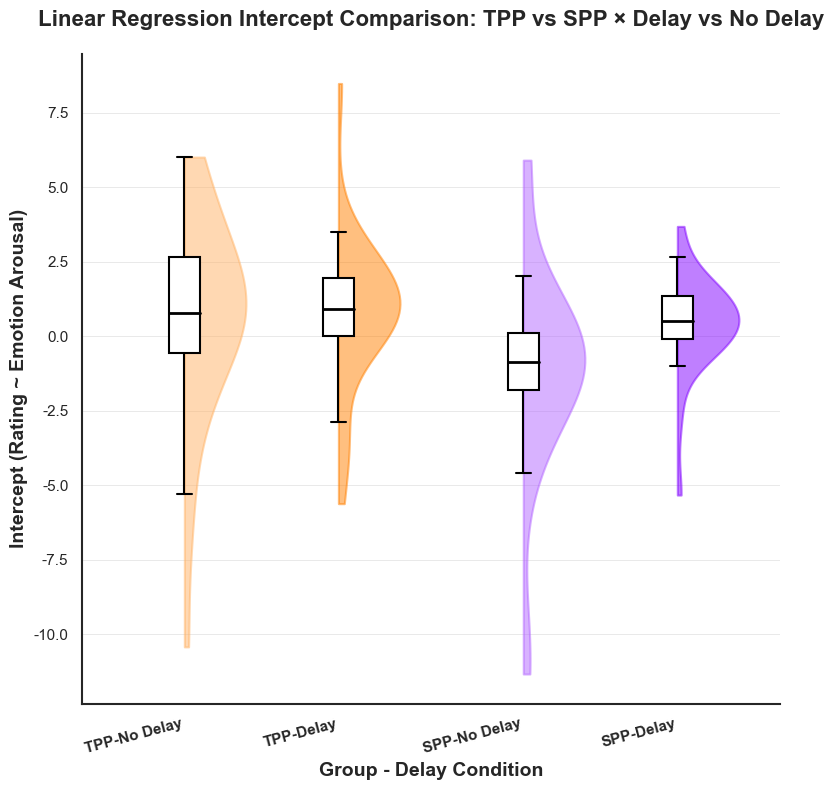


TPP组个体拟合示例:

  No Delay条件:
    被试 TPP_Subject_12: 截距 = 0.540, R² = 0.769, 数据点 = 27

  Delay条件:
    被试 TPP_Subject_30: 截距 = 0.784, R² = 0.701, 数据点 = 27

SPP组个体拟合示例:

  No Delay条件:
    被试 SPP_Subject_8: 截距 = -1.176, R² = 0.540, 数据点 = 27

  Delay条件:
    被试 SPP_Subject_13: 截距 = 0.476, R² = 0.932, 数据点 = 27

分析完成!
输出文件:
  - subject_intercepts_data_by_delay.csv: 所有被试在不同延迟条件下的截距数据
  - intercept_comparison_statistics_four_groups.csv: 四组间比较统计结果
  - intercept_comparison_four_groups.png: 四组条件截距比较图


In [20]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 计算每个被试在不同延迟条件下的线性拟合截距 ---
    def calculate_intercept_per_subject_by_delay(data_list, group_name):
        """
        计算每个被试在不同延迟条件下(Delay vs No Delay)情绪唤醒度与惩罚评分的线性拟合截距
        """
        intercept_results = []
        
        for i, subject_data in enumerate(data_list):
            # 确保数据包含所需的列
            if all(col in subject_data.columns for col in ['Emotion_Arousal', 'Rating', 'Delay_Info']):
                # 按Delay_Info是否等于0进行分类
                no_delay_data = subject_data[subject_data['Delay_Info'] == 0].dropna(subset=['Emotion_Arousal', 'Rating'])
                delay_data = subject_data[subject_data['Delay_Info'] != 0].dropna(subset=['Emotion_Arousal', 'Rating'])
                
                # 计算No Delay条件下的截距
                if len(no_delay_data) >= 2:
                    try:
                        slope, intercept, r_value, p_value, std_err = stats.linregress(
                            no_delay_data['Emotion_Arousal'], no_delay_data['Rating']
                        )
                        
                        intercept_results.append({
                            'Subject_ID': f"{group_name}_Subject_{i+1}",
                            'Group': group_name,
                            'Delay_Condition': 'No Delay',
                            'Combined_Group': f"{group_name}-No Delay",
                            'Intercept': intercept,
                            'Slope': slope,
                            'R_squared': r_value**2,
                            'P_value': p_value,
                            'Data_Points': len(no_delay_data)
                        })
                    except:
                        print(f"警告: 无法计算{group_name}组第{i+1}个被试No Delay条件的截距")
                
                # 计算Delay条件下的截距
                if len(delay_data) >= 2:
                    try:
                        slope, intercept, r_value, p_value, std_err = stats.linregress(
                            delay_data['Emotion_Arousal'], delay_data['Rating']
                        )
                        
                        intercept_results.append({
                            'Subject_ID': f"{group_name}_Subject_{i+1}",
                            'Group': group_name,
                            'Delay_Condition': 'Delay',
                            'Combined_Group': f"{group_name}-Delay",
                            'Intercept': intercept,
                            'Slope': slope,
                            'R_squared': r_value**2,
                            'P_value': p_value,
                            'Data_Points': len(delay_data)
                        })
                    except:
                        print(f"警告: 无法计算{group_name}组第{i+1}个被试Delay条件的截距")
            else:
                print(f"警告: {group_name}组第{i+1}个被试数据缺少必要列")
        
        return pd.DataFrame(intercept_results)

    # 计算TPP和SPP组在不同延迟条件下的截距
    print("正在计算不同延迟条件下的线性拟合截距...")
    tpp_intercepts = calculate_intercept_per_subject_by_delay(tpp_cleaned_list, "TPP")
    spp_intercepts = calculate_intercept_per_subject_by_delay(spp_cleaned_list, "SPP")
    
    print(f"TPP组成功计算 {len(tpp_intercepts)} 个条件-被试的截距")
    print(f"SPP组成功计算 {len(spp_intercepts)} 个条件-被试的截距")
    print("-" * 30)

    # --- 合并数据用于可视化 ---
    all_intercepts = pd.concat([tpp_intercepts, spp_intercepts], ignore_index=True)
    
    # 显示基本统计信息
    print("截距描述性统计:")
    for combined_group in ['TPP-No Delay', 'TPP-Delay', 'SPP-No Delay', 'SPP-Delay']:
        group_data = all_intercepts[all_intercepts['Combined_Group'] == combined_group]
        if len(group_data) > 0:
            print(f"{combined_group}:")
            print(f"  样本量: {len(group_data)}")
            print(f"  均值: {group_data['Intercept'].mean():.3f}")
            print(f"  标准差: {group_data['Intercept'].std():.3f}")
            print(f"  范围: {group_data['Intercept'].min():.3f} 到 {group_data['Intercept'].max():.3f}")
        else:
            print(f"{combined_group}: 无数据")
    print("-" * 30)

    # --- 显著性检验 ---
    def perform_group_comparisons(intercept_df):
        """
        对四组条件进行比较,组内使用配对检验,组间使用独立样本检验
        """
        print("\n" + "="*50)
        print("组间截距比较显著性检验")
        print("="*50)
        
        comparison_results = []
        
        # 1. 组内比较 (配对检验): TPP-No Delay vs TPP-Delay
        print("\n【组内配对比较】")
        for group_name in ['TPP', 'SPP']:
            # 获取该组的数据
            group_data = intercept_df[intercept_df['Group'] == group_name]
            
            # 创建配对数据框架
            paired_data = group_data.pivot_table(
                index='Subject_ID', 
                columns='Delay_Condition', 
                values='Intercept'
            )
            
            # 只保留同时有No Delay和Delay数据的被试
            paired_data = paired_data.dropna()
            
            if len(paired_data) > 0:
                no_delay_intercepts = paired_data['No Delay'].values
                delay_intercepts = paired_data['Delay'].values
                
                # Wilcoxon符号秩检验 (配对非参数检验)
                wilcoxon_stat, wilcoxon_p = stats.wilcoxon(no_delay_intercepts, delay_intercepts)
                
                # 配对t检验
                t_stat, t_p = stats.ttest_rel(no_delay_intercepts, delay_intercepts)
                
                # Cohen's d (配对样本)
                diff = no_delay_intercepts - delay_intercepts
                d = np.mean(diff) / np.std(diff, ddof=1)
                
                # 显著性标记
                if wilcoxon_p < 0.001:
                    sig_label = '***'
                elif wilcoxon_p < 0.01:
                    sig_label = '**'
                elif wilcoxon_p < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"\n{group_name}: No Delay vs Delay (配对比较, n={len(paired_data)}):")
                print(f"  Wilcoxon符号秩检验: W = {wilcoxon_stat:.3f}, p = {wilcoxon_p:.4f}")
                print(f"  配对t检验: t = {t_stat:.3f}, p = {t_p:.4f}")
                print(f"  Cohen's d: {d:.3f}")
                print(f"  显著性: {sig_label}")
                print(f"  No Delay均值: {np.mean(no_delay_intercepts):.3f} ± {np.std(no_delay_intercepts, ddof=1):.3f}")
                print(f"  Delay均值: {np.mean(delay_intercepts):.3f} ± {np.std(delay_intercepts, ddof=1):.3f}")
                
                comparison_results.append({
                    'Comparison': f"{group_name}: No Delay vs Delay",
                    'Group1': f"{group_name}-No Delay",
                    'Group2': f"{group_name}-Delay",
                    'Test_Type': 'Paired',
                    'N_pairs': len(paired_data),
                    'Wilcoxon_W': wilcoxon_stat,
                    'Wilcoxon_p': wilcoxon_p,
                    't_statistic': t_stat,
                    't_p_value': t_p,
                    'Cohens_d': d,
                    'Significance': sig_label
                })
            else:
                print(f"\n{group_name}: 没有配对数据")
        
        # 2. 组间比较 (独立样本检验)
        print("\n【组间独立样本比较】")
        independent_comparisons = [
            ('TPP-No Delay', 'SPP-No Delay'),
            ('TPP-Delay', 'SPP-Delay')
        ]
        
        for group1, group2 in independent_comparisons:
            data1 = intercept_df[intercept_df['Combined_Group'] == group1]['Intercept'].values
            data2 = intercept_df[intercept_df['Combined_Group'] == group2]['Intercept'].values
            
            if len(data1) > 0 and len(data2) > 0:
                # Mann-Whitney U检验
                statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                
                # 独立样本t检验
                t_stat, t_p = stats.ttest_ind(data1, data2)
                
                # Cohen's d (独立样本)
                def cohens_d(x, y):
                    nx = len(x)
                    ny = len(y)
                    dof = nx + ny - 2
                    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
                
                d = cohens_d(data1, data2)
                
                # 显著性标记
                if p_value < 0.001:
                    sig_label = '***'
                elif p_value < 0.01:
                    sig_label = '**'
                elif p_value < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"\n{group1} vs {group2} (独立样本, n1={len(data1)}, n2={len(data2)}):")
                print(f"  Mann-Whitney U: U = {statistic:.3f}, p = {p_value:.4f}")
                print(f"  独立样本t检验: t = {t_stat:.3f}, p = {t_p:.4f}")
                print(f"  Cohen's d: {d:.3f}")
                print(f"  显著性: {sig_label}")
                
                comparison_results.append({
                    'Comparison': f"{group1} vs {group2}",
                    'Group1': group1,
                    'Group2': group2,
                    'Test_Type': 'Independent',
                    'N_pairs': None,
                    'Wilcoxon_W': None,
                    'Wilcoxon_p': None,
                    'MannWhitney_U': statistic,
                    'MannWhitney_p': p_value,
                    't_statistic': t_stat,
                    't_p_value': t_p,
                    'Cohens_d': d,
                    'Significance': sig_label
                })
        
        return pd.DataFrame(comparison_results)

    # 执行组间比较
    comparison_results = perform_group_comparisons(all_intercepts)

    # --- 可视化函数 ---
    def create_intercept_comparison_plot_four_groups(intercept_df, comparison_df, save_path=None):
        """
        创建四组条件的截距比较图(TPP-No Delay, TPP-Delay, SPP-No Delay, SPP-Delay)
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # 定义组别顺序和颜色
        group_order = ['TPP-No Delay', 'TPP-Delay', 'SPP-No Delay', 'SPP-Delay']
        colors = {
            'TPP-No Delay': '#FFB366',
            'TPP-Delay': '#FF8000',
            'SPP-No Delay': '#B366FF',
            'SPP-Delay': '#8000FF'
        }
        
        # 准备数据
        plot_data = intercept_df.dropna(subset=['Intercept', 'Combined_Group'])
        
        # 创建位置映射
        interval = 0.75
        positions = [0, interval, interval*2.2, interval*3.2]
        
        # 获取四组数据
        data_groups = [plot_data[plot_data['Combined_Group'] == group]['Intercept'].values 
                      for group in group_order]
        
        # 绘制半小提琴图(只显示右侧,彩色)
        for idx, (pos, data, group) in enumerate(zip(positions, data_groups, group_order)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(x_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.3
                    
                    # 只绘制右侧,使用彩色
                    ax.fill_betweenx(x_range, pos, pos + density, 
                                    alpha=0.5, color=colors[group], 
                                    edgecolor=colors[group], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图(黑白配色,更窄的箱体)
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2.0),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            box.set_facecolor('white')
            box.set_linewidth(1.5)
        
        # 设置x轴
        ax.set_xticks(positions)
        ax.set_xticklabels(group_order, fontsize=11, fontweight='bold', rotation=15, ha='right')
        
        # 设置y轴标签
        ax.set_ylabel('Intercept (Rating ~ Emotion Arousal)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Group - Delay Condition', fontsize=14, fontweight='bold')
        
        # 设置标题
        ax.set_title('Linear Regression Intercept Comparison: TPP vs SPP × Delay vs No Delay',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 添加y轴网格线(仅水平方向)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框,加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 执行可视化 ---
    print("\n" + "="*50)
    print("生成四组条件截距比较图")
    print("="*50)
    
    create_intercept_comparison_plot_four_groups(all_intercepts, comparison_results, 
                                                save_path="intercept_comparison_four_groups.png")
    
    # --- 保存结果 ---
    # 保存截距数据
    all_intercepts.to_csv("subject_intercepts_data_by_delay.csv", index=False)
    
    # 保存统计结果
    comparison_results.to_csv("intercept_comparison_statistics_four_groups.csv", index=False)
    
    # 显示一些有代表性的个体拟合示例
    def show_individual_examples_by_delay(data_list, group_name, num_examples=3):
        """
        显示每个组在不同延迟条件下的个体拟合示例
        """
        print(f"\n{group_name}组个体拟合示例:")
        
        intercepts_df = calculate_intercept_per_subject_by_delay(data_list, group_name)
        
        for delay_cond in ['No Delay', 'Delay']:
            cond_data = intercepts_df[intercepts_df['Delay_Condition'] == delay_cond]
            
            if len(cond_data) > 0:
                print(f"\n  {delay_cond}条件:")
                mean_intercept = cond_data['Intercept'].mean()
                
                # 最接近平均值的
                closest_to_mean = cond_data.iloc[(cond_data['Intercept'] - mean_intercept).abs().argsort()[:1]]
                
                for _, example in closest_to_mean.iterrows():
                    print(f"    被试 {example['Subject_ID']}: 截距 = {example['Intercept']:.3f}, "
                          f"R² = {example['R_squared']:.3f}, 数据点 = {example['Data_Points']}")

    show_individual_examples_by_delay(tpp_cleaned_list, "TPP")
    show_individual_examples_by_delay(spp_cleaned_list, "SPP")
    
    print("\n" + "="*60)
    print("分析完成!")
    print("输出文件:")
    print("  - subject_intercepts_data_by_delay.csv: 所有被试在不同延迟条件下的截距数据")
    print("  - intercept_comparison_statistics_four_groups.csv: 四组间比较统计结果")
    print("  - intercept_comparison_four_groups.png: 四组条件截距比较图")
    print("="*60)

else:
    print("因无法创建延迟时间查找表,后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
正在计算不同延迟条件下的线性拟合斜率...
TPP组成功计算 60 个条件-被试的斜率
SPP组成功计算 52 个条件-被试的斜率
------------------------------
斜率描述性统计:
TPP-No Delay:
  样本量: 30
  均值: 0.863
  标准差: 0.806
  范围: -2.360 到 2.671
TPP-Delay:
  样本量: 30
  均值: 0.931
  标准差: 0.382
  范围: -0.459 到 1.560
SPP-No Delay:
  样本量: 26
  均值: 1.069
  标准差: 0.355
  范围: 0.031 到 1.996
SPP-Delay:
  样本量: 26
  均值: 0.950
  标准差: 0.171
  范围: 0.590 到 1.372
------------------------------

组间斜率比较显著性检验

【组内配对比较】

TPP: No Delay vs Delay (配对比较, n=30):
  Wilcoxon符号秩检验: W = 230.000, p = 0.9677
  配对t检验: t = -0.400, p = 0.6919
  Cohen's d: -0.073
  显著性: ns
  No Delay均值: 0.863 ± 0.806
  Delay均值: 0.931 ± 0.382

SPP: No Delay vs Delay (配对比较, n=26):
  Wilcoxon符号秩检验: W = 46.000, p = 0.0005
  配对t检验: t = 1.855, p = 0.0754
  Cohen's d: 0.364
  显著性: ***
  No Delay均值: 1.069 ± 0.355
  Delay均值: 0.950 ± 0.171

【组间独立样本比较】

TPP-

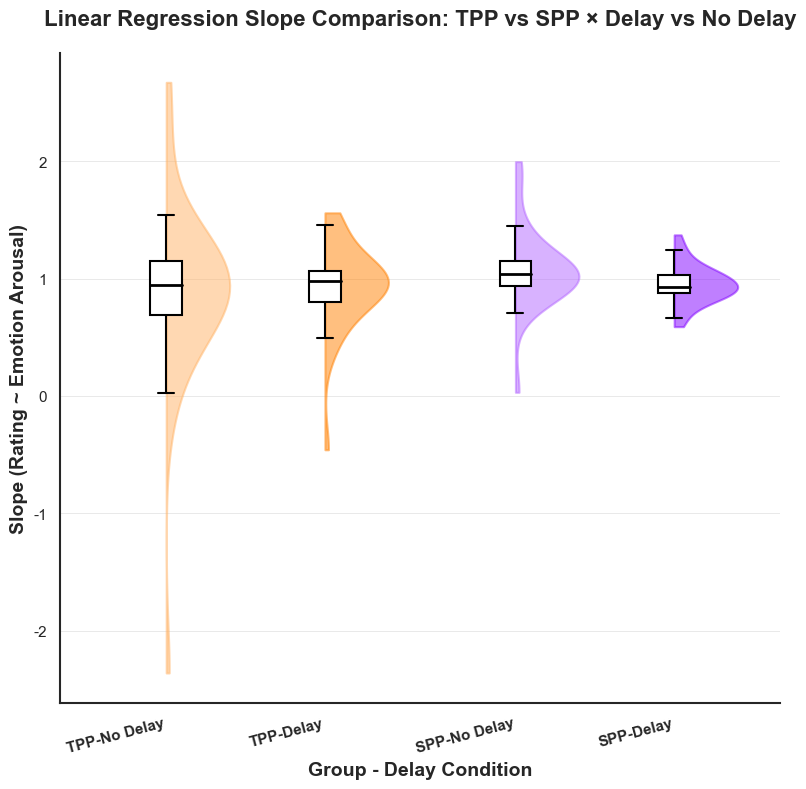


TPP组个体拟合示例:

  No Delay条件:
    被试 TPP_Subject_10: 斜率 = 0.839, R² = 0.395, 数据点 = 27

  Delay条件:
    被试 TPP_Subject_25: 斜率 = 0.941, R² = 0.726, 数据点 = 27

SPP组个体拟合示例:

  No Delay条件:
    被试 SPP_Subject_7: 斜率 = 1.065, R² = 0.903, 数据点 = 27

  Delay条件:
    被试 SPP_Subject_8: 斜率 = 0.950, R² = 0.714, 数据点 = 27

分析完成!
输出文件:
  - subject_slopes_data_by_delay.csv: 所有被试在不同延迟条件下的斜率数据
  - slope_comparison_statistics_four_groups.csv: 四组间比较统计结果
  - slope_comparison_four_groups.png: 四组条件斜率比较图


In [ ]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 计算每个被试在不同延迟条件下的线性拟合斜率 ---
    def calculate_slope_per_subject_by_delay(data_list, group_name):
        """
        计算每个被试在不同延迟条件下(Delay vs No Delay)情绪唤醒度与惩罚评分的线性拟合斜率
        """
        slope_results = []
        
        for i, subject_data in enumerate(data_list):
            # 确保数据包含所需的列
            if all(col in subject_data.columns for col in ['Emotion_Arousal', 'Rating', 'Delay_Info']):
                # 按Delay_Info是否等于0进行分类
                no_delay_data = subject_data[subject_data['Delay_Info'] == 0].dropna(subset=['Emotion_Arousal', 'Rating'])
                delay_data = subject_data[subject_data['Delay_Info'] != 0].dropna(subset=['Emotion_Arousal', 'Rating'])
                
                # 计算No Delay条件下的斜率
                if len(no_delay_data) >= 2:
                    try:
                        slope, intercept, r_value, p_value, std_err = stats.linregress(
                            no_delay_data['Emotion_Arousal'], no_delay_data['Rating']
                        )
                        
                        slope_results.append({
                            'Subject_ID': f"{group_name}_Subject_{i+1}",
                            'Group': group_name,
                            'Delay_Condition': 'No Delay',
                            'Combined_Group': f"{group_name}-No Delay",
                            'Slope': slope,
                            'Intercept': intercept,
                            'R_squared': r_value**2,
                            'P_value': p_value,
                            'Data_Points': len(no_delay_data)
                        })
                    except:
                        print(f"警告: 无法计算{group_name}组第{i+1}个被试No Delay条件的斜率")
                
                # 计算Delay条件下的斜率
                if len(delay_data) >= 2:
                    try:
                        slope, intercept, r_value, p_value, std_err = stats.linregress(
                            delay_data['Emotion_Arousal'], delay_data['Rating']
                        )
                        
                        slope_results.append({
                            'Subject_ID': f"{group_name}_Subject_{i+1}",
                            'Group': group_name,
                            'Delay_Condition': 'Delay',
                            'Combined_Group': f"{group_name}-Delay",
                            'Slope': slope,
                            'Intercept': intercept,
                            'R_squared': r_value**2,
                            'P_value': p_value,
                            'Data_Points': len(delay_data)
                        })
                    except:
                        print(f"警告: 无法计算{group_name}组第{i+1}个被试Delay条件的斜率")
            else:
                print(f"警告: {group_name}组第{i+1}个被试数据缺少必要列")
        
        return pd.DataFrame(slope_results)

    # 计算TPP和SPP组在不同延迟条件下的斜率
    print("正在计算不同延迟条件下的线性拟合斜率...")
    tpp_slopes = calculate_slope_per_subject_by_delay(tpp_cleaned_list, "TPP")
    spp_slopes = calculate_slope_per_subject_by_delay(spp_cleaned_list, "SPP")
    
    print(f"TPP组成功计算 {len(tpp_slopes)} 个条件-被试的斜率")
    print(f"SPP组成功计算 {len(spp_slopes)} 个条件-被试的斜率")
    print("-" * 30)

    # --- 合并数据用于可视化 ---
    all_slopes = pd.concat([tpp_slopes, spp_slopes], ignore_index=True)
    
    # 显示基本统计信息
    print("斜率描述性统计:")
    for combined_group in ['TPP-No Delay', 'TPP-Delay', 'SPP-No Delay', 'SPP-Delay']:
        group_data = all_slopes[all_slopes['Combined_Group'] == combined_group]
        if len(group_data) > 0:
            print(f"{combined_group}:")
            print(f"  样本量: {len(group_data)}")
            print(f"  均值: {group_data['Slope'].mean():.3f}")
            print(f"  标准差: {group_data['Slope'].std():.3f}")
            print(f"  范围: {group_data['Slope'].min():.3f} 到 {group_data['Slope'].max():.3f}")
        else:
            print(f"{combined_group}: 无数据")
    print("-" * 30)

    # --- 显著性检验 ---
    def perform_group_comparisons(slope_df):
        """
        对四组条件进行比较,组内使用配对检验,组间使用独立样本检验
        """
        print("\n" + "="*50)
        print("组间斜率比较显著性检验")
        print("="*50)
        
        comparison_results = []
        
        # 1. 组内比较 (配对检验): TPP-No Delay vs TPP-Delay
        print("\n【组内配对比较】")
        for group_name in ['TPP', 'SPP']:
            # 获取该组的数据
            group_data = slope_df[slope_df['Group'] == group_name]
            
            # 创建配对数据框架
            paired_data = group_data.pivot_table(
                index='Subject_ID', 
                columns='Delay_Condition', 
                values='Slope'
            )
            
            # 只保留同时有No Delay和Delay数据的被试
            paired_data = paired_data.dropna()
            
            if len(paired_data) > 0:
                no_delay_slopes = paired_data['No Delay'].values
                delay_slopes = paired_data['Delay'].values
                
                # Wilcoxon符号秩检验 (配对非参数检验)
                wilcoxon_stat, wilcoxon_p = stats.wilcoxon(no_delay_slopes, delay_slopes)
                
                # 配对t检验
                t_stat, t_p = stats.ttest_rel(no_delay_slopes, delay_slopes)
                
                # Cohen's d (配对样本)
                diff = no_delay_slopes - delay_slopes
                d = np.mean(diff) / np.std(diff, ddof=1)
                
                # 显著性标记
                if wilcoxon_p < 0.001:
                    sig_label = '***'
                elif wilcoxon_p < 0.01:
                    sig_label = '**'
                elif wilcoxon_p < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"\n{group_name}: No Delay vs Delay (配对比较, n={len(paired_data)}):")
                print(f"  Wilcoxon符号秩检验: W = {wilcoxon_stat:.3f}, p = {wilcoxon_p:.4f}")
                print(f"  配对t检验: t = {t_stat:.3f}, p = {t_p:.4f}")
                print(f"  Cohen's d: {d:.3f}")
                print(f"  显著性: {sig_label}")
                print(f"  No Delay均值: {np.mean(no_delay_slopes):.3f} ± {np.std(no_delay_slopes, ddof=1):.3f}")
                print(f"  Delay均值: {np.mean(delay_slopes):.3f} ± {np.std(delay_slopes, ddof=1):.3f}")
                
                comparison_results.append({
                    'Comparison': f"{group_name}: No Delay vs Delay",
                    'Group1': f"{group_name}-No Delay",
                    'Group2': f"{group_name}-Delay",
                    'Test_Type': 'Paired',
                    'N_pairs': len(paired_data),
                    'Wilcoxon_W': wilcoxon_stat,
                    'Wilcoxon_p': wilcoxon_p,
                    't_statistic': t_stat,
                    't_p_value': t_p,
                    'Cohens_d': d,
                    'Significance': sig_label
                })
            else:
                print(f"\n{group_name}: 没有配对数据")
        
        # 2. 组间比较 (独立样本检验)
        print("\n【组间独立样本比较】")
        independent_comparisons = [
            ('TPP-No Delay', 'SPP-No Delay'),
            ('TPP-Delay', 'SPP-Delay')
        ]
        
        for group1, group2 in independent_comparisons:
            data1 = slope_df[slope_df['Combined_Group'] == group1]['Slope'].values
            data2 = slope_df[slope_df['Combined_Group'] == group2]['Slope'].values
            
            if len(data1) > 0 and len(data2) > 0:
                # Mann-Whitney U检验
                statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                
                # 独立样本t检验
                t_stat, t_p = stats.ttest_ind(data1, data2)
                
                # Cohen's d (独立样本)
                def cohens_d(x, y):
                    nx = len(x)
                    ny = len(y)
                    dof = nx + ny - 2
                    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
                
                d = cohens_d(data1, data2)
                
                # 显著性标记
                if p_value < 0.001:
                    sig_label = '***'
                elif p_value < 0.01:
                    sig_label = '**'
                elif p_value < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"\n{group1} vs {group2} (独立样本, n1={len(data1)}, n2={len(data2)}):")
                print(f"  Mann-Whitney U: U = {statistic:.3f}, p = {p_value:.4f}")
                print(f"  独立样本t检验: t = {t_stat:.3f}, p = {t_p:.4f}")
                print(f"  Cohen's d: {d:.3f}")
                print(f"  显著性: {sig_label}")
                
                comparison_results.append({
                    'Comparison': f"{group1} vs {group2}",
                    'Group1': group1,
                    'Group2': group2,
                    'Test_Type': 'Independent',
                    'N_pairs': None,
                    'Wilcoxon_W': None,
                    'Wilcoxon_p': None,
                    'MannWhitney_U': statistic,
                    'MannWhitney_p': p_value,
                    't_statistic': t_stat,
                    't_p_value': t_p,
                    'Cohens_d': d,
                    'Significance': sig_label
                })
        
        return pd.DataFrame(comparison_results)

    # 执行组间比较
    comparison_results = perform_group_comparisons(all_slopes)

    # --- 可视化函数 ---
    def create_slope_comparison_plot_four_groups(slope_df, comparison_df, save_path=None):
        """
        创建四组条件的斜率比较图(TPP-No Delay, TPP-Delay, SPP-No Delay, SPP-Delay)
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # 定义组别顺序和颜色
        group_order = ['TPP-No Delay', 'TPP-Delay', 'SPP-No Delay', 'SPP-Delay']
        colors = {
            'TPP-No Delay': '#FFB366',  # 浅橙色
            'TPP-Delay': '#FF8000',     # 深橙色
            'SPP-No Delay': '#B366FF',  # 浅紫色
            'SPP-Delay': '#8000FF'      # 深紫色
        }
        
        # 准备数据
        plot_data = slope_df.dropna(subset=['Slope', 'Combined_Group'])
        
        # 创建位置映射
        interval = 0.75
        positions = [0, interval, interval*2.2, interval*3.2]  # TPP组内间距为1,SPP组内间距为1,TPP和SPP之间间距为1.5
        
        # 获取四组数据
        data_groups = [plot_data[plot_data['Combined_Group'] == group]['Slope'].values 
                      for group in group_order]
        
        # 绘制半小提琴图(只显示右侧,彩色)
        for idx, (pos, data, group) in enumerate(zip(positions, data_groups, group_order)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(x_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.3
                    
                    # 只绘制右侧,使用彩色
                    ax.fill_betweenx(x_range, pos, pos + density, 
                                    alpha=0.5, color=colors[group], 
                                    edgecolor=colors[group], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图(黑白配色,更窄的箱体)
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,  # 箱体宽度
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2.0),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            box.set_facecolor('white')
            box.set_linewidth(1.5)
        
        # 设置x轴
        ax.set_xticks(positions)
        ax.set_xticklabels(group_order, fontsize=11, fontweight='bold', rotation=15, ha='right')
        
        # 设置y轴标签
        ax.set_ylabel('Slope (Rating ~ Emotion Arousal)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Group - Delay Condition', fontsize=14, fontweight='bold')
        
        # 设置标题
        ax.set_title('Linear Regression Slope Comparison: TPP vs SPP × Delay vs No Delay',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 添加y轴网格线(仅水平方向)
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)  # 将网格线放在图形元素下方
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框,加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 执行可视化 ---
    print("\n" + "="*50)
    print("生成四组条件斜率比较图")
    print("="*50)
    
    create_slope_comparison_plot_four_groups(all_slopes, comparison_results, 
                                            save_path="slope_comparison_four_groups.png")
    
    # --- 保存结果 ---
    # 保存斜率数据
    all_slopes.to_csv("subject_slopes_data_by_delay.csv", index=False)
    
    # 保存统计结果
    comparison_results.to_csv("slope_comparison_statistics_four_groups.csv", index=False)
    
    # 显示一些有代表性的个体拟合示例
    def show_individual_examples_by_delay(data_list, group_name, num_examples=3):
        """
        显示每个组在不同延迟条件下的个体拟合示例
        """
        print(f"\n{group_name}组个体拟合示例:")
        
        slopes_df = calculate_slope_per_subject_by_delay(data_list, group_name)
        
        for delay_cond in ['No Delay', 'Delay']:
            cond_data = slopes_df[slopes_df['Delay_Condition'] == delay_cond]
            
            if len(cond_data) > 0:
                print(f"\n  {delay_cond}条件:")
                mean_slope = cond_data['Slope'].mean()
                
                # 最接近平均值的
                closest_to_mean = cond_data.iloc[(cond_data['Slope'] - mean_slope).abs().argsort()[:1]]
                
                for _, example in closest_to_mean.iterrows():
                    print(f"    被试 {example['Subject_ID']}: 斜率 = {example['Slope']:.3f}, "
                          f"R² = {example['R_squared']:.3f}, 数据点 = {example['Data_Points']}")

    show_individual_examples_by_delay(tpp_cleaned_list, "TPP")
    show_individual_examples_by_delay(spp_cleaned_list, "SPP")
    
    print("\n" + "="*60)
    print("分析完成!")
    print("输出文件:")
    print("  - subject_slopes_data_by_delay.csv: 所有被试在不同延迟条件下的斜率数据")
    print("  - slope_comparison_statistics_four_groups.csv: 四组间比较统计结果")
    print("  - slope_comparison_four_groups.png: 四组条件斜率比较图")
    print("="*60)

else:
    print("因无法创建延迟时间查找表,后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
正在计算线性拟合斜率...
TPP组成功计算 30 个被试的斜率
SPP组成功计算 26 个被试的斜率
------------------------------
斜率描述性统计:
TPP组:
  均值: 0.815
  标准差: 0.359
  范围: 0.029 到 1.551
SPP组:
  均值: 0.870
  标准差: 0.253
  范围: -0.014 到 1.290
------------------------------

组间斜率比较显著性检验
Mann-Whitney U检验:
  U统计量: 339.000
  p值: 0.4067
独立样本t检验:
  t统计量: -0.664
  p值: 0.5093
Cohen's d效应量: -0.178
显著性: ns

生成斜率比较图
图片已保存至: slope_comparison_TPP_vs_SPP.png


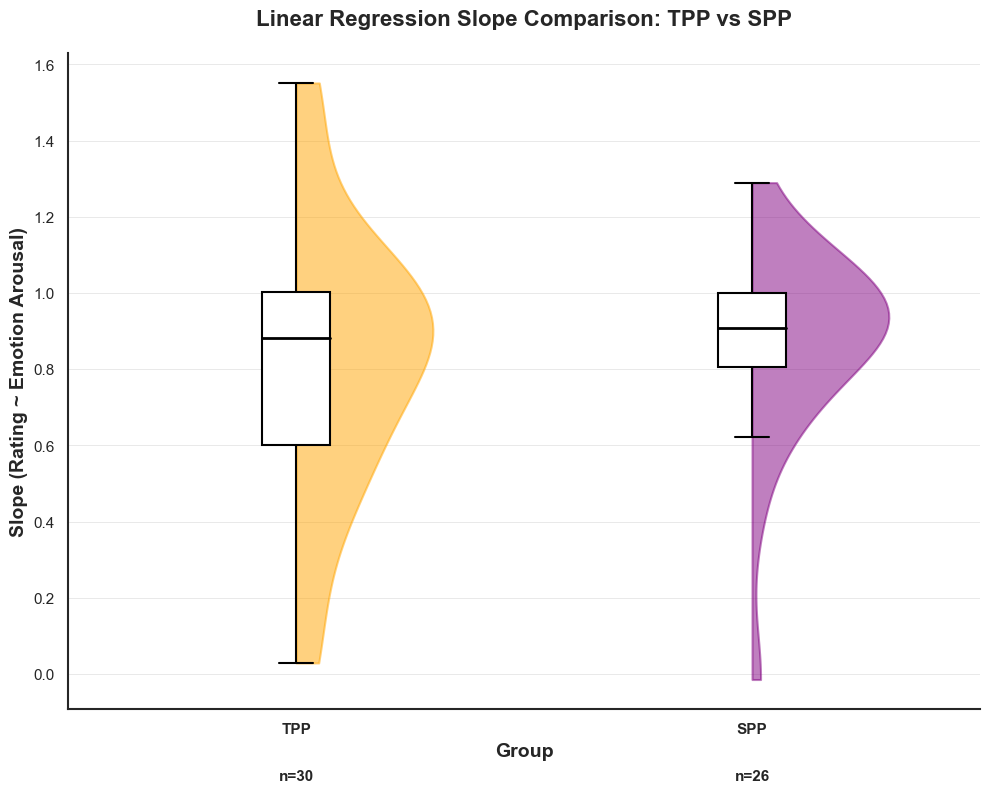


TPP组个体拟合示例:
  被试 TPP_Subject_18: 斜率 = 0.809, R² = 0.544, 数据点 = 54
  被试 TPP_Subject_29: 斜率 = 1.551, R² = 0.905, 数据点 = 54
  被试 TPP_Subject_5: 斜率 = 0.029, R² = 0.000, 数据点 = 54

SPP组个体拟合示例:
  被试 SPP_Subject_23: 斜率 = 0.864, R² = 0.855, 数据点 = 54
  被试 SPP_Subject_4: 斜率 = 1.290, R² = 0.388, 数据点 = 54
  被试 SPP_Subject_3: 斜率 = -0.014, R² = 0.000, 数据点 = 54

分析完成！
输出文件:
  - subject_slopes_data.csv: 所有被试的斜率数据
  - slope_comparison_statistics.csv: 组间比较统计结果
  - slope_comparison_TPP_vs_SPP.png: 斜率比较图


In [9]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 计算每个被试的线性拟合斜率 ---
    def calculate_slope_per_subject(data_list, group_name):
        """
        计算每个被试情绪唤醒度与惩罚评分的线性拟合斜率
        """
        slope_results = []
        
        for i, subject_data in enumerate(data_list):
            # 确保数据包含所需的列
            if 'Emotion_Arousal' in subject_data.columns and 'Rating' in subject_data.columns:
                # 移除缺失值
                clean_data = subject_data.dropna(subset=['Emotion_Arousal', 'Rating'])
                
                if len(clean_data) >= 2:  # 至少需要2个点才能计算斜率
                    try:
                        # 计算线性回归
                        slope, intercept, r_value, p_value, std_err = stats.linregress(
                            clean_data['Emotion_Arousal'], clean_data['Rating']
                        )
                        
                        slope_results.append({
                            'Subject_ID': f"{group_name}_Subject_{i+1}",
                            'Group': group_name,
                            'Slope': slope,
                            'Intercept': intercept,
                            'R_squared': r_value**2,
                            'P_value': p_value,
                            'Data_Points': len(clean_data)
                        })
                    except:
                        print(f"警告: 无法计算{group_name}组第{i+1}个被试的斜率")
                else:
                    print(f"警告: {group_name}组第{i+1}个被试数据点不足")
            else:
                print(f"警告: {group_name}组第{i+1}个被试数据缺少必要列")
        
        return pd.DataFrame(slope_results)

    # 计算TPP和SPP组的斜率
    print("正在计算线性拟合斜率...")
    tpp_slopes = calculate_slope_per_subject(tpp_cleaned_list, "TPP")
    spp_slopes = calculate_slope_per_subject(spp_cleaned_list, "SPP")
    
    print(f"TPP组成功计算 {len(tpp_slopes)} 个被试的斜率")
    print(f"SPP组成功计算 {len(spp_slopes)} 个被试的斜率")
    print("-" * 30)

    # --- 合并数据用于可视化 ---
    all_slopes = pd.concat([tpp_slopes, spp_slopes], ignore_index=True)
    
    # 显示基本统计信息
    print("斜率描述性统计:")
    print("TPP组:")
    print(f"  均值: {tpp_slopes['Slope'].mean():.3f}")
    print(f"  标准差: {tpp_slopes['Slope'].std():.3f}")
    print(f"  范围: {tpp_slopes['Slope'].min():.3f} 到 {tpp_slopes['Slope'].max():.3f}")
    
    print("SPP组:")
    print(f"  均值: {spp_slopes['Slope'].mean():.3f}")
    print(f"  标准差: {spp_slopes['Slope'].std():.3f}")
    print(f"  范围: {spp_slopes['Slope'].min():.3f} 到 {spp_slopes['Slope'].max():.3f}")
    print("-" * 30)

    # --- 显著性检验 ---
    def perform_group_comparison(tpp_data, spp_data):
        """
        对TPP和SPP组的斜率进行显著性检验
        """
        print("\n" + "="*50)
        print("组间斜率比较显著性检验")
        print("="*50)
        
        # Mann-Whitney U检验
        statistic, p_value = stats.mannwhitneyu(
            tpp_data['Slope'], spp_data['Slope'], alternative='two-sided'
        )
        
        print(f"Mann-Whitney U检验:")
        print(f"  U统计量: {statistic:.3f}")
        print(f"  p值: {p_value:.4f}")
        
        # t检验（参数检验）
        t_stat, t_p = stats.ttest_ind(tpp_data['Slope'], spp_data['Slope'])
        print(f"独立样本t检验:")
        print(f"  t统计量: {t_stat:.3f}")
        print(f"  p值: {t_p:.4f}")
        
        # 效应量计算
        def cohens_d(x, y):
            nx = len(x)
            ny = len(y)
            dof = nx + ny - 2
            return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
        
        d = cohens_d(tpp_data['Slope'], spp_data['Slope'])
        print(f"Cohen's d效应量: {d:.3f}")
        
        # 显著性标记
        if p_value < 0.001:
            sig_label = '***'
        elif p_value < 0.01:
            sig_label = '**'
        elif p_value < 0.05:
            sig_label = '*'
        else:
            sig_label = 'ns'
        
        print(f"显著性: {sig_label}")
        
        return {
            'mannwhitney_u': statistic,
            'mannwhitney_p': p_value,
            't_statistic': t_stat,
            't_p_value': t_p,
            'cohens_d': d,
            'significance': sig_label
        }

    # 执行组间比较
    comparison_results = perform_group_comparison(tpp_slopes, spp_slopes)

    # --- 可视化函数 ---
    def create_slope_comparison_plot(slope_df, save_path=None):
        """
        创建TPP和SPP组斜率比较图（箱线图+半小提琴图）
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # 定义组别顺序和颜色
        group_order = ['TPP', 'SPP']
        colors = {
            'TPP': '#FFA500',  # 蓝色
            'SPP': '#800080'   # 红色
        }
        
        # 准备数据
        plot_data = slope_df.dropna(subset=['Slope', 'Group'])
        
        # 创建位置映射
        positions = [0, 1]
        
        # 获取两组数据
        tpp_data = plot_data[plot_data['Group'] == 'TPP']['Slope'].values
        spp_data = plot_data[plot_data['Group'] == 'SPP']['Slope'].values
        data_groups = [tpp_data, spp_data]
        
        # 绘制半小提琴图（只显示右侧，彩色）
        for idx, (pos, data, group) in enumerate(zip(positions, data_groups, group_order)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(x_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.3
                    
                    # 只绘制右侧，使用彩色
                    ax.fill_betweenx(x_range, pos, pos + density, 
                                    alpha=0.5, color=colors[group], 
                                    edgecolor=colors[group], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图（黑白配色，更窄的箱体）
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,  # 箱体宽度
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            box.set_facecolor('white')
            box.set_linewidth(1.5)
        
        # 设置x轴
        ax.set_xticks(positions)
        ax.set_xticklabels(group_order, fontsize=12, fontweight='bold')
        
        # 设置y轴标签
        ax.set_ylabel('Slope (Rating ~ Emotion Arousal)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Group', fontsize=14, fontweight='bold')
        
        # 设置标题
        ax.set_title('Linear Regression Slope Comparison: TPP vs SPP',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 添加显著性标记
        y_max = max([np.max(data) for data in data_groups if len(data) > 0])
        y_min = min([np.min(data) for data in data_groups if len(data) > 0])
        y_range = y_max - y_min
        
        sig_y = y_max + 0.1 * y_range
        sig_x = [0, 1]
        
        # # 绘制显著性线
        # ax.plot(sig_x, [sig_y, sig_y], 'k-', linewidth=1.5)
        # # 添加显著性标记
        # ax.text(0.5, sig_y + 0.02 * y_range, comparison_results['significance'], 
        #        ha='center', va='bottom', fontsize=14, fontweight='bold')
        
        # 添加样本量信息
        for i, group in enumerate(group_order):
            n = len(plot_data[plot_data['Group'] == group])
            ax.text(positions[i], y_min - 0.15 * y_range, f'n={n}', 
                   ha='center', va='top', fontsize=11, fontweight='bold')
        
        # 添加y轴网格线（仅水平方向）
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)  # 将网格线放在图形元素下方
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框，加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 执行可视化 ---
    print("\n" + "="*50)
    print("生成斜率比较图")
    print("="*50)
    
    create_slope_comparison_plot(all_slopes, save_path="slope_comparison_TPP_vs_SPP.png")
    
    # --- 保存结果 ---
    # 保存斜率数据
    all_slopes.to_csv("subject_slopes_data.csv", index=False)
    
    # 保存统计结果
    stats_df = pd.DataFrame([comparison_results])
    stats_df.to_csv("slope_comparison_statistics.csv", index=False)
    
    # 显示一些有代表性的个体拟合示例
    def show_individual_examples(data_list, group_name, num_examples=3):
        """
        显示每个组几个有代表性的个体拟合示例
        """
        print(f"\n{group_name}组个体拟合示例:")
        
        slopes_df = calculate_slope_per_subject(data_list, group_name)
        
        # 选择斜率最大、最小和接近平均值的示例
        mean_slope = slopes_df['Slope'].mean()
        
        # 最接近平均值的
        closest_to_mean = slopes_df.iloc[(slopes_df['Slope'] - mean_slope).abs().argsort()[:1]]
        # 斜率最大的
        max_slope = slopes_df.nlargest(1, 'Slope')
        # 斜率最小的
        min_slope = slopes_df.nsmallest(1, 'Slope')
        
        examples = pd.concat([closest_to_mean, max_slope, min_slope])
        
        for _, example in examples.iterrows():
            subject_idx = int(example['Subject_ID'].split('_')[-1]) - 1
            subject_data = data_list[subject_idx].dropna(subset=['Emotion_Arousal', 'Rating'])
            
            print(f"  被试 {example['Subject_ID']}: 斜率 = {example['Slope']:.3f}, "
                  f"R² = {example['R_squared']:.3f}, 数据点 = {example['Data_Points']}")

    show_individual_examples(tpp_cleaned_list, "TPP")
    show_individual_examples(spp_cleaned_list, "SPP")
    
    print("\n" + "="*60)
    print("分析完成！")
    print("输出文件:")
    print("  - subject_slopes_data.csv: 所有被试的斜率数据")
    print("  - slope_comparison_statistics.csv: 组间比较统计结果")
    print("  - slope_comparison_TPP_vs_SPP.png: 斜率比较图")
    print("="*60)

else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
TPP组总数据量: 1620
SPP组总数据量: 1404

TPP组分析

TPP组显著性检验结果

Misdemeanor:
  Delay: N=270, Mean=2.663, SD=1.560
  No Delay: N=270, Mean=2.311, SD=1.445
  Mann-Whitney U statistic=41605.500, p-value=0.0034
  显著性: **

Felony:
  Delay: N=270, Mean=5.759, SD=2.124
  No Delay: N=270, Mean=5.193, SD=2.071
  Mann-Whitney U statistic=42074.500, p-value=0.0017
  显著性: **

Capital:
  Delay: N=270, Mean=8.652, SD=0.699
  No Delay: N=270, Mean=8.448, SD=0.881
  Mann-Whitney U statistic=40402.500, p-value=0.0064
  显著性: **
图片已保存至: TPP_group_visualization.png


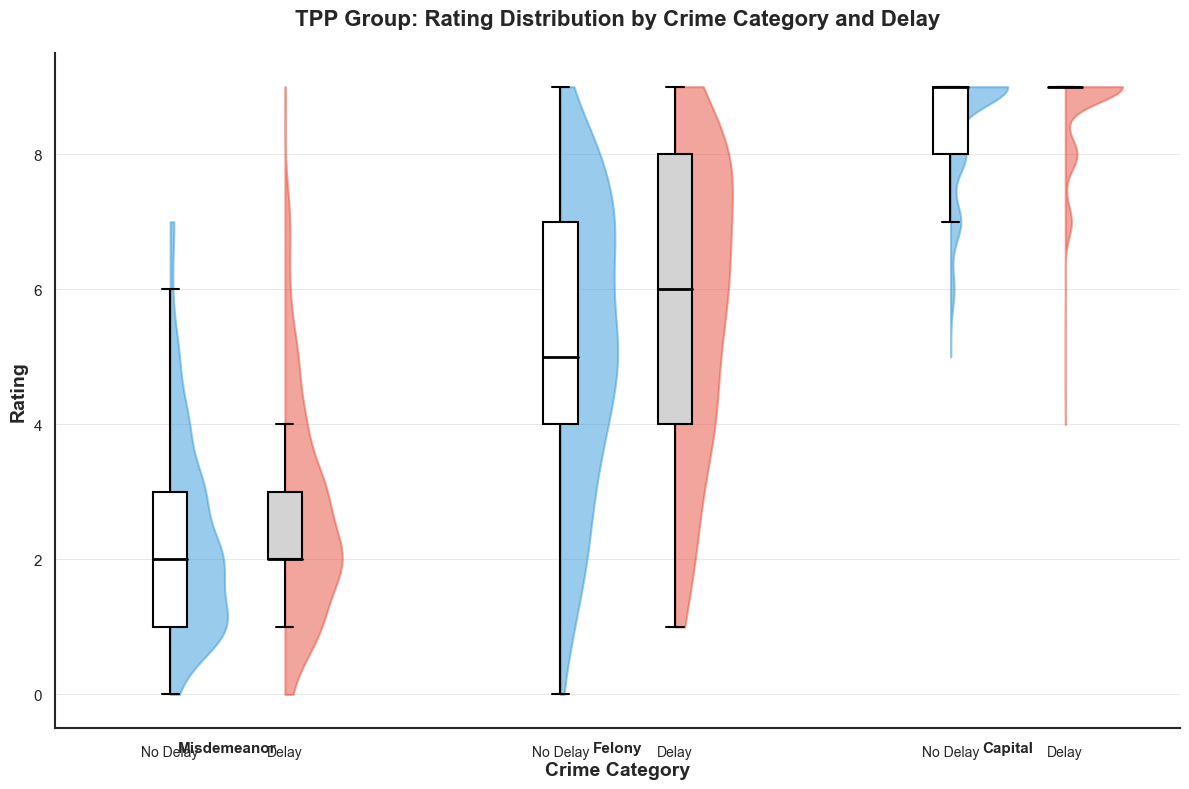


SPP组分析

SPP组显著性检验结果

Misdemeanor:
  Delay: N=234, Mean=2.402, SD=1.581
  No Delay: N=234, Mean=2.483, SD=1.592
  Mann-Whitney U statistic=26681.500, p-value=0.6253
  显著性: ns

Felony:
  Delay: N=234, Mean=5.449, SD=2.322
  No Delay: N=234, Mean=5.496, SD=2.294
  Mann-Whitney U statistic=27141.500, p-value=0.8707
  显著性: ns

Capital:
  Delay: N=234, Mean=8.457, SD=1.123
  No Delay: N=234, Mean=8.560, SD=1.123
  Mann-Whitney U statistic=25783.000, p-value=0.1543
  显著性: ns
图片已保存至: SPP_group_visualization.png


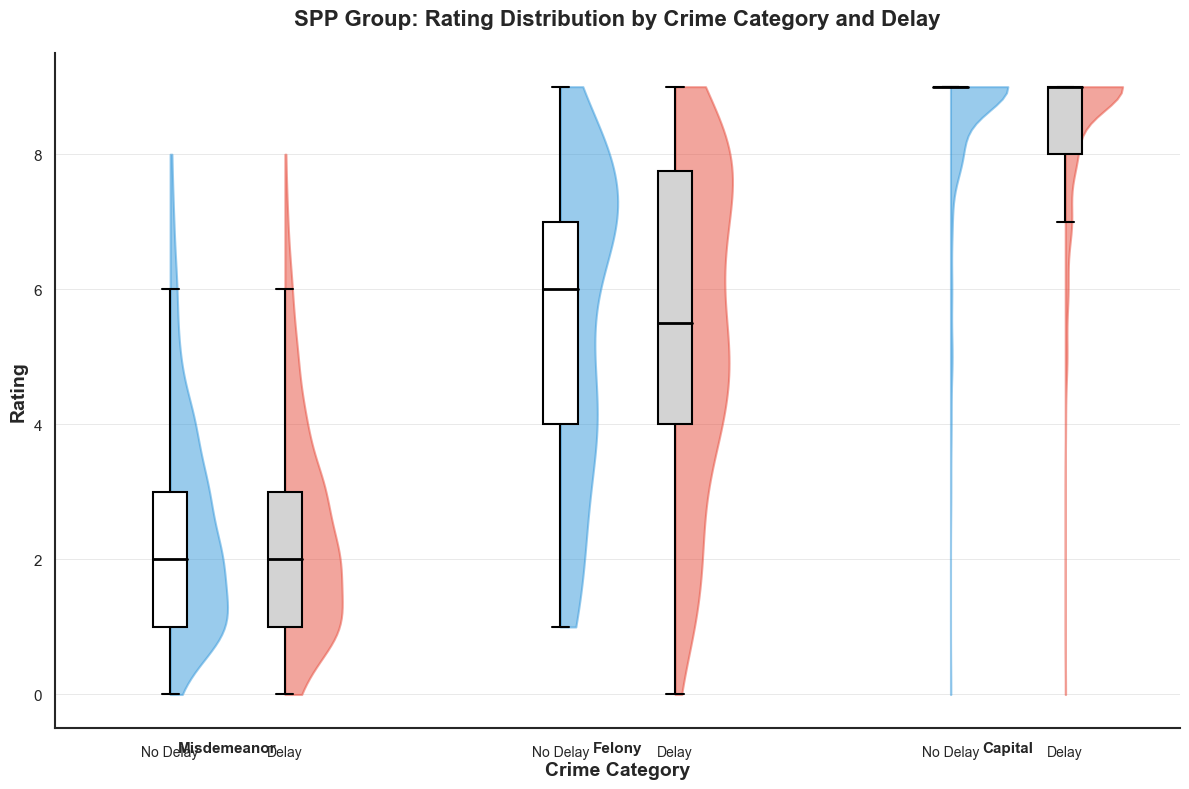


分析完成！统计结果已保存为CSV文件。


In [38]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 5. 合并数据用于可视化 ---
    tpp_all_data = pd.concat(tpp_cleaned_list, ignore_index=True)
    spp_all_data = pd.concat(spp_cleaned_list, ignore_index=True)

    print(f"TPP组总数据量: {len(tpp_all_data)}")
    print(f"SPP组总数据量: {len(spp_all_data)}")

    # --- 6. 数据准备：添加分类标签 ---
    def prepare_plot_data(df):
        """准备可视化数据，添加分类标签"""
        df = df.copy()
        
        category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
        df['Category_Label'] = df['Category'].map(category_map)
        
        df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
        
        df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
        
        return df

    tpp_plot_data = prepare_plot_data(tpp_all_data)
    spp_plot_data = prepare_plot_data(spp_all_data)

    # --- 7. 显著性检验函数 ---
    def perform_significance_tests(df, group_name):
        """
        对每个Category内的Delay vs No Delay进行Mann-Whitney U检验
        """
        print(f"\n{'='*60}")
        print(f"{group_name}组显著性检验结果")
        print(f"{'='*60}")
        
        results = []
        categories = ['Misdemeanor', 'Felony', 'Capital']
        
        for cat in categories:
            cat_data = df[df['Category_Label'] == cat]
            
            delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Rating'].dropna()
            no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Rating'].dropna()
            
            if len(delay_data) > 0 and len(no_delay_data) > 0:
                statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
                
                delay_mean = delay_data.mean()
                delay_std = delay_data.std()
                no_delay_mean = no_delay_data.mean()
                no_delay_std = no_delay_data.std()
                
                print(f"\n{cat}:")
                print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
                print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
                print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                
                if p_value < 0.001:
                    sig_label = '***'
                elif p_value < 0.01:
                    sig_label = '**'
                elif p_value < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"  显著性: {sig_label}")
                
                results.append({
                    'Category': cat,
                    'Delay_N': len(delay_data),
                    'Delay_Mean': delay_mean,
                    'Delay_SD': delay_std,
                    'NoDelay_N': len(no_delay_data),
                    'NoDelay_Mean': no_delay_mean,
                    'NoDelay_SD': no_delay_std,
                    'U_statistic': statistic,
                    'p_value': p_value,
                    'significance': sig_label
                })
            else:
                print(f"\n{cat}: 数据不足，无法进行检验")
        
        return pd.DataFrame(results)

    # --- 8. 可视化函数 ---
    def create_half_violin_box_plot(df, group_name, save_path=None):
        """
        创建黑白箱线图，右侧贴彩色半个分布图
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 定义类别顺序
        category_order = ['Misdemeanor', 'Felony', 'Capital']
        delay_order = ['No Delay', 'Delay']
        
        # 定义颜色方案（为分布图使用）
        colors = {
            'No Delay': '#3498db',  # 蓝色
            'Delay': '#e74c3c'      # 红色
        }
        
        # 准备数据
        plot_data = df.dropna(subset=['Rating', 'Category_Label', 'Delay_Label'])
        
        # 创建位置映射 - 缩短间距
        positions = []
        labels = []
        within_gap = 0.5  # 小类之间的间距（No Delay 和 Delay 之间）
        between_gap = 1.2  # 大类之间的间距
        
        current_pos = 0
        for i, cat in enumerate(category_order):
            if i > 0:
                current_pos += between_gap  # 大类之间的间距
            for j, delay in enumerate(delay_order):
                positions.append(current_pos)
                labels.append(delay)
                if j == 0:  # 只在第一个小类后加小间距
                    current_pos += within_gap
        
        # 获取所有数据组
        data_groups = []
        for cat in category_order:
            for delay in delay_order:
                data_groups.append(
                    plot_data[(plot_data['Category_Label'] == cat) & 
                             (plot_data['Delay_Label'] == delay)]['Rating'].values
                )
        
        # 绘制半小提琴图（只显示右侧，彩色）
        for idx, (pos, data, label) in enumerate(zip(positions, data_groups, labels)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    y_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(y_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.25
                    
                    # 只绘制右侧，使用彩色
                    ax.fill_betweenx(y_range, pos, pos + density, 
                                    alpha=0.5, color=colors[label], 
                                    edgecolor=colors[label], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图（黑白配色，更窄的箱体）
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,  # 箱体宽度
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            if i % 2 == 0:  # No Delay
                box.set_facecolor('white')
            else:  # Delay
                box.set_facecolor('lightgray')
            box.set_linewidth(1.5)
        
        # 设置x轴 - 计算每个大类的中心位置
        category_centers = []
        for i in range(len(category_order)):
            cat_positions = [positions[i*2], positions[i*2+1]]
            category_centers.append(np.mean(cat_positions))
        
        ax.set_xticks(category_centers)
        ax.set_xticklabels(category_order, fontsize=12, fontweight='bold')
        
        # 在每个大类下添加小标签
        y_min = ax.get_ylim()[0]
        for i in range(len(category_order)):
            ax.text(positions[i*2], y_min - 0.3, 'No Delay', 
                   ha='center', va='top', fontsize=10)
            ax.text(positions[i*2+1], y_min - 0.3, 'Delay', 
                   ha='center', va='top', fontsize=10)
        
        # 设置y轴刻度
        ax.set_yticks([0, 2, 4, 6, 8])
        ax.set_ylim(-0.5, 9.5)  # 设置y轴范围，留出一些空间
        
        # 添加y轴网格线（仅水平方向）
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)  # 将网格线放在图形元素下方
        
        # 设置y轴和x轴标签
        ax.set_ylabel('Rating', fontsize=14, fontweight='bold')
        ax.set_xlabel('Crime Category', fontsize=14, fontweight='bold')
        
        # 设置标题
        ax.set_title(f'{group_name} Group: Rating Distribution by Crime Category and Delay',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 去掉图例
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框，加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 9. 执行可视化和统计检验 ---
    
    # TPP组
    print("\n" + "="*60)
    print("TPP组分析")
    print("="*60)
    tpp_results = perform_significance_tests(tpp_plot_data, "TPP")
    create_half_violin_box_plot(tpp_plot_data, "TPP", save_path="TPP_group_visualization.png")
    
    # SPP组
    print("\n" + "="*60)
    print("SPP组分析")
    print("="*60)
    spp_results = perform_significance_tests(spp_plot_data, "SPP")
    create_half_violin_box_plot(spp_plot_data, "SPP", save_path="SPP_group_visualization.png")
    
    # --- 10. 保存统计结果 ---
    tpp_results.to_csv("TPP_significance_results.csv", index=False)
    spp_results.to_csv("SPP_significance_results.csv", index=False)
    
    print("\n" + "="*60)
    print("分析完成！统计结果已保存为CSV文件。")
    print("="*60)

else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
TPP组总数据量: 1620
SPP组总数据量: 1404

TPP组分析

TPP组显著性检验结果

Misdemeanor:
  Delay: N=270, Mean=2.663, SD=1.560
  No Delay: N=270, Mean=2.311, SD=1.445
  Mann-Whitney U statistic=41605.500, p-value=0.0034
  显著性: **

Felony:
  Delay: N=270, Mean=5.759, SD=2.124
  No Delay: N=270, Mean=5.193, SD=2.071
  Mann-Whitney U statistic=42074.500, p-value=0.0017
  显著性: **

Capital:
  Delay: N=270, Mean=8.652, SD=0.699
  No Delay: N=270, Mean=8.448, SD=0.881
  Mann-Whitney U statistic=40402.500, p-value=0.0064
  显著性: **
图片已保存至: TPP_group_rating.png


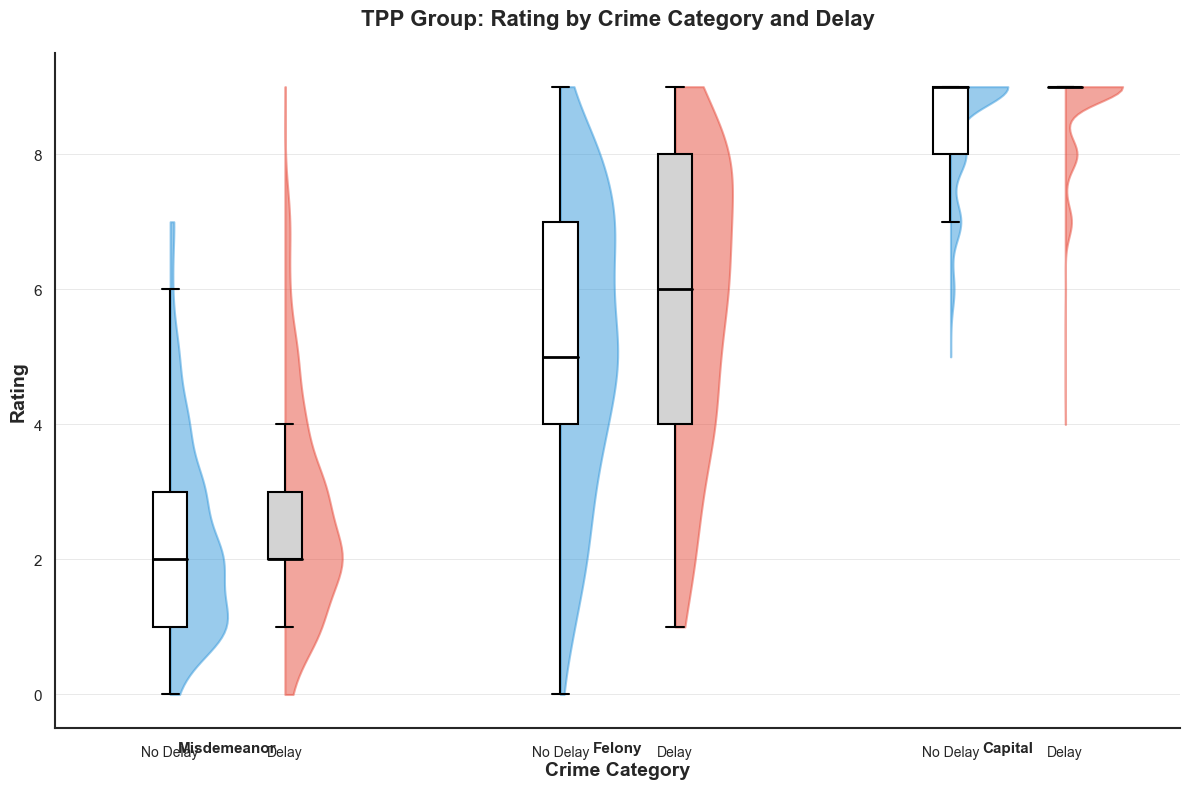


SPP组分析

SPP组显著性检验结果

Misdemeanor:
  Delay: N=234, Mean=2.402, SD=1.581
  No Delay: N=234, Mean=2.483, SD=1.592
  Mann-Whitney U statistic=26681.500, p-value=0.6253
  显著性: ns

Felony:
  Delay: N=234, Mean=5.449, SD=2.322
  No Delay: N=234, Mean=5.496, SD=2.294
  Mann-Whitney U statistic=27141.500, p-value=0.8707
  显著性: ns

Capital:
  Delay: N=234, Mean=8.457, SD=1.123
  No Delay: N=234, Mean=8.560, SD=1.123
  Mann-Whitney U statistic=25783.000, p-value=0.1543
  显著性: ns
图片已保存至: SPP_group_rating.png


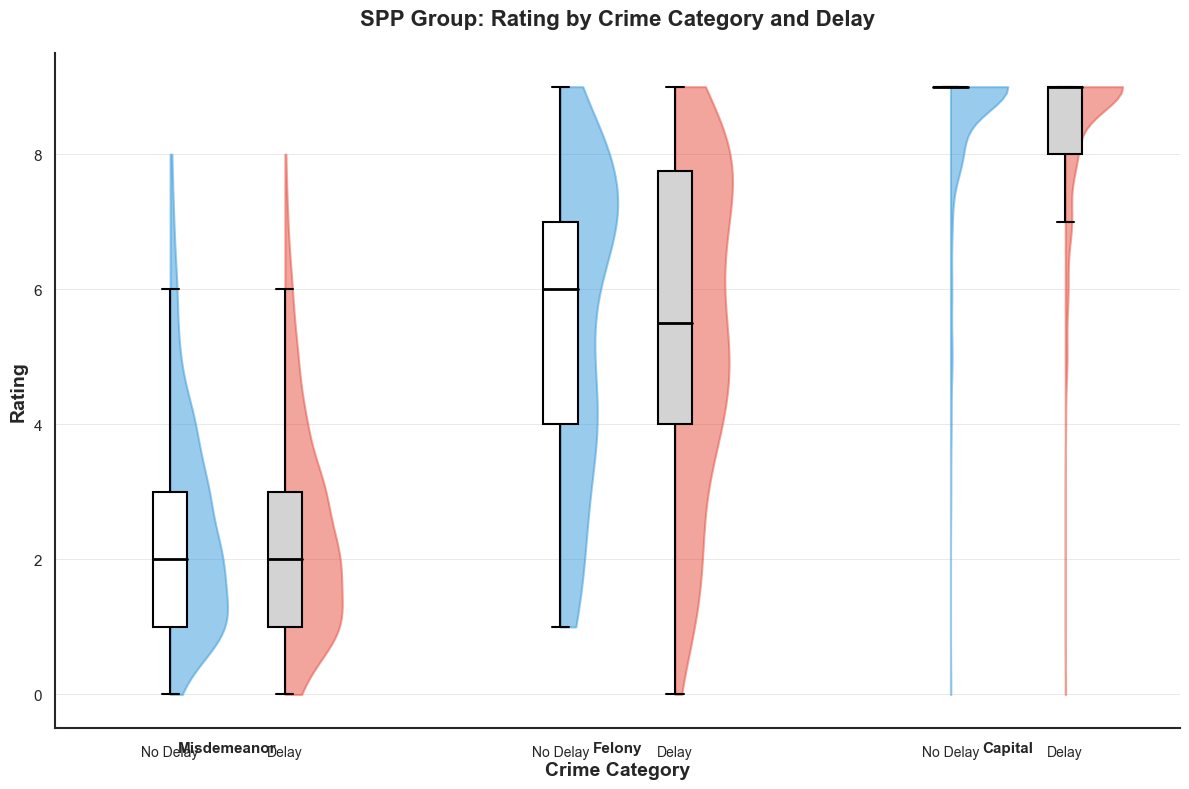


TPP vs SPP 组间差异分析

Misdemeanor - No Delay:
  TPP: N=270, Mean=2.311, SD=1.445
  SPP: N=234, Mean=2.483, SD=1.592
  Mann-Whitney U statistic=29946.000, p-value=0.2988
  显著性: ns

Misdemeanor - Delay:
  TPP: N=270, Mean=2.663, SD=1.560
  SPP: N=234, Mean=2.402, SD=1.581
  Mann-Whitney U statistic=34985.500, p-value=0.0328
  显著性: *

Felony - No Delay:
  TPP: N=270, Mean=5.193, SD=2.071
  SPP: N=234, Mean=5.496, SD=2.294
  Mann-Whitney U statistic=28689.000, p-value=0.0725
  显著性: ns

Felony - Delay:
  TPP: N=270, Mean=5.759, SD=2.124
  SPP: N=234, Mean=5.449, SD=2.322
  Mann-Whitney U statistic=33769.000, p-value=0.1775
  显著性: ns

Capital - No Delay:
  TPP: N=270, Mean=8.448, SD=0.881
  SPP: N=234, Mean=8.560, SD=1.123
  Mann-Whitney U statistic=27983.500, p-value=0.0056
  显著性: **

Capital - Delay:
  TPP: N=270, Mean=8.652, SD=0.699
  SPP: N=234, Mean=8.457, SD=1.123
  Mann-Whitney U statistic=33219.500, p-value=0.1949
  显著性: ns

组间差异分析完成！结果已保存为CSV文件。

生成TPP vs SPP组间对比图


C:\Users\47648\AppData\Local\Temp\ipykernel_9564\254750987.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Group', y='Rating',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\254750987.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_plot, x='Group', y='Rating',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\254750987.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Group', y='Rating',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\254750987.py:406: FutureWarning: 

Passing `pa

组间对比图已保存至: TPP_vs_SPP_comparison.png


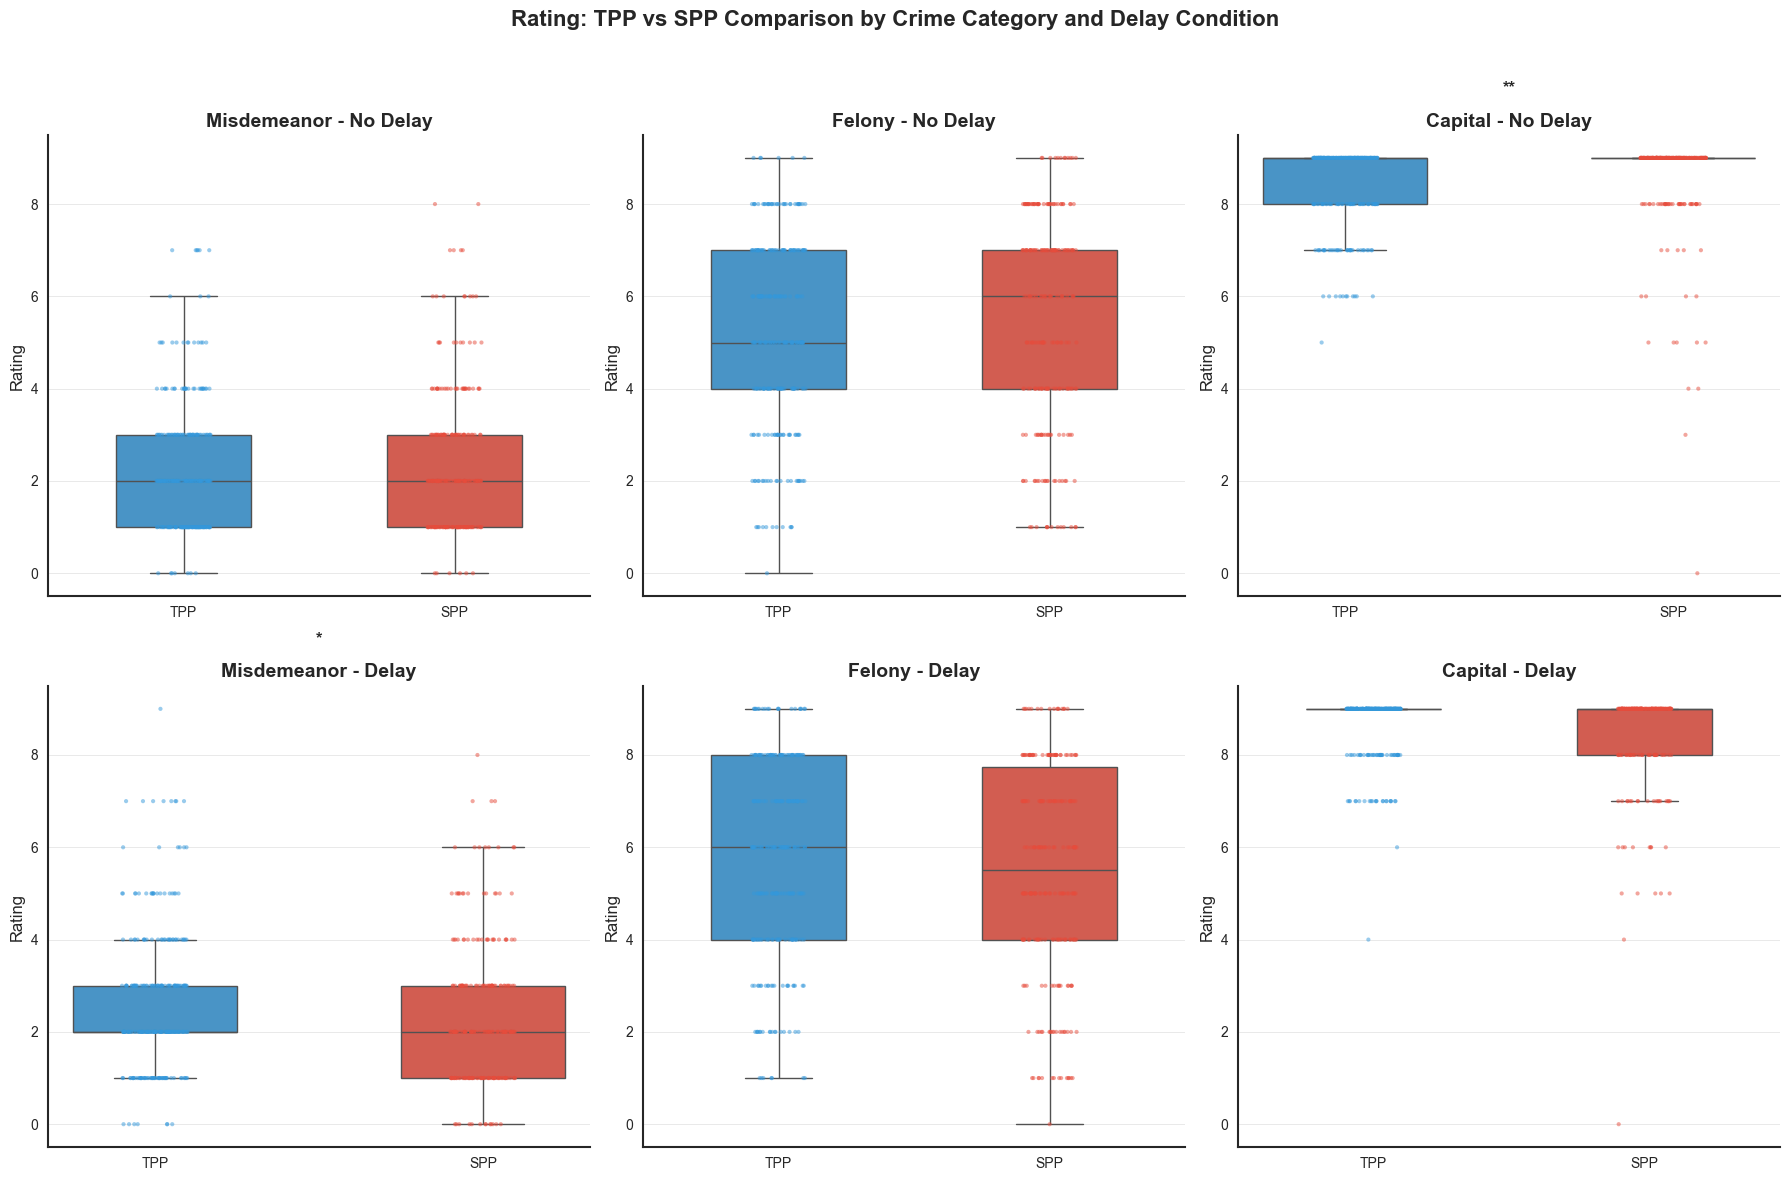


分析完成！评分统计结果已保存为CSV文件。


In [10]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 5. 合并数据用于可视化 ---
    tpp_all_data = pd.concat(tpp_cleaned_list, ignore_index=True)
    spp_all_data = pd.concat(spp_cleaned_list, ignore_index=True)

    print(f"TPP组总数据量: {len(tpp_all_data)}")
    print(f"SPP组总数据量: {len(spp_all_data)}")

    # --- 6. 数据准备：添加分类标签 ---
    def prepare_plot_data(df):
        """准备可视化数据，添加分类标签"""
        df = df.copy()
        
        category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
        df['Category_Label'] = df['Category'].map(category_map)
        
        df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
        
        df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
        
        return df

    tpp_plot_data = prepare_plot_data(tpp_all_data)
    spp_plot_data = prepare_plot_data(spp_all_data)

    # --- 7. 显著性检验函数 ---
    def perform_significance_tests(df, group_name):
        """
        对每个Category内的Delay vs No Delay进行Mann-Whitney U检验
        """
        print(f"\n{'='*60}")
        print(f"{group_name}组显著性检验结果")
        print(f"{'='*60}")
        
        results = []
        categories = ['Misdemeanor', 'Felony', 'Capital']
        
        for cat in categories:
            cat_data = df[df['Category_Label'] == cat]
            
            delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Rating'].dropna()
            no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Rating'].dropna()
            
            if len(delay_data) > 0 and len(no_delay_data) > 0:
                statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
                
                delay_mean = delay_data.mean()
                delay_std = delay_data.std()
                no_delay_mean = no_delay_data.mean()
                no_delay_std = no_delay_data.std()
                
                print(f"\n{cat}:")
                print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
                print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
                print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                
                if p_value < 0.001:
                    sig_label = '***'
                elif p_value < 0.01:
                    sig_label = '**'
                elif p_value < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"  显著性: {sig_label}")
                
                results.append({
                    'Category': cat,
                    'Delay_N': len(delay_data),
                    'Delay_Mean': delay_mean,
                    'Delay_SD': delay_std,
                    'NoDelay_N': len(no_delay_data),
                    'NoDelay_Mean': no_delay_mean,
                    'NoDelay_SD': no_delay_std,
                    'U_statistic': statistic,
                    'p_value': p_value,
                    'significance': sig_label
                })
            else:
                print(f"\n{cat}: 数据不足，无法进行检验")
        
        return pd.DataFrame(results)

    # --- 8. 可视化函数 ---
    def create_half_violin_box_plot(df, group_name, save_path=None):
        """
        创建黑白箱线图，右侧贴彩色半个分布图
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 定义类别顺序
        category_order = ['Misdemeanor', 'Felony', 'Capital']
        delay_order = ['No Delay', 'Delay']
        
        # 定义颜色方案（为分布图使用）
        colors = {
            'No Delay': '#3498db',  # 蓝色
            'Delay': '#e74c3c'      # 红色
        }
        
        # 准备数据
        plot_data = df.dropna(subset=['Rating', 'Category_Label', 'Delay_Label'])
        
        # 创建位置映射 - 缩短间距
        positions = []
        labels = []
        within_gap = 0.5  # 小类之间的间距（No Delay 和 Delay 之间）
        between_gap = 1.2  # 大类之间的间距
        
        current_pos = 0
        for i, cat in enumerate(category_order):
            if i > 0:
                current_pos += between_gap  # 大类之间的间距
            for j, delay in enumerate(delay_order):
                positions.append(current_pos)
                labels.append(delay)
                if j == 0:  # 只在第一个小类后加小间距
                    current_pos += within_gap
        
        # 获取所有数据组
        data_groups = []
        for cat in category_order:
            for delay in delay_order:
                data_groups.append(
                    plot_data[(plot_data['Category_Label'] == cat) & 
                             (plot_data['Delay_Label'] == delay)]['Rating'].values
                )
        
        # 绘制半小提琴图（只显示右侧，彩色）
        for idx, (pos, data, label) in enumerate(zip(positions, data_groups, labels)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    y_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(y_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.25
                    
                    # 只绘制右侧，使用彩色
                    ax.fill_betweenx(y_range, pos, pos + density, 
                                    alpha=0.5, color=colors[label], 
                                    edgecolor=colors[label], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图（黑白配色，更窄的箱体）
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,  # 箱体宽度
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            if i % 2 == 0:  # No Delay
                box.set_facecolor('white')
            else:  # Delay
                box.set_facecolor('lightgray')
            box.set_linewidth(1.5)
        
        # 设置x轴 - 计算每个大类的中心位置
        category_centers = []
        for i in range(len(category_order)):
            cat_positions = [positions[i*2], positions[i*2+1]]
            category_centers.append(np.mean(cat_positions))
        
        ax.set_xticks(category_centers)
        ax.set_xticklabels(category_order, fontsize=12, fontweight='bold')
        
        # 在每个大类下添加小标签
        y_min = ax.get_ylim()[0]
        for i in range(len(category_order)):
            ax.text(positions[i*2], y_min - 0.3, 'No Delay', 
                   ha='center', va='top', fontsize=10)
            ax.text(positions[i*2+1], y_min - 0.3, 'Delay', 
                   ha='center', va='top', fontsize=10)
        
        # 设置y轴刻度 - 根据Rating的范围调整
        # 假设Rating的范围也是0-8，如果不是请根据实际数据范围调整
        ax.set_yticks([0, 2, 4, 6, 8])
        ax.set_ylim(-0.5, 9.5)  # 设置y轴范围，留出一些空间
        
        # 添加y轴网格线（仅水平方向）
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)  # 将网格线放在图形元素下方
        
        # 设置y轴和x轴标签 - 修改y轴标签为Rating
        ax.set_ylabel('Rating', fontsize=14, fontweight='bold')
        ax.set_xlabel('Crime Category', fontsize=14, fontweight='bold')
        
        # 设置标题 - 更新标题以反映y轴的变化
        ax.set_title(f'{group_name} Group: Rating by Crime Category and Delay',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 去掉图例
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框，加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 9. 执行可视化和统计检验 ---
    
    # TPP组
    print("\n" + "="*60)
    print("TPP组分析")
    print("="*60)
    tpp_results = perform_significance_tests(tpp_plot_data, "TPP")
    create_half_violin_box_plot(tpp_plot_data, "TPP", save_path="TPP_group_rating.png")
    
    # SPP组
    print("\n" + "="*60)
    print("SPP组分析")
    print("="*60)
    spp_results = perform_significance_tests(spp_plot_data, "SPP")
    create_half_violin_box_plot(spp_plot_data, "SPP", save_path="SPP_group_rating.png")
    
        # --- 新增：TPP和SPP组间差异分析 ---
    def perform_group_comparison_by_category(tpp_df, spp_df):
        """
        对每个犯罪类别和延迟条件下的TPP和SPP组进行差异分析
        """
        print("\n" + "="*60)
        print("TPP vs SPP 组间差异分析")
        print("="*60)
        
        results = []
        categories = ['Misdemeanor', 'Felony', 'Capital']
        delay_conditions = ['No Delay', 'Delay']
        
        for cat in categories:
            for delay in delay_conditions:
                # 获取TPP组数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay)
                ]['Rating'].dropna()
                
                # 获取SPP组数据
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay)
                ]['Rating'].dropna()
                
                if len(tpp_data) > 0 and len(spp_data) > 0:
                    # 执行Mann-Whitney U检验
                    statistic, p_value = stats.mannwhitneyu(tpp_data, spp_data, alternative='two-sided')
                    
                    tpp_mean = tpp_data.mean()
                    tpp_std = tpp_data.std()
                    spp_mean = spp_data.mean()
                    spp_std = spp_data.std()
                    
                    print(f"\n{cat} - {delay}:")
                    print(f"  TPP: N={len(tpp_data)}, Mean={tpp_mean:.3f}, SD={tpp_std:.3f}")
                    print(f"  SPP: N={len(spp_data)}, Mean={spp_mean:.3f}, SD={spp_std:.3f}")
                    print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"  显著性: {sig_label}")
                    
                    results.append({
                        'Category': cat,
                        'Delay_Condition': delay,
                        'TPP_N': len(tpp_data),
                        'TPP_Mean': tpp_mean,
                        'TPP_SD': tpp_std,
                        'SPP_N': len(spp_data),
                        'SPP_Mean': spp_mean,
                        'SPP_SD': spp_std,
                        'U_statistic': statistic,
                        'p_value': p_value,
                        'significance': sig_label
                    })
                else:
                    print(f"\n{cat} - {delay}: 数据不足，无法进行检验")
        
        return pd.DataFrame(results)

    # 执行组间比较分析
    group_comparison_results = perform_group_comparison_by_category(tpp_plot_data, spp_plot_data)
    
    # 保存组间比较结果
    group_comparison_results.to_csv("TPP_vs_SPP_comparison_results.csv", index=False)
    
    print("\n" + "="*60)
    print("组间差异分析完成！结果已保存为CSV文件。")
    print("="*60)

    # --- 新增：可视化TPP和SPP的对比 ---
    def create_group_comparison_plot(tpp_df, spp_df, save_path=None):
        """
        创建TPP和SPP组对比图，显示每个小类的评分
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Rating: TPP vs SPP Comparison by Crime Category and Delay Condition', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        categories = ['Misdemeanor', 'Felony', 'Capital']
        delay_conditions = ['No Delay', 'Delay']
        
        # 定义颜色
        group_colors = {'TPP': '#3498db', 'SPP': '#e74c3c'}
        
        for i, delay in enumerate(delay_conditions):
            for j, cat in enumerate(categories):
                ax = axes[i, j]
                
                # 获取数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay)
                ]['Rating'].dropna()
                
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay)
                ]['Rating'].dropna()
                
                # 准备绘图数据
                plot_data = []
                groups = []
                
                if len(tpp_data) > 0:
                    plot_data.extend(tpp_data)
                    groups.extend(['TPP'] * len(tpp_data))
                
                if len(spp_data) > 0:
                    plot_data.extend(spp_data)
                    groups.extend(['SPP'] * len(spp_data))
                
                if len(plot_data) > 0:
                    # 创建数据框
                    df_plot = pd.DataFrame({
                        'Rating': plot_data,
                        'Group': groups
                    })
                    
                    # 绘制箱线图和小提琴图
                    sns.boxplot(data=df_plot, x='Group', y='Rating', 
                                ax=ax, palette=group_colors, width=0.5,
                                showfliers=False)
                    
                    sns.stripplot(data=df_plot, x='Group', y='Rating',
                                 ax=ax, palette=group_colors, alpha=0.5, size=3,
                                 jitter=True)
                    
                    # 添加显著性标记
                    if len(tpp_data) > 0 and len(spp_data) > 0:
                        # 找到对应的p值
                        match = group_comparison_results[
                            (group_comparison_results['Category'] == cat) & 
                            (group_comparison_results['Delay_Condition'] == delay)
                        ]
                        
                        if not match.empty:
                            p_val = match.iloc[0]['p_value']
                            sig_label = match.iloc[0]['significance']
                            
                            if sig_label != 'ns':
                                # 计算位置
                                y_max = max(tpp_data.max(), spp_data.max())
                                y_min = min(tpp_data.min(), spp_data.min())
                                y_range = y_max - y_min
                                
                                # 绘制显著性线和标记
                                line_y = y_max + 0.1 * y_range
                                ax.plot([0, 1], [line_y, line_y], 'k-', linewidth=1.5)
                                ax.text(0.5, line_y + 0.05 * y_range, sig_label, 
                                       ha='center', va='bottom', fontsize=12, fontweight='bold')
                
                # 设置子图标题和标签
                ax.set_title(f'{cat} - {delay}', fontsize=14, fontweight='bold')
                ax.set_xlabel('')
                ax.set_ylabel('Rating', fontsize=12)
                
                # 设置y轴范围
                ax.set_ylim(-0.5, 9.5)
                ax.set_yticks([0, 2, 4, 6, 8])
                
                # 添加网格线
                ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
                ax.set_axisbelow(True)
                
                # 美化边框
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_linewidth(1.5)
                ax.spines['bottom'].set_linewidth(1.5)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"组间对比图已保存至: {save_path}")
        
        plt.show()

    # 执行组间对比可视化
    print("\n" + "="*60)
    print("生成TPP vs SPP组间对比图")
    print("="*60)
    create_group_comparison_plot(tpp_plot_data, spp_plot_data, save_path="TPP_vs_SPP_comparison.png")

    # --- 10. 保存统计结果 ---
    tpp_results.to_csv("TPP_rating_results.csv", index=False)
    spp_results.to_csv("SPP_rating_results.csv", index=False)
    
    print("\n" + "="*60)
    print("分析完成！评分统计结果已保存为CSV文件。")
    print("="*60)

else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
TPP组总数据量: 1620
SPP组总数据量: 1404

TPP组分析

TPP组显著性检验结果

Misdemeanor:
  Delay: N=270, Mean=3.311, SD=2.093
  No Delay: N=270, Mean=3.041, SD=2.254
  Mann-Whitney U statistic=39398.000, p-value=0.1009
  显著性: ns

Felony:
  Delay: N=270, Mean=5.219, SD=2.017
  No Delay: N=270, Mean=4.667, SD=2.268
  Mann-Whitney U statistic=41473.500, p-value=0.0052
  显著性: **

Capital:
  Delay: N=270, Mean=7.170, SD=1.825
  No Delay: N=270, Mean=6.537, SD=2.491
  Mann-Whitney U statistic=40729.000, p-value=0.0159
  显著性: *
图片已保存至: TPP_group_emotion_arousal.png


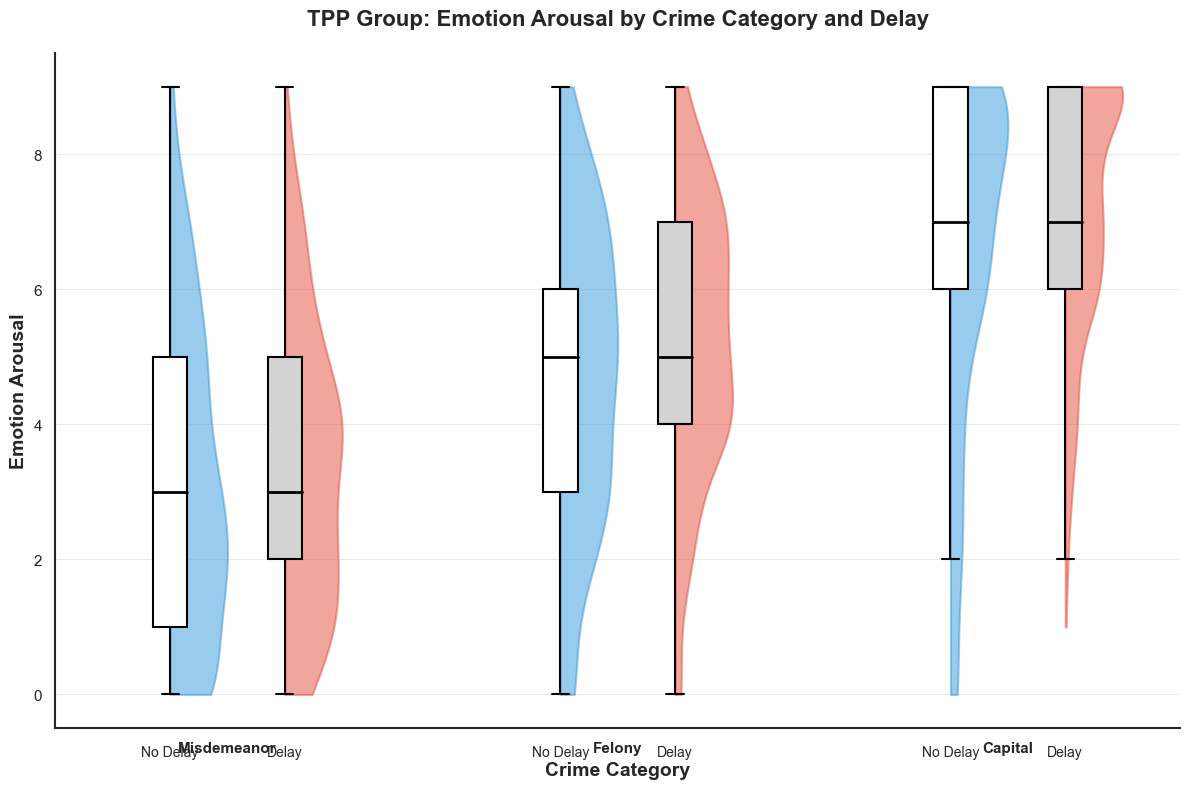


SPP组分析

SPP组显著性检验结果

Misdemeanor:
  Delay: N=234, Mean=2.534, SD=2.070
  No Delay: N=234, Mean=3.594, SD=2.391
  Mann-Whitney U statistic=19980.000, p-value=0.0000
  显著性: ***

Felony:
  Delay: N=234, Mean=5.321, SD=2.598
  No Delay: N=234, Mean=6.038, SD=2.634
  Mann-Whitney U statistic=22755.000, p-value=0.0014
  显著性: **

Capital:
  Delay: N=234, Mean=8.068, SD=1.366
  No Delay: N=234, Mean=7.979, SD=2.046
  Mann-Whitney U statistic=24456.000, p-value=0.0239
  显著性: *
图片已保存至: SPP_group_emotion_arousal.png


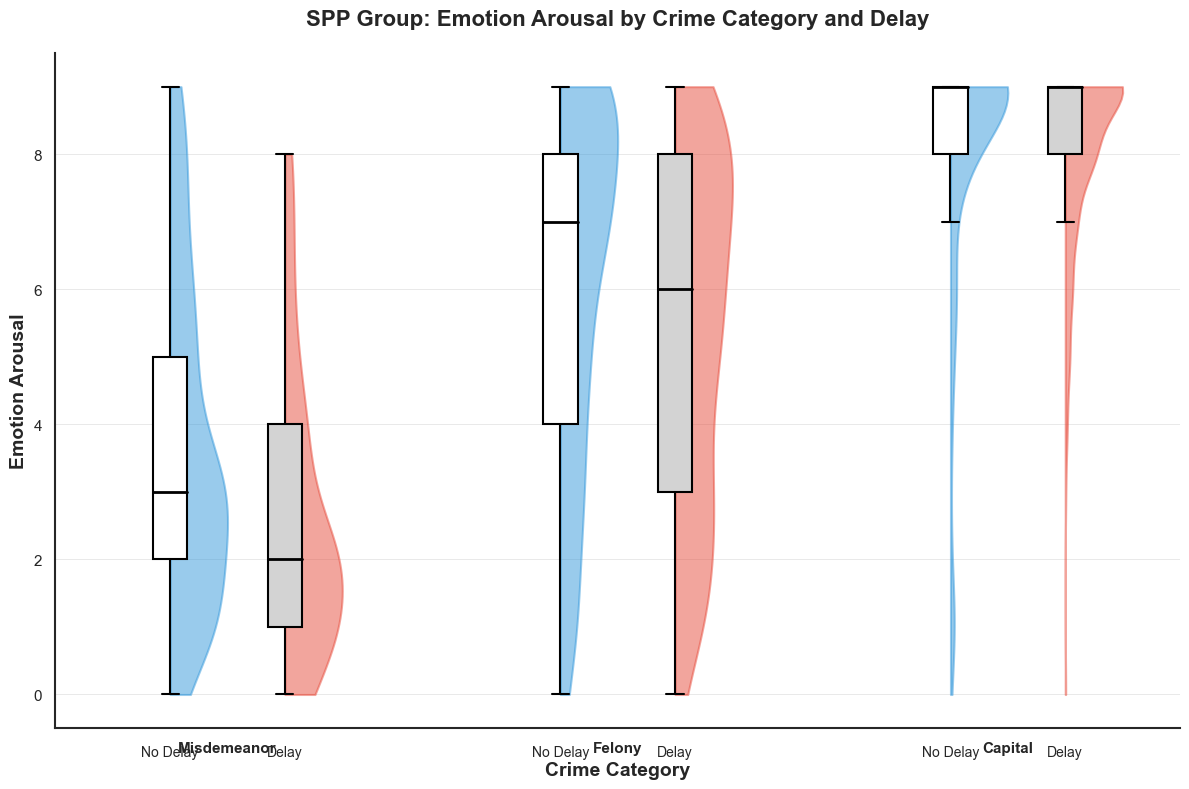


TPP vs SPP 组间差异分析

Misdemeanor - No Delay:
  TPP: N=270, Mean=3.041, SD=2.254
  SPP: N=234, Mean=3.594, SD=2.391
  Mann-Whitney U statistic=27716.500, p-value=0.0165
  显著性: *

Misdemeanor - Delay:
  TPP: N=270, Mean=3.311, SD=2.093
  SPP: N=234, Mean=2.534, SD=2.070
  Mann-Whitney U statistic=38905.500, p-value=0.0000
  显著性: ***

Felony - No Delay:
  TPP: N=270, Mean=4.667, SD=2.268
  SPP: N=234, Mean=6.038, SD=2.634
  Mann-Whitney U statistic=21132.500, p-value=0.0000
  显著性: ***

Felony - Delay:
  TPP: N=270, Mean=5.219, SD=2.017
  SPP: N=234, Mean=5.321, SD=2.598
  Mann-Whitney U statistic=30053.000, p-value=0.3422
  显著性: ns

Capital - No Delay:
  TPP: N=270, Mean=6.537, SD=2.491
  SPP: N=234, Mean=7.979, SD=2.046
  Mann-Whitney U statistic=17954.000, p-value=0.0000
  显著性: ***

Capital - Delay:
  TPP: N=270, Mean=7.170, SD=1.825
  SPP: N=234, Mean=8.068, SD=1.366
  Mann-Whitney U statistic=22425.000, p-value=0.0000
  显著性: ***

组间差异分析完成！结果已保存为CSV文件。

生成TPP vs SPP组间对比图


C:\Users\47648\AppData\Local\Temp\ipykernel_9564\3884384058.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Group', y='Emotion_Arousal',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\3884384058.py:406: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_plot, x='Group', y='Emotion_Arousal',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\3884384058.py:402: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x='Group', y='Emotion_Arousal',
C:\Users\47648\AppData\Local\Temp\ipykernel_9564\3884384058.py:40

组间对比图已保存至: TPP_vs_SPP_comparison.png


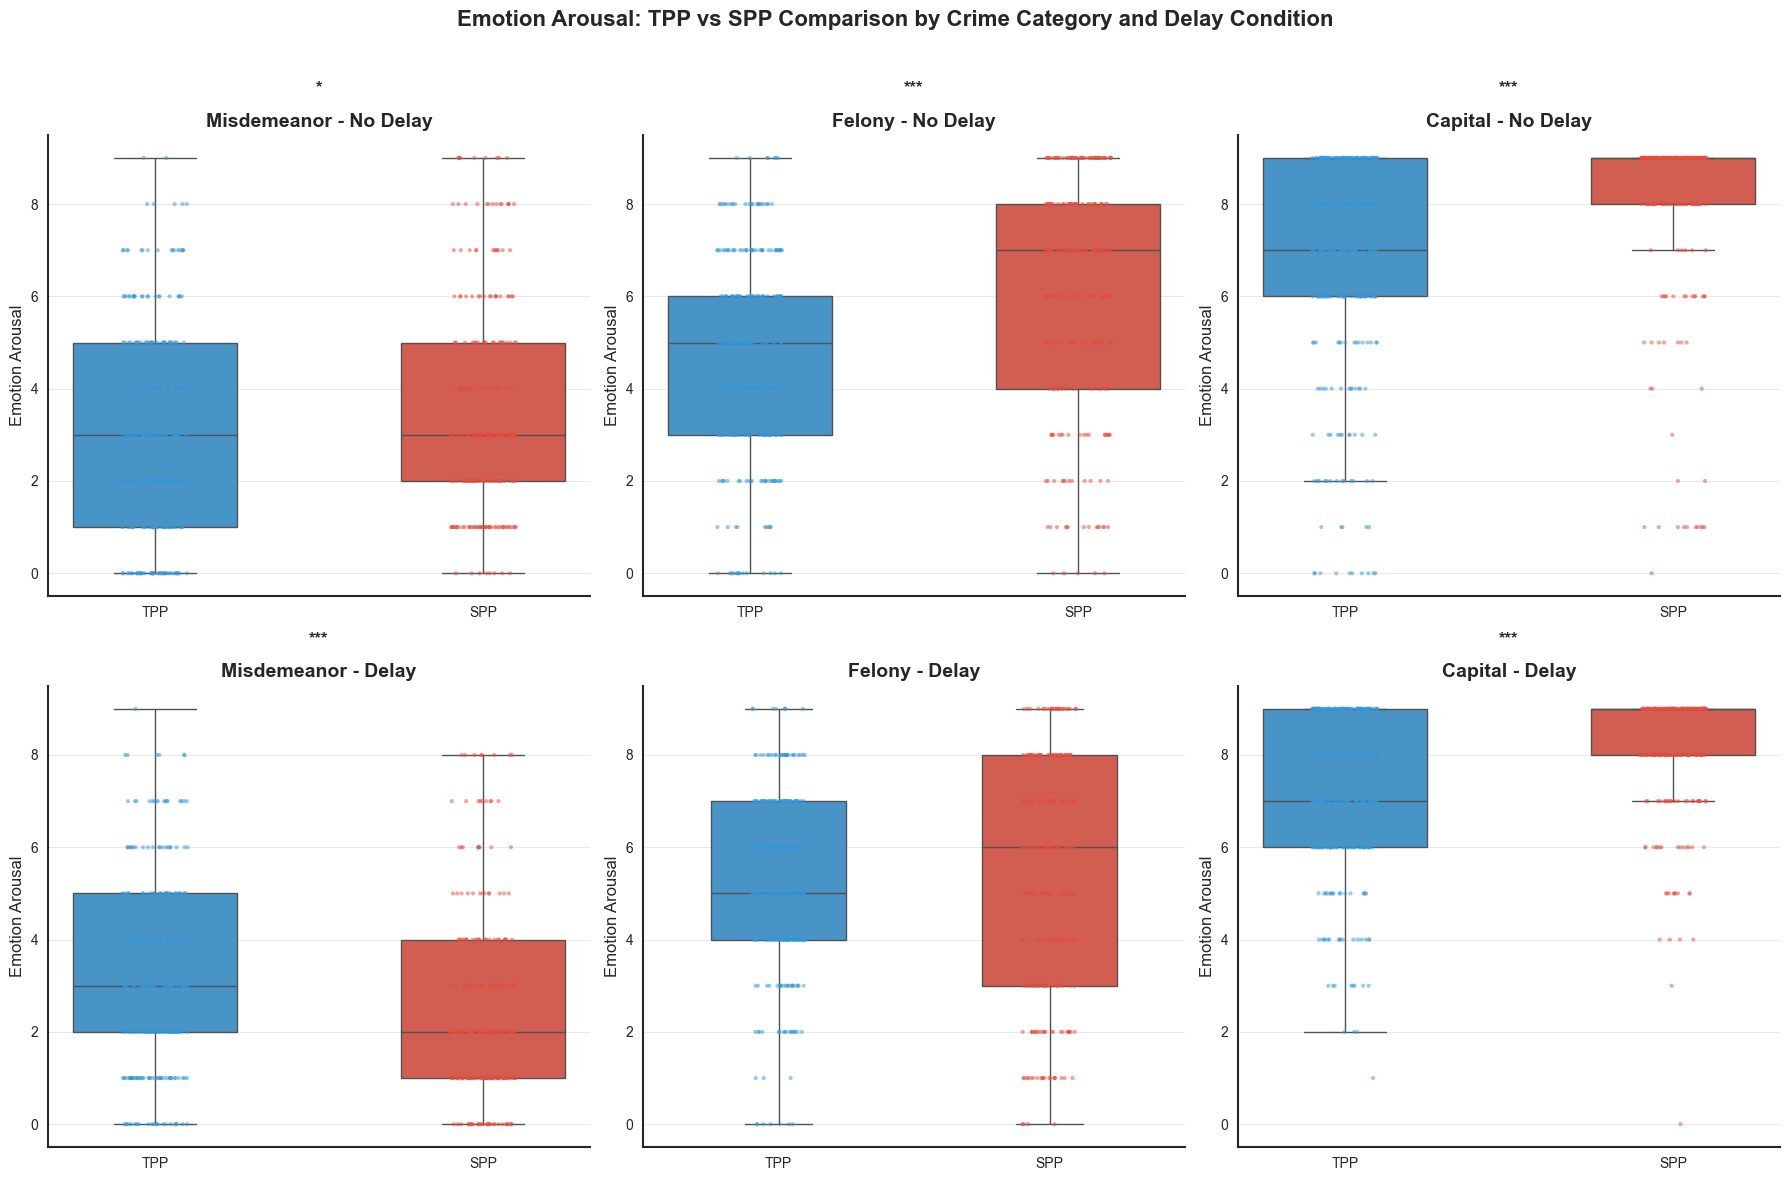


分析完成！情绪唤醒度统计结果已保存为CSV文件。


In [5]:
# --- 4. 执行主逻辑 ---
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 5. 合并数据用于可视化 ---
    tpp_all_data = pd.concat(tpp_cleaned_list, ignore_index=True)
    spp_all_data = pd.concat(spp_cleaned_list, ignore_index=True)

    print(f"TPP组总数据量: {len(tpp_all_data)}")
    print(f"SPP组总数据量: {len(spp_all_data)}")

    # --- 6. 数据准备：添加分类标签 ---
    def prepare_plot_data(df):
        """准备可视化数据，添加分类标签"""
        df = df.copy()
        
        category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
        df['Category_Label'] = df['Category'].map(category_map)
        
        df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
        
        df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
        
        return df

    tpp_plot_data = prepare_plot_data(tpp_all_data)
    spp_plot_data = prepare_plot_data(spp_all_data)

    # --- 7. 显著性检验函数 ---
    def perform_significance_tests(df, group_name):
        """
        对每个Category内的Delay vs No Delay进行Mann-Whitney U检验
        """
        print(f"\n{'='*60}")
        print(f"{group_name}组显著性检验结果")
        print(f"{'='*60}")
        
        results = []
        categories = ['Misdemeanor', 'Felony', 'Capital']
        
        for cat in categories:
            cat_data = df[df['Category_Label'] == cat]
            
            delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Emotion_Arousal'].dropna()
            no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Emotion_Arousal'].dropna()
            
            if len(delay_data) > 0 and len(no_delay_data) > 0:
                statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
                
                delay_mean = delay_data.mean()
                delay_std = delay_data.std()
                no_delay_mean = no_delay_data.mean()
                no_delay_std = no_delay_data.std()
                
                print(f"\n{cat}:")
                print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
                print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
                print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                
                if p_value < 0.001:
                    sig_label = '***'
                elif p_value < 0.01:
                    sig_label = '**'
                elif p_value < 0.05:
                    sig_label = '*'
                else:
                    sig_label = 'ns'
                
                print(f"  显著性: {sig_label}")
                
                results.append({
                    'Category': cat,
                    'Delay_N': len(delay_data),
                    'Delay_Mean': delay_mean,
                    'Delay_SD': delay_std,
                    'NoDelay_N': len(no_delay_data),
                    'NoDelay_Mean': no_delay_mean,
                    'NoDelay_SD': no_delay_std,
                    'U_statistic': statistic,
                    'p_value': p_value,
                    'significance': sig_label
                })
            else:
                print(f"\n{cat}: 数据不足，无法进行检验")
        
        return pd.DataFrame(results)

    # --- 8. 可视化函数 ---
    def create_half_violin_box_plot(df, group_name, save_path=None):
        """
        创建黑白箱线图，右侧贴彩色半个分布图
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # 定义类别顺序
        category_order = ['Misdemeanor', 'Felony', 'Capital']
        delay_order = ['No Delay', 'Delay']
        
        # 定义颜色方案（为分布图使用）
        colors = {
            'No Delay': '#3498db',  # 蓝色
            'Delay': '#e74c3c'      # 红色
        }
        
        # 准备数据
        plot_data = df.dropna(subset=['Emotion_Arousal', 'Category_Label', 'Delay_Label'])
        
        # 创建位置映射 - 缩短间距
        positions = []
        labels = []
        within_gap = 0.5  # 小类之间的间距（No Delay 和 Delay 之间）
        between_gap = 1.2  # 大类之间的间距
        
        current_pos = 0
        for i, cat in enumerate(category_order):
            if i > 0:
                current_pos += between_gap  # 大类之间的间距
            for j, delay in enumerate(delay_order):
                positions.append(current_pos)
                labels.append(delay)
                if j == 0:  # 只在第一个小类后加小间距
                    current_pos += within_gap
        
        # 获取所有数据组
        data_groups = []
        for cat in category_order:
            for delay in delay_order:
                data_groups.append(
                    plot_data[(plot_data['Category_Label'] == cat) & 
                             (plot_data['Delay_Label'] == delay)]['Emotion_Arousal'].values
                )
        
        # 绘制半小提琴图（只显示右侧，彩色）
        for idx, (pos, data, label) in enumerate(zip(positions, data_groups, labels)):
            if len(data) > 0:
                # 计算KDE
                from scipy.stats import gaussian_kde
                try:
                    kde = gaussian_kde(data)
                    y_range = np.linspace(data.min(), data.max(), 100)
                    density = kde(y_range)
                    
                    # 归一化密度到合适的宽度
                    density = density / density.max() * 0.25
                    
                    # 只绘制右侧，使用彩色
                    ax.fill_betweenx(y_range, pos, pos + density, 
                                    alpha=0.5, color=colors[label], 
                                    edgecolor=colors[label], linewidth=1.5)
                except:
                    pass
        
        # 绘制箱线图（黑白配色，更窄的箱体）
        bp = ax.boxplot(
            data_groups,
            positions=positions,
            widths=0.15,  # 箱体宽度
            patch_artist=True,
            showfliers=False,
            medianprops=dict(color='black', linewidth=2),
            boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5)
        )
        
        # 设置箱线图填充
        for i, box in enumerate(bp['boxes']):
            if i % 2 == 0:  # No Delay
                box.set_facecolor('white')
            else:  # Delay
                box.set_facecolor('lightgray')
            box.set_linewidth(1.5)
        
        # 设置x轴 - 计算每个大类的中心位置
        category_centers = []
        for i in range(len(category_order)):
            cat_positions = [positions[i*2], positions[i*2+1]]
            category_centers.append(np.mean(cat_positions))
        
        ax.set_xticks(category_centers)
        ax.set_xticklabels(category_order, fontsize=12, fontweight='bold')
        
        # 在每个大类下添加小标签
        y_min = ax.get_ylim()[0]
        for i in range(len(category_order)):
            ax.text(positions[i*2], y_min - 0.3, 'No Delay', 
                   ha='center', va='top', fontsize=10)
            ax.text(positions[i*2+1], y_min - 0.3, 'Delay', 
                   ha='center', va='top', fontsize=10)
        
        # 设置y轴刻度 - 根据Emotion_Arousal的范围调整
        # 假设Emotion_Arousal的范围也是0-8，如果不是请根据实际数据范围调整
        ax.set_yticks([0, 2, 4, 6, 8])
        ax.set_ylim(-0.5, 9.5)  # 设置y轴范围，留出一些空间
        
        # 添加y轴网格线（仅水平方向）
        ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
        ax.set_axisbelow(True)  # 将网格线放在图形元素下方
        
        # 设置y轴和x轴标签 - 修改y轴标签为Emotion Arousal
        ax.set_ylabel('Emotion Arousal', fontsize=14, fontweight='bold')
        ax.set_xlabel('Crime Category', fontsize=14, fontweight='bold')
        
        # 设置标题 - 更新标题以反映y轴的变化
        ax.set_title(f'{group_name} Group: Emotion Arousal by Crime Category and Delay',
                    fontsize=16, fontweight='bold', pad=20)
        
        # 去掉图例
        
        # 去掉上边框和右边框
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # 保留左边框和下边框，加粗
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        
        # 设置刻度线
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=6)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存至: {save_path}")
        
        plt.show()

    # --- 9. 执行可视化和统计检验 ---
    
    # TPP组
    print("\n" + "="*60)
    print("TPP组分析")
    print("="*60)
    tpp_results = perform_significance_tests(tpp_plot_data, "TPP")
    create_half_violin_box_plot(tpp_plot_data, "TPP", save_path="TPP_group_emotion_arousal.png")
    
    # SPP组
    print("\n" + "="*60)
    print("SPP组分析")
    print("="*60)
    spp_results = perform_significance_tests(spp_plot_data, "SPP")
    create_half_violin_box_plot(spp_plot_data, "SPP", save_path="SPP_group_emotion_arousal.png")
    
        # --- 新增：TPP和SPP组间差异分析 ---
    def perform_group_comparison_by_category(tpp_df, spp_df):
        """
        对每个犯罪类别和延迟条件下的TPP和SPP组进行差异分析
        """
        print("\n" + "="*60)
        print("TPP vs SPP 组间差异分析")
        print("="*60)
        
        results = []
        categories = ['Misdemeanor', 'Felony', 'Capital']
        delay_conditions = ['No Delay', 'Delay']
        
        for cat in categories:
            for delay in delay_conditions:
                # 获取TPP组数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay)
                ]['Emotion_Arousal'].dropna()
                
                # 获取SPP组数据
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay)
                ]['Emotion_Arousal'].dropna()
                
                if len(tpp_data) > 0 and len(spp_data) > 0:
                    # 执行Mann-Whitney U检验
                    statistic, p_value = stats.mannwhitneyu(tpp_data, spp_data, alternative='two-sided')
                    
                    tpp_mean = tpp_data.mean()
                    tpp_std = tpp_data.std()
                    spp_mean = spp_data.mean()
                    spp_std = spp_data.std()
                    
                    print(f"\n{cat} - {delay}:")
                    print(f"  TPP: N={len(tpp_data)}, Mean={tpp_mean:.3f}, SD={tpp_std:.3f}")
                    print(f"  SPP: N={len(spp_data)}, Mean={spp_mean:.3f}, SD={spp_std:.3f}")
                    print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"  显著性: {sig_label}")
                    
                    results.append({
                        'Category': cat,
                        'Delay_Condition': delay,
                        'TPP_N': len(tpp_data),
                        'TPP_Mean': tpp_mean,
                        'TPP_SD': tpp_std,
                        'SPP_N': len(spp_data),
                        'SPP_Mean': spp_mean,
                        'SPP_SD': spp_std,
                        'U_statistic': statistic,
                        'p_value': p_value,
                        'significance': sig_label
                    })
                else:
                    print(f"\n{cat} - {delay}: 数据不足，无法进行检验")
        
        return pd.DataFrame(results)

    # 执行组间比较分析
    group_comparison_results = perform_group_comparison_by_category(tpp_plot_data, spp_plot_data)
    
    # 保存组间比较结果
    group_comparison_results.to_csv("TPP_vs_SPP_comparison_results.csv", index=False)
    
    print("\n" + "="*60)
    print("组间差异分析完成！结果已保存为CSV文件。")
    print("="*60)

    # --- 新增：可视化TPP和SPP的对比 ---
    def create_group_comparison_plot(tpp_df, spp_df, save_path=None):
        """
        创建TPP和SPP组对比图，显示每个小类的情绪唤醒度
        """
        # 设置图形样式
        sns.set_style("white")
        plt.rcParams['font.sans-serif'] = ['Arial']
        plt.rcParams['axes.unicode_minus'] = False
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Emotion Arousal: TPP vs SPP Comparison by Crime Category and Delay Condition', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        categories = ['Misdemeanor', 'Felony', 'Capital']
        delay_conditions = ['No Delay', 'Delay']
        
        # 定义颜色
        group_colors = {'TPP': '#3498db', 'SPP': '#e74c3c'}
        
        for i, delay in enumerate(delay_conditions):
            for j, cat in enumerate(categories):
                ax = axes[i, j]
                
                # 获取数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay)
                ]['Emotion_Arousal'].dropna()
                
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay)
                ]['Emotion_Arousal'].dropna()
                
                # 准备绘图数据
                plot_data = []
                groups = []
                
                if len(tpp_data) > 0:
                    plot_data.extend(tpp_data)
                    groups.extend(['TPP'] * len(tpp_data))
                
                if len(spp_data) > 0:
                    plot_data.extend(spp_data)
                    groups.extend(['SPP'] * len(spp_data))
                
                if len(plot_data) > 0:
                    # 创建数据框
                    df_plot = pd.DataFrame({
                        'Emotion_Arousal': plot_data,
                        'Group': groups
                    })
                    
                    # 绘制箱线图和小提琴图
                    sns.boxplot(data=df_plot, x='Group', y='Emotion_Arousal', 
                                ax=ax, palette=group_colors, width=0.5,
                                showfliers=False)
                    
                    sns.stripplot(data=df_plot, x='Group', y='Emotion_Arousal',
                                 ax=ax, palette=group_colors, alpha=0.5, size=3,
                                 jitter=True)
                    
                    # 添加显著性标记
                    if len(tpp_data) > 0 and len(spp_data) > 0:
                        # 找到对应的p值
                        match = group_comparison_results[
                            (group_comparison_results['Category'] == cat) & 
                            (group_comparison_results['Delay_Condition'] == delay)
                        ]
                        
                        if not match.empty:
                            p_val = match.iloc[0]['p_value']
                            sig_label = match.iloc[0]['significance']
                            
                            if sig_label != 'ns':
                                # 计算位置
                                y_max = max(tpp_data.max(), spp_data.max())
                                y_min = min(tpp_data.min(), spp_data.min())
                                y_range = y_max - y_min
                                
                                # 绘制显著性线和标记
                                line_y = y_max + 0.1 * y_range
                                ax.plot([0, 1], [line_y, line_y], 'k-', linewidth=1.5)
                                ax.text(0.5, line_y + 0.05 * y_range, sig_label, 
                                       ha='center', va='bottom', fontsize=12, fontweight='bold')
                
                # 设置子图标题和标签
                ax.set_title(f'{cat} - {delay}', fontsize=14, fontweight='bold')
                ax.set_xlabel('')
                ax.set_ylabel('Emotion Arousal', fontsize=12)
                
                # 设置y轴范围
                ax.set_ylim(-0.5, 9.5)
                ax.set_yticks([0, 2, 4, 6, 8])
                
                # 添加网格线
                ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)
                ax.set_axisbelow(True)
                
                # 美化边框
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_linewidth(1.5)
                ax.spines['bottom'].set_linewidth(1.5)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"组间对比图已保存至: {save_path}")
        
        plt.show()

    # 执行组间对比可视化
    print("\n" + "="*60)
    print("生成TPP vs SPP组间对比图")
    print("="*60)
    create_group_comparison_plot(tpp_plot_data, spp_plot_data, save_path="TPP_vs_SPP_comparison.png")

    # --- 10. 保存统计结果 ---
    tpp_results.to_csv("TPP_emotion_arousal_results.csv", index=False)
    spp_results.to_csv("SPP_emotion_arousal_results.csv", index=False)
    
    print("\n" + "="*60)
    print("分析完成！情绪唤醒度统计结果已保存为CSV文件。")
    print("="*60)

else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

--- 开始选择案例（已优化排序逻辑）---

对于类别 'Misdemeanor':
  - 找到 9 个独特案例。
  - 最终选择的案例ID: [3, 9, 11, 25, 31, 35, 37, 41, 45]
--------------------
对于类别 'Felony':
  - 找到 9 个独特案例。
  - 最终选择的案例ID: [5, 15, 17, 19, 21, 27, 29, 47, 53]
--------------------
对于类别 'Capital Crime':
  - 找到 9 个独特案例。
  - 最终选择的案例ID: [1, 7, 13, 23, 33, 39, 43, 49, 51]
--------------------

--- 验证每个类别的案例数 ---
Misdemeanor: 9 个独特案例
Felony: 9 个独特案例
Capital Crime: 9 个独特案例

数据准备完成。


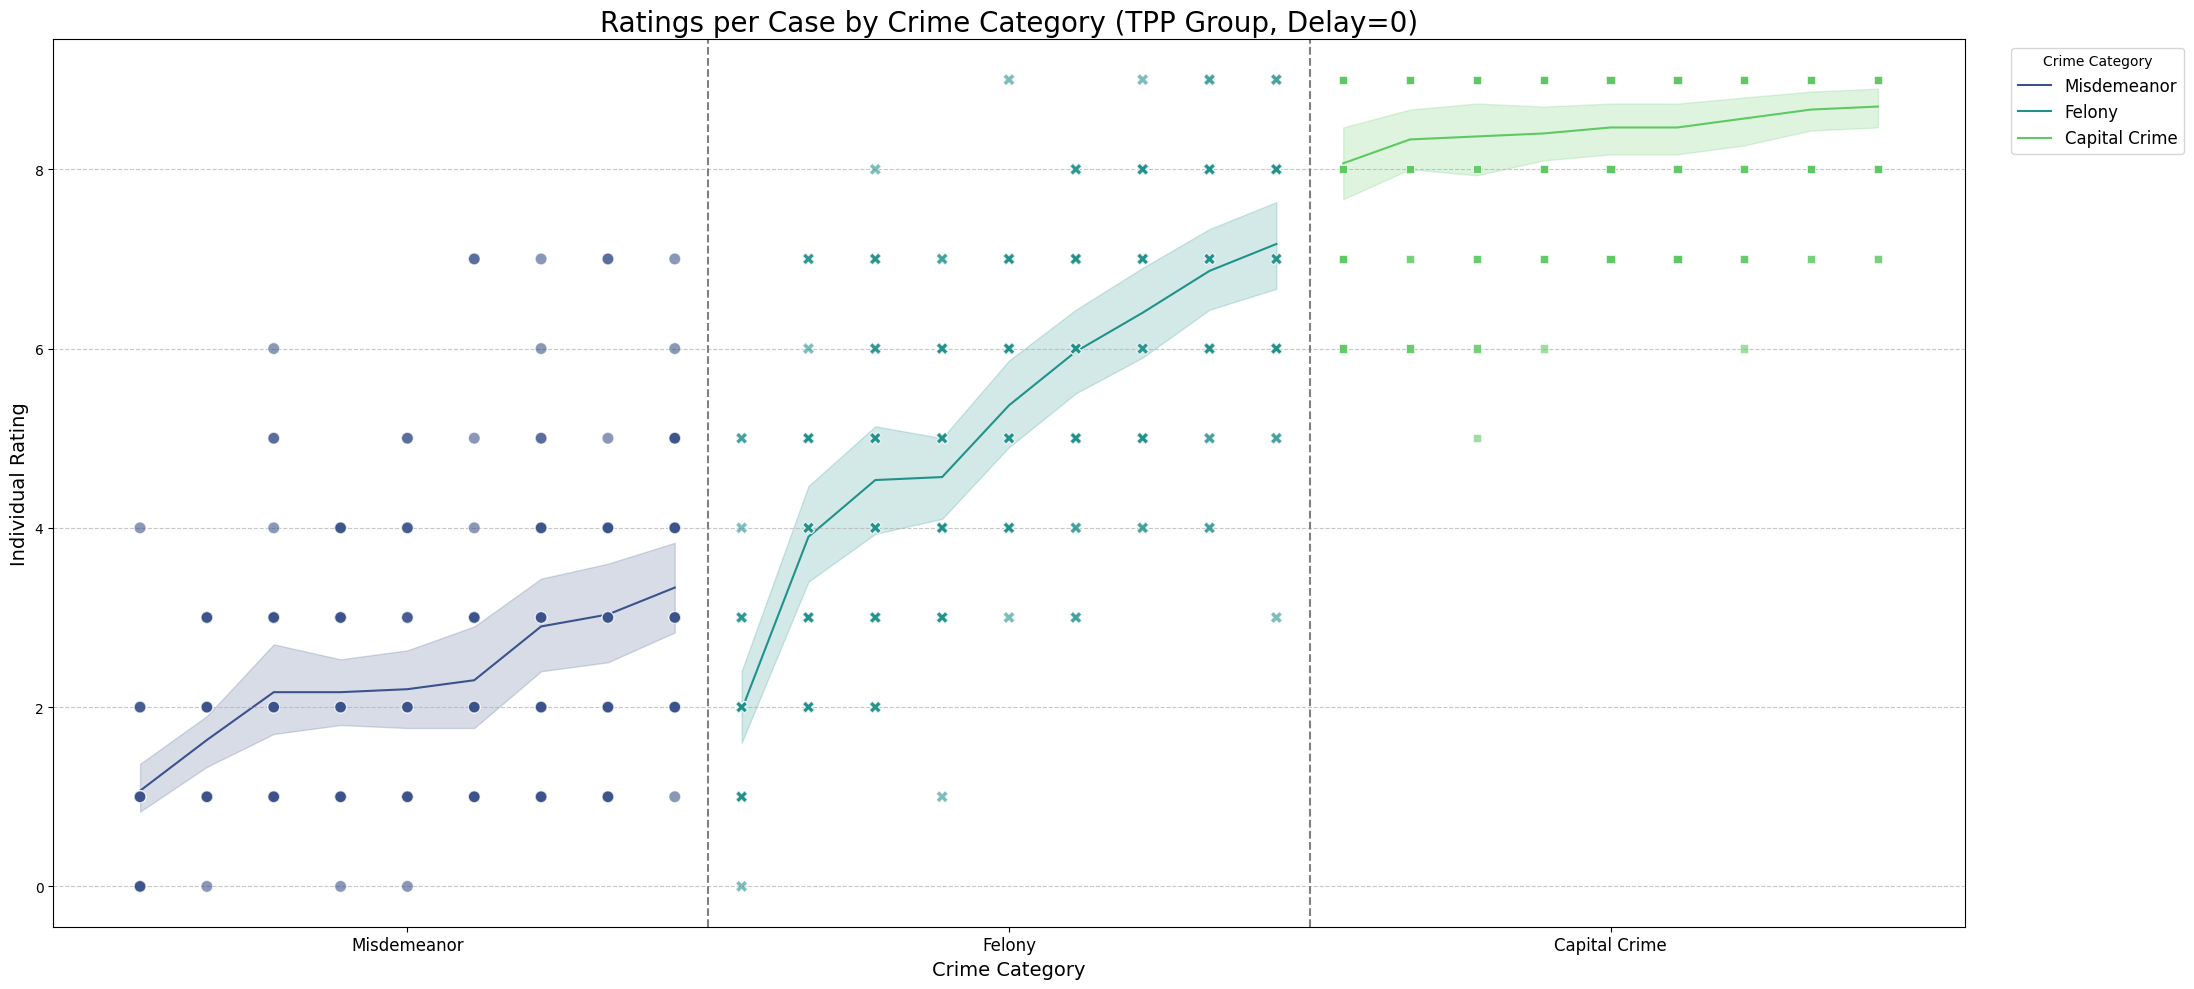

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 步骤 0: 设置绘图环境 ---
# 由于图表将使用英文，我们不再需要特殊设置中文字体。
# 但保留这行以防未来需要，并确保负号正常显示。
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1: 数据准备 (此部分与之前完全相同，无需修改) ---

# 假设之前的代码已运行，df_delay0 已经存在于内存中
# 如果不存在，以下代码会从头创建它
if 'tpp_cleaned_list' not in locals() or not tpp_cleaned_list:
    print("错误：找不到变量 'tpp_cleaned_list'。请先运行数据加载代码。")
    df_delay0 = pd.DataFrame(columns=['Category', 'List2', 'Rating', 'Delay_Info'])
else:
    if 'tpp_df_combined' not in locals():
        tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
        tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
        df_delay0 = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
        df_delay0['Category'] = df_delay0['Category'].astype(int)
        df_delay0['List2'] = df_delay0['List2'].astype(int)
        print("已筛选出 TPP 组中延迟时间为0的数据，共计 {} 条。".format(len(df_delay0)))


# --- 步骤 1: 数据准备 (最终优化版) ---

if 'df_delay0' not in locals() or df_delay0.empty:
    print("错误：找不到或 df_delay0 为空。请先运行之前的数据准备代码。")
    plot_df = pd.DataFrame()
else:
    base_plot_df = df_delay0.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_plot_data_list = []
    case_counts = {}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    
    print("--- 开始选择案例（已优化排序逻辑）---\n")
    
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        unique_cases = category_df['List2'].unique()
        
        # 【核心修改】在切片前对案例ID进行排序！
        # 这确保了我们总是选择ID最小的9个案例，结果可预测。
        sorted_unique_cases = sorted(unique_cases)
        cases_to_plot = sorted_unique_cases[:9]
        
        print(f"对于类别 '{category_name}':")
        print(f"  - 找到 {len(unique_cases)} 个独特案例。")
        if len(unique_cases) < 9:
            print(f"  - 警告: 案例不足9个，将使用全部 {len(unique_cases)} 个。")
        print(f"  - 最终选择的案例ID: {cases_to_plot}")
        print("-" * 20)
        
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_plot_data_list.append(subset_df)

    plot_df = pd.concat(final_plot_data_list, ignore_index=True)

    # --- 【关键修复】改进 x_position 计算逻辑 ---
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    # 计算每个案例的平均评分
    mean_ratings = plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating')
    plot_df = plot_df.merge(mean_ratings, on='List2')
    
    # 更简洁的方法：为每个类别中的每个唯一案例分配排名
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = plot_df[plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    plot_df['x_rank'] = plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    plot_df['x_position'] = plot_df['Category_Name'].map(offsets) + plot_df['x_rank']
    
    # 【新增】计算每个类别的中心位置用于 x 轴刻度
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = plot_df[plot_df['Category_Name'] == category_name]['x_position'].unique()
        category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    # 验证每个类别的案例数
    print("\n--- 验证每个类别的案例数 ---")
    for category_name in sorted_categories:
        unique_cases_in_plot = plot_df[plot_df['Category_Name'] == category_name]['List2'].nunique()
        print(f"{category_name}: {unique_cases_in_plot} 个独特案例")

    print("\n数据准备完成。")

# --- 步骤 2: 数据可视化 (更新 seaborn 参数) ---

if 'plot_df' in locals() and not plot_df.empty:
    plt.figure(figsize=(22, 10))
    palette = sns.color_palette("viridis", n_colors=len(sorted_categories))

    # 【修复】使用新的 errorbar 参数替代已弃用的 ci 参数
    ax = sns.lineplot(data=plot_df, x='x_position', y='Rating', hue='Category_Name', 
                      hue_order=sorted_categories, palette=palette, 
                      errorbar=('ci', 95), marker=None, legend='full', zorder=1)
    sns.scatterplot(data=plot_df, x='x_position', y='Rating', hue='Category_Name', 
                    hue_order=sorted_categories, palette=palette, style='Category_Name', 
                    style_order=sorted_categories, alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    plt.title('Ratings per Case by Crime Category (TPP Group, Delay=0)', fontsize=20)
    plt.xlabel('Crime Category', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    # 【修改】设置 x 轴刻度为类别名称，位置在每个类别的中心
    x_ticks = [category_centers[cat] for cat in sorted_categories]
    x_tick_labels = sorted_categories
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    if labels and labels[0] == 'Category_Name':
        handles = handles[1:]
        labels = labels[1:]
    ax.legend(handles, labels, title='Crime Category', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
    
    # 【修改】在类别之间画分隔线
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout()
    plt.show()
else:
    print("\n由于没有准备好绘图数据，无法生成图表。")


已创建手动微调的颜色映射字典:


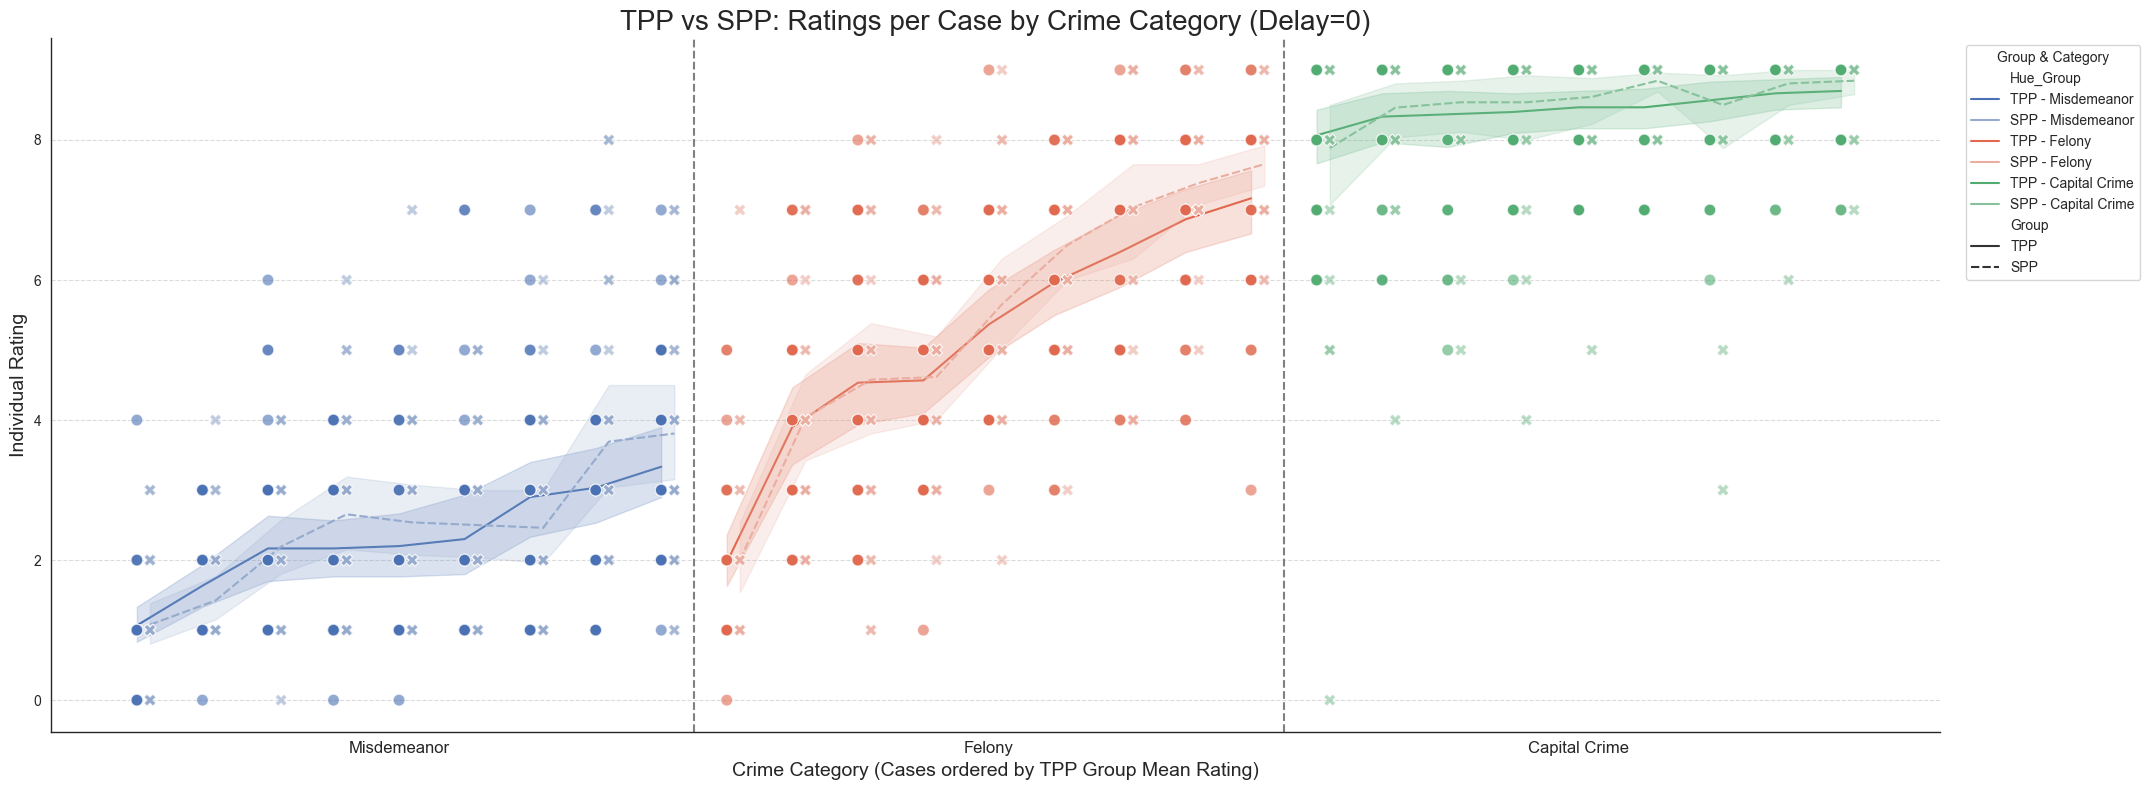

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (与之前完全相同) ---
# (为简洁起见，此处省略了这部分代码的重复显示，假设它已成功运行)
# --- 为了确保代码可以独立运行，我们快速重新执行数据准备逻辑 ---
if 'df_delay0_tpp' not in locals(): df_delay0_tpp = pd.DataFrame()
if 'df_delay0_spp' not in locals(): df_delay0_spp = pd.DataFrame()
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list and df_delay0_tpp.empty:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True); tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce'); df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy(); df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int); df_delay0_tpp['List2'] = df_delay0_tpp['List2'].astype(int)
if 'spp_cleaned_list' in locals() and spp_cleaned_list and df_delay0_spp.empty:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True); spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce'); df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy(); df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int); df_delay0_spp['List2'] = df_delay0_spp['List2'].astype(int)
case_position_map = pd.DataFrame()
if not df_delay0_tpp.empty:
    base_plot_df = df_delay0_tpp.copy(); category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}; sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']; base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    final_tpp_data_list = []; case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]; sorted_unique_cases = sorted(category_df['List2'].unique()); cases_to_plot = sorted_unique_cases[:9]; case_counts[category_name] = len(cases_to_plot); subset_df = category_df[category_df['List2'].isin(cases_to_plot)]; final_tpp_data_list.append(subset_df)
    tpp_plot_df = pd.concat(final_tpp_data_list, ignore_index=True)
    offsets = {}; current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset; current_offset += case_counts.get(category_name, 0)
    mean_ratings_tpp = tpp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_TPP'); tpp_plot_df = tpp_plot_df.merge(mean_ratings_tpp, on='List2')
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = tpp_plot_df[tpp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_TPP']].drop_duplicates(); category_cases = category_cases.sort_values(['Mean_Rating_TPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1): case_rank_map[(category_name, row['List2'])] = rank
    tpp_plot_df['x_rank'] = tpp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1); tpp_plot_df['x_position'] = tpp_plot_df['Category_Name'].map(offsets) + tpp_plot_df['x_rank']
    case_position_map = tpp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()
# --- 数据准备逻辑结束 ---

# --- 步骤 3: 准备最终绘图数据 (与上一版相同) ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    tpp_final = tpp_plot_df.copy(); tpp_final['Group'] = 'TPP'
    spp_final = pd.DataFrame()
    if not df_delay0_spp.empty:
        spp_to_plot = df_delay0_spp.copy(); spp_to_plot['Category_Name'] = spp_to_plot['Category'].map(category_map); spp_final = pd.merge(spp_to_plot, case_position_map, on=['Category_Name', 'List2']); spp_final['Group'] = 'SPP'
    combined_plot_df = pd.concat([tpp_final, spp_final], ignore_index=True)
    jitter_offset = 0.2; spp_indices = combined_plot_df['Group'] == 'SPP'; combined_plot_df.loc[spp_indices, 'x_position'] = combined_plot_df.loc[spp_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 步骤 4: 数据可视化 (核心修改处：手动微调颜色) ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 8))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    tpp_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点
    spp_blue = tweak_color(tpp_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝
    palette_dict['TPP - Misdemeanor'] = tpp_blue
    palette_dict['SPP - Misdemeanor'] = spp_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    tpp_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) 
    spp_orange = tweak_color(tpp_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红
    palette_dict['TPP - Felony'] = tpp_orange
    palette_dict['SPP - Felony'] = spp_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    tpp_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) 
    spp_green = tweak_color(tpp_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿
    palette_dict['TPP - Capital Crime'] = tpp_green
    palette_dict['SPP - Capital Crime'] = spp_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要，可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['TPP', 'SPP']]

    # --- 绘制线图和散点图 (这部分无需改动) ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['TPP', 'SPP'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['TPP', 'SPP'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 自定义图表细节 (与之前相同) ---
    plt.title('TPP vs SPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by TPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
else:
    print("\n没有可用于绘图的数据。")

找到了 56 个数据文件，正在根据被试ID列表分配组别并合并...
所有有效数据文件已成功合并。

原始数据共 3024 行。
移除缺失值后，用于绘图和分析的有效数据共 3024 行。

--- 开始为每个组生成独立的图表 ---
SPP 组 (1404个数据点): r = 0.7529, p-value = 0.0000
TPP 组 (1620个数据点): r = 0.6264, p-value = 0.0000

所有图表已生成。请查看弹出的窗口。


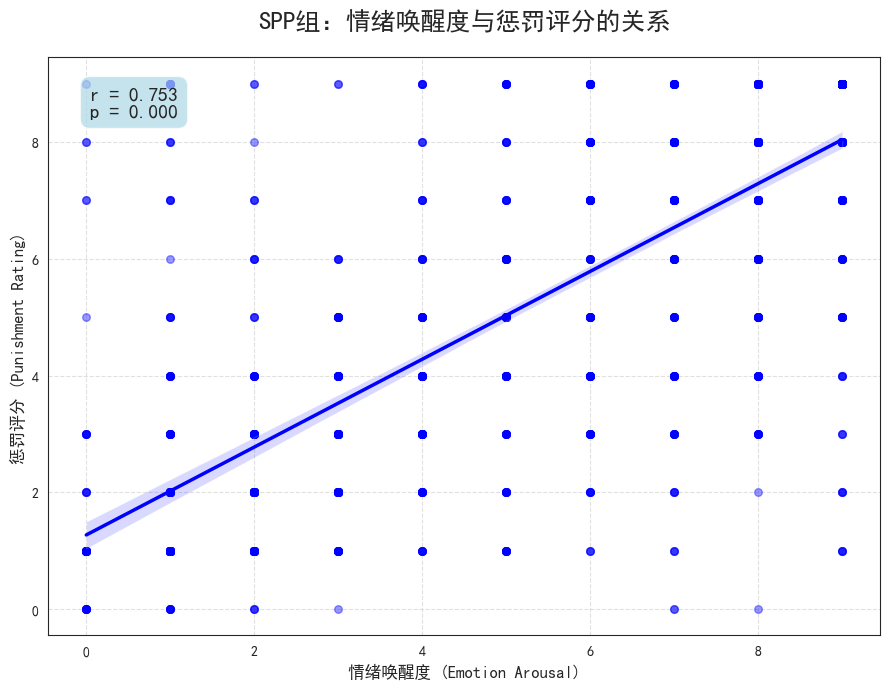

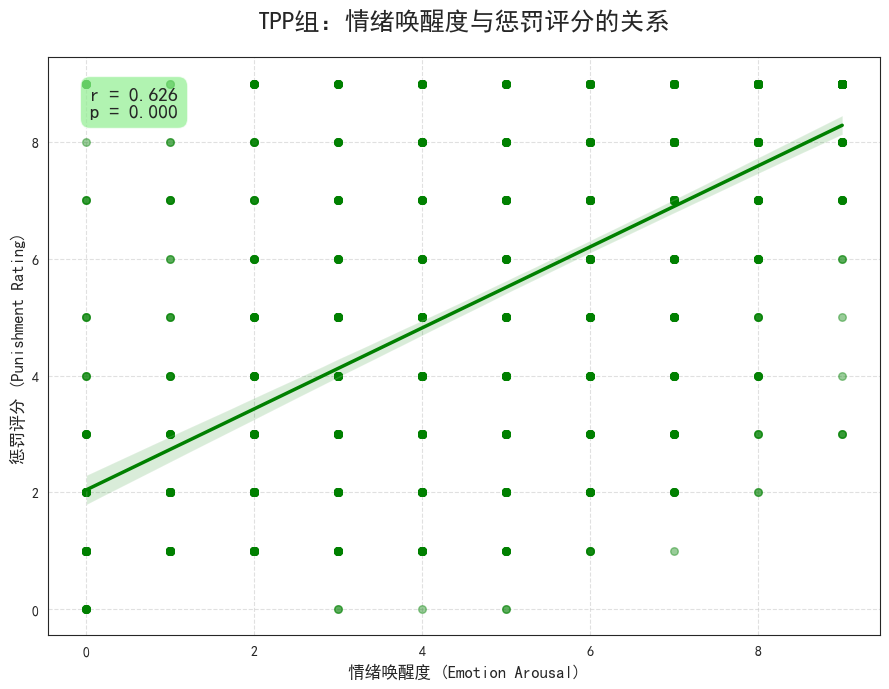

In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# --- 1. 配置 ---

# 被试编号列表 (这是区分组别的唯一依据)
tpp_subjects = [34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67]
spp_subjects = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 68, 70, 71]

# 数据文件所在的目录
BASE_PATH = "./behavioral_result"

# 设置matplotlib以正确显示中文和负号
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置中文字体失败，图形中的中文可能无法正常显示: {e}")
    print("您可以尝试将 'SimHei' 替换为您系统中已安装的其他中文字体，例如 'Microsoft YaHei'。")


# --- 2. 数据加载与整合函数 (已更新) ---

def load_and_merge_data(directory, tpp_ids, spp_ids):
    """
    查找、加载、分配组别并合并指定目录下的所有 'law_*.csv' 文件。
    
    Args:
        directory (str): 包含CSV文件的目录路径。
        tpp_ids (list): TPP组的被试ID列表。
        spp_ids (list): SPP组的被试ID列表。
        
    Returns:
        pandas.DataFrame: 一个包含所有被试数据和正确'Group'列的合并后的DataFrame。
    """
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith('law_') and f.endswith('.csv')]
    
    if not all_files:
        print(f"错误：在目录 '{directory}' 中没有找到任何 'law_*.csv' 文件。")
        return pd.DataFrame()

    print(f"找到了 {len(all_files)} 个数据文件，正在根据被试ID列表分配组别并合并...")
    
    df_list = []
    for file_path in all_files:
        try:
            # 从文件名提取被试ID
            filename = os.path.basename(file_path)
            subject_id_str = filename.replace('law_', '').replace('.csv', '')
            subject_id = int(subject_id_str)
            
            # 根据ID判断组别
            group = None
            if subject_id in tpp_ids:
                group = 'TPP'
            elif subject_id in spp_ids:
                group = 'SPP'
            else:
                print(f"警告：文件 {filename} 的被试ID {subject_id} 不在任何组别列表中，将被忽略。")
                continue # 跳过这个文件

            # 读取CSV并添加'Group'列
            df = pd.read_csv(file_path)
            df['Group'] = group
            df_list.append(df)
            
        except (ValueError, IndexError):
            print(f"警告：无法从文件名 {filename} 中解析被试ID，将被忽略。")
        except Exception as e:
            print(f"读取或处理文件 {file_path} 时出错: {e}")
            
    if not df_list:
        print("错误：所有文件都读取失败或被忽略。")
        return pd.DataFrame()
        
    merged_df = pd.concat(df_list, ignore_index=True)
    print("所有有效数据文件已成功合并。")
    return merged_df


# --- 3. 绘图函数 ---

def plot_group_relationship(data, group_name, color, ax_title):
    """
    为指定组别的数据绘制散点图和回归线。
    
    Args:
        data (pd.DataFrame): 包含单个组别数据的DataFrame。
        group_name (str): 组别名称 (e.g., 'SPP')。
        color (str): 绘图使用的颜色 (e.g., 'blue')。
        ax_title (str): 图表的标题。
    """
    # 创建一个新的图窗
    plt.figure(figsize=(9, 7))
    
    if data.empty or len(data) < 2:
        print(f"{group_name} 组没有有效数据或数据点过少，无法生成图表。")
        plt.title(ax_title, fontsize=18)
        plt.text(0.5, 0.5, '无有效数据', horizontalalignment='center', verticalalignment='center', fontsize=20, color='red')
        plt.xlabel('情绪唤醒度 (Emotion Arousal)', fontsize=12)
        plt.ylabel('惩罚评分 (Punishment Rating)', fontsize=12)
        return

    # 计算相关性
    corr, p_val = pearsonr(data['Emotion_Arousal'], data['Rating'])
    print(f"{group_name} 组 ({len(data)}个数据点): r = {corr:.4f}, p-value = {p_val:.4f}")

    # 使用seaborn绘制回归图
    ax = sns.regplot(
        data=data,
        x='Emotion_Arousal',
        y='Rating',
        color=color,
        scatter_kws={'alpha': 0.4, 's': 30},
        line_kws={'linewidth': 2.5}
    )

    # 添加统计信息文本
    stats_text = f"r = {corr:.3f}\np = {p_val:.3f}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc=f'light{color}', alpha=0.7))

    # 设置标题和标签
    ax.set_title(ax_title, fontsize=18, pad=20)
    ax.set_xlabel('情绪唤醒度 (Emotion Arousal)', fontsize=12)
    ax.set_ylabel('惩罚评分 (Punishment Rating)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # 调整布局以确保所有元素都可见
    plt.tight_layout()


# --- 4. 主逻辑函数 ---

def main():
    """
    主执行函数：加载数据、进行统计分析并生成独立的图表。
    """
    # 步骤 1: 加载并合并数据，传入被试ID列表
    all_data = load_and_merge_data(BASE_PATH, tpp_subjects, spp_subjects)
    if all_data.empty:
        return

    # 步骤 2: 数据准备和清洗
    plot_data = all_data[['Emotion_Arousal', 'Rating', 'Group']].dropna()
    print(f"\n原始数据共 {len(all_data)} 行。")
    print(f"移除缺失值后，用于绘图和分析的有效数据共 {len(plot_data)} 行。")
    
    # 步骤 3: 按组别拆分数据
    spp_data = plot_data[plot_data['Group'] == 'SPP']
    tpp_data = plot_data[plot_data['Group'] == 'TPP']
    
    print("\n--- 开始为每个组生成独立的图表 ---")
    
    # 步骤 4: 为SPP组绘制独立的图表
    plot_group_relationship(
        data=spp_data,
        group_name='SPP',
        color='blue',
        ax_title='SPP组：情绪唤醒度与惩罚评分的关系'
    )
    
    # 步骤 5: 为TPP组绘制独立的图表
    plot_group_relationship(
        data=tpp_data,
        group_name='TPP',
        color='green',
        ax_title='TPP组：情绪唤醒度与惩罚评分的关系'
    )

    # 显示所有创建的图表
    print("\n所有图表已生成。请查看弹出的窗口。")
    plt.show()


# --- 程序入口 ---
if __name__ == "__main__":
    main()

找到了 56 个数据文件，正在根据被试ID列表分配组别并合并...
所有有效数据文件已成功合并。

原始数据共 3024 行。
移除缺失值后，用于绘图和分析的有效数据共 3024 行。

--- 各组相关性分析结果 ---
SPP 组: n = 1404, r = 0.7529, p = 0.0000
TPP 组: n = 1620, r = 0.6264, p = 0.0000

--- 两组相关系数差异的显著性检验 (费雪Z变换) ---
用于比较两个独立相关系数的 Z-statistic: 6.6902
差异显著性的 P值 (双尾): 0.0000

结论: 显著！两组的情绪唤醒度与惩罚评分之间的相关性存在统计学上的显著差异 (p < 0.05)。


--- 开始为两个组生成优化的组合图表 ---
优化后的组合图表已生成。请查看弹出的窗口。


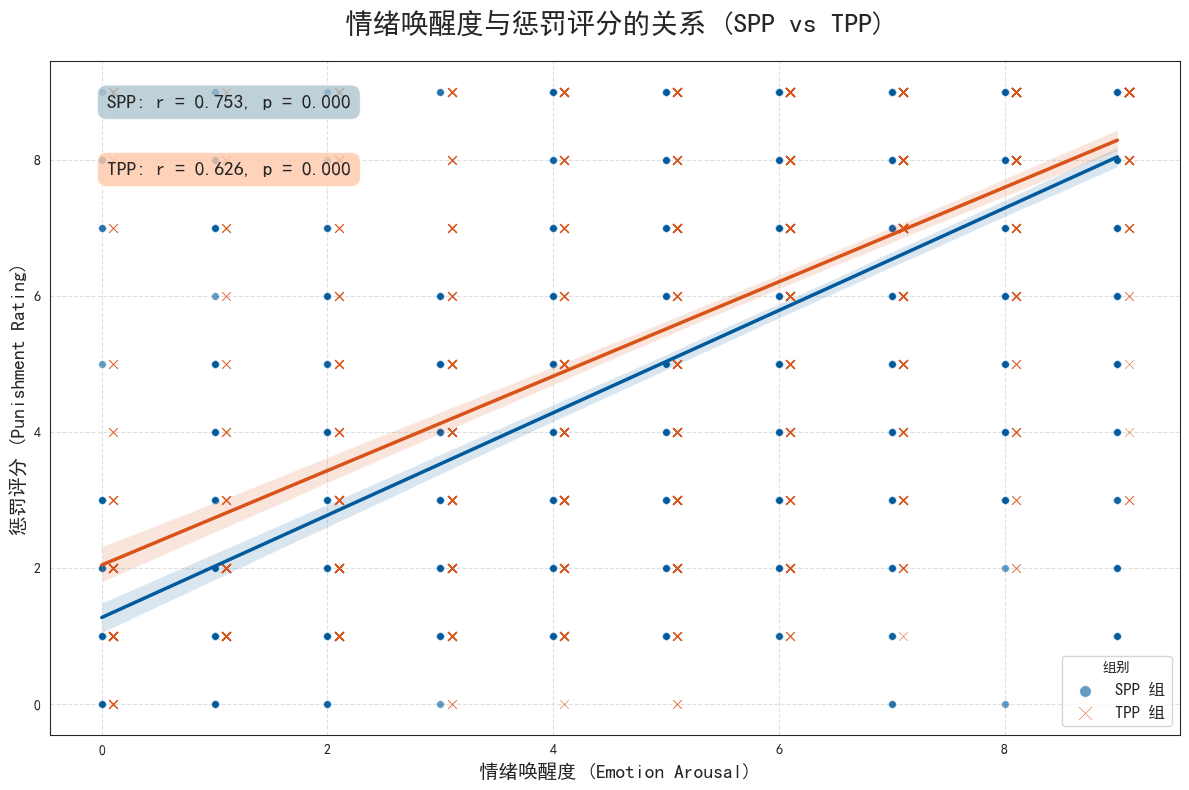

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np  # 新增：用于数学计算 (arctanh, sqrt)
from scipy.stats import norm  # 新增：用于从Z值计算p值

# --- 1. 配置 (与之前相同) ---

# 被试编号列表
tpp_subjects = [34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67]
spp_subjects = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 68, 70, 71]

# 数据文件所在的目录
BASE_PATH = "./behavioral_result"

# 设置matplotlib以正确显示中文和负号
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置中文字体失败，图形中的中文可能无法正常显示: {e}")
    print("您可以尝试将 'SimHei' 替换为您系统中已安装的其他中文字体，例如 'Microsoft YaHei'。")


# --- 2. 数据加载与整合函数 (与之前相同) ---

def load_and_merge_data(directory, tpp_ids, spp_ids):
    """
    查找、加载、分配组别并合并指定目录下的所有 'law_*.csv' 文件。
    """
    all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.startswith('law_') and f.endswith('.csv')]
    
    if not all_files:
        print(f"错误：在目录 '{directory}' 中没有找到任何 'law_*.csv' 文件。")
        return pd.DataFrame()

    print(f"找到了 {len(all_files)} 个数据文件，正在根据被试ID列表分配组别并合并...")
    
    df_list = []
    for file_path in all_files:
        try:
            filename = os.path.basename(file_path)
            subject_id_str = filename.replace('law_', '').replace('.csv', '')
            subject_id = int(subject_id_str)
            
            group = None
            if subject_id in tpp_ids:
                group = 'TPP'
            elif subject_id in spp_ids:
                group = 'SPP'
            else:
                print(f"警告：文件 {filename} 的被试ID {subject_id} 不在任何组别列表中，将被忽略。")
                continue

            df = pd.read_csv(file_path)
            df['Group'] = group
            df_list.append(df)
            
        except (ValueError, IndexError):
            print(f"警告：无法从文件名 {filename} 中解析被试ID，将被忽略。")
        except Exception as e:
            print(f"读取或处理文件 {file_path} 时出错: {e}")
            
    if not df_list:
        print("错误：所有文件都读取失败或被忽略。")
        return pd.DataFrame()
        
    merged_df = pd.concat(df_list, ignore_index=True)
    print("所有有效数据文件已成功合并。")
    return merged_df


# --- 新增：比较两个独立相关系数的函数 ---
def compare_correlations(r1, n1, r2, n2):
    """
    使用费雪Z变换比较两个独立样本的相关系数r1和r2。
    
    Args:
        r1 (float): 第一个样本的相关系数。
        n1 (int): 第一个样本的大小。
        r2 (float): 第二个样本的相关系数。
        n2 (int): 第二个样本的大小。
        
    Returns:
        tuple: (z_statistic, p_value)
    """
    # 检查样本量是否足够进行变换（n>3是必须的）
    if n1 <= 3 or n2 <= 3:
        print("警告：一个或两个组的样本量不足（n<=3），无法进行相关系数比较。")
        return np.nan, np.nan

    # 步骤1: 费雪r-to-z变换
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    
    # 步骤2: 计算差值的标准误
    se_diff = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
    
    # 步骤3: 计算Z-statistic
    z_stat = (z1 - z2) / se_diff
    
    # 步骤4: 计算双尾p值
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    
    return z_stat, p_value


# --- 3. 经过优化的组合绘图函数 (与之前相同) ---

def plot_combined_graph_optimized(spp_data, tpp_data, tpp_offset=0.1):
    """
    在同一张图上绘制SPP和TPP两组的散点图和回归线，并进行美化。
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    print("\n--- 开始为两个组生成优化的组合图表 ---")

    spp_color = '#005A9C'
    tpp_color = '#D95319'

    if not spp_data.empty and len(spp_data) >= 2:
        corr_spp, p_spp = pearsonr(spp_data['Emotion_Arousal'], spp_data['Rating'])
        sns.regplot(data=spp_data, x='Emotion_Arousal', y='Rating', color=spp_color,
                    scatter=False, line_kws={'linewidth': 2.5}, ax=ax)
        sns.scatterplot(data=spp_data, x='Emotion_Arousal', y='Rating', color=spp_color,
                        marker='o', s=30, alpha=0.6, label='SPP 组', ax=ax)
        stats_text_spp = f"SPP: r = {corr_spp:.3f}, p = {p_spp:.3f}"
        ax.text(0.05, 0.95, stats_text_spp, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='#AEC6CF', alpha=0.8))

    if not tpp_data.empty and len(tpp_data) >= 2:
        corr_tpp, p_tpp = pearsonr(tpp_data['Emotion_Arousal'], tpp_data['Rating'])
        sns.regplot(data=tpp_data, x='Emotion_Arousal', y='Rating', color=tpp_color,
                    scatter=False, line_kws={'linewidth': 2.5}, ax=ax)
        sns.scatterplot(x=tpp_data['Emotion_Arousal'] + tpp_offset, y=tpp_data['Rating'], color=tpp_color,
                        marker='x', s=40, alpha=0.7, label='TPP 组', ax=ax)
        stats_text_tpp = f"TPP: r = {corr_tpp:.3f}, p = {p_tpp:.3f}"
        ax.text(0.05, 0.85, stats_text_tpp, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='#FFC9A9', alpha=0.8))

    ax.set_title('情绪唤醒度与惩罚评分的关系 (SPP vs TPP)', fontsize=20, pad=20)
    ax.set_xlabel('情绪唤醒度 (Emotion Arousal)', fontsize=14)
    ax.set_ylabel('惩罚评分 (Punishment Rating)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12, title='组别', markerscale=1.5)
    plt.tight_layout()


# --- 4. 主逻辑函数 (已更新，增加统计比较部分) ---

def main():
    """
    主执行函数：加载数据、进行统计分析、比较相关性并生成图表。
    """
    # 步骤 1: 加载并合并数据
    all_data = load_and_merge_data(BASE_PATH, tpp_subjects, spp_subjects)
    if all_data.empty:
        return

    # 步骤 2: 数据准备和清洗
    plot_data = all_data[['Emotion_Arousal', 'Rating', 'Group']].dropna()
    print(f"\n原始数据共 {len(all_data)} 行。")
    print(f"移除缺失值后，用于绘图和分析的有效数据共 {len(plot_data)} 行。")
    
    # 步骤 3: 按组别拆分数据
    spp_data = plot_data[plot_data['Group'] == 'SPP']
    tpp_data = plot_data[plot_data['Group'] == 'TPP']
    
    # 检查每组是否有足够的数据进行分析
    if len(spp_data) < 3 or len(tpp_data) < 3:
        print("\n错误：一个或两个组的数据点少于3个，无法进行有效的相关性分析和比较。")
        return

    # --- 新增：计算并打印每组的相关性 ---
    corr_spp, p_spp = pearsonr(spp_data['Emotion_Arousal'], spp_data['Rating'])
    corr_tpp, p_tpp = pearsonr(tpp_data['Emotion_Arousal'], tpp_data['Rating'])
    n_spp = len(spp_data)
    n_tpp = len(tpp_data)

    print("\n" + "="*50)
    print("--- 各组相关性分析结果 ---")
    print(f"SPP 组: n = {n_spp}, r = {corr_spp:.4f}, p = {p_spp:.4f}")
    print(f"TPP 组: n = {n_tpp}, r = {corr_tpp:.4f}, p = {p_tpp:.4f}")
    print("="*50)

    # --- 新增：比较两组相关系数的差异 ---
    z_statistic, p_value_difference = compare_correlations(corr_spp, n_spp, corr_tpp, n_tpp)
    
    print("\n" + "="*50)
    print("--- 两组相关系数差异的显著性检验 (费雪Z变换) ---")
    if not np.isnan(z_statistic):
        print(f"用于比较两个独立相关系数的 Z-statistic: {z_statistic:.4f}")
        print(f"差异显著性的 P值 (双尾): {p_value_difference:.4f}")
        
        if p_value_difference < 0.05:
            print("\n结论: 显著！两组的情绪唤醒度与惩罚评分之间的相关性存在统计学上的显著差异 (p < 0.05)。")
        else:
            print("\n结论: 不显著。两组的相关性没有统计学上的显著差异 (p >= 0.05)。")
    print("="*50 + "\n")


    # 步骤 4: 调用绘图函数
    plot_combined_graph_optimized(spp_data, tpp_data, tpp_offset=0.1)

    # 显示图表
    print("优化后的组合图表已生成。请查看弹出的窗口。")
    plt.show()


# --- 程序入口 ---
if __name__ == "__main__":
    main()

In [23]:
import pandas as pd
import re

# 读取CSV文件
df = pd.read_csv('./DeepSeek-V3-Fast_without_emotional.csv')
crime_df = pd.read_csv('./final_crime_data.csv')

# 1. 提取List2 (从case_id中提取id)
def extract_id(case_id):
    match = re.search(r'CSV_(\d+)', str(case_id))
    if match:
        return int(match.group(1))
    return None

df['List2'] = df['case_id'].apply(extract_id)

# 2. 从final_crime_data.csv中获取Category
# 创建序号到Category的映射
category_map = dict(zip(crime_df['序号'], crime_df['Category']))
df['Category'] = df['List2'].map(category_map)

# 3. Rating直接从score列获取
df['Rating'] = df['score']

# 4. 转换Delay_Info (将delay_time转换为以年为单位的数字)
def convert_delay_to_years(delay_str):
    if pd.isna(delay_str) or delay_str == '':
        return 0
    
    delay_str = str(delay_str).strip()
    
    # 如果是"当时"
    if '当时' in delay_str:
        return 0
    
    # 汉字数字到阿拉伯数字的映射
    chinese_num_map = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4,
        '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '两': 2
    }
    
    years = 0
    months = 0
    
    # 处理年
    year_match = re.search(r'([零一二三四五六七八九十两]+)年', delay_str)
    if year_match:
        year_str = year_match.group(1)
        # 转换汉字数字
        if year_str in chinese_num_map:
            years = chinese_num_map[year_str]
        elif '十' in year_str:
            if year_str == '十':
                years = 10
            elif year_str.startswith('十'):
                years = 10 + chinese_num_map.get(year_str[1], 0)
            else:
                tens = chinese_num_map.get(year_str[0], 0)
                if len(year_str) == 2:  # 如x十
                    years = tens * 10
                else:  # 如x十y
                    ones = chinese_num_map.get(year_str[2], 0)
                    years = tens * 10 + ones
    
    # 处理月
    month_match = re.search(r'([零一二三四五六七八九十两]+)个月', delay_str)
    if month_match:
        month_str = month_match.group(1)
        # 转换汉字数字
        if month_str in chinese_num_map:
            months = chinese_num_map[month_str]
        elif '十' in month_str:
            if month_str == '十':
                months = 10
            elif month_str.startswith('十'):
                months = 10 + chinese_num_map.get(month_str[1], 0)
            else:
                tens = chinese_num_map.get(month_str[0], 0)
                if len(month_str) == 2:
                    months = tens * 10
                else:
                    ones = chinese_num_map.get(month_str[2], 0)
                    months = tens * 10 + ones
    
    # 转换为年（月除以12）
    total_years = years + (months / 12.0)
    return total_years

df['Delay_Info'] = df['delay_time'].apply(convert_delay_to_years)

# 5. Emotion直接从emotional_arousal列获取
df['Emotion'] = df['emotional_arousal']

# 6. Role直接从role列获取
df['Role'] = df['role']

# 选择需要的列
result_df = df[['List2', 'Category', 'Rating', 'Delay_Info', 'Emotion', 'Role']]

# 保存结果
result_df.to_csv('./organized_data.csv', index=False, encoding='utf-8-sig')

print("数据整理完成！")
print("\n前几行预览:")
print(result_df.head(10))
print("\n数据统计信息:")
print(result_df.describe())
print("\nCategory分布:")
print(result_df['Category'].value_counts())
print("\nRole分布:")
print(result_df['Role'].value_counts())

数据整理完成！

前几行预览:
   List2  Category  Rating  Delay_Info  Emotion Role
0      1       3.0       9         0.0        9  SPP
1      1       3.0       9         0.0        9  SPP
2      1       3.0       9         0.0        9  SPP
3      1       3.0       9         0.0        9  SPP
4      1       3.0       9         0.0        9  SPP
5      1       3.0       9         0.0        9  SPP
6      1       3.0       9         0.0        9  SPP
7      1       3.0       9         0.0        9  SPP
8      1       3.0       9         0.0        9  SPP
9      1       3.0       9         0.0        9  SPP

数据统计信息:
             List2     Category       Rating   Delay_Info      Emotion
count  2160.000000  2160.000000  2160.000000  2160.000000  2160.000000
mean     27.500000     2.000000     6.182407     3.402778     6.223611
std      15.589393     0.816686     2.608652     6.422977     2.109441
min       1.000000     1.000000     0.000000     0.000000     0.000000
25%      14.000000     1.000000     4


已创建手动微调的颜色映射字典:


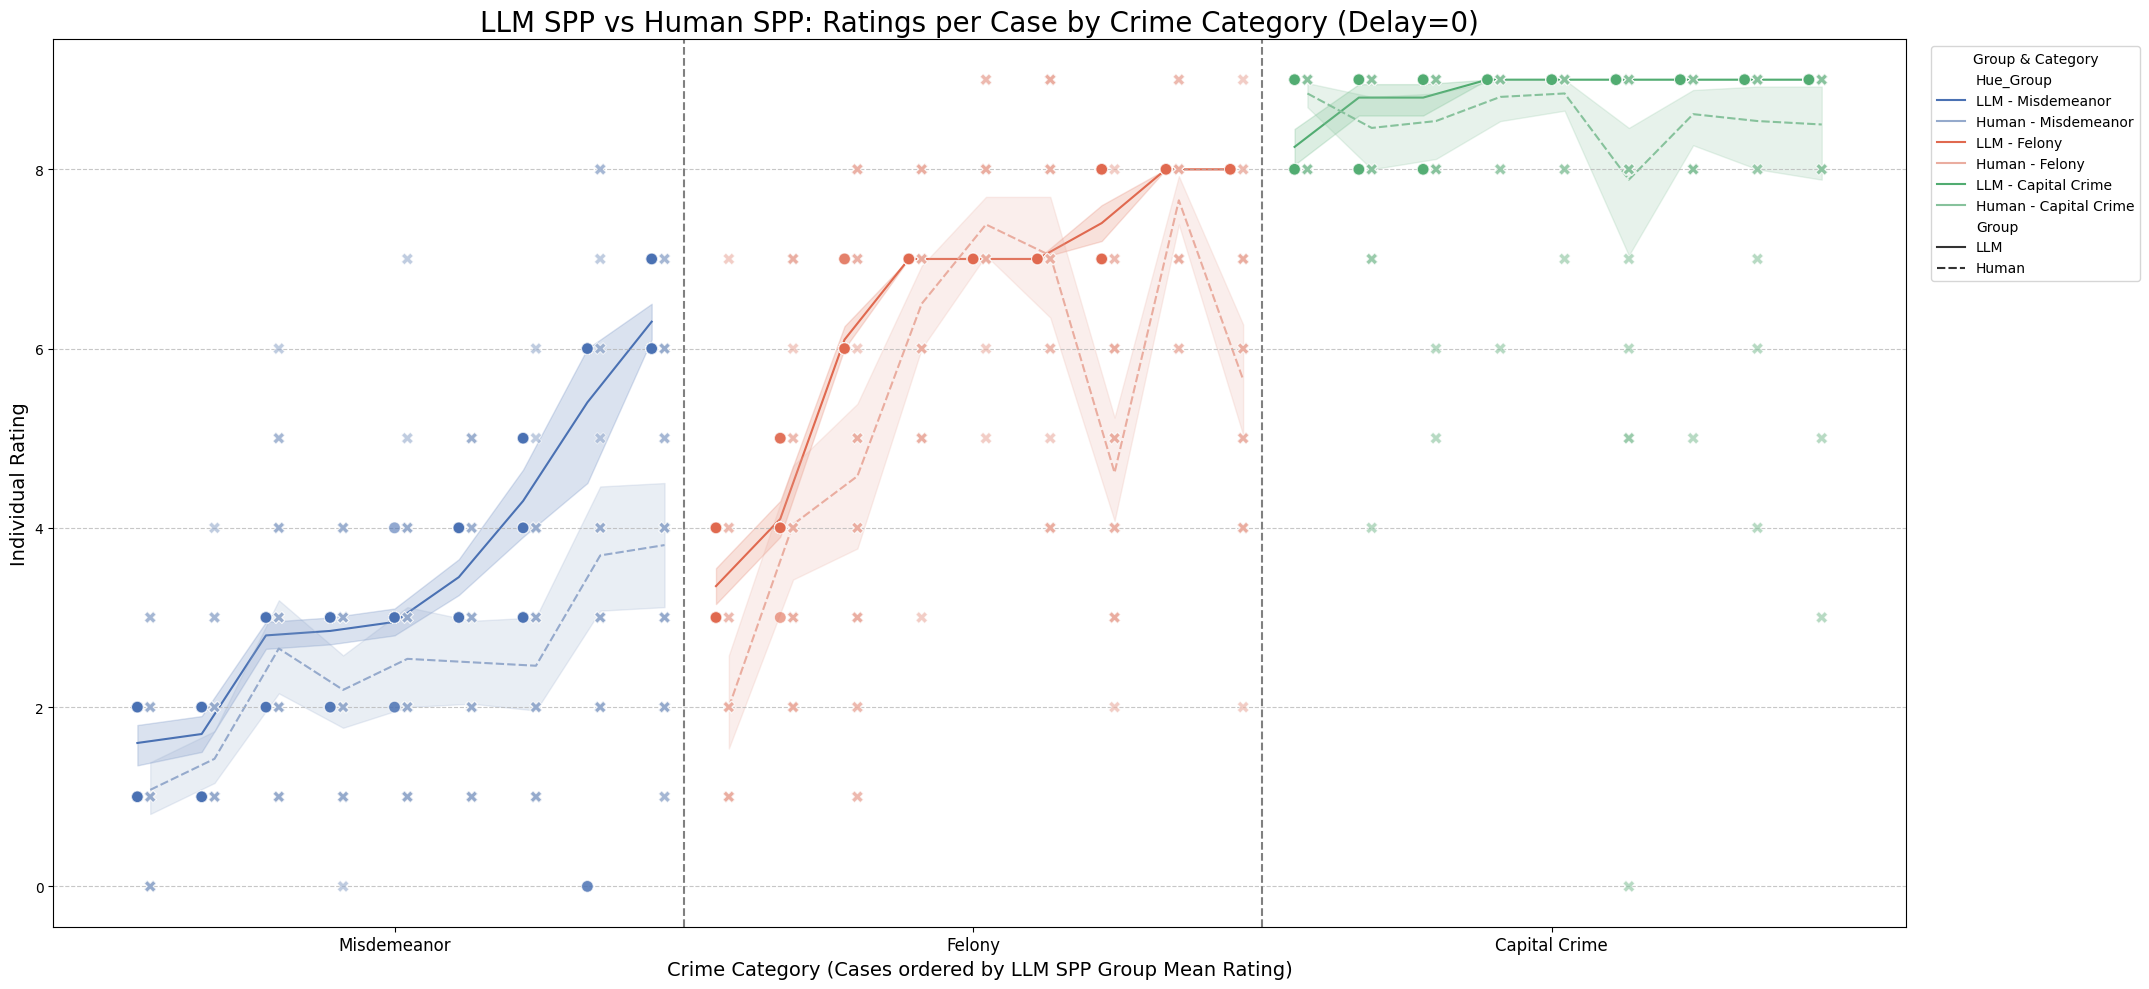

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的SPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的SPP数据（作为基准）
df_llm_spp = df_llm[df_llm['Role'] == 'SPP'].copy()
df_llm_spp['Delay_Num'] = pd.to_numeric(df_llm_spp['Delay_Info'], errors='coerce')
df_delay0_spp_llm = df_llm_spp[df_llm_spp['Delay_Num'] == 0.0].copy()
df_delay0_spp_llm['Category'] = df_delay0_spp_llm['Category'].astype(int)
df_delay0_spp_llm['List2'] = df_delay0_spp_llm['List2'].astype(int)

# 准备人的SPP数据
if 'df_delay0_spp' not in locals(): df_delay0_spp = pd.DataFrame()
if 'spp_cleaned_list' in locals() and spp_cleaned_list and df_delay0_spp.empty:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    df_delay0_spp['List2'] = df_delay0_spp['List2'].astype(int)

# 建立基准坐标系（基于LLM的SPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_spp_llm.empty:
    base_plot_df = df_delay0_spp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_spp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_spp_data_list.append(subset_df)
    
    llm_spp_plot_df = pd.concat(final_llm_spp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    mean_ratings_llm_spp = llm_spp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_LLM_SPP')
    llm_spp_plot_df = llm_spp_plot_df.merge(mean_ratings_llm_spp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_spp_plot_df[llm_spp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_LLM_SPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating_LLM_SPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_spp_plot_df['x_rank'] = llm_spp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_spp_plot_df['x_position'] = llm_spp_plot_df['Category_Name'].map(offsets) + llm_spp_plot_df['x_rank']
    
    case_position_map = llm_spp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的SPP数据
    llm_spp_final = llm_spp_plot_df.copy()
    llm_spp_final['Group'] = 'LLM'
    
    # 人的SPP数据
    human_spp_final = pd.DataFrame()
    if not df_delay0_spp.empty:
        human_spp_to_plot = df_delay0_spp.copy()
        human_spp_to_plot['Category_Name'] = human_spp_to_plot['Category'].map(category_map)
        human_spp_final = pd.merge(human_spp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_spp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_spp_final, human_spp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 自定义图表细节 ---
    plt.title('LLM SPP vs Human SPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM SPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()
else:
    print("\n没有可用于绘图的数据。")


已创建手动微调的颜色映射字典:


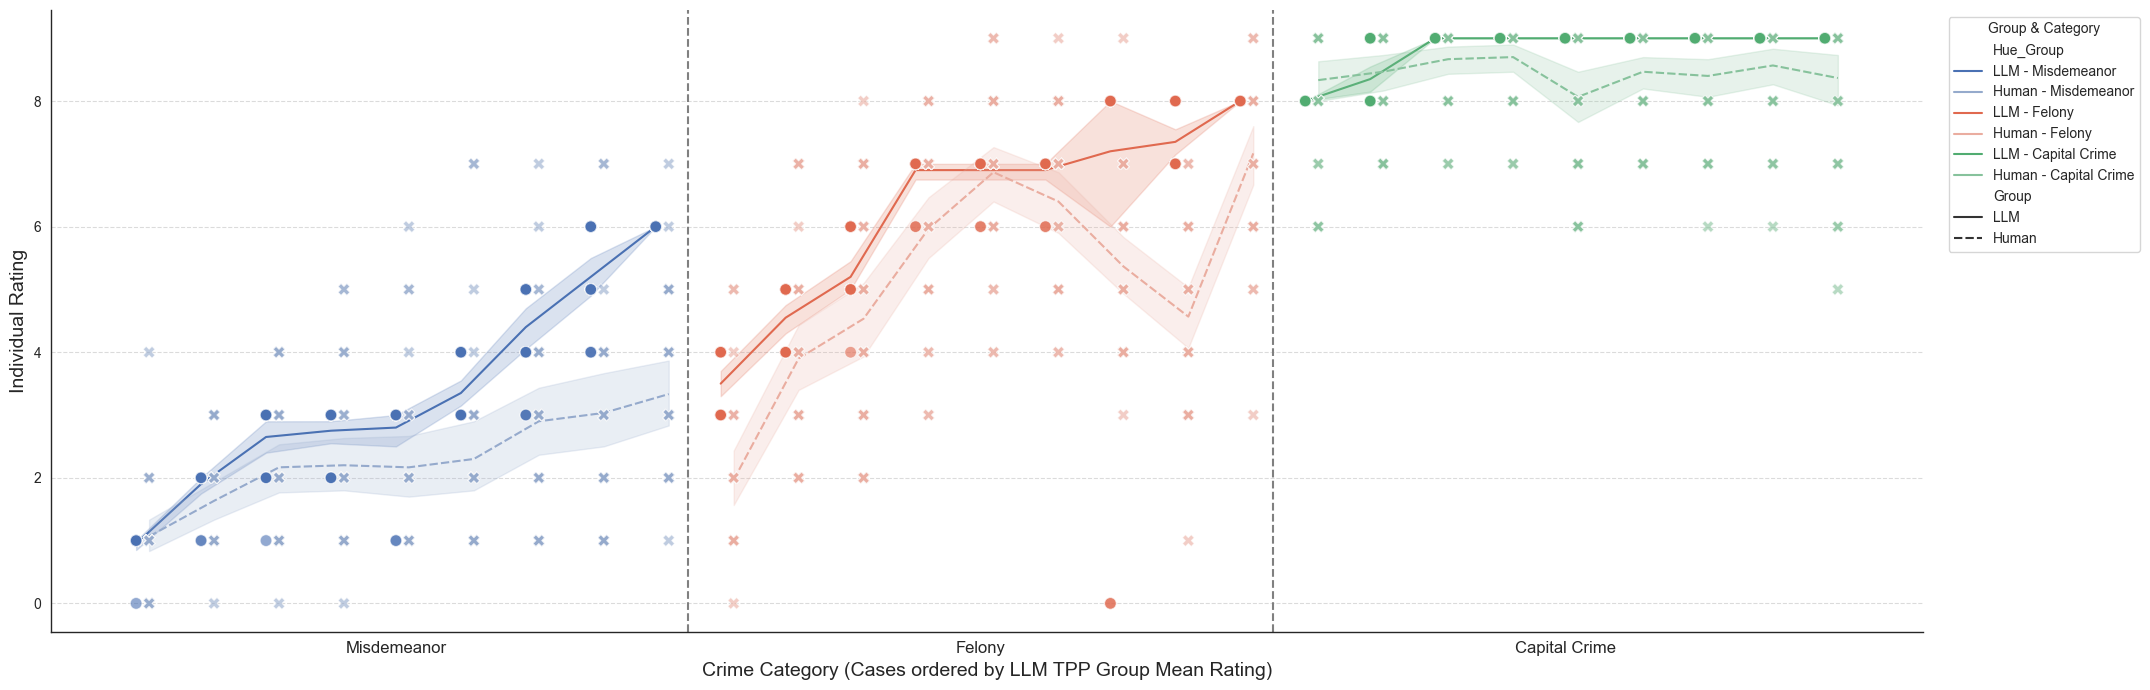

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的TPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的TPP数据（作为基准）
df_llm_tpp = df_llm[df_llm['Role'] == 'TPP'].copy()
df_llm_tpp['Delay_Num'] = pd.to_numeric(df_llm_tpp['Delay_Info'], errors='coerce')
df_delay0_tpp_llm = df_llm_tpp[df_llm_tpp['Delay_Num'] == 0.0].copy()
df_delay0_tpp_llm['Category'] = df_delay0_tpp_llm['Category'].astype(int)
df_delay0_tpp_llm['List2'] = df_delay0_tpp_llm['List2'].astype(int)

# 准备人的TPP数据
if 'df_delay0_tpp' not in locals(): df_delay0_tpp = pd.DataFrame()
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list and df_delay0_tpp.empty:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['List2'] = df_delay0_tpp['List2'].astype(int)

# 建立基准坐标系（基于LLM的TPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_tpp_llm.empty:
    base_plot_df = df_delay0_tpp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_tpp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_tpp_data_list.append(subset_df)
    
    llm_tpp_plot_df = pd.concat(final_llm_tpp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    mean_ratings_llm_tpp = llm_tpp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_LLM_TPP')
    llm_tpp_plot_df = llm_tpp_plot_df.merge(mean_ratings_llm_tpp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_tpp_plot_df[llm_tpp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_LLM_TPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating_LLM_TPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_tpp_plot_df['x_rank'] = llm_tpp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_tpp_plot_df['x_position'] = llm_tpp_plot_df['Category_Name'].map(offsets) + llm_tpp_plot_df['x_rank']
    
    case_position_map = llm_tpp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的TPP数据
    llm_tpp_final = llm_tpp_plot_df.copy()
    llm_tpp_final['Group'] = 'LLM'
    
    # 人的TPP数据
    human_tpp_final = pd.DataFrame()
    if not df_delay0_tpp.empty:
        human_tpp_to_plot = df_delay0_tpp.copy()
        human_tpp_to_plot['Category_Name'] = human_tpp_to_plot['Category'].map(category_map)
        human_tpp_final = pd.merge(human_tpp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_tpp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_tpp_final, human_tpp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 自定义图表细节 ---
    # plt.title('LLM TPP vs Human TPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM TPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

成功加载LLM数据，共 2160 行。
数据列名: ['List2', 'Category', 'Rating', 'Delay_Info', 'Emotion', 'Role']

LLM原始数据共 2160 行。
Delay=0的数据共 1080 行。
移除缺失值后，用于绘图和分析的有效数据共 1080 行。
LLM SPP组数据: 540 行
LLM TPP组数据: 540 行

--- LLM各组相关性分析结果 ---
LLM SPP组: n = 540, r = 0.9283, p = 0.0000
LLM TPP组: n = 540, r = 0.9348, p = 0.0000

--- LLM两组相关系数差异的显著性检验 (费雪Z变换) ---
Z-statistic: -0.8106
P值 (双尾): 0.4176

结论: 不显著。LLM两组的相关性没有统计学上的显著差异 (p >= 0.05)。


--- 开始为LLM两个组生成组合图表 ---
LLM组合图表已生成。请查看弹出的窗口。


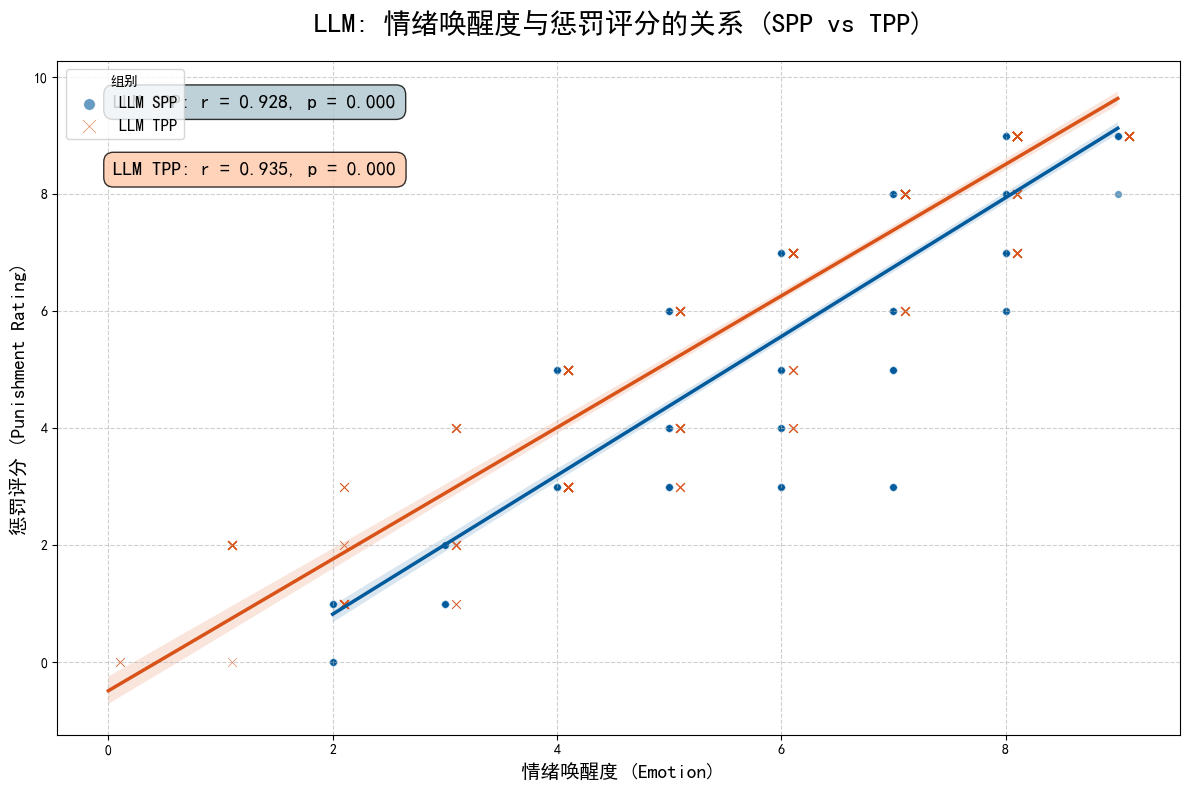

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import norm

# --- 1. 配置 ---

# 设置matplotlib以正确显示中文和负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# LLM数据文件路径
LLM_DATA_PATH = './organized_data.csv'

# --- 2. 数据加载函数 ---

def load_llm_data(file_path):
    """
    加载LLM的数据文件
    """
    try:
        df = pd.read_csv(file_path)
        print(f"成功加载LLM数据，共 {len(df)} 行。")
        print(f"数据列名: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"加载LLM数据时出错: {e}")
        return pd.DataFrame()


# --- 3. 比较两个独立相关系数的函数 ---

def compare_correlations(r1, n1, r2, n2):
    """
    使用费雪Z变换比较两个独立样本的相关系数r1和r2。
    
    Args:
        r1 (float): 第一个样本的相关系数。
        n1 (int): 第一个样本的大小。
        r2 (float): 第二个样本的相关系数。
        n2 (int): 第二个样本的大小。
        
    Returns:
        tuple: (z_statistic, p_value)
    """
    if n1 <= 3 or n2 <= 3:
        print("警告：一个或两个组的样本量不足（n<=3），无法进行相关系数比较。")
        return np.nan, np.nan

    # 费雪r-to-z变换
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)
    
    # 计算差值的标准误
    se_diff = np.sqrt(1 / (n1 - 3) + 1 / (n2 - 3))
    
    # 计算Z-statistic
    z_stat = (z1 - z2) / se_diff
    
    # 计算双尾p值
    p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    
    return z_stat, p_value


# --- 4. 组合绘图函数 ---

def plot_llm_combined_graph(spp_data, tpp_data, tpp_offset=0.1):
    """
    在同一张图上绘制LLM的SPP和TPP两组的散点图和回归线
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    print("\n--- 开始为LLM两个组生成组合图表 ---")

    # 使用不同的颜色
    spp_color = '#005A9C'  # 深蓝色
    tpp_color = '#D95319'  # 橙红色

    # 绘制SPP组
    if not spp_data.empty and len(spp_data) >= 2:
        corr_spp, p_spp = pearsonr(spp_data['Emotion'], spp_data['Rating'])
        
        # 回归线
        sns.regplot(data=spp_data, x='Emotion', y='Rating', color=spp_color,
                    scatter=False, line_kws={'linewidth': 2.5}, ax=ax)
        
        # 散点
        sns.scatterplot(data=spp_data, x='Emotion', y='Rating', color=spp_color,
                        marker='o', s=30, alpha=0.6, label='LLM SPP', ax=ax)
        
        # 统计信息
        stats_text_spp = f"LLM SPP: r = {corr_spp:.3f}, p = {p_spp:.3f}"
        ax.text(0.05, 0.95, stats_text_spp, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', 
                bbox=dict(boxstyle='round,pad=0.5', fc='#AEC6CF', alpha=0.8))

    # 绘制TPP组
    if not tpp_data.empty and len(tpp_data) >= 2:
        corr_tpp, p_tpp = pearsonr(tpp_data['Emotion'], tpp_data['Rating'])
        
        # 回归线
        sns.regplot(data=tpp_data, x='Emotion', y='Rating', color=tpp_color,
                    scatter=False, line_kws={'linewidth': 2.5}, ax=ax)
        
        # 散点（添加小偏移避免重叠）
        sns.scatterplot(x=tpp_data['Emotion'] + tpp_offset, 
                        y=tpp_data['Rating'], color=tpp_color,
                        marker='x', s=40, alpha=0.7, label='LLM TPP', ax=ax)
        
        # 统计信息
        stats_text_tpp = f"LLM TPP: r = {corr_tpp:.3f}, p = {p_tpp:.3f}"
        ax.text(0.05, 0.85, stats_text_tpp, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', 
                bbox=dict(boxstyle='round,pad=0.5', fc='#FFC9A9', alpha=0.8))

    # 图表美化
    ax.set_title('LLM: 情绪唤醒度与惩罚评分的关系 (SPP vs TPP)', fontsize=20, pad=20)
    ax.set_xlabel('情绪唤醒度 (Emotion)', fontsize=14)
    ax.set_ylabel('惩罚评分 (Punishment Rating)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=12, title='组别', markerscale=1.5)
    plt.tight_layout()


# --- 5. 主逻辑函数 ---

def main():
    """
    主执行函数：加载LLM数据、进行统计分析、比较相关性并生成图表。
    """
    # 步骤 1: 加载LLM数据
    llm_data = load_llm_data(LLM_DATA_PATH)
    if llm_data.empty:
        print("错误：无法加载LLM数据。")
        return

    # 步骤 2: 数据准备和清洗
    # 确保Delay_Info列是数值类型
    llm_data['Delay_Num'] = pd.to_numeric(llm_data['Delay_Info'], errors='coerce')
    
    # 筛选Delay=0的数据
    llm_delay0 = llm_data[llm_data['Delay_Num'] == 0.0].copy()
    
    # 准备绘图数据（使用Emotion列而非Emotion_Arousal）
    plot_data = llm_delay0[['Emotion', 'Rating', 'Role']].dropna()
    
    print(f"\nLLM原始数据共 {len(llm_data)} 行。")
    print(f"Delay=0的数据共 {len(llm_delay0)} 行。")
    print(f"移除缺失值后，用于绘图和分析的有效数据共 {len(plot_data)} 行。")
    
    # 步骤 3: 按Role拆分数据
    spp_data = plot_data[plot_data['Role'] == 'SPP']
    tpp_data = plot_data[plot_data['Role'] == 'TPP']
    
    print(f"LLM SPP组数据: {len(spp_data)} 行")
    print(f"LLM TPP组数据: {len(tpp_data)} 行")
    
    # 检查每组是否有足够的数据
    if len(spp_data) < 3 or len(tpp_data) < 3:
        print("\n错误：一个或两个组的数据点少于3个，无法进行有效的相关性分析。")
        return

    # 步骤 4: 计算并打印每组的相关性
    corr_spp, p_spp = pearsonr(spp_data['Emotion'], spp_data['Rating'])
    corr_tpp, p_tpp = pearsonr(tpp_data['Emotion'], tpp_data['Rating'])
    n_spp = len(spp_data)
    n_tpp = len(tpp_data)

    print("\n" + "="*60)
    print("--- LLM各组相关性分析结果 ---")
    print(f"LLM SPP组: n = {n_spp}, r = {corr_spp:.4f}, p = {p_spp:.4f}")
    print(f"LLM TPP组: n = {n_tpp}, r = {corr_tpp:.4f}, p = {p_tpp:.4f}")
    print("="*60)

    # 步骤 5: 比较两组相关系数的差异
    z_statistic, p_value_difference = compare_correlations(corr_spp, n_spp, corr_tpp, n_tpp)
    
    print("\n" + "="*60)
    print("--- LLM两组相关系数差异的显著性检验 (费雪Z变换) ---")
    if not np.isnan(z_statistic):
        print(f"Z-statistic: {z_statistic:.4f}")
        print(f"P值 (双尾): {p_value_difference:.4f}")
        
        if p_value_difference < 0.05:
            print("\n结论: 显著！LLM两组的情绪唤醒度与惩罚评分之间的相关性")
            print("      存在统计学上的显著差异 (p < 0.05)。")
        else:
            print("\n结论: 不显著。LLM两组的相关性没有统计学上的显著差异 (p >= 0.05)。")
    print("="*60 + "\n")

    # 步骤 6: 绘图
    plot_llm_combined_graph(spp_data, tpp_data, tpp_offset=0.1)

    print("LLM组合图表已生成。请查看弹出的窗口。")
    plt.show()


# --- 程序入口 ---
if __name__ == "__main__":
    main()

=== 大模型 vs 人类参与者 评分差异显著性检验 ===

按x轴顺序的显著性检验结果:
x_pos  Category        Case   LLM_Mean Human_Mean t-stat   p-value    Sig.
--------------------------------------------------------------------------------
1.0    Misdemeanor     3      0.95     1.07       -0.81    0.4231     ns
2.0    Misdemeanor     9      1.90     1.63       1.64     0.1095     ns
3.0    Misdemeanor     45     2.65     2.17       2.03     0.0478     *
4.0    Misdemeanor     11     2.75     2.20       2.26     0.0292     *
5.0    Misdemeanor     35     2.80     2.17       2.19     0.0339     *
6.0    Misdemeanor     37     3.35     2.30       3.33     0.0020     **
7.0    Misdemeanor     41     4.40     2.90       4.63     0.0000     ***
8.0    Misdemeanor     31     5.20     3.03       6.66     0.0000     ***
9.0    Misdemeanor     25     6.00     3.33       10.10    0.0000     ***
10.0   Felony          19     3.50     1.97       6.37     0.0000     ***
11.0   Felony          17     4.55     3.90       2.17     0.0363 

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\381234555.py:127: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


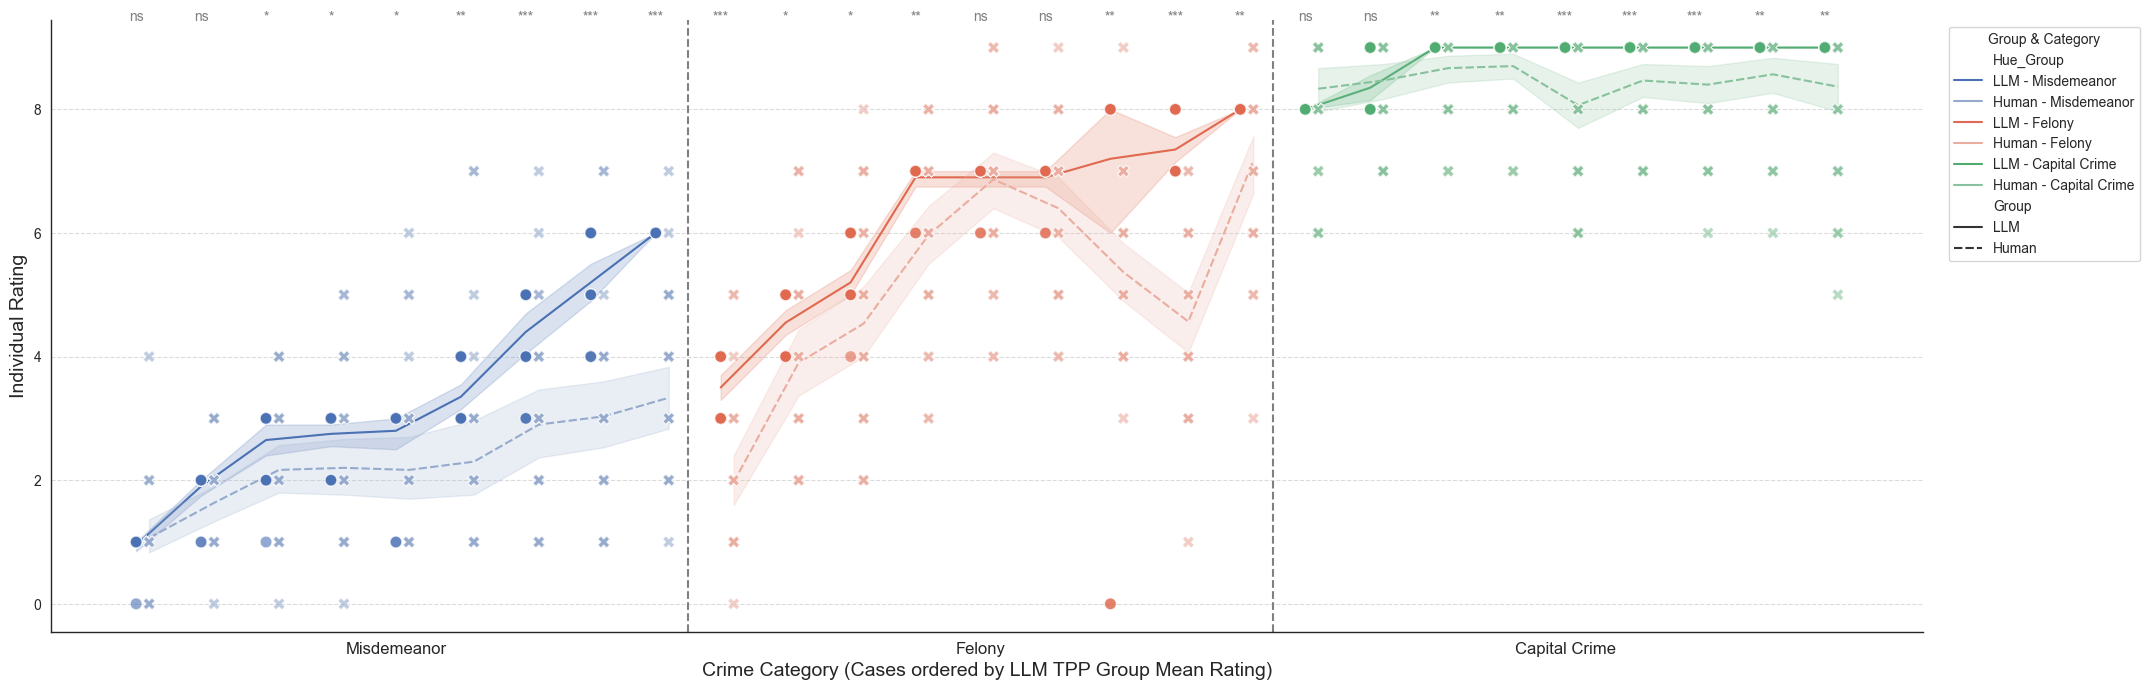

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库
from scipy import stats  # 添加统计检验库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的TPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的TPP数据（作为基准）
df_llm_tpp = df_llm[df_llm['Role'] == 'TPP'].copy()
df_llm_tpp['Delay_Num'] = pd.to_numeric(df_llm_tpp['Delay_Info'], errors='coerce')
df_delay0_tpp_llm = df_llm_tpp[df_llm_tpp['Delay_Num'] == 0.0].copy()
df_delay0_tpp_llm['Category'] = df_delay0_tpp_llm['Category'].astype(int)
df_delay0_tpp_llm['List2'] = df_delay0_tpp_llm['List2'].astype(int)

# 准备人的TPP数据
if 'df_delay0_tpp' not in locals(): df_delay0_tpp = pd.DataFrame()
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list and df_delay0_tpp.empty:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['List2'] = df_delay0_tpp['List2'].astype(int)

# 建立基准坐标系（基于LLM的TPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_tpp_llm.empty:
    base_plot_df = df_delay0_tpp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_tpp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_tpp_data_list.append(subset_df)
    
    llm_tpp_plot_df = pd.concat(final_llm_tpp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    mean_ratings_llm_tpp = llm_tpp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_LLM_TPP')
    llm_tpp_plot_df = llm_tpp_plot_df.merge(mean_ratings_llm_tpp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_tpp_plot_df[llm_tpp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_LLM_TPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating_LLM_TPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_tpp_plot_df['x_rank'] = llm_tpp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_tpp_plot_df['x_position'] = llm_tpp_plot_df['Category_Name'].map(offsets) + llm_tpp_plot_df['x_rank']
    
    case_position_map = llm_tpp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的TPP数据
    llm_tpp_final = llm_tpp_plot_df.copy()
    llm_tpp_final['Group'] = 'LLM'
    
    # 人的TPP数据
    human_tpp_final = pd.DataFrame()
    if not df_delay0_tpp.empty:
        human_tpp_to_plot = df_delay0_tpp.copy()
        human_tpp_to_plot['Category_Name'] = human_tpp_to_plot['Category'].map(category_map)
        human_tpp_final = pd.merge(human_tpp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_tpp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_tpp_final, human_tpp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 新增：统计检验部分 ---
significance_df = pd.DataFrame()  # 在外部定义，以便在绘图部分使用

if not combined_plot_df.empty:
    print("=== 大模型 vs 人类参与者 评分差异显著性检验 ===")
    
    # 获取所有case的x_position排序
    sorted_cases = case_position_map.sort_values('x_position')
    
    significance_results = []
    
    for _, case_row in sorted_cases.iterrows():
        category_name = case_row['Category_Name']
        list2 = case_row['List2']
        x_position = case_row['x_position']
        
        # 提取该case下LLM和Human的评分数据
        llm_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'LLM')
        ]['Rating'].values
        
        human_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'Human')
        ]['Rating'].values
        
        # 检查是否有足够的数据进行检验
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 进行独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
            elif p_value < 0.01:
                sig_symbol = "**"
            elif p_value < 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = "ns"
            
            # 计算均值
            llm_mean = np.mean(llm_ratings)
            human_mean = np.mean(human_ratings)
            
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': llm_mean,
                'Human_Mean': human_mean,
                't_statistic': t_stat,
                'p_value': p_value,
                'significance': sig_symbol
            })
        else:
            # 数据不足的情况
            sig_symbol = "NA"
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': np.nan,
                'Human_Mean': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'significance': sig_symbol
            })
    
    # 按照x_position排序并打印结果
    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('x_position')
    
    print("\n按x轴顺序的显著性检验结果:")
    print("=" * 80)
    print(f"{'x_pos':<6} {'Category':<15} {'Case':<6} {'LLM_Mean':<8} {'Human_Mean':<10} {'t-stat':<8} {'p-value':<10} {'Sig.'}")
    print("-" * 80)
    
    for _, row in significance_df.iterrows():
        if row['significance'] == "NA":
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {'-':<8} {'-':<10} {'-':<8} {'-':<10} {row['significance']}")
        else:
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {row['LLM_Mean']:<8.2f} {row['Human_Mean']:<10.2f} {row['t_statistic']:<8.2f} {row['p_value']:<10.4f} {row['significance']}")
    
    # 打印显著性说明
    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 新增：在图表上添加显著性标记 ---
    if not significance_df.empty:
        # 设置显著性标记的y位置
        sig_y_position = 9.5
        
        # 为不同显著性水平设置不同的颜色和样式
        sig_style = {
            '***': {'color': 'gray', 'fontsize': 10},
            '**': {'color': 'gray', 'fontsize': 10},
            '*': {'color': 'gray', 'fontsize': 10},
            'ns': {'color': 'gray', 'fontsize': 10},
            'NA': {'color': 'lightgray', 'fontsize': 8}
        }
        
        # 在对应位置添加显著性标记
        for _, row in significance_df.iterrows():
            if row['significance'] != 'NA':  # 只标记有显著性结果的位置
                ax.text(row['x_position'], sig_y_position, 
                       row['significance'],
                       ha='center', va='center',
                       **sig_style[row['significance']],
                       zorder=3)
        
        # # 添加显著性标记的说明文本
        # ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05, ns not significant',
        #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # --- 自定义图表细节 ---
    # plt.title('LLM TPP vs Human TPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM TPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

=== 大模型 vs 人类参与者 评分差异显著性检验 ===

按x轴顺序的显著性检验结果:
x_pos  Category        Case   LLM_Mean Human_Mean t-stat   p-value    Sig.
--------------------------------------------------------------------------------
1.0    Misdemeanor     3      0.95     1.07       -0.81    0.4231     ns
2.0    Misdemeanor     9      1.90     1.63       1.64     0.1095     ns
3.0    Misdemeanor     45     2.65     2.17       2.03     0.0478     *
4.0    Misdemeanor     11     2.75     2.20       2.26     0.0292     *
5.0    Misdemeanor     35     2.80     2.17       2.19     0.0339     *
6.0    Misdemeanor     37     3.35     2.30       3.33     0.0020     **
7.0    Misdemeanor     41     4.40     2.90       4.63     0.0000     ***
8.0    Misdemeanor     31     5.20     3.03       6.66     0.0000     ***
9.0    Misdemeanor     25     6.00     3.33       10.10    0.0000     ***
10.0   Felony          19     3.50     1.97       6.37     0.0000     ***
11.0   Felony          17     4.55     3.90       2.17     0.0363 

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\1692049050.py:127: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


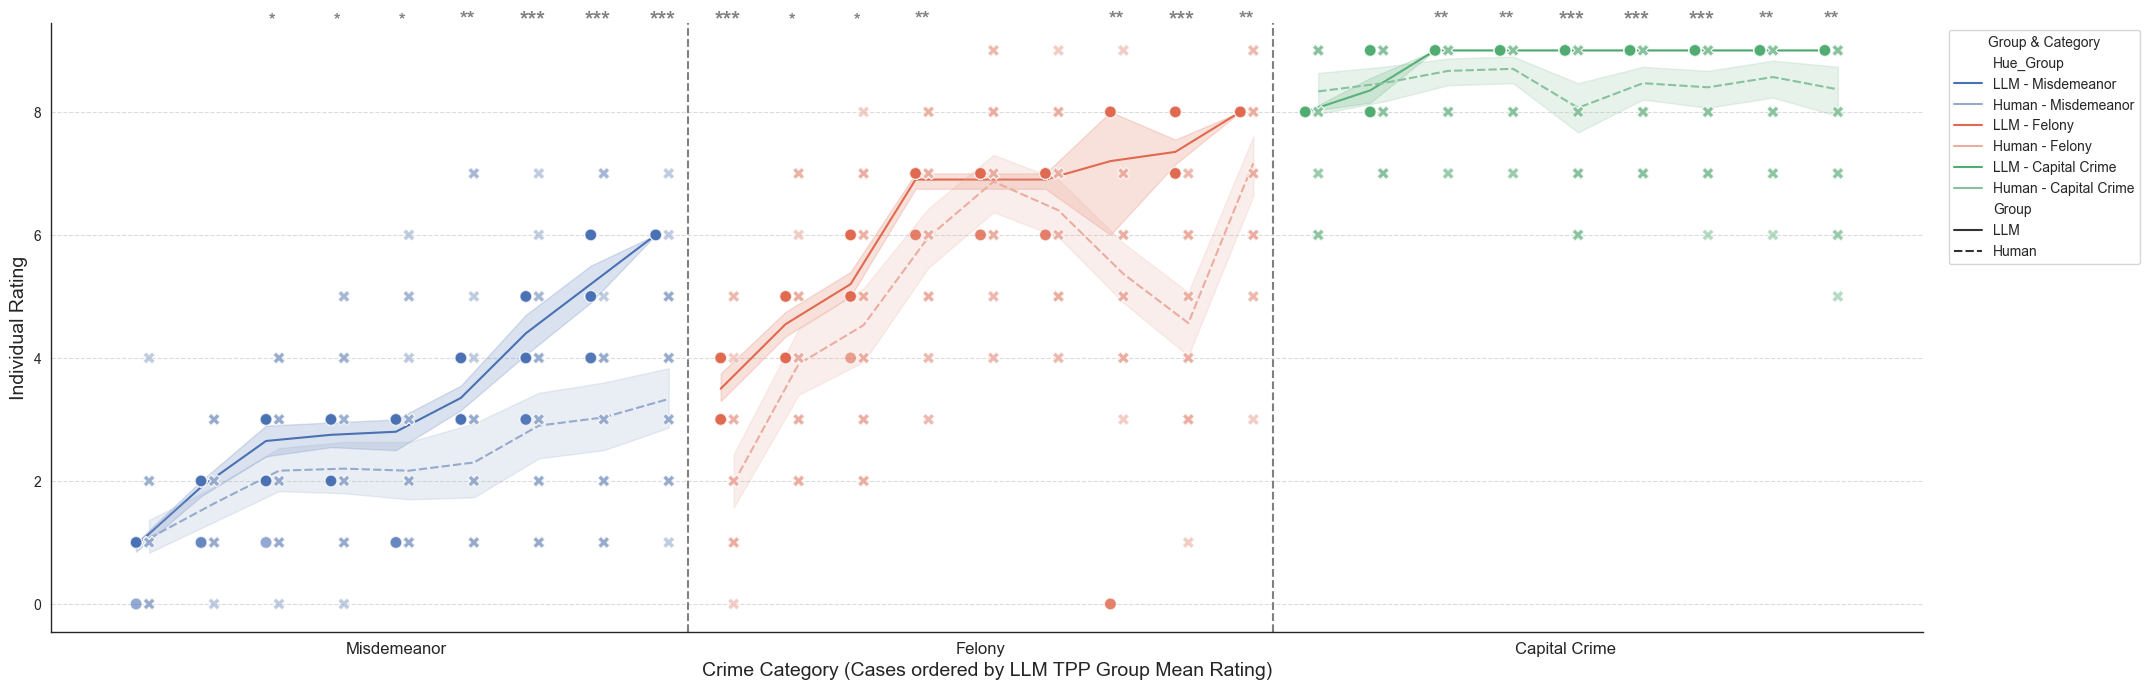

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库
from scipy import stats  # 添加统计检验库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的TPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的TPP数据（作为基准）
df_llm_tpp = df_llm[df_llm['Role'] == 'TPP'].copy()
df_llm_tpp['Delay_Num'] = pd.to_numeric(df_llm_tpp['Delay_Info'], errors='coerce')
df_delay0_tpp_llm = df_llm_tpp[df_llm_tpp['Delay_Num'] == 0.0].copy()
df_delay0_tpp_llm['Category'] = df_delay0_tpp_llm['Category'].astype(int)
df_delay0_tpp_llm['List2'] = df_delay0_tpp_llm['List2'].astype(int)

# 准备人的TPP数据
if 'df_delay0_tpp' not in locals(): df_delay0_tpp = pd.DataFrame()
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list and df_delay0_tpp.empty:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['List2'] = df_delay0_tpp['List2'].astype(int)

# 建立基准坐标系（基于LLM的TPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_tpp_llm.empty:
    base_plot_df = df_delay0_tpp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_tpp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_tpp_data_list.append(subset_df)
    
    llm_tpp_plot_df = pd.concat(final_llm_tpp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    mean_ratings_llm_tpp = llm_tpp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_LLM_TPP')
    llm_tpp_plot_df = llm_tpp_plot_df.merge(mean_ratings_llm_tpp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_tpp_plot_df[llm_tpp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_LLM_TPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating_LLM_TPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_tpp_plot_df['x_rank'] = llm_tpp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_tpp_plot_df['x_position'] = llm_tpp_plot_df['Category_Name'].map(offsets) + llm_tpp_plot_df['x_rank']
    
    case_position_map = llm_tpp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的TPP数据
    llm_tpp_final = llm_tpp_plot_df.copy()
    llm_tpp_final['Group'] = 'LLM'
    
    # 人的TPP数据
    human_tpp_final = pd.DataFrame()
    if not df_delay0_tpp.empty:
        human_tpp_to_plot = df_delay0_tpp.copy()
        human_tpp_to_plot['Category_Name'] = human_tpp_to_plot['Category'].map(category_map)
        human_tpp_final = pd.merge(human_tpp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_tpp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_tpp_final, human_tpp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 新增：统计检验部分 ---
significance_df = pd.DataFrame()  # 在外部定义，以便在绘图部分使用

if not combined_plot_df.empty:
    print("=== 大模型 vs 人类参与者 评分差异显著性检验 ===")
    
    # 获取所有case的x_position排序
    sorted_cases = case_position_map.sort_values('x_position')
    
    significance_results = []
    
    for _, case_row in sorted_cases.iterrows():
        category_name = case_row['Category_Name']
        list2 = case_row['List2']
        x_position = case_row['x_position']
        
        # 提取该case下LLM和Human的评分数据
        llm_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'LLM')
        ]['Rating'].values
        
        human_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'Human')
        ]['Rating'].values
        
        # 检查是否有足够的数据进行检验
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 进行独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
            elif p_value < 0.01:
                sig_symbol = "**"
            elif p_value < 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = "ns"
            
            # 计算均值
            llm_mean = np.mean(llm_ratings)
            human_mean = np.mean(human_ratings)
            
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': llm_mean,
                'Human_Mean': human_mean,
                't_statistic': t_stat,
                'p_value': p_value,
                'significance': sig_symbol
            })
        else:
            # 数据不足的情况
            sig_symbol = "NA"
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': np.nan,
                'Human_Mean': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'significance': sig_symbol
            })
    
    # 按照x_position排序并打印结果
    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('x_position')
    
    print("\n按x轴顺序的显著性检验结果:")
    print("=" * 80)
    print(f"{'x_pos':<6} {'Category':<15} {'Case':<6} {'LLM_Mean':<8} {'Human_Mean':<10} {'t-stat':<8} {'p-value':<10} {'Sig.'}")
    print("-" * 80)
    
    for _, row in significance_df.iterrows():
        if row['significance'] == "NA":
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {'-':<8} {'-':<10} {'-':<8} {'-':<10} {row['significance']}")
        else:
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {row['LLM_Mean']:<8.2f} {row['Human_Mean']:<10.2f} {row['t_statistic']:<8.2f} {row['p_value']:<10.4f} {row['significance']}")
    
    # 打印显著性说明
    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 新增：在图表上添加显著性标记 ---
    if not significance_df.empty:
        # 计算每个案例的中心位置（考虑jitter偏移）
        # 由于Human数据有jitter偏移，我们需要找到每个案例的LLM和Human数据的中心位置
        case_centers = {}
        for _, case_row in case_position_map.iterrows():
            category_name = case_row['Category_Name']
            list2 = case_row['List2']
            x_position = case_row['x_position']
            
            # 找到该案例下所有数据点的x位置
            case_data = combined_plot_df[
                (combined_plot_df['Category_Name'] == category_name) & 
                (combined_plot_df['List2'] == list2)
            ]
            
            if not case_data.empty:
                # 计算中心位置（LLM和Human数据的中间位置）
                llm_x = case_data[case_data['Group'] == 'LLM']['x_position'].mean()
                human_x = case_data[case_data['Group'] == 'Human']['x_position'].mean()
                case_center = (llm_x + human_x) / 2
                case_centers[(category_name, list2)] = case_center
        
        # 设置显著性标记的y位置（稍微高于数据点）
        y_max = combined_plot_df['Rating'].max()
        sig_y_position = y_max + 0.5
        
        # 为不同显著性水平设置不同的颜色和样式
        sig_style = {
            '***': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 16},
            '**': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 14},
            '*': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 12}
        }
        
        # 只在显著的位置添加标记
        for _, row in significance_df.iterrows():
            if row['significance'] in ['*', '**', '***']:  # 只标记显著的位置
                category_name = row['Category']
                list2 = row['Case']
                
                # 获取案例中心位置
                center_x = case_centers.get((category_name, list2), row['x_position'])
                
                # 在对应位置添加显著性标记
                ax.text(center_x, sig_y_position, 
                       row['significance'],
                       ha='center', va='center',
                       **sig_style[row['significance']],
                       zorder=3)
        
        # # 添加显著性标记的说明文本
        # ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05',
        #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # --- 自定义图表细节 ---
    # plt.title('LLM TPP vs Human TPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM TPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

=== 大模型 vs 人类参与者 评分差异显著性检验 ===

按x轴顺序的显著性检验结果:
x_pos  Category        Case   LLM_Mean Human_Mean t-stat   p-value    Sig.
--------------------------------------------------------------------------------
1.0    Misdemeanor     3      0.75     1.08       -1.77    0.0848     ns
2.0    Misdemeanor     9      1.75     1.42       1.75     0.0882     ns
3.0    Misdemeanor     45     2.60     2.65       -0.18    0.8598     ns
4.0    Misdemeanor     11     2.75     2.54       0.67     0.5058     ns
5.0    Misdemeanor     35     2.75     2.19       2.16     0.0365     *
6.0    Misdemeanor     37     3.80     2.50       4.79     0.0000     ***
7.0    Misdemeanor     41     4.25     2.46       5.65     0.0000     ***
8.0    Misdemeanor     31     5.60     3.69       4.92     0.0000     ***
9.0    Misdemeanor     25     6.15     3.81       6.45     0.0000     ***
10.0   Felony          19     3.40     2.00       4.85     0.0000     ***
11.0   Felony          17     4.45     4.04       1.13     0.26

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\3678133826.py:127: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


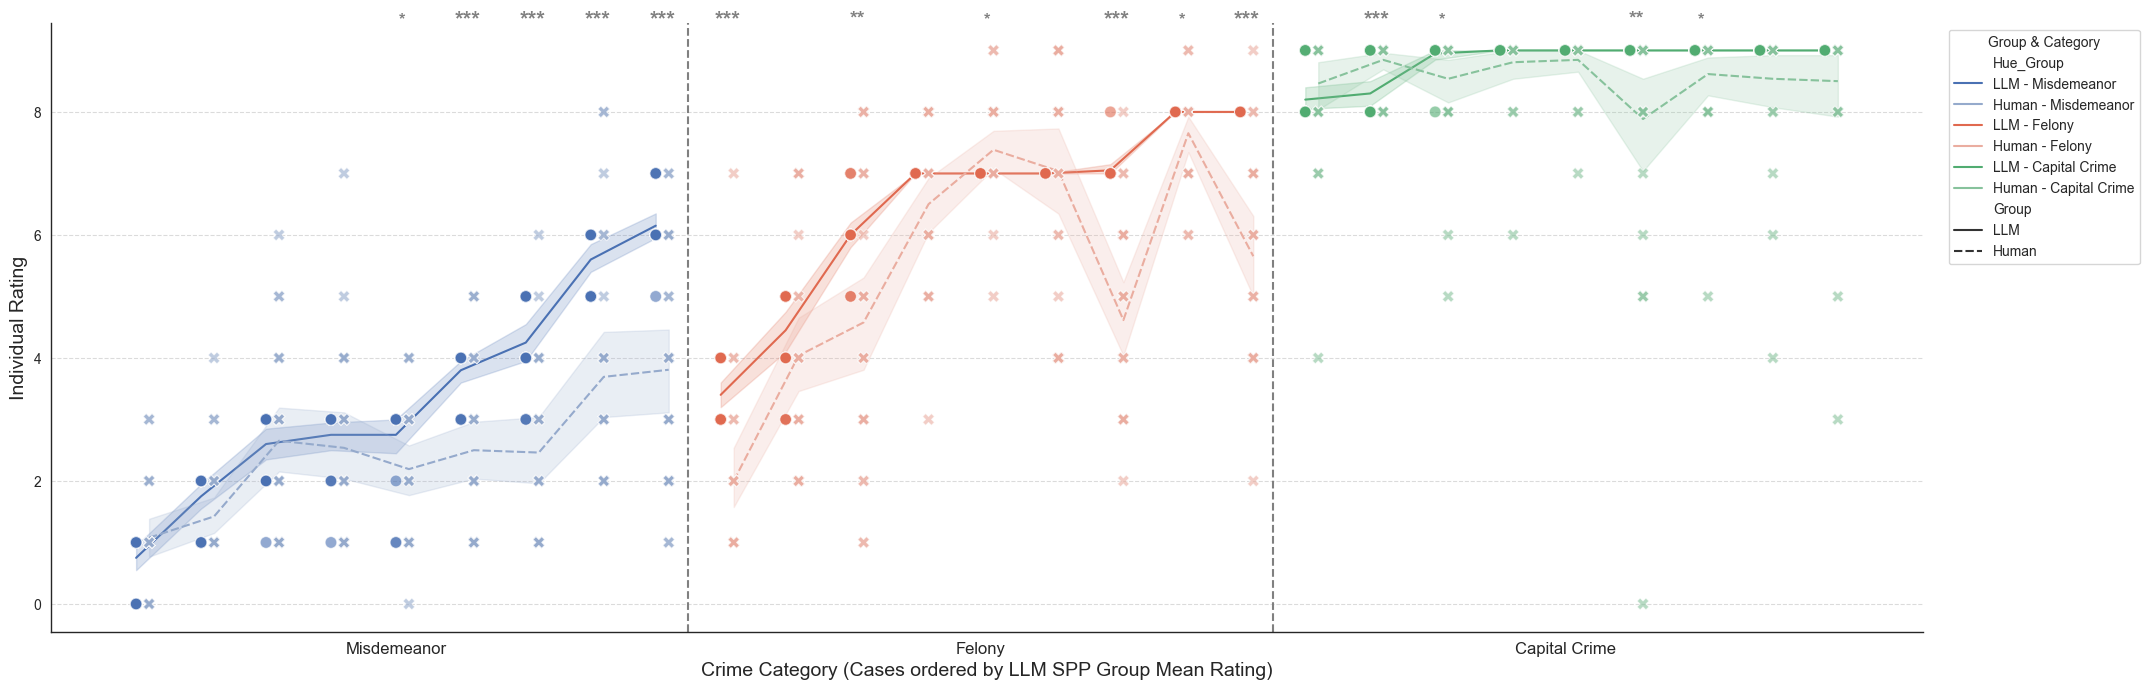

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库
from scipy import stats  # 添加统计检验库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的SPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的SPP数据（作为基准）
df_llm_spp = df_llm[df_llm['Role'] == 'SPP'].copy()
df_llm_spp['Delay_Num'] = pd.to_numeric(df_llm_spp['Delay_Info'], errors='coerce')
df_delay0_spp_llm = df_llm_spp[df_llm_spp['Delay_Num'] == 0.0].copy()
df_delay0_spp_llm['Category'] = df_delay0_spp_llm['Category'].astype(int)
df_delay0_spp_llm['List2'] = df_delay0_spp_llm['List2'].astype(int)

# 准备人的SPP数据
if 'df_delay0_spp' not in locals(): df_delay0_spp = pd.DataFrame()
if 'spp_cleaned_list' in locals() and spp_cleaned_list and df_delay0_spp.empty:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    df_delay0_spp['List2'] = df_delay0_spp['List2'].astype(int)

# 建立基准坐标系（基于LLM的SPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_spp_llm.empty:
    base_plot_df = df_delay0_spp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_spp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_spp_data_list.append(subset_df)
    
    llm_spp_plot_df = pd.concat(final_llm_spp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    mean_ratings_llm_spp = llm_spp_plot_df.groupby('List2')['Rating'].mean().rename('Mean_Rating_LLM_SPP')
    llm_spp_plot_df = llm_spp_plot_df.merge(mean_ratings_llm_spp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_spp_plot_df[llm_spp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Rating_LLM_SPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Rating_LLM_SPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_spp_plot_df['x_rank'] = llm_spp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_spp_plot_df['x_position'] = llm_spp_plot_df['Category_Name'].map(offsets) + llm_spp_plot_df['x_rank']
    
    case_position_map = llm_spp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的SPP数据
    llm_spp_final = llm_spp_plot_df.copy()
    llm_spp_final['Group'] = 'LLM'
    
    # 人的SPP数据
    human_spp_final = pd.DataFrame()
    if not df_delay0_spp.empty:
        human_spp_to_plot = df_delay0_spp.copy()
        human_spp_to_plot['Category_Name'] = human_spp_to_plot['Category'].map(category_map)
        human_spp_final = pd.merge(human_spp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_spp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_spp_final, human_spp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
else:
    print("未能创建基准坐标系，无法继续。")

# --- 新增：统计检验部分 ---
significance_df = pd.DataFrame()  # 在外部定义，以便在绘图部分使用

if not combined_plot_df.empty:
    print("=== 大模型 vs 人类参与者 评分差异显著性检验 ===")
    
    # 获取所有case的x_position排序
    sorted_cases = case_position_map.sort_values('x_position')
    
    significance_results = []
    
    for _, case_row in sorted_cases.iterrows():
        category_name = case_row['Category_Name']
        list2 = case_row['List2']
        x_position = case_row['x_position']
        
        # 提取该case下LLM和Human的评分数据
        llm_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'LLM')
        ]['Rating'].values
        
        human_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'Human')
        ]['Rating'].values
        
        # 检查是否有足够的数据进行检验
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 进行独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
            elif p_value < 0.01:
                sig_symbol = "**"
            elif p_value < 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = "ns"
            
            # 计算均值
            llm_mean = np.mean(llm_ratings)
            human_mean = np.mean(human_ratings)
            
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': llm_mean,
                'Human_Mean': human_mean,
                't_statistic': t_stat,
                'p_value': p_value,
                'significance': sig_symbol
            })
        else:
            # 数据不足的情况
            sig_symbol = "NA"
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': np.nan,
                'Human_Mean': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'significance': sig_symbol
            })
    
    # 按照x_position排序并打印结果
    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('x_position')
    
    print("\n按x轴顺序的显著性检验结果:")
    print("=" * 80)
    print(f"{'x_pos':<6} {'Category':<15} {'Case':<6} {'LLM_Mean':<8} {'Human_Mean':<10} {'t-stat':<8} {'p-value':<10} {'Sig.'}")
    print("-" * 80)
    
    for _, row in significance_df.iterrows():
        if row['significance'] == "NA":
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {'-':<8} {'-':<10} {'-':<8} {'-':<10} {row['significance']}")
        else:
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {row['LLM_Mean']:<8.2f} {row['Human_Mean']:<10.2f} {row['t_statistic']:<8.2f} {row['p_value']:<10.4f} {row['significance']}")
    
    # 打印显著性说明
    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 新增：在图表上添加显著性标记 ---
    if not significance_df.empty:
        # 计算每个案例的中心位置（考虑jitter偏移）
        # 由于Human数据有jitter偏移，我们需要找到每个案例的LLM和Human数据的中心位置
        case_centers = {}
        for _, case_row in case_position_map.iterrows():
            category_name = case_row['Category_Name']
            list2 = case_row['List2']
            x_position = case_row['x_position']
            
            # 找到该案例下所有数据点的x位置
            case_data = combined_plot_df[
                (combined_plot_df['Category_Name'] == category_name) & 
                (combined_plot_df['List2'] == list2)
            ]
            
            if not case_data.empty:
                # 计算中心位置（LLM和Human数据的中间位置）
                llm_x = case_data[case_data['Group'] == 'LLM']['x_position'].mean()
                human_x = case_data[case_data['Group'] == 'Human']['x_position'].mean()
                case_center = (llm_x + human_x) / 2
                case_centers[(category_name, list2)] = case_center
        
        # 设置显著性标记的y位置（稍微高于数据点）
        y_max = combined_plot_df['Rating'].max()
        sig_y_position = y_max + 0.5
        
        # 为不同显著性水平设置不同的颜色和样式
        sig_style = {
            '***': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 16},
            '**': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 14},
            '*': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 12}
        }
        
        # 只在显著的位置添加标记
        for _, row in significance_df.iterrows():
            if row['significance'] in ['*', '**', '***']:  # 只标记显著的位置
                category_name = row['Category']
                list2 = row['Case']
                
                # 获取案例中心位置
                center_x = case_centers.get((category_name, list2), row['x_position'])
                
                # 在对应位置添加显著性标记
                ax.text(center_x, sig_y_position, 
                       row['significance'],
                       ha='center', va='center',
                       **sig_style[row['significance']],
                       zorder=3)
        
        # # 添加显著性标记的说明文本
        # ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05',
        #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # --- 自定义图表细节 ---
    # plt.title('LLM SPP vs Human SPP: Ratings per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM SPP Group Mean Rating)', fontsize=14)
    plt.ylabel('Individual Rating', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

=== 大模型 vs 人类参与者 情绪评分差异显著性检验 ===

按x轴顺序的显著性检验结果:
x_pos  Category        Case   LLM_Mean Human_Mean t-stat   p-value    Sig.
--------------------------------------------------------------------------------
1.0    Misdemeanor     9      1.20     2.47       -3.17    0.0033     **
2.0    Misdemeanor     3      1.95     2.27       -0.86    0.3968     ns
3.0    Misdemeanor     11     3.35     2.73       1.45     0.1538     ns
4.0    Misdemeanor     45     3.70     3.03       1.50     0.1441     ns
5.0    Misdemeanor     41     3.80     3.13       1.54     0.1334     ns
6.0    Misdemeanor     35     3.90     3.30       1.44     0.1592     ns
7.0    Misdemeanor     37     4.35     2.80       3.66     0.0008     ***
8.0    Misdemeanor     31     5.05     3.23       4.22     0.0001     ***
9.0    Misdemeanor     25     5.50     4.40       2.29     0.0277     *
10.0   Felony          17     4.05     4.00       0.13     0.8975     ns
11.0   Felony          5      4.85     3.70       2.51     0.015

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\2191454837.py:149: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


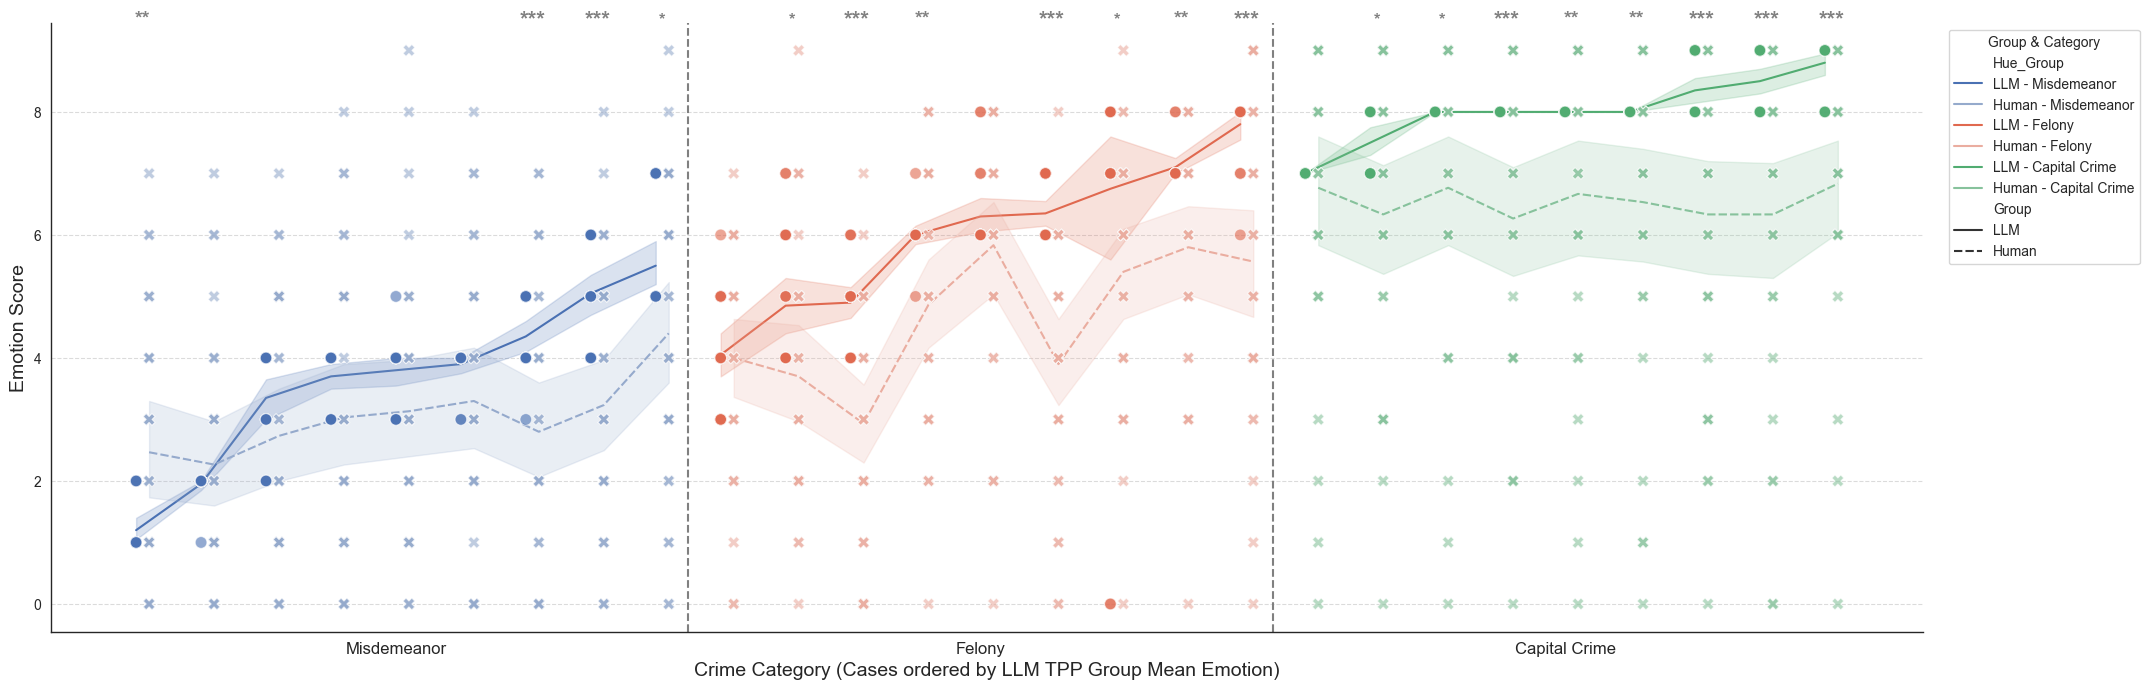

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库
from scipy import stats  # 添加统计检验库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的TPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的TPP数据（作为基准）
df_llm_tpp = df_llm[df_llm['Role'] == 'TPP'].copy()
df_llm_tpp['Delay_Num'] = pd.to_numeric(df_llm_tpp['Delay_Info'], errors='coerce')
df_delay0_tpp_llm = df_llm_tpp[df_llm_tpp['Delay_Num'] == 0.0].copy()
df_delay0_tpp_llm['Category'] = df_delay0_tpp_llm['Category'].astype(int)
df_delay0_tpp_llm['List2'] = df_delay0_tpp_llm['List2'].astype(int)

# 准备人的TPP数据
if 'tpp_cleaned_list' not in locals() or not tpp_cleaned_list:
    print("错误：找不到变量 'tpp_cleaned_list'。请先运行数据加载代码。")
    df_delay0 = pd.DataFrame(columns=['Category', 'List2', 'Emotion_Arousal', 'Delay_Info'])
else:
    if 'tpp_df_combined' not in locals():
        tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
        tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
        df_delay0 = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
        df_delay0['Category'] = df_delay0['Category'].astype(int)
        df_delay0['List2'] = df_delay0['List2'].astype(int)
        print("已筛选出 TPP 组中延迟时间为0的数据，共计 {} 条。".format(len(df_delay0)))

if 'df_delay0_tpp' not in locals(): df_delay0_tpp = pd.DataFrame()
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list and df_delay0_tpp.empty:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['List2'] = df_delay0_tpp['List2'].astype(int)

# 建立基准坐标系（基于LLM的TPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_tpp_llm.empty:
    base_plot_df = df_delay0_tpp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_tpp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_tpp_data_list.append(subset_df)
    
    llm_tpp_plot_df = pd.concat(final_llm_tpp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    # 修改：将Rating改为Emotion
    mean_ratings_llm_tpp = llm_tpp_plot_df.groupby('List2')['Emotion'].mean().rename('Mean_Emotion_LLM_TPP')
    llm_tpp_plot_df = llm_tpp_plot_df.merge(mean_ratings_llm_tpp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_tpp_plot_df[llm_tpp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Emotion_LLM_TPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Emotion_LLM_TPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_tpp_plot_df['x_rank'] = llm_tpp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_tpp_plot_df['x_position'] = llm_tpp_plot_df['Category_Name'].map(offsets) + llm_tpp_plot_df['x_rank']
    
    case_position_map = llm_tpp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的TPP数据
    llm_tpp_final = llm_tpp_plot_df.copy()
    llm_tpp_final['Group'] = 'LLM'
    
    # 人的TPP数据
    human_tpp_final = pd.DataFrame()
    if not df_delay0_tpp.empty:
        human_tpp_to_plot = df_delay0_tpp.copy()
        human_tpp_to_plot['Category_Name'] = human_tpp_to_plot['Category'].map(category_map)
        human_tpp_final = pd.merge(human_tpp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_tpp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_tpp_final, human_tpp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
    
    # 创建统一的Rating列用于绘图
    # LLM数据使用Emotion，人类数据使用Emotion_Arousal
    combined_plot_df['Rating'] = np.where(
        combined_plot_df['Group'] == 'LLM', 
        combined_plot_df['Emotion'], 
        combined_plot_df['Emotion_Arousal']
    )
else:
    print("未能创建基准坐标系，无法继续。")

# --- 新增：统计检验部分 ---
significance_df = pd.DataFrame()  # 在外部定义，以便在绘图部分使用

if not combined_plot_df.empty:
    print("=== 大模型 vs 人类参与者 情绪评分差异显著性检验 ===")
    
    # 获取所有case的x_position排序
    sorted_cases = case_position_map.sort_values('x_position')
    
    significance_results = []
    
    for _, case_row in sorted_cases.iterrows():
        category_name = case_row['Category_Name']
        list2 = case_row['List2']
        x_position = case_row['x_position']
        
        # 提取该case下LLM和Human的评分数据
        # 修改：LLM使用Emotion，人类使用Emotion_Arousal
        llm_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'LLM')
        ]['Emotion'].values
        
        human_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'Human')
        ]['Emotion_Arousal'].values
        
        # 检查是否有足够的数据进行检验
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 进行独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
            elif p_value < 0.01:
                sig_symbol = "**"
            elif p_value < 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = "ns"
            
            # 计算均值
            llm_mean = np.mean(llm_ratings)
            human_mean = np.mean(human_ratings)
            
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': llm_mean,
                'Human_Mean': human_mean,
                't_statistic': t_stat,
                'p_value': p_value,
                'significance': sig_symbol
            })
        else:
            # 数据不足的情况
            sig_symbol = "NA"
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': np.nan,
                'Human_Mean': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'significance': sig_symbol
            })
    
    # 按照x_position排序并打印结果
    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('x_position')
    
    print("\n按x轴顺序的显著性检验结果:")
    print("=" * 80)
    print(f"{'x_pos':<6} {'Category':<15} {'Case':<6} {'LLM_Mean':<8} {'Human_Mean':<10} {'t-stat':<8} {'p-value':<10} {'Sig.'}")
    print("-" * 80)
    
    for _, row in significance_df.iterrows():
        if row['significance'] == "NA":
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {'-':<8} {'-':<10} {'-':<8} {'-':<10} {row['significance']}")
        else:
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {row['LLM_Mean']:<8.2f} {row['Human_Mean']:<10.2f} {row['t_statistic']:<8.2f} {row['p_value']:<10.4f} {row['significance']}")
    
    # 打印显著性说明
    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 新增：在图表上添加显著性标记 ---
    if not significance_df.empty:
        # 计算每个案例的中心位置（考虑jitter偏移）
        # 由于Human数据有jitter偏移，我们需要找到每个案例的LLM和Human数据的中心位置
        case_centers = {}
        for _, case_row in case_position_map.iterrows():
            category_name = case_row['Category_Name']
            list2 = case_row['List2']
            x_position = case_row['x_position']
            
            # 找到该案例下所有数据点的x位置
            case_data = combined_plot_df[
                (combined_plot_df['Category_Name'] == category_name) & 
                (combined_plot_df['List2'] == list2)
            ]
            
            if not case_data.empty:
                # 计算中心位置（LLM和Human数据的中间位置）
                llm_x = case_data[case_data['Group'] == 'LLM']['x_position'].mean()
                human_x = case_data[case_data['Group'] == 'Human']['x_position'].mean()
                case_center = (llm_x + human_x) / 2
                case_centers[(category_name, list2)] = case_center
        
        # 设置显著性标记的y位置（稍微高于数据点）
        y_max = combined_plot_df['Rating'].max()
        sig_y_position = y_max + 0.5
        
        # 为不同显著性水平设置不同的颜色和样式
        sig_style = {
            '***': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 16},
            '**': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 14},
            '*': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 12}
        }
        
        # 只在显著的位置添加标记
        for _, row in significance_df.iterrows():
            if row['significance'] in ['*', '**', '***']:  # 只标记显著的位置
                category_name = row['Category']
                list2 = row['Case']
                
                # 获取案例中心位置
                center_x = case_centers.get((category_name, list2), row['x_position'])
                
                # 在对应位置添加显著性标记
                ax.text(center_x, sig_y_position, 
                       row['significance'],
                       ha='center', va='center',
                       **sig_style[row['significance']],
                       zorder=3)
        
        # # 添加显著性标记的说明文本
        # ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05',
        #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # --- 自定义图表细节 ---
    # plt.title('LLM TPP vs Human TPP: Emotion Scores per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM TPP Group Mean Emotion)', fontsize=14)
    plt.ylabel('Emotion Score', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

=== 大模型 vs 人类参与者 情绪评分差异显著性检验 ===

按x轴顺序的显著性检验结果:
x_pos  Category        Case   LLM_Mean Human_Mean t-stat   p-value    Sig.
--------------------------------------------------------------------------------
1.0    Misdemeanor     3      2.00     2.92       -1.84    0.0779     ns
2.0    Misdemeanor     9      2.80     2.23       1.55     0.1332     ns
3.0    Misdemeanor     45     3.65     3.92       -0.55    0.5837     ns
4.0    Misdemeanor     11     3.80     3.58       0.48     0.6368     ns
5.0    Misdemeanor     35     3.95     3.69       0.49     0.6263     ns
6.0    Misdemeanor     41     4.70     3.04       3.57     0.0012     **
7.0    Misdemeanor     37     5.35     3.81       3.05     0.0047     **
8.0    Misdemeanor     31     5.65     4.46       2.36     0.0245     *
9.0    Misdemeanor     25     7.40     4.69       6.91     0.0000     ***
10.0   Felony          19     5.40     3.58       3.82     0.0006     ***
11.0   Felony          17     5.70     5.27       0.89     0.381

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\350745395.py:149: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


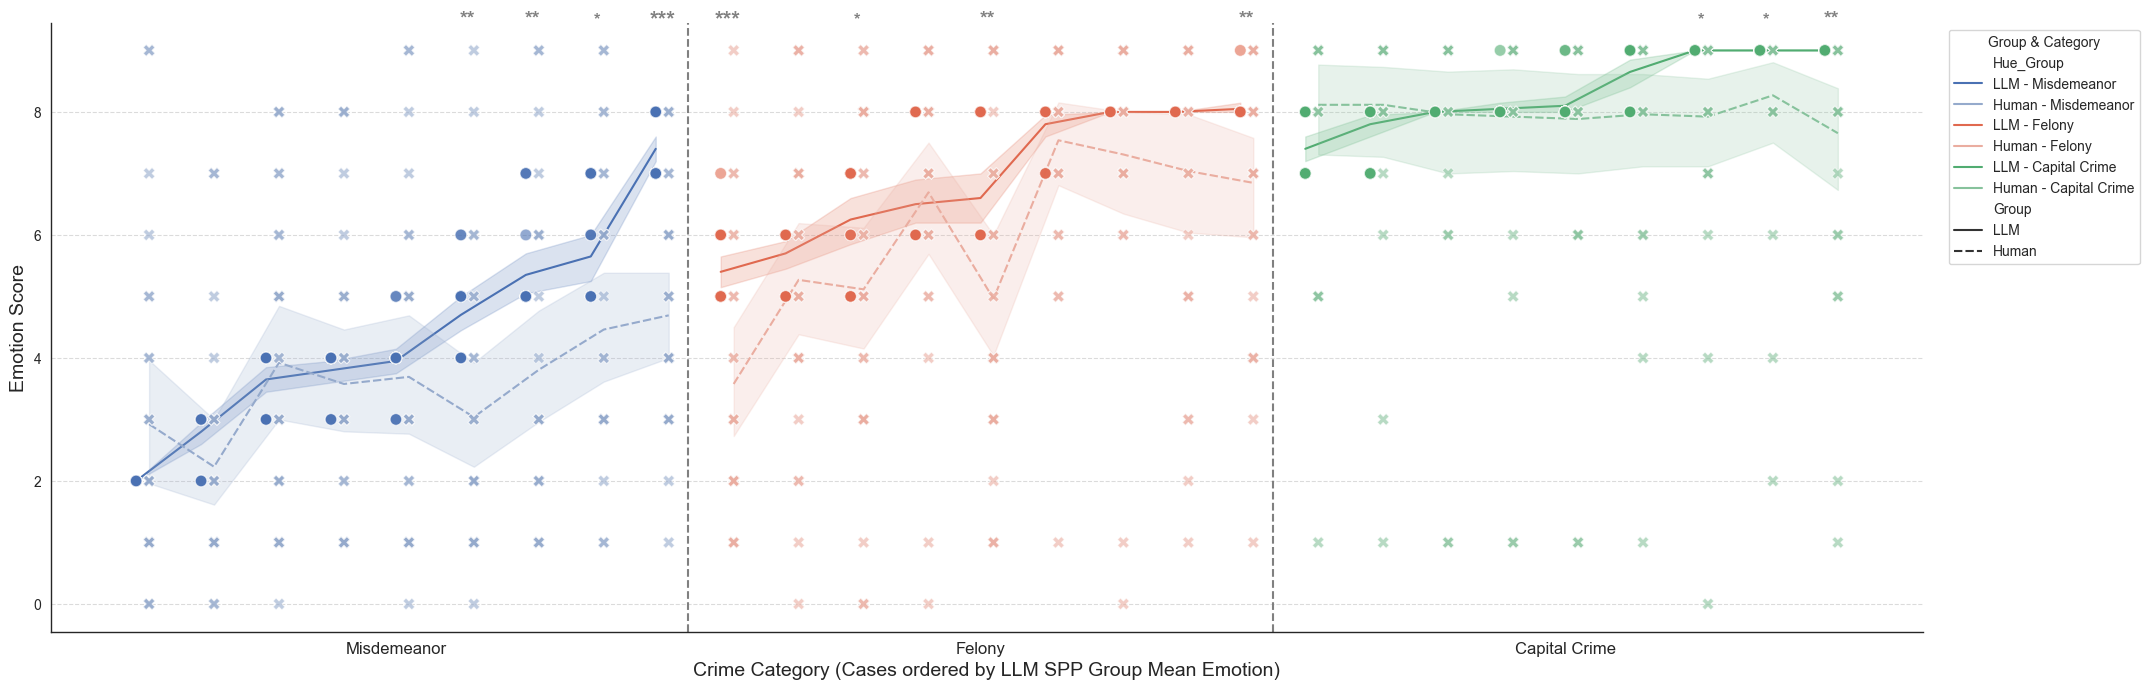

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys # 引入用于颜色空间转换的库
from scipy import stats  # 添加统计检验库

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备和基准坐标系建立 (修改为使用LLM的SPP数据作为基准) ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 准备LLM的SPP数据（作为基准）
df_llm_spp = df_llm[df_llm['Role'] == 'SPP'].copy()
df_llm_spp['Delay_Num'] = pd.to_numeric(df_llm_spp['Delay_Info'], errors='coerce')
df_delay0_spp_llm = df_llm_spp[df_llm_spp['Delay_Num'] == 0.0].copy()
df_delay0_spp_llm['Category'] = df_delay0_spp_llm['Category'].astype(int)
df_delay0_spp_llm['List2'] = df_delay0_spp_llm['List2'].astype(int)

# 准备人的SPP数据
if 'spp_cleaned_list' not in locals() or not spp_cleaned_list:
    print("错误：找不到变量 'spp_cleaned_list'。请先运行数据加载代码。")
    df_delay0 = pd.DataFrame(columns=['Category', 'List2', 'Emotion_Arousal', 'Delay_Info'])
else:
    if 'spp_df_combined' not in locals():
        spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
        spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
        df_delay0 = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
        df_delay0['Category'] = df_delay0['Category'].astype(int)
        df_delay0['List2'] = df_delay0['List2'].astype(int)
        print("已筛选出 SPP 组中延迟时间为0的数据，共计 {} 条。".format(len(df_delay0)))

if 'df_delay0_spp' not in locals(): df_delay0_spp = pd.DataFrame()
if 'spp_cleaned_list' in locals() and spp_cleaned_list and df_delay0_spp.empty:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    df_delay0_spp['List2'] = df_delay0_spp['List2'].astype(int)

# 建立基准坐标系（基于LLM的SPP数据）
case_position_map = pd.DataFrame()
if not df_delay0_spp_llm.empty:
    base_plot_df = df_delay0_spp_llm.copy()
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
    sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']
    base_plot_df['Category_Name'] = base_plot_df['Category'].map(category_map)
    
    final_llm_spp_data_list = []
    case_counts = {}
    for category_name in sorted_categories:
        category_df = base_plot_df[base_plot_df['Category_Name'] == category_name]
        sorted_unique_cases = sorted(category_df['List2'].unique())
        cases_to_plot = sorted_unique_cases[:9]
        case_counts[category_name] = len(cases_to_plot)
        subset_df = category_df[category_df['List2'].isin(cases_to_plot)]
        final_llm_spp_data_list.append(subset_df)
    
    llm_spp_plot_df = pd.concat(final_llm_spp_data_list, ignore_index=True)
    
    offsets = {}
    current_offset = 0
    for category_name in sorted_categories:
        offsets[category_name] = current_offset
        current_offset += case_counts.get(category_name, 0)
    
    # 修改：将Rating改为Emotion
    mean_ratings_llm_spp = llm_spp_plot_df.groupby('List2')['Emotion'].mean().rename('Mean_Emotion_LLM_SPP')
    llm_spp_plot_df = llm_spp_plot_df.merge(mean_ratings_llm_spp, on='List2')
    
    case_rank_map = {}
    for category_name in sorted_categories:
        category_cases = llm_spp_plot_df[llm_spp_plot_df['Category_Name'] == category_name][['List2', 'Mean_Emotion_LLM_SPP']].drop_duplicates()
        category_cases = category_cases.sort_values(['Mean_Emotion_LLM_SPP', 'List2'])
        for rank, (_, row) in enumerate(category_cases.iterrows(), start=1):
            case_rank_map[(category_name, row['List2'])] = rank
    
    llm_spp_plot_df['x_rank'] = llm_spp_plot_df.apply(lambda row: case_rank_map[(row['Category_Name'], row['List2'])], axis=1)
    llm_spp_plot_df['x_position'] = llm_spp_plot_df['Category_Name'].map(offsets) + llm_spp_plot_df['x_rank']
    
    case_position_map = llm_spp_plot_df[['Category_Name', 'List2', 'x_position']].drop_duplicates()

# --- 步骤 3: 准备最终绘图数据 ---
combined_plot_df = pd.DataFrame()
if not case_position_map.empty:
    # LLM的SPP数据
    llm_spp_final = llm_spp_plot_df.copy()
    llm_spp_final['Group'] = 'LLM'
    
    # 人的SPP数据
    human_spp_final = pd.DataFrame()
    if not df_delay0_spp.empty:
        human_spp_to_plot = df_delay0_spp.copy()
        human_spp_to_plot['Category_Name'] = human_spp_to_plot['Category'].map(category_map)
        human_spp_final = pd.merge(human_spp_to_plot, case_position_map, on=['Category_Name', 'List2'])
        human_spp_final['Group'] = 'Human'
    
    combined_plot_df = pd.concat([llm_spp_final, human_spp_final], ignore_index=True)
    jitter_offset = 0.2
    human_indices = combined_plot_df['Group'] == 'Human'
    combined_plot_df.loc[human_indices, 'x_position'] = combined_plot_df.loc[human_indices, 'x_position'] + jitter_offset
    combined_plot_df['Hue_Group'] = combined_plot_df['Group'] + ' - ' + combined_plot_df['Category_Name']
    
    # 创建统一的Rating列用于绘图
    # LLM数据使用Emotion，人类数据使用Emotion_Arousal
    combined_plot_df['Rating'] = np.where(
        combined_plot_df['Group'] == 'LLM', 
        combined_plot_df['Emotion'], 
        combined_plot_df['Emotion_Arousal']
    )
else:
    print("未能创建基准坐标系，无法继续。")

# --- 新增：统计检验部分 ---
significance_df = pd.DataFrame()  # 在外部定义，以便在绘图部分使用

if not combined_plot_df.empty:
    print("=== 大模型 vs 人类参与者 情绪评分差异显著性检验 ===")
    
    # 获取所有case的x_position排序
    sorted_cases = case_position_map.sort_values('x_position')
    
    significance_results = []
    
    for _, case_row in sorted_cases.iterrows():
        category_name = case_row['Category_Name']
        list2 = case_row['List2']
        x_position = case_row['x_position']
        
        # 提取该case下LLM和Human的评分数据
        # 修改：LLM使用Emotion，人类使用Emotion_Arousal
        llm_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'LLM')
        ]['Emotion'].values
        
        human_ratings = combined_plot_df[
            (combined_plot_df['Category_Name'] == category_name) & 
            (combined_plot_df['List2'] == list2) & 
            (combined_plot_df['Group'] == 'Human')
        ]['Emotion_Arousal'].values
        
        # 检查是否有足够的数据进行检验
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 进行独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
            elif p_value < 0.01:
                sig_symbol = "**"
            elif p_value < 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = "ns"
            
            # 计算均值
            llm_mean = np.mean(llm_ratings)
            human_mean = np.mean(human_ratings)
            
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': llm_mean,
                'Human_Mean': human_mean,
                't_statistic': t_stat,
                'p_value': p_value,
                'significance': sig_symbol
            })
        else:
            # 数据不足的情况
            sig_symbol = "NA"
            significance_results.append({
                'x_position': x_position,
                'Category': category_name,
                'Case': list2,
                'LLM_Mean': np.nan,
                'Human_Mean': np.nan,
                't_statistic': np.nan,
                'p_value': np.nan,
                'significance': sig_symbol
            })
    
    # 按照x_position排序并打印结果
    significance_df = pd.DataFrame(significance_results)
    significance_df = significance_df.sort_values('x_position')
    
    print("\n按x轴顺序的显著性检验结果:")
    print("=" * 80)
    print(f"{'x_pos':<6} {'Category':<15} {'Case':<6} {'LLM_Mean':<8} {'Human_Mean':<10} {'t-stat':<8} {'p-value':<10} {'Sig.'}")
    print("-" * 80)
    
    for _, row in significance_df.iterrows():
        if row['significance'] == "NA":
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {'-':<8} {'-':<10} {'-':<8} {'-':<10} {row['significance']}")
        else:
            print(f"{row['x_position']:<6.1f} {row['Category']:<15} {row['Case']:<6} {row['LLM_Mean']:<8.2f} {row['Human_Mean']:<10.2f} {row['t_statistic']:<8.2f} {row['p_value']:<10.4f} {row['significance']}")
    
    # 打印显著性说明
    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")

# --- 步骤 4: 数据可视化 ---

if not combined_plot_df.empty:
    plt.figure(figsize=(24, 7))

    # 【核心修改】手动创建和微调颜色
    
    # 1. 定义一个辅助函数来微调颜色
    def tweak_color(color, h_shift=0, s_mult=1, l_mult=1):
        """
        在HLS空间中微调颜色。
        h_shift: 色相偏移量 (-1.0 to 1.0)
        s_mult: 饱和度乘数 (e.g., 1.1 for 10% more saturation)
        l_mult: 亮度乘数 (e.g., 1.2 for 20% more lightness)
        """
        r, g, b = color
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        
        new_h = (h + h_shift) % 1.0
        new_s = min(1.0, s * s_mult) # 饱和度不能超过1
        new_l = min(1.0, l * l_mult) # 亮度不能超过1
        
        return colorsys.hls_to_rgb(new_h, new_l, new_s)

    # 2. 获取基础颜色
    base_colors = sns.color_palette("deep", n_colors=len(sorted_categories))
    base_blue, base_orange, base_green = base_colors

    # 3. 手动创建最终的颜色字典
    palette_dict = {}
    
    # -- Misdemeanor (基于蓝色) --
    llm_blue = tweak_color(base_blue, s_mult=1.05) # 让蓝色更饱和一点（LLM）
    human_blue = tweak_color(llm_blue, l_mult=1.4, s_mult=0.85) # 提亮，同时降低一点饱和度，得到有分量的浅蓝（Human）
    palette_dict['LLM - Misdemeanor'] = llm_blue
    palette_dict['Human - Misdemeanor'] = human_blue

    # -- Felony (基于橙色) --
    # 将橙色的色相向红色偏移一点点 (负向偏移)
    llm_orange = tweak_color(base_orange, h_shift=-0.03, s_mult=1.05) # LLM
    human_orange = tweak_color(llm_orange, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅橙红（Human）
    palette_dict['LLM - Felony'] = llm_orange
    palette_dict['Human - Felony'] = human_orange

    # -- Capital Crime (基于绿色) --
    # 让绿色更鲜艳，可以稍微向青色偏移一点 (正向偏移)
    llm_green = tweak_color(base_green, h_shift=0.02, s_mult=1.1) # LLM
    human_green = tweak_color(llm_green, l_mult=1.3, s_mult=0.9) # 提亮，得到有分量的浅绿（Human）
    palette_dict['LLM - Capital Crime'] = llm_green
    palette_dict['Human - Capital Crime'] = human_green
    
    print("\n已创建手动微调的颜色映射字典:")
    # print(palette_dict) # 如果需要,可以取消注释查看RGB值

    # 定义图例中项目的顺序
    hue_order_list = [f'{group} - {cat}' for cat in sorted_categories for group in ['LLM', 'Human']]

    # --- 绘制线图和散点图 ---
    ax = sns.lineplot(data=combined_plot_df, x='x_position', y='Rating', 
                      hue='Hue_Group', hue_order=hue_order_list,
                      style='Group', style_order=['LLM', 'Human'],
                      palette=palette_dict,
                      errorbar=('ci', 95), legend='full', zorder=1)
    
    sns.scatterplot(data=combined_plot_df, x='x_position', y='Rating', 
                    hue='Hue_Group', hue_order=hue_order_list,
                    style='Group', style_order=['LLM', 'Human'],
                    palette=palette_dict,
                    alpha=0.6, s=70, ax=ax, legend=False, zorder=2)

    # --- 新增：在图表上添加显著性标记 ---
    if not significance_df.empty:
        # 计算每个案例的中心位置（考虑jitter偏移）
        # 由于Human数据有jitter偏移，我们需要找到每个案例的LLM和Human数据的中心位置
        case_centers = {}
        for _, case_row in case_position_map.iterrows():
            category_name = case_row['Category_Name']
            list2 = case_row['List2']
            x_position = case_row['x_position']
            
            # 找到该案例下所有数据点的x位置
            case_data = combined_plot_df[
                (combined_plot_df['Category_Name'] == category_name) & 
                (combined_plot_df['List2'] == list2)
            ]
            
            if not case_data.empty:
                # 计算中心位置（LLM和Human数据的中间位置）
                llm_x = case_data[case_data['Group'] == 'LLM']['x_position'].mean()
                human_x = case_data[case_data['Group'] == 'Human']['x_position'].mean()
                case_center = (llm_x + human_x) / 2
                case_centers[(category_name, list2)] = case_center
        
        # 设置显著性标记的y位置（稍微高于数据点）
        y_max = combined_plot_df['Rating'].max()
        sig_y_position = y_max + 0.5
        
        # 为不同显著性水平设置不同的颜色和样式
        sig_style = {
            '***': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 16},
            '**': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 14},
            '*': {'color': 'gray', 'fontweight': 'bold', 'fontsize': 12}
        }
        
        # 只在显著的位置添加标记
        for _, row in significance_df.iterrows():
            if row['significance'] in ['*', '**', '***']:  # 只标记显著的位置
                category_name = row['Category']
                list2 = row['Case']
                
                # 获取案例中心位置
                center_x = case_centers.get((category_name, list2), row['x_position'])
                
                # 在对应位置添加显著性标记
                ax.text(center_x, sig_y_position, 
                       row['significance'],
                       ha='center', va='center',
                       **sig_style[row['significance']],
                       zorder=3)
        
        # # 添加显著性标记的说明文本
        # ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05',
        #         transform=ax.transAxes, fontsize=10, verticalalignment='top',
        #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # --- 自定义图表细节 ---
    # plt.title('LLM SPP vs Human SPP: Emotion Scores per Case by Crime Category (Delay=0)', fontsize=20)
    plt.xlabel('Crime Category (Cases ordered by LLM SPP Group Mean Emotion)', fontsize=14)
    plt.ylabel('Emotion Score', fontsize=14)
    
    category_centers = {}
    for category_name in sorted_categories:
        category_positions = case_position_map[case_position_map['Category_Name'] == category_name]['x_position'].unique()
        if len(category_positions) > 0:
            category_centers[category_name] = (category_positions.min() + category_positions.max()) / 2
    
    plt.xticks(ticks=list(category_centers.values()), labels=list(category_centers.keys()), 
               rotation=0, ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels, title='Group & Category', bbox_to_anchor=(1.01, 1), loc='upper left')
    
    for category_name in sorted_categories[1:]:
        line_pos = offsets.get(category_name, 0) + 0.5
        if line_pos > 0:
            plt.axvline(x=line_pos, color='grey', linestyle='--', linewidth=1.5)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.show()
else:
    print("\n没有可用于绘图的数据。")

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys
from scipy import stats

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 

# --- 步骤 1 & 2: 数据准备 ---
# 读取LLM数据
df_llm = pd.read_csv('./organized_data.csv')

# 创建类别名称映射
category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']

# --- 定义函数进行统计检验 ---
def perform_statistical_tests(df_llm_subset, df_human_subset, group_name):
    """执行统计检验并返回结果"""
    significance_results = []
    
    for category_name in sorted_categories:
        # 提取该类别下LLM和Human的评分数据
        llm_ratings = df_llm_subset[df_llm_subset['Category_Name'] == category_name]['Rating'].values
        human_ratings = df_human_subset[df_human_subset['Category_Name'] == category_name]['Rating'].values if not df_human_subset.empty else np.array([])
        
        # 计算描述性统计
        llm_mean = np.mean(llm_ratings) if len(llm_ratings) > 0 else np.nan
        llm_std = np.std(llm_ratings, ddof=1) if len(llm_ratings) > 0 else np.nan
        llm_count = len(llm_ratings)
        
        human_mean = np.mean(human_ratings) if len(human_ratings) > 0 else np.nan
        human_std = np.std(human_ratings, ddof=1) if len(human_ratings) > 0 else np.nan
        human_count = len(human_ratings)
        
        # 计算均值差异
        mean_diff = llm_mean - human_mean if not np.isnan(llm_mean) and not np.isnan(human_mean) else np.nan
        
        # 进行统计检验（如果数据足够）
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
                significance = "极其显著"
            elif p_value < 0.01:
                sig_symbol = "**"
                significance = "非常显著"
            elif p_value < 0.05:
                sig_symbol = "*"
                significance = "显著"
            else:
                sig_symbol = "ns"
                significance = "不显著"
            
            # 计算效应量（Cohen's d）
            pooled_std = np.sqrt(((llm_count - 1) * llm_std ** 2 + (human_count - 1) * human_std ** 2) / (llm_count + human_count - 2))
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
            
            # 效应量解释
            if abs(cohens_d) < 0.2:
                effect_size_desc = "可忽略"
            elif abs(cohens_d) < 0.5:
                effect_size_desc = "小"
            elif abs(cohens_d) < 0.8:
                effect_size_desc = "中"
            else:
                effect_size_desc = "大"
                
        else:
            t_stat, p_value, sig_symbol, significance, cohens_d, effect_size_desc = np.nan, np.nan, "NA", "数据不足", np.nan, "NA"
        
        # 存储结果
        significance_results.append({
            'Category': category_name,
            'LLM_Mean': llm_mean,
            'LLM_Std': llm_std,
            'LLM_Count': llm_count,
            'Human_Mean': human_mean,
            'Human_Std': human_std,
            'Human_Count': human_count,
            'Mean_Difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'significance_symbol': sig_symbol,
            'significance': significance,
            'Cohens_d': cohens_d,
            'Effect_Size': effect_size_desc
        })
    
    return significance_results

def print_results(significance_results, group_name):
    """打印统计结果"""
    print(f"\n{'='*100}")
    print(f"{group_name} - 汇总表格")
    print(f"{'='*100}")

    print(f"{'犯罪类别':<15} {'LLM均值':<8} {'LLM标准差':<10} {'Human均值':<10} {'Human标准差':<12} {'均值差异':<10} {'t统计量':<10} {'p值':<10} {'显著性':<12} {'效应量':<10}")
    print("-"*100)

    for result in significance_results:
        category = result['Category']
        llm_mean = f"{result['LLM_Mean']:.2f}" if not np.isnan(result['LLM_Mean']) else "N/A"
        llm_std = f"{result['LLM_Std']:.2f}" if not np.isnan(result['LLM_Std']) else "N/A"
        human_mean = f"{result['Human_Mean']:.2f}" if not np.isnan(result['Human_Mean']) else "N/A"
        human_std = f"{result['Human_Std']:.2f}" if not np.isnan(result['Human_Std']) else "N/A"
        mean_diff = f"{result['Mean_Difference']:.2f}" if not np.isnan(result['Mean_Difference']) else "N/A"
        t_stat = f"{result['t_statistic']:.3f}" if not np.isnan(result['t_statistic']) else "N/A"
        p_value = f"{result['p_value']:.4f}" if not np.isnan(result['p_value']) else "N/A"
        significance = result['significance_symbol']
        effect_size = f"{result['Cohens_d']:.3f}" if not np.isnan(result['Cohens_d']) else "N/A"
        
        print(f"{category:<15} {llm_mean:<8} {llm_std:<10} {human_mean:<10} {human_std:<12} {mean_diff:<10} {t_stat:<10} {p_value:<10} {significance:<12} {effect_size:<10}")

    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")
    print("效应量说明: |d| < 0.2 可忽略, 0.2 ≤ |d| < 0.5 小效应, 0.5 ≤ |d| < 0.8 中效应, |d| ≥ 0.8 大效应")

# --- 准备LLM数据 ---
# TPP数据
df_llm_tpp = df_llm[df_llm['Role'] == 'TPP'].copy()
df_llm_tpp['Delay_Num'] = pd.to_numeric(df_llm_tpp['Delay_Info'], errors='coerce')

# SPP数据
df_llm_spp = df_llm[df_llm['Role'] == 'SPP'].copy()
df_llm_spp['Delay_Num'] = pd.to_numeric(df_llm_spp['Delay_Info'], errors='coerce')

# --- 准备人类数据 ---
# 初始化人类数据DataFrame
df_delay0_tpp = pd.DataFrame()
df_delay1_tpp = pd.DataFrame()
df_delay0_spp = pd.DataFrame()
df_delay1_spp = pd.DataFrame()

# 如果有可用的TPP数据
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    
    # TPP delay=0
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    
    # TPP delay!=0
    df_delay1_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_tpp['Category'] = df_delay1_tpp['Category'].astype(int)

# 如果有可用的SPP数据
if 'spp_cleaned_list' in locals() and spp_cleaned_list:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    
    # SPP delay=0
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    
    # SPP delay!=0
    df_delay1_spp = spp_df_combined[spp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_spp['Category'] = df_delay1_spp['Category'].astype(int)

# --- 为所有数据添加类别名称和组别标签 ---
# LLM TPP delay=0
df_llm_tpp_delay0 = df_llm_tpp[df_llm_tpp['Delay_Num'] == 0.0].copy()
df_llm_tpp_delay0['Category'] = df_llm_tpp_delay0['Category'].astype(int)
df_llm_tpp_delay0['Category_Name'] = df_llm_tpp_delay0['Category'].map(category_map)
df_llm_tpp_delay0['Group'] = 'LLM'

# LLM TPP delay!=0
df_llm_tpp_delay1 = df_llm_tpp[df_llm_tpp['Delay_Num'] != 0.0].copy()
df_llm_tpp_delay1['Category'] = df_llm_tpp_delay1['Category'].astype(int)
df_llm_tpp_delay1['Category_Name'] = df_llm_tpp_delay1['Category'].map(category_map)
df_llm_tpp_delay1['Group'] = 'LLM'

# LLM SPP delay=0
df_llm_spp_delay0 = df_llm_spp[df_llm_spp['Delay_Num'] == 0.0].copy()
df_llm_spp_delay0['Category'] = df_llm_spp_delay0['Category'].astype(int)
df_llm_spp_delay0['Category_Name'] = df_llm_spp_delay0['Category'].map(category_map)
df_llm_spp_delay0['Group'] = 'LLM'

# LLM SPP delay!=0
df_llm_spp_delay1 = df_llm_spp[df_llm_spp['Delay_Num'] != 0.0].copy()
df_llm_spp_delay1['Category'] = df_llm_spp_delay1['Category'].astype(int)
df_llm_spp_delay1['Category_Name'] = df_llm_spp_delay1['Category'].map(category_map)
df_llm_spp_delay1['Group'] = 'LLM'

# 人类数据（如果存在）
if not df_delay0_tpp.empty:
    df_delay0_tpp['Category_Name'] = df_delay0_tpp['Category'].map(category_map)
    df_delay0_tpp['Group'] = 'Human'

if not df_delay1_tpp.empty:
    df_delay1_tpp['Category_Name'] = df_delay1_tpp['Category'].map(category_map)
    df_delay1_tpp['Group'] = 'Human'

if not df_delay0_spp.empty:
    df_delay0_spp['Category_Name'] = df_delay0_spp['Category'].map(category_map)
    df_delay0_spp['Group'] = 'Human'

if not df_delay1_spp.empty:
    df_delay1_spp['Category_Name'] = df_delay1_spp['Category'].map(category_map)
    df_delay1_spp['Group'] = 'Human'

# --- 执行所有组合的统计检验 ---
print("=== 大模型 vs 人类参与者 按角色和延迟条件的评分差异显著性检验 ===\n")

# 1. TPP delay=0
print("\n" + "="*80)
print("TPP角色 - 延迟=0")
print("="*80)
results_tpp_delay0 = perform_statistical_tests(df_llm_tpp_delay0, df_delay0_tpp, "TPP Delay=0")
print_results(results_tpp_delay0, "TPP Delay=0")

# 2. TPP delay!=0
print("\n" + "="*80)
print("TPP角色 - 延迟≠0")
print("="*80)
results_tpp_delay1 = perform_statistical_tests(df_llm_tpp_delay1, df_delay1_tpp, "TPP Delay≠0")
print_results(results_tpp_delay1, "TPP Delay≠0")

# 3. SPP delay=0
print("\n" + "="*80)
print("SPP角色 - 延迟=0")
print("="*80)
results_spp_delay0 = perform_statistical_tests(df_llm_spp_delay0, df_delay0_spp, "SPP Delay=0")
print_results(results_spp_delay0, "SPP Delay=0")

# 4. SPP delay!=0
print("\n" + "="*80)
print("SPP角色 - 延迟≠0")
print("="*80)
results_spp_delay1 = perform_statistical_tests(df_llm_spp_delay1, df_delay1_spp, "SPP Delay≠0")
print_results(results_spp_delay1, "SPP Delay≠0")

# # --- 可选：可视化（如果需要） ---
# # 如果您想要可视化，可以取消注释以下代码

# # 合并所有数据用于绘图
# all_data_list = []

# # 添加LLM数据
# all_data_list.extend([
#     df_llm_tpp_delay0.assign(Role='TPP', Delay_Condition='Delay=0'),
#     df_llm_tpp_delay1.assign(Role='TPP', Delay_Condition='Delay≠0'),
#     df_llm_spp_delay0.assign(Role='SPP', Delay_Condition='Delay=0'),
#     df_llm_spp_delay1.assign(Role='SPP', Delay_Condition='Delay≠0')
# ])

# # 添加人类数据（如果存在）
# if not df_delay0_tpp.empty:
#     all_data_list.append(df_delay0_tpp.assign(Role='TPP', Delay_Condition='Delay=0'))
# if not df_delay1_tpp.empty:
#     all_data_list.append(df_delay1_tpp.assign(Role='TPP', Delay_Condition='Delay≠0'))
# if not df_delay0_spp.empty:
#     all_data_list.append(df_delay0_spp.assign(Role='SPP', Delay_Condition='Delay=0'))
# if not df_delay1_spp.empty:
#     all_data_list.append(df_delay1_spp.assign(Role='SPP', Delay_Condition='Delay≠0'))

# if all_data_list:
#     combined_data = pd.concat(all_data_list, ignore_index=True)
    
#     # 创建分面图
#     g = sns.catplot(data=combined_data, x='Category_Name', y='Rating', hue='Group', 
#                     col='Role', row='Delay_Condition', kind='bar',
#                     errorbar=('ci', 95), palette=['#1f77b4', '#ff7f0e'],
#                     height=4, aspect=1.2, sharey=True)
#     g.set_axis_labels('Crime Category', 'Mean Rating')
#     g.set_titles('{row_name} | {col_name}')
#     g.add_legend(title='Group')
#     plt.tight_layout()
#     plt.show()


=== 大模型 vs 人类参与者 按角色和延迟条件的评分差异显著性检验 ===


TPP角色 - 延迟=0

TPP Delay=0 - 汇总表格
犯罪类别            LLM均值    LLM标准差     Human均值    Human标准差     均值差异       t统计量       p值         显著性          效应量       
----------------------------------------------------------------------------------------------------
Misdemeanor     3.33     1.60       2.31       1.45         1.02       6.909      0.0000     ***          0.678     
Felony          6.28     1.67       5.19       2.07         1.09       6.123      0.0000     ***          0.565     
Capital Crime   8.82     0.39       8.45       0.88         0.37       6.049      0.0000     ***          0.508     

显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足
效应量说明: |d| < 0.2 可忽略, 0.2 ≤ |d| < 0.5 小效应, 0.5 ≤ |d| < 0.8 中效应, |d| ≥ 0.8 大效应

TPP角色 - 延迟≠0

TPP Delay≠0 - 汇总表格
犯罪类别            LLM均值    LLM标准差     Human均值    Human标准差     均值差异       t统计量       p值         显著性          效应量       
-----------------------------------------------------------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys
from scipy import stats

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 
sns.set_style("whitegrid")

# --- 步骤 1: 读取所有大模型数据 ---
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']
df_llm_list = []

for i, file in enumerate(llm_files):
    df_temp = pd.read_csv(file)
    df_temp['Model'] = llm_names[i]  # 添加模型标识
    df_llm_list.append(df_temp)

# 合并所有大模型数据
df_llm_combined = pd.concat(df_llm_list, ignore_index=True)

# --- 步骤 2: 数据准备 ---
# 创建类别名称映射
category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']

# --- 定义函数进行统计检验 ---
def perform_statistical_tests(df_llm_subset, df_human_subset, group_name, model_name):
    """执行统计检验并返回结果"""
    significance_results = []
    
    for category_name in sorted_categories:
        # 提取该类别下LLM和Human的评分数据
        llm_ratings = df_llm_subset[df_llm_subset['Category_Name'] == category_name]['Rating'].values
        human_ratings = df_human_subset[df_human_subset['Category_Name'] == category_name]['Rating'].values if not df_human_subset.empty else np.array([])
        
        # 计算描述性统计
        llm_mean = np.mean(llm_ratings) if len(llm_ratings) > 0 else np.nan
        llm_std = np.std(llm_ratings, ddof=1) if len(llm_ratings) > 0 else np.nan
        llm_count = len(llm_ratings)
        
        human_mean = np.mean(human_ratings) if len(human_ratings) > 0 else np.nan
        human_std = np.std(human_ratings, ddof=1) if len(human_ratings) > 0 else np.nan
        human_count = len(human_ratings)
        
        # 计算均值差异
        mean_diff = llm_mean - human_mean if not np.isnan(llm_mean) and not np.isnan(human_mean) else np.nan
        
        # 进行统计检验（如果数据足够）
        if len(llm_ratings) >= 3 and len(human_ratings) >= 3:
            # 独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
                significance = "极其显著"
            elif p_value < 0.01:
                sig_symbol = "**"
                significance = "非常显著"
            elif p_value < 0.05:
                sig_symbol = "*"
                significance = "显著"
            else:
                sig_symbol = "ns"
                significance = "不显著"
            
            # 计算效应量（Cohen's d）
            pooled_std = np.sqrt(((llm_count - 1) * llm_std ** 2 + (human_count - 1) * human_std ** 2) / (llm_count + human_count - 2))
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
            
            # 效应量解释
            if abs(cohens_d) < 0.2:
                effect_size_desc = "可忽略"
            elif abs(cohens_d) < 0.5:
                effect_size_desc = "小"
            elif abs(cohens_d) < 0.8:
                effect_size_desc = "中"
            else:
                effect_size_desc = "大"
                
        else:
            t_stat, p_value, sig_symbol, significance, cohens_d, effect_size_desc = np.nan, np.nan, "NA", "数据不足", np.nan, "NA"
        
        # 存储结果
        significance_results.append({
            'Model': model_name,
            'Category': category_name,
            'LLM_Mean': llm_mean,
            'LLM_Std': llm_std,
            'LLM_Count': llm_count,
            'Human_Mean': human_mean,
            'Human_Std': human_std,
            'Human_Count': human_count,
            'Mean_Difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'significance_symbol': sig_symbol,
            'significance': significance,
            'Cohens_d': cohens_d,
            'Effect_Size': effect_size_desc
        })
    
    return significance_results

def print_results(significance_results, group_name):
    """打印统计结果"""
    print(f"\n{'='*120}")
    print(f"{group_name} - 汇总表格")
    print(f"{'='*120}")

    print(f"{'模型':<10} {'犯罪类别':<15} {'LLM均值':<8} {'LLM标准差':<10} {'Human均值':<10} {'Human标准差':<12} {'均值差异':<10} {'t统计量':<10} {'p值':<10} {'显著性':<12} {'效应量':<10}")
    print("-"*120)

    for result in significance_results:
        model = result['Model']
        category = result['Category']
        llm_mean = f"{result['LLM_Mean']:.2f}" if not np.isnan(result['LLM_Mean']) else "N/A"
        llm_std = f"{result['LLM_Std']:.2f}" if not np.isnan(result['LLM_Std']) else "N/A"
        human_mean = f"{result['Human_Mean']:.2f}" if not np.isnan(result['Human_Mean']) else "N/A"
        human_std = f"{result['Human_Std']:.2f}" if not np.isnan(result['Human_Std']) else "N/A"
        mean_diff = f"{result['Mean_Difference']:.2f}" if not np.isnan(result['Mean_Difference']) else "N/A"
        t_stat = f"{result['t_statistic']:.3f}" if not np.isnan(result['t_statistic']) else "N/A"
        p_value = f"{result['p_value']:.4f}" if not np.isnan(result['p_value']) else "N/A"
        significance = result['significance_symbol']
        effect_size = f"{result['Cohens_d']:.3f}" if not np.isnan(result['Cohens_d']) else "N/A"
        
        print(f"{model:<10} {category:<15} {llm_mean:<8} {llm_std:<10} {human_mean:<10} {human_std:<12} {mean_diff:<10} {t_stat:<10} {p_value:<10} {significance:<12} {effect_size:<10}")

    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")
    print("效应量说明: |d| < 0.2 可忽略, 0.2 ≤ |d| < 0.5 小效应, 0.5 ≤ |d| < 0.8 中效应, |d| ≥ 0.8 大效应")

# --- 准备大模型数据 ---
# 为所有数据添加类别名称和组别标签
df_llm_combined['Category_Name'] = df_llm_combined['Category'].map(category_map)
df_llm_combined['Delay_Num'] = pd.to_numeric(df_llm_combined['Delay_Info'], errors='coerce')

# 按模型、角色和延迟条件分组
model_data = {}
for model in llm_names:
    model_df = df_llm_combined[df_llm_combined['Model'] == model].copy()
    
    # TPP数据
    tpp_df = model_df[model_df['Role'] == 'TPP'].copy()
    model_data[f'{model}_TPP_delay0'] = tpp_df[tpp_df['Delay_Num'] == 0.0].copy()
    model_data[f'{model}_TPP_delay1'] = tpp_df[tpp_df['Delay_Num'] != 0.0].copy()
    
    # SPP数据
    spp_df = model_df[model_df['Role'] == 'SPP'].copy()
    model_data[f'{model}_SPP_delay0'] = spp_df[spp_df['Delay_Num'] == 0.0].copy()
    model_data[f'{model}_SPP_delay1'] = spp_df[spp_df['Delay_Num'] != 0.0].copy()

# --- 准备人类数据 ---
# 初始化人类数据DataFrame
df_delay0_tpp = pd.DataFrame()
df_delay1_tpp = pd.DataFrame()
df_delay0_spp = pd.DataFrame()
df_delay1_spp = pd.DataFrame()

# 如果有可用的TPP数据
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    
    # TPP delay=0
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['Category_Name'] = df_delay0_tpp['Category'].map(category_map)
    df_delay0_tpp['Group'] = 'Human'
    
    # TPP delay!=0
    df_delay1_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_tpp['Category'] = df_delay1_tpp['Category'].astype(int)
    df_delay1_tpp['Category_Name'] = df_delay1_tpp['Category'].map(category_map)
    df_delay1_tpp['Group'] = 'Human'

# 如果有可用的SPP数据
if 'spp_cleaned_list' in locals() and spp_cleaned_list:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    
    # SPP delay=0
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    df_delay0_spp['Category_Name'] = df_delay0_spp['Category'].map(category_map)
    df_delay0_spp['Group'] = 'Human'
    
    # SPP delay!=0
    df_delay1_spp = spp_df_combined[spp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_spp['Category'] = df_delay1_spp['Category'].astype(int)
    df_delay1_spp['Category_Name'] = df_delay1_spp['Category'].map(category_map)
    df_delay1_spp['Group'] = 'Human'

# --- 执行所有组合的统计检验 ---
print("=== 三个大模型 vs 人类参与者 按角色和延迟条件的评分差异显著性检验 ===\n")

all_results = []

# 对每个模型执行统计检验
for model in llm_names:
    print(f"\n{model}模型结果:")
    print("="*80)
    
    # 1. TPP delay=0
    results_tpp_delay0 = perform_statistical_tests(
        model_data[f'{model}_TPP_delay0'], 
        df_delay0_tpp, 
        f"{model} TPP Delay=0",
        model
    )
    all_results.extend(results_tpp_delay0)
    
    # 2. TPP delay!=0
    results_tpp_delay1 = perform_statistical_tests(
        model_data[f'{model}_TPP_delay1'], 
        df_delay1_tpp, 
        f"{model} TPP Delay≠0",
        model
    )
    all_results.extend(results_tpp_delay1)
    
    # 3. SPP delay=0
    results_spp_delay0 = perform_statistical_tests(
        model_data[f'{model}_SPP_delay0'], 
        df_delay0_spp, 
        f"{model} SPP Delay=0",
        model
    )
    all_results.extend(results_spp_delay0)
    
    # 4. SPP delay!=0
    results_spp_delay1 = perform_statistical_tests(
        model_data[f'{model}_SPP_delay1'], 
        df_delay1_spp, 
        f"{model} SPP Delay≠0",
        model
    )
    all_results.extend(results_spp_delay1)

# 打印汇总结果
print("\n" + "="*120)
print("所有模型汇总结果")
print("="*120)
print_results(all_results, "所有模型汇总")

# --- 可视化差异 ---
def create_difference_plots(all_results):
    """创建差异可视化图"""
    
    # 定义颜色方案
    colors = {
        'DeepSeek': {'No Delay': '#3498db', 'Delay': '#85c1e9'},  # 蓝色系
        'Kimi': {'No Delay': '#2ecc71', 'Delay': '#82e0aa'},      # 绿色系
        'Qwen': {'No Delay': '#9b59b6', 'Delay': '#c39bd3'}       # 紫色系
    }
    
    # 将结果转换为DataFrame以便绘图
    df_results = pd.DataFrame(all_results)
    
    # 为绘图准备数据 - 分离TPP和SPP
    tpp_data = []
    spp_data = []
    
    for result in all_results:
        model = result['Model']
        category = result['Category']
        mean_diff = result['Mean_Difference']
        
        # 根据组名判断是TPP还是SPP以及延迟条件
        if 'TPP' in result.get('Group', ''):
            if 'Delay=0' in result.get('Group', ''):
                tpp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'No Delay',
                    'Mean_Difference': mean_diff
                })
            else:
                tpp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'Delay',
                    'Mean_Difference': mean_diff
                })
        elif 'SPP' in result.get('Group', ''):
            if 'Delay=0' in result.get('Group', ''):
                spp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'No Delay',
                    'Mean_Difference': mean_diff
                })
            else:
                spp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'Delay',
                    'Mean_Difference': mean_diff
                })
    
    # 转换为DataFrame
    df_tpp = pd.DataFrame(tpp_data)
    df_spp = pd.DataFrame(spp_data)
    
    
    return df_tpp, df_spp


df_tpp_plot, df_spp_plot = create_difference_plots(all_results)

print("\n可视化已完成！图表已保存为 'LLM_vs_Human_Differences.png'")

=== 三个大模型 vs 人类参与者 按角色和延迟条件的评分差异显著性检验 ===


DeepSeek模型结果:

Kimi模型结果:

Qwen模型结果:

所有模型汇总结果

所有模型汇总 - 汇总表格
模型         犯罪类别            LLM均值    LLM标准差     Human均值    Human标准差     均值差异       t统计量       p值         显著性          效应量       
------------------------------------------------------------------------------------------------------------------------
DeepSeek   Misdemeanor     3.33     1.60       2.31       1.45         1.02       6.909      0.0000     ***          0.678     
DeepSeek   Felony          6.28     1.67       5.19       2.07         1.09       6.123      0.0000     ***          0.565     
DeepSeek   Capital Crime   8.82     0.39       8.45       0.88         0.37       6.049      0.0000     ***          0.508     
DeepSeek   Misdemeanor     3.28     1.69       2.66       1.56         0.62       3.940      0.0001     ***          0.385     
DeepSeek   Felony          6.43     1.50       5.76       2.12         0.67       3.913      0.0001     ***          0.352     
DeepSe

C:\Users\47648\AppData\Local\Temp\ipykernel_9564\1161101356.py:60: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_ind(llm_ratings, human_ratings, equal_var=False)


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import colorsys
from scipy import stats

# --- 步骤 0: 设置绘图环境 ---
plt.rcParams['axes.unicode_minus'] = False 
sns.set_style("whitegrid")

# --- 步骤 1: 读取所有大模型数据 ---
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']
df_llm_list = []

for i, file in enumerate(llm_files):
    df_temp = pd.read_csv(file)
    df_temp['Model'] = llm_names[i]  # 添加模型标识
    df_llm_list.append(df_temp)

# 合并所有大模型数据
df_llm_combined = pd.concat(df_llm_list, ignore_index=True)

# --- 步骤 2: 数据准备 ---
# 创建类别名称映射
category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital Crime'}
sorted_categories = ['Misdemeanor', 'Felony', 'Capital Crime']

# --- 定义函数进行统计检验 ---
def perform_statistical_tests(df_llm_subset, df_human_subset, group_name, model_name):
    """执行统计检验并返回结果"""
    significance_results = []
    
    for category_name in sorted_categories:
        # 提取该类别下LLM和Human的情绪数据
        llm_emotions = df_llm_subset[df_llm_subset['Category_Name'] == category_name]['Emotion'].values
        human_emotions = df_human_subset[df_human_subset['Category_Name'] == category_name]['Emotion_Arousal'].values if not df_human_subset.empty else np.array([])
        
        # 计算描述性统计
        llm_mean = np.mean(llm_emotions) if len(llm_emotions) > 0 else np.nan
        llm_std = np.std(llm_emotions, ddof=1) if len(llm_emotions) > 0 else np.nan
        llm_count = len(llm_emotions)
        
        human_mean = np.mean(human_emotions) if len(human_emotions) > 0 else np.nan
        human_std = np.std(human_emotions, ddof=1) if len(human_emotions) > 0 else np.nan
        human_count = len(human_emotions)
        
        # 计算均值差异
        mean_diff = llm_mean - human_mean if not np.isnan(llm_mean) and not np.isnan(human_mean) else np.nan
        
        # 进行统计检验（如果数据足够）
        if len(llm_emotions) >= 3 and len(human_emotions) >= 3:
            # 独立样本t检验
            t_stat, p_value = stats.ttest_ind(llm_emotions, human_emotions, equal_var=False)
            
            # 确定显著性标记
            if p_value < 0.001:
                sig_symbol = "***"
                significance = "极其显著"
            elif p_value < 0.01:
                sig_symbol = "**"
                significance = "非常显著"
            elif p_value < 0.05:
                sig_symbol = "*"
                significance = "显著"
            else:
                sig_symbol = "ns"
                significance = "不显著"
            
            # 计算效应量（Cohen's d）
            pooled_std = np.sqrt(((llm_count - 1) * llm_std ** 2 + (human_count - 1) * human_std ** 2) / (llm_count + human_count - 2))
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
            
            # 效应量解释
            if abs(cohens_d) < 0.2:
                effect_size_desc = "可忽略"
            elif abs(cohens_d) < 0.5:
                effect_size_desc = "小"
            elif abs(cohens_d) < 0.8:
                effect_size_desc = "中"
            else:
                effect_size_desc = "大"
                
        else:
            t_stat, p_value, sig_symbol, significance, cohens_d, effect_size_desc = np.nan, np.nan, "NA", "数据不足", np.nan, "NA"
        
        # 存储结果
        significance_results.append({
            'Model': model_name,
            'Category': category_name,
            'LLM_Mean': llm_mean,
            'LLM_Std': llm_std,
            'LLM_Count': llm_count,
            'Human_Mean': human_mean,
            'Human_Std': human_std,
            'Human_Count': human_count,
            'Mean_Difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'significance_symbol': sig_symbol,
            'significance': significance,
            'Cohens_d': cohens_d,
            'Effect_Size': effect_size_desc,
            'Group': group_name  # 添加组信息用于后续分析
        })
    
    return significance_results

def print_results(significance_results, group_name):
    """打印统计结果"""
    print(f"\n{'='*120}")
    print(f"{group_name} - 汇总表格")
    print(f"{'='*120}")

    print(f"{'模型':<10} {'犯罪类别':<15} {'LLM情绪均值':<10} {'LLM标准差':<10} {'Human情绪均值':<12} {'Human标准差':<12} {'均值差异':<10} {'t统计量':<10} {'p值':<10} {'显著性':<12} {'效应量':<10}")
    print("-"*120)

    for result in significance_results:
        model = result['Model']
        category = result['Category']
        llm_mean = f"{result['LLM_Mean']:.2f}" if not np.isnan(result['LLM_Mean']) else "N/A"
        llm_std = f"{result['LLM_Std']:.2f}" if not np.isnan(result['LLM_Std']) else "N/A"
        human_mean = f"{result['Human_Mean']:.2f}" if not np.isnan(result['Human_Mean']) else "N/A"
        human_std = f"{result['Human_Std']:.2f}" if not np.isnan(result['Human_Std']) else "N/A"
        mean_diff = f"{result['Mean_Difference']:.2f}" if not np.isnan(result['Mean_Difference']) else "N/A"
        t_stat = f"{result['t_statistic']:.3f}" if not np.isnan(result['t_statistic']) else "N/A"
        p_value = f"{result['p_value']:.4f}" if not np.isnan(result['p_value']) else "N/A"
        significance = result['significance_symbol']
        effect_size = f"{result['Cohens_d']:.3f}" if not np.isnan(result['Cohens_d']) else "N/A"
        
        print(f"{model:<10} {category:<15} {llm_mean:<10} {llm_std:<10} {human_mean:<12} {human_std:<12} {mean_diff:<10} {t_stat:<10} {p_value:<10} {significance:<12} {effect_size:<10}")

    print("\n显著性说明: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = 不显著, NA = 数据不足")
    print("效应量说明: |d| < 0.2 可忽略, 0.2 ≤ |d| < 0.5 小效应, 0.5 ≤ |d| < 0.8 中效应, |d| ≥ 0.8 大效应")

# --- 准备大模型数据 ---
# 为所有数据添加类别名称和组别标签
df_llm_combined['Category_Name'] = df_llm_combined['Category'].map(category_map)
df_llm_combined['Delay_Num'] = pd.to_numeric(df_llm_combined['Delay_Info'], errors='coerce')

# 按模型、角色和延迟条件分组
model_data = {}
for model in llm_names:
    model_df = df_llm_combined[df_llm_combined['Model'] == model].copy()
    
    # TPP数据
    tpp_df = model_df[model_df['Role'] == 'TPP'].copy()
    model_data[f'{model}_TPP_delay0'] = tpp_df[tpp_df['Delay_Num'] == 0.0].copy()
    model_data[f'{model}_TPP_delay1'] = tpp_df[tpp_df['Delay_Num'] != 0.0].copy()
    
    # SPP数据
    spp_df = model_df[model_df['Role'] == 'SPP'].copy()
    model_data[f'{model}_SPP_delay0'] = spp_df[spp_df['Delay_Num'] == 0.0].copy()
    model_data[f'{model}_SPP_delay1'] = spp_df[spp_df['Delay_Num'] != 0.0].copy()

# --- 准备人类数据 ---
# 初始化人类数据DataFrame
df_delay0_tpp = pd.DataFrame()
df_delay1_tpp = pd.DataFrame()
df_delay0_spp = pd.DataFrame()
df_delay1_spp = pd.DataFrame()

# 如果有可用的TPP数据
if 'tpp_cleaned_list' in locals() and tpp_cleaned_list:
    tpp_df_combined = pd.concat(tpp_cleaned_list, ignore_index=True)
    tpp_df_combined['Delay_Num'] = pd.to_numeric(tpp_df_combined['Delay_Info'], errors='coerce')
    
    # TPP delay=0
    df_delay0_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_tpp['Category'] = df_delay0_tpp['Category'].astype(int)
    df_delay0_tpp['Category_Name'] = df_delay0_tpp['Category'].map(category_map)
    df_delay0_tpp['Group'] = 'Human'
    
    # TPP delay!=0
    df_delay1_tpp = tpp_df_combined[tpp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_tpp['Category'] = df_delay1_tpp['Category'].astype(int)
    df_delay1_tpp['Category_Name'] = df_delay1_tpp['Category'].map(category_map)
    df_delay1_tpp['Group'] = 'Human'

# 如果有可用的SPP数据
if 'spp_cleaned_list' in locals() and spp_cleaned_list:
    spp_df_combined = pd.concat(spp_cleaned_list, ignore_index=True)
    spp_df_combined['Delay_Num'] = pd.to_numeric(spp_df_combined['Delay_Info'], errors='coerce')
    
    # SPP delay=0
    df_delay0_spp = spp_df_combined[spp_df_combined['Delay_Num'] == 0.0].copy()
    df_delay0_spp['Category'] = df_delay0_spp['Category'].astype(int)
    df_delay0_spp['Category_Name'] = df_delay0_spp['Category'].map(category_map)
    df_delay0_spp['Group'] = 'Human'
    
    # SPP delay!=0
    df_delay1_spp = spp_df_combined[spp_df_combined['Delay_Num'] != 0.0].copy()
    df_delay1_spp['Category'] = df_delay1_spp['Category'].astype(int)
    df_delay1_spp['Category_Name'] = df_delay1_spp['Category'].map(category_map)
    df_delay1_spp['Group'] = 'Human'

# --- 执行所有组合的统计检验 ---
print("=== 三个大模型 vs 人类参与者 按角色和延迟条件的情绪差异显著性检验 ===\n")

all_results = []

# 对每个模型执行统计检验
for model in llm_names:
    print(f"\n{model}模型结果:")
    print("="*80)
    
    # 1. TPP delay=0
    results_tpp_delay0 = perform_statistical_tests(
        model_data[f'{model}_TPP_delay0'], 
        df_delay0_tpp, 
        f"{model} TPP Delay=0",
        model
    )
    all_results.extend(results_tpp_delay0)
    
    # 2. TPP delay!=0
    results_tpp_delay1 = perform_statistical_tests(
        model_data[f'{model}_TPP_delay1'], 
        df_delay1_tpp, 
        f"{model} TPP Delay≠0",
        model
    )
    all_results.extend(results_tpp_delay1)
    
    # 3. SPP delay=0
    results_spp_delay0 = perform_statistical_tests(
        model_data[f'{model}_SPP_delay0'], 
        df_delay0_spp, 
        f"{model} SPP Delay=0",
        model
    )
    all_results.extend(results_spp_delay0)
    
    # 4. SPP delay!=0
    results_spp_delay1 = perform_statistical_tests(
        model_data[f'{model}_SPP_delay1'], 
        df_delay1_spp, 
        f"{model} SPP Delay≠0",
        model
    )
    all_results.extend(results_spp_delay1)

# 打印汇总结果
print("\n" + "="*120)
print("所有模型汇总结果")
print("="*120)
print_results(all_results, "所有模型汇总")

# --- 可视化差异 ---
def create_difference_plots(all_results):
    """创建差异可视化图"""
    
    # 定义颜色方案
    colors = {
        'DeepSeek': {'No Delay': '#3498db', 'Delay': '#85c1e9'},  # 蓝色系
        'Kimi': {'No Delay': '#2ecc71', 'Delay': '#82e0aa'},      # 绿色系
        'Qwen': {'No Delay': '#9b59b6', 'Delay': '#c39bd3'}       # 紫色系
    }
    
    # 将结果转换为DataFrame以便绘图
    df_results = pd.DataFrame(all_results)
    
    # 为绘图准备数据 - 分离TPP和SPP
    tpp_data = []
    spp_data = []
    
    for result in all_results:
        model = result['Model']
        category = result['Category']
        mean_diff = result['Mean_Difference']
        
        # 根据组名判断是TPP还是SPP以及延迟条件
        if 'TPP' in result.get('Group', ''):
            if 'Delay=0' in result.get('Group', ''):
                tpp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'No Delay',
                    'Mean_Difference': mean_diff
                })
            else:
                tpp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'Delay',
                    'Mean_Difference': mean_diff
                })
        elif 'SPP' in result.get('Group', ''):
            if 'Delay=0' in result.get('Group', ''):
                spp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'No Delay',
                    'Mean_Difference': mean_diff
                })
            else:
                spp_data.append({
                    'Model': model,
                    'Category': category,
                    'Delay_Condition': 'Delay',
                    'Mean_Difference': mean_diff
                })
    
    # 转换为DataFrame
    df_tpp = pd.DataFrame(tpp_data)
    df_spp = pd.DataFrame(spp_data)
    
    # 创建可视化图表
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # TPP情绪差异图
    if not df_tpp.empty:
        sns.barplot(data=df_tpp, x='Category', y='Mean_Difference', hue='Model', 
                   palette=[colors[model]['No Delay'] for model in df_tpp['Model'].unique()], 
                   ax=axes[0])
        axes[0].set_title('TPP - LLM与人类情绪差异 (LLM情绪 - 人类情绪)', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('情绪差异')
        axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # SPP情绪差异图
    if not df_spp.empty:
        sns.barplot(data=df_spp, x='Category', y='Mean_Difference', hue='Model', 
                   palette=[colors[model]['No Delay'] for model in df_spp['Model'].unique()], 
                   ax=axes[1])
        axes[1].set_title('SPP - LLM与人类情绪差异 (LLM情绪 - 人类情绪)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('情绪差异')
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('LLM_vs_Human_Emotion_Differences.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_tpp, df_spp

# 创建可视化
df_tpp_plot, df_spp_plot = create_difference_plots(all_results)

print("\n可视化已完成！图表已保存为 'LLM_vs_Human_Emotion_Differences.png'")

=== 三个大模型 vs 人类参与者 按角色和延迟条件的情绪差异显著性检验 ===


DeepSeek模型结果:


KeyError: 'Emotion_Arousal'

In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# --- 1. 定义文件路径和被试编号 ---
base_path = "./behavioral_result"
crime_data_path = "./final_crime_data.csv"

tpp_subjects = [34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67]
spp_subjects = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 68, 70, 71]

# --- 2. 定义辅助函数和数据处理 ---

# 汉字数字到阿拉伯数字的转换字典
cn_to_an_map = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, 
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
    '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15,
    '二十': 20, '三十': 30
}

# 定义一个更强大的中文数字转换函数
def chinese_to_arabic(cn_num):
    """
    将常见的中文数字（1-99）转换为阿拉伯数字。
    """
    cn_map = {'零': 0, '一': 1, '二': 2, '两': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9}
    
    # 处理'十'的特殊情况
    if cn_num == '十':
        return 10
        
    num = 0
    if '十' in cn_num:
        parts = cn_num.split('十')
        # 处理'十一'到'十九'的情况
        if parts[0] == '':
            num = 10 + cn_map.get(parts[1], 0)
        # 处理'二十'到'九十九'的情况
        else:
            num = cn_map.get(parts[0], 0) * 10 + cn_map.get(parts[1], 0)
    else:
        # 处理单个数字
        num = cn_map.get(cn_num, -1) # 如果找不到，返回-1作为错误标记
        
    return num if num != -1 else None # 如果转换失败，返回None

def convert_delay_to_years(delay_text):
    """
    将中文描述的延迟时间转换为以年为单位的数字。
    如果转换失败，则返回原始的中文文本。
    """
    if not isinstance(delay_text, str):
        return delay_text

    # 清理一下数据中可能存在的全角字符和空格
    delay_text = delay_text.strip().replace('曰', '日')

    if delay_text == "当日":
        return 0.0
    
    value = None
    try:
        if "个月后" in delay_text:
            cn_num = delay_text.replace("个月后", "")
            months = chinese_to_arabic(cn_num)
            if months is not None:
                value = months / 12.0
        elif "年后" in delay_text:
            cn_num = delay_text.replace("年后", "")
            years = chinese_to_arabic(cn_num)
            if years is not None:
                value = float(years)
    except Exception:
        # 捕获任何可能的异常，确保程序不会中断
        value = None

    # 如果转换成功，返回数字；否则返回原始文本
    if value is not None:
        return value
    else:
        # 仅在转换失败时打印提示
        if "个月后" in delay_text or "年后" in delay_text:
             print(f"注意：无法转换延迟时间 '{delay_text}'，将保留原文。")
        return delay_text

def create_delay_lookup(file_path):
    """
    读取犯罪数据文件，处理延迟时间，并创建一个用于查找的Series。
    返回一个以"序号"为索引，"延迟信息"为值的Pandas Series。
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"错误：查找文件 '{file_path}' 不存在！请检查路径。")
        return None

    required_cols = ['序号', '延迟时间']
    if not all(col in df.columns for col in required_cols):
        print(f"错误：文件 '{file_path}' 中缺少必要的列。需要包含 {required_cols}。")
        return None

    # 应用转换函数，创建新列，该列包含数字或无法转换的原始文本
    df['Delay_Info'] = df['延迟时间'].apply(convert_delay_to_years)
    
    # 设置'序号'为索引
    df = df.set_index('序号')
    
    # 返回以'序号'为索引，'Delay_Info'为值的Series
    return df['Delay_Info']

# --- 3. 读取和整理被试数据 ---

def read_behavioral_data_to_list(subject_ids, group_name):
    data_list = []
    for subject_id in subject_ids:
        file_name = f"law_{subject_id}.csv"
        file_path = os.path.join(base_path, file_name)
        if os.path.exists(file_path):
            try:
                data = pd.read_csv(file_path)
                # 重命名列：将Emotion_Arousal改为Emotion
                if 'Emotion_Arousal' in data.columns:
                    data = data.rename(columns={'Emotion_Arousal': 'Emotion'})
                data['Subject_ID'] = subject_id
                data['Group'] = group_name
                data_list.append(data)
            except Exception as e:
                print(f"读取文件 {file_name} 时出错: {e}")
        else:
            print(f"文件 {file_name} 不存在！")
    return data_list

def process_individual_data(raw_data_list, delay_lookup_series):
    """
    对每个被试的DataFrame进行清理，并添加延迟时间信息。
    """
    cleaned_data_list = []
    # 注意：现在列名已经是'Emotion'了
    columns_to_keep = ["Subject_ID", "Group", "List2", "Category", "Rating", "Emotion"]
    columns_to_check_for_nan = ['List2', 'Category', 'Rating', 'Emotion']

    for subject_df in raw_data_list:
        # 只保留存在的列
        existing_columns = [col for col in columns_to_keep if col in subject_df.columns]
        processed_df = subject_df[existing_columns]
        
        # 只删除那些在columns_to_check_for_nan中存在且为空的列
        available_nan_columns = [col for col in columns_to_check_for_nan if col in processed_df.columns]
        cleaned_df = processed_df.dropna(subset=available_nan_columns, how='all').copy()

        # 添加延迟时间信息列
        if delay_lookup_series is not None and 'List2' in cleaned_df.columns:
            cleaned_df['Delay_Info'] = cleaned_df['List2'].map(delay_lookup_series)
        
        cleaned_df = cleaned_df.reset_index(drop=True)
        cleaned_data_list.append(cleaned_df)
        
    return cleaned_data_list

def save_group_data(cleaned_data_list, output_filename):
    """
    将处理后的数据列表合并并保存为CSV文件
    """
    if cleaned_data_list:
        # 合并所有被试的数据
        combined_data = pd.concat(cleaned_data_list, ignore_index=True)
        
        # 保存到CSV文件
        combined_data.to_csv(output_filename, index=False, encoding='utf-8-sig')
        print(f"数据已保存到: {output_filename}")
        print(f"文件包含 {len(combined_data)} 行数据")
        return combined_data
    else:
        print(f"警告: 没有数据可保存到 {output_filename}")
        return None

# --- 4. 执行主逻辑 ---

# 创建延迟时间的查找表
delay_lookup = create_delay_lookup(crime_data_path)

if delay_lookup is not None:
    print("成功创建延迟时间查找表。")
    print("-" * 30)
    
    # 读取原始数据
    tpp_data_list_raw = read_behavioral_data_to_list(tpp_subjects, "TPP")
    spp_data_list_raw = read_behavioral_data_to_list(spp_subjects, "SPP")
    print(f"TPP组共读取到 {len(tpp_data_list_raw)} 个被试的原始数据。")
    print(f"SPP组共读取到 {len(spp_data_list_raw)} 个被试的原始数据。")
    print("-" * 30)

    # 对两组数据进行整理，并传入查找表
    tpp_cleaned_list = process_individual_data(tpp_data_list_raw, delay_lookup)
    spp_cleaned_list = process_individual_data(spp_data_list_raw, delay_lookup)

    print("数据整理并添加延迟时间完成。")
    print("-" * 30)

    # --- 5. 保存数据 ---
    print("开始保存数据...")
    tpp_combined = save_group_data(tpp_cleaned_list, "./human_tpp_data.csv")
    spp_combined = save_group_data(spp_cleaned_list, "./human_spp_data.csv")
    print("-" * 30)

    # --- 6. 结果验证 ---
    print(f"TPP组整理后的列表包含 {len(tpp_cleaned_list)} 个被试的数据。")
    print(f"SPP组整理后的列表包含 {len(spp_cleaned_list)} 个被试的数据。")

    # 示例：打印TPP组第一个被试的整理后数据（如果存在）
    if tpp_cleaned_list and not tpp_cleaned_list[0].empty:
        print("\nTPP组第一个被试的整理后数据示例（包含延迟信息）：")
        print(tpp_cleaned_list[0].head())
        
    # 显示保存文件的基本信息
    if tpp_combined is not None:
        print(f"\nTPP组保存的数据形状: {tpp_combined.shape}")
        print(f"TPP组数据列名: {list(tpp_combined.columns)}")
        
    if spp_combined is not None:
        print(f"SPP组保存的数据形状: {spp_combined.shape}")
        print(f"SPP组数据列名: {list(spp_combined.columns)}")
else:
    print("因无法创建延迟时间查找表，后续处理已终止。")

成功创建延迟时间查找表。
------------------------------
TPP组共读取到 30 个被试的原始数据。
SPP组共读取到 26 个被试的原始数据。
------------------------------
数据整理并添加延迟时间完成。
------------------------------
开始保存数据...
数据已保存到: ./human_tpp_data.csv
文件包含 1620 行数据
数据已保存到: ./human_spp_data.csv
文件包含 1404 行数据
------------------------------
TPP组整理后的列表包含 30 个被试的数据。
SPP组整理后的列表包含 26 个被试的数据。

TPP组第一个被试的整理后数据示例（包含延迟信息）：
   Subject_ID Group  List2  Category  Rating  Emotion  Delay_Info
0          34   TPP    7.0       3.0     9.0        0    0.000000
1          34   TPP    4.0       1.0     1.0        1    0.083333
2          34   TPP   32.0       1.0     1.0        4    0.666667
3          34   TPP   31.0       1.0     1.0        0    0.000000
4          34   TPP   13.0       3.0     9.0        0    0.000000

TPP组保存的数据形状: (1620, 7)
TPP组数据列名: ['Subject_ID', 'Group', 'List2', 'Category', 'Rating', 'Emotion', 'Delay_Info']
SPP组保存的数据形状: (1404, 7)
SPP组数据列名: ['Subject_ID', 'Group', 'List2', 'Category', 'Rating', 'Emotion', 'Delay_Info']


成功读取 DeepSeek 数据，数据量: 2160
成功读取 Kimi 数据，数据量: 2160
成功读取 Qwen 数据，数据量: 2160

合并后的总数据量: 6480
成功读取所有LLM数据。
--------------------------------------------------
成功读取人类TPP数据，数据量: 1620
成功读取人类SPP数据，数据量: 1404
--------------------------------------------------
数据预处理完成。
--------------------------------------------------
TPP组 - 成功计算差值，有效数据量: 3240
SPP组 - 成功计算差值，有效数据量: 3240
TPP差值数据量: 3240
SPP差值数据量: 3240
Model列的唯一值: ['DeepSeek' 'Kimi' 'Qwen']
--------------------------------------------------
DeepSeek: TPP差值数据=1080, SPP差值数据=1080
Kimi: TPP差值数据=1080, SPP差值数据=1080
Qwen: TPP差值数据=1080, SPP差值数据=1080
--------------------------------------------------
TPP组差值数据量: 3240
SPP组差值数据量: 3240

TPP组分析 (差值数据)

TPP组显著性检验结果 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=0.500, SD=1.348
  No Delay: N=540, Mean=0.848, SD=1.912
  Mann-Whitney U statistic=131753.000, p-value=0.0060
  显著性: **

Felony:
  Delay: N=540, Mean=0.826, SD=0.966
  No Delay: N=540, Mean=1.372, SD=1.803
  Mann-Whitney U statistic=103263.000, p-value=0.0000
  显著

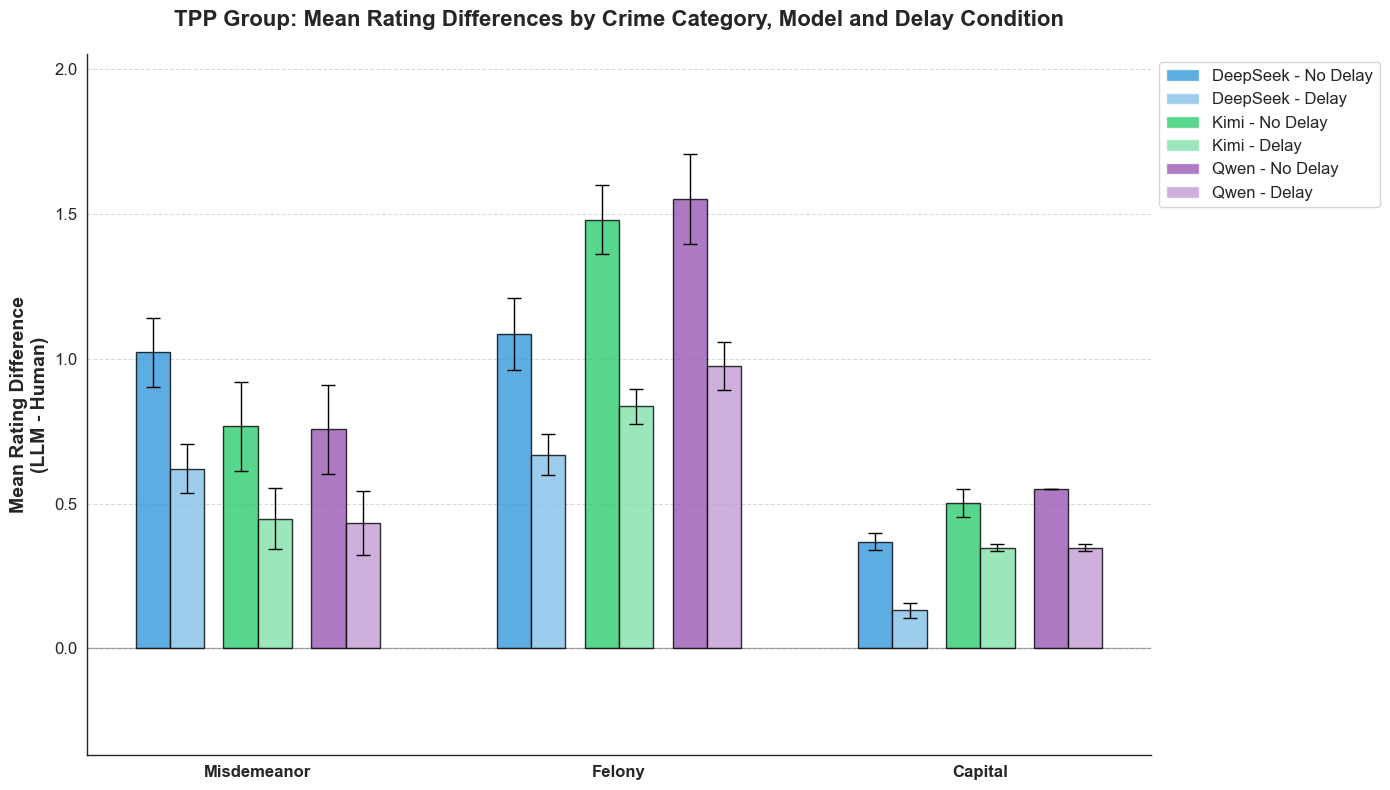


SPP组分析 (差值数据)

SPP组显著性检验结果 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=1.089, SD=1.152
  No Delay: N=540, Mean=0.999, SD=1.892
  Mann-Whitney U statistic=158875.000, p-value=0.0105
  显著性: *

Felony:
  Delay: N=540, Mean=1.375, SD=1.201
  No Delay: N=540, Mean=1.339, SD=1.843
  Mann-Whitney U statistic=132617.000, p-value=0.0099
  显著性: **

Capital:
  Delay: N=540, Mean=0.478, SD=0.399
  No Delay: N=540, Mean=0.383, SD=0.233
  Mann-Whitney U statistic=189813.000, p-value=0.0000
  显著性: ***
图片已保存至: SPP_multi_llm_rating_difference_bar.png


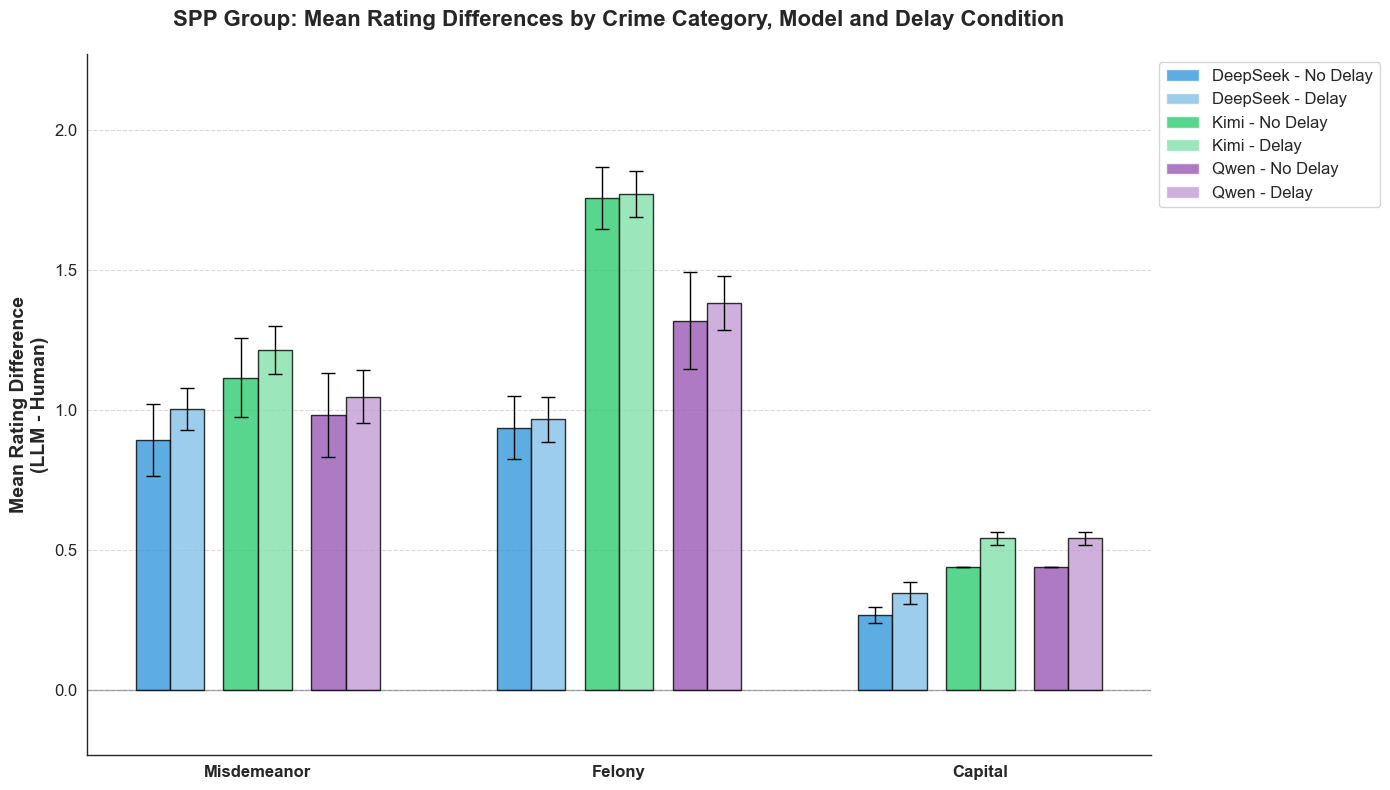


新增Delay vs No Delay差异分析 (差值数据)

TPP组 - 每个犯罪类别内Delay vs No Delay差异检验 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=0.500, SD=1.348
  No Delay: N=540, Mean=0.848, SD=1.912
  Mann-Whitney U statistic=131753.000, p-value=0.0060
  显著性: **

Felony:
  Delay: N=540, Mean=0.826, SD=0.966
  No Delay: N=540, Mean=1.372, SD=1.803
  Mann-Whitney U statistic=103263.000, p-value=0.0000
  显著性: ***

Capital:
  Delay: N=540, Mean=0.276, SD=0.268
  No Delay: N=540, Mean=0.474, SD=0.453
  Mann-Whitney U statistic=70698.000, p-value=0.0000
  显著性: ***

TPP组 - 每个模型内Delay vs No Delay差异检验 (差值数据)

DeepSeek:
  Delay: N=540, Mean=0.473, SD=0.904
  No Delay: N=540, Mean=0.825, SD=1.389
  Mann-Whitney U statistic=112080.000, p-value=0.0000
  显著性: ***

Kimi:
  Delay: N=540, Mean=0.544, SD=0.961
  No Delay: N=540, Mean=0.916, SD=1.604
  Mann-Whitney U statistic=114401.000, p-value=0.0000
  显著性: ***

Qwen:
  Delay: N=540, Mean=0.585, SD=1.109
  No Delay: N=540, Mean=0.953, SD=1.735
  Mann-Whitney U statistic=122868.000, 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kruskal
import os

# --- 1. 读取多个LLM数据文件 ---
# 定义要读取的LLM数据文件
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']

# 读取并合并所有LLM数据
all_llm_data = []

for file_path, model_name in zip(llm_files, llm_names):
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path)
        df_temp['Model'] = model_name  # 添加模型名称列
        all_llm_data.append(df_temp)
        print(f"成功读取 {model_name} 数据，数据量: {len(df_temp)}")
    else:
        print(f"警告: 文件 {file_path} 不存在")

# 合并所有数据
if all_llm_data:
    df_llm = pd.concat(all_llm_data, ignore_index=True)
    print(f"\n合并后的总数据量: {len(df_llm)}")
else:
    raise FileNotFoundError("没有找到任何数据文件")

print("成功读取所有LLM数据。")
print("-" * 50)

# --- 读取人类数据 ---
# 假设人类数据文件路径，请根据实际情况修改
human_files = {
    'TPP': './human_tpp_data.csv',  # 请替换为实际的人类TPP数据文件路径
    'SPP': './human_spp_data.csv'   # 请替换为实际的人类SPP数据文件路径
}

# 读取人类数据
human_data = {}
for role, file_path in human_files.items():
    if os.path.exists(file_path):
        human_data[role] = pd.read_csv(file_path)
        print(f"成功读取人类{role}数据，数据量: {len(human_data[role])}")
    else:
        print(f"警告: 人类{role}数据文件 {file_path} 不存在")
        # 创建空DataFrame作为占位符
        human_data[role] = pd.DataFrame()

print("-" * 50)

# --- 2. 数据预处理 ---
def prepare_llm_data(df):
    """准备LLM数据用于分析"""
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

def prepare_human_data(df):
    """准备人类数据用于分析"""
    if df.empty:
        return df
        
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

# 准备数据
tpp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'TPP'])
spp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'SPP'])
tpp_human_data = prepare_human_data(human_data.get('TPP', pd.DataFrame()))
spp_human_data = prepare_human_data(human_data.get('SPP', pd.DataFrame()))

print("数据预处理完成。")
print("-" * 50)

# --- 3. 计算差值 ---
def calculate_difference(llm_df, human_df, role_name):
    """
    计算LLM评分与人类评分的差值
    返回包含差值的新DataFrame
    """
    if human_df.empty:
        print(f"警告: 没有人类{role_name}数据，无法计算差值")
        return pd.DataFrame()
    
    # 复制LLM数据
    diff_df = llm_df.copy()
    
    # 计算每个条件下的平均人类评分
    human_means = human_df.groupby(['Category', 'Delay_Info'])['Rating'].mean().reset_index()
    human_means.rename(columns={'Rating': 'Human_Mean_Rating'}, inplace=True)
    
    # 合并人类平均评分到LLM数据
    diff_df = diff_df.merge(human_means, on=['Category', 'Delay_Info'], how='left')
    
    # 计算差值 (LLM评分 - 人类平均评分)
    diff_df['Rating_Difference'] = diff_df['Rating'] - diff_df['Human_Mean_Rating']
    
    print(f"{role_name}组 - 成功计算差值，有效数据量: {len(diff_df)}")
    
    return diff_df

# 计算TPP和SPP组的差值
tpp_diff_data = calculate_difference(tpp_llm_data, tpp_human_data, "TPP")
spp_diff_data = calculate_difference(spp_llm_data, spp_human_data, "SPP")

# 检查数据中的Role列
print("TPP差值数据量:", len(tpp_diff_data))
print("SPP差值数据量:", len(spp_diff_data))
print("Model列的唯一值:", df_llm['Model'].unique())
print("-" * 50)

# 按模型统计
for model in llm_names:
    tpp_model = tpp_diff_data[tpp_diff_data['Model'] == model]
    spp_model = spp_diff_data[spp_diff_data['Model'] == model]
    print(f"{model}: TPP差值数据={len(tpp_model)}, SPP差值数据={len(spp_model)}")

print("-" * 50)

# --- 4. 数据准备：添加分类标签 ---
def prepare_plot_data(df):
    """准备可视化数据，添加分类标签"""
    if df.empty:
        return df
        
    df = df.copy()
    
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
    df['Category_Label'] = df['Category'].map(category_map)
    
    df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
    
    df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
    
    return df

tpp_plot_data = prepare_plot_data(tpp_diff_data)
spp_plot_data = prepare_plot_data(spp_diff_data)

print(f"TPP组差值数据量: {len(tpp_plot_data)}")
print(f"SPP组差值数据量: {len(spp_plot_data)}")

# --- 5. 显著性检验函数 ---
def perform_significance_tests(df, group_name):
    """
    对每个Category内的Delay vs No Delay进行Mann-Whitney U检验
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组显著性检验结果 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    
    for cat in categories:
        cat_data = df[df['Category_Label'] == cat]
        
        delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Rating_Difference'].dropna()
        no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Rating_Difference'].dropna()
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"\n{cat}:")
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Category': cat,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print(f"\n{cat}: 数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 6. 修改后的可视化函数：使用柱状图 ---
def create_multi_llm_bar_plot(df, group_name, save_path=None):
    """
    创建多LLM数据的柱状图可视化
    - 每个犯罪类别内显示三个模型
    - 每个模型内显示Delay和No Delay的均值
    - 添加误差线和显著性标记
    - 使用差值数据进行可视化
    """
    if df.empty:
        print(f"警告: {group_name}组没有数据，无法生成图表")
        return
        
    # 设置图形样式
    sns.set_style("white")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 定义类别顺序和模型顺序
    category_order = ['Misdemeanor', 'Felony', 'Capital']
    model_order = llm_names
    
    # 定义颜色方案
    colors = {
        'DeepSeek': {'No Delay': '#3498db', 'Delay': '#85c1e9'},  # 蓝色系
        'Kimi': {'No Delay': '#2ecc71', 'Delay': '#82e0aa'},      # 绿色系
        'Qwen': {'No Delay': '#9b59b6', 'Delay': '#c39bd3'}       # 紫色系
    }
    
    # 准备数据：计算每个组的均值和标准差
    plot_data = df.dropna(subset=['Rating_Difference', 'Category_Label', 'Delay_Label', 'Model'])
    
    # 计算统计量
    summary_stats = plot_data.groupby(['Category_Label', 'Model', 'Delay_Label'])['Rating_Difference'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    
    # 计算标准误差
    summary_stats['se'] = summary_stats['std'] / np.sqrt(summary_stats['count'])
    
    # 设置柱状图位置
    bar_width = 0.35
    gap_between_models = 0.2
    gap_between_categories = 1.0
    
    # 计算每个类别内的位置
    positions = {}
    current_pos = 0
    
    for cat_idx, cat in enumerate(category_order):
        positions[cat] = {}
        for model_idx, model in enumerate(model_order):
            # 每个模型在类别内的位置
            base_pos = current_pos + model_idx * (2 * bar_width + gap_between_models)
            positions[cat][model] = {
                'No Delay': base_pos,
                'Delay': base_pos + bar_width
            }
        current_pos += len(model_order) * (2 * bar_width + gap_between_models) + gap_between_categories
    
    # 绘制柱状图
    for cat in category_order:
        for model in model_order:
            for delay_cond in ['No Delay', 'Delay']:
                # 获取数据
                stats_row = summary_stats[
                    (summary_stats['Category_Label'] == cat) & 
                    (summary_stats['Model'] == model) & 
                    (summary_stats['Delay_Label'] == delay_cond)
                ]
                
                if len(stats_row) > 0:
                    mean_val = stats_row['mean'].values[0]
                    se_val = stats_row['se'].values[0]
                    pos = positions[cat][model][delay_cond]
                    
                    # 绘制柱状图
                    ax.bar(pos, mean_val, bar_width, 
                          color=colors[model][delay_cond],
                          alpha=0.8,
                          edgecolor='black',
                          linewidth=1,
                          label=f'{model} - {delay_cond}' if cat == category_order[0] and model == model_order[0] else "")
                    
                    # 添加误差线
                    ax.errorbar(pos, mean_val, yerr=se_val, 
                               fmt='none', color='black', capsize=5, capthick=1, linewidth=1)
    
    # 添加显著性标记（基于之前的检验结果）
    # 这里可以添加代码来在柱状图上显示显著性标记
    
    # 设置x轴标签和刻度
    category_centers = []
    for cat in category_order:
        model_positions = [positions[cat][model]['No Delay'] + bar_width/2 for model in model_order]
        category_center = np.mean(model_positions)
        category_centers.append(category_center)
    
    ax.set_xticks(category_centers)
    ax.set_xticklabels(category_order, fontsize=14, fontweight='bold')
    
    # 设置y轴
    ax.set_ylabel('Mean Rating Difference\n(LLM - Human)', fontsize=14, fontweight='bold')
    
    # 根据数据范围动态调整y轴范围
    y_min = summary_stats['mean'].min() - 0.5
    y_max = summary_stats['mean'].max() + 0.5
    ax.set_ylim(y_min, y_max)
    
    # 添加水平参考线 (y=0)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # 添加网格线
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # 设置标题
    ax.set_title(f'{group_name} Group: Mean Rating Differences by Crime Category, Model and Delay Condition',
                fontsize=16, fontweight='bold', pad=20)
    
    # 创建图例
    from matplotlib.patches import Patch
    legend_elements = []
    for model in model_order:
        legend_elements.append(Patch(facecolor=colors[model]['No Delay'], alpha=0.8, 
                                   label=f'{model} - No Delay'))
        legend_elements.append(Patch(facecolor=colors[model]['Delay'], alpha=0.8,
                                   label=f'{model} - Delay'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # 设置刻度线
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图片已保存至: {save_path}")
    
    plt.show()

# --- 7. 模型间显著性检验函数 ---
def perform_model_comparison_tests(df, group_name):
    """
    对每个犯罪类别和延迟条件下的三个模型进行Kruskal-Wallis检验
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 模型间差异检验 (Kruskal-Wallis检验) - 差值数据")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    delay_conditions = ['No Delay', 'Delay']
    
    for cat in categories:
        for delay in delay_conditions:
            print(f"\n{cat} - {delay}:")
            
            # 收集三个模型的数据
            model_data = []
            model_names = []
            
            for model in llm_names:
                model_ratings = df[
                    (df['Category_Label'] == cat) & 
                    (df['Delay_Label'] == delay) &
                    (df['Model'] == model)
                ]['Rating_Difference'].dropna()
                
                if len(model_ratings) > 0:
                    model_data.append(model_ratings)
                    model_names.append(model)
                    
                    print(f"  {model}: N={len(model_ratings)}, Mean={model_ratings.mean():.3f}, SD={model_ratings.std():.3f}")
            
            # 如果有至少两个模型有数据，进行Kruskal-Wallis检验
            if len(model_data) >= 2:
                try:
                    # 执行Kruskal-Wallis检验
                    h_statistic, p_value = kruskal(*model_data)
                    
                    print(f"  Kruskal-Wallis H statistic={h_statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"  模型间显著性: {sig_label}")
                    
                    # 如果总体显著，进行两两比较
                    if p_value < 0.05 and len(model_data) == 3:
                        print("  进行两两比较 (Mann-Whitney U检验):")
                        from itertools import combinations
                        
                        for (i, j) in combinations(range(3), 2):
                            model1 = model_names[i]
                            model2 = model_names[j]
                            u_stat, p_val = stats.mannwhitneyu(model_data[i], model_data[j], alternative='two-sided')
                            
                            if p_val < 0.001:
                                pair_sig = '***'
                            elif p_val < 0.01:
                                pair_sig = '**'
                            elif p_val < 0.05:
                                pair_sig = '*'
                            else:
                                pair_sig = 'ns'
                                
                            print(f"    {model1} vs {model2}: p={p_val:.4f} {pair_sig}")
                    
                    results.append({
                        'Group': group_name,
                        'Category': cat,
                        'Delay_Condition': delay,
                        'H_statistic': h_statistic,
                        'p_value': p_value,
                        'significance': sig_label,
                        'Model1': model_names[0] if len(model_names) > 0 else '',
                        'Model1_N': len(model_data[0]) if len(model_data) > 0 else 0,
                        'Model1_Mean': model_data[0].mean() if len(model_data) > 0 else 0,
                        'Model2': model_names[1] if len(model_names) > 1 else '',
                        'Model2_N': len(model_data[1]) if len(model_data) > 1 else 0,
                        'Model2_Mean': model_data[1].mean() if len(model_data) > 1 else 0,
                        'Model3': model_names[2] if len(model_names) > 2 else '',
                        'Model3_N': len(model_data[2]) if len(model_data) > 2 else 0,
                        'Model3_Mean': model_data[2].mean() if len(model_data) > 2 else 0,
                    })
                    
                except Exception as e:
                    print(f"  检验出错: {e}")
            else:
                print("  数据不足，无法进行模型间比较")
    
    return pd.DataFrame(results)

# --- 8. 新增：计算每个犯罪类别内Delay vs No Delay的差异 ---
def perform_delay_vs_no_delay_by_category(df, group_name):
    """
    对每个犯罪类别，计算Delay vs No Delay的差异
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 每个犯罪类别内Delay vs No Delay差异检验 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    
    for cat in categories:
        print(f"\n{cat}:")
        
        # 获取该类别下的所有数据
        cat_data = df[df['Category_Label'] == cat]
        
        # 分离Delay和No Delay数据
        delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Rating_Difference'].dropna()
        no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Rating_Difference'].dropna()
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            # 执行Mann-Whitney U检验
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Group': group_name,
                'Category': cat,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print("  数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 9. 新增：计算三个大模型之间Delay和No Delay的差异 ---
def perform_delay_vs_no_delay_by_model(df, group_name):
    """
    对每个模型，计算Delay vs No Delay的差异
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 每个模型内Delay vs No Delay差异检验 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    
    for model in llm_names:
        print(f"\n{model}:")
        
        # 获取该模型下的所有数据
        model_data = df[df['Model'] == model]
        
        # 分离Delay和No Delay数据
        delay_data = model_data[model_data['Delay_Label'] == 'Delay']['Rating_Difference'].dropna()
        no_delay_data = model_data[model_data['Delay_Label'] == 'No Delay']['Rating_Difference'].dropna()
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            # 执行Mann-Whitney U检验
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Group': group_name,
                'Model': model,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print("  数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 10. 执行可视化和统计检验 ---

# TPP组
print("\n" + "="*60)
print("TPP组分析 (差值数据)")
print("="*60)
if not tpp_plot_data.empty:
    tpp_results = perform_significance_tests(tpp_plot_data, "TPP")
    create_multi_llm_bar_plot(tpp_plot_data, "TPP", save_path="TPP_multi_llm_rating_difference_bar.png")
else:
    print("TPP组没有差值数据，跳过分析")

# SPP组
print("\n" + "="*60)
print("SPP组分析 (差值数据)")
print("="*60)
if not spp_plot_data.empty:
    spp_results = perform_significance_tests(spp_plot_data, "SPP")
    create_multi_llm_bar_plot(spp_plot_data, "SPP", save_path="SPP_multi_llm_rating_difference_bar.png")
else:
    print("SPP组没有差值数据，跳过分析")

# --- 11. 执行新增的Delay vs No Delay检验 ---
print("\n" + "="*60)
print("新增Delay vs No Delay差异分析 (差值数据)")
print("="*60)

# TPP组
if not tpp_plot_data.empty:
    tpp_delay_by_category = perform_delay_vs_no_delay_by_category(tpp_plot_data, "TPP")
    tpp_delay_by_model = perform_delay_vs_no_delay_by_model(tpp_plot_data, "TPP")
else:
    tpp_delay_by_category = pd.DataFrame()
    tpp_delay_by_model = pd.DataFrame()

# SPP组
if not spp_plot_data.empty:
    spp_delay_by_category = perform_delay_vs_no_delay_by_category(spp_plot_data, "SPP")
    spp_delay_by_model = perform_delay_vs_no_delay_by_model(spp_plot_data, "SPP")
else:
    spp_delay_by_category = pd.DataFrame()
    spp_delay_by_model = pd.DataFrame()

# --- 12. 执行模型间比较检验 ---
print("\n" + "="*60)
print("模型间差异分析 (差值数据)")
print("="*60)

if not tpp_plot_data.empty:
    tpp_model_comparison = perform_model_comparison_tests(tpp_plot_data, "TPP")
else:
    tpp_model_comparison = pd.DataFrame()

if not spp_plot_data.empty:
    spp_model_comparison = perform_model_comparison_tests(spp_plot_data, "SPP")
else:
    spp_model_comparison = pd.DataFrame()

# --- 13. 按模型分别进行统计检验 ---
def perform_significance_tests_by_model(df, group_name):
    """对每个模型分别进行显著性检验"""
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 按模型显著性检验结果 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    all_results = []
    
    for model in llm_names:
        print(f"\n--- {model} ---")
        model_data = df[df['Model'] == model]
        model_results = perform_significance_tests(model_data, f"{group_name}-{model}")
        if not model_results.empty:
            model_results['Model'] = model
            all_results.append(model_results)
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    else:
        return pd.DataFrame()

# 执行按模型的统计检验
if not tpp_plot_data.empty:
    tpp_model_results = perform_significance_tests_by_model(tpp_plot_data, "TPP")
else:
    tpp_model_results = pd.DataFrame()

if not spp_plot_data.empty:
    spp_model_results = perform_significance_tests_by_model(spp_plot_data, "SPP")
else:
    spp_model_results = pd.DataFrame()

# --- 14. 组间比较分析 ---
def perform_group_comparison_by_category_and_model(tpp_df, spp_df):
    """
    对每个犯罪类别、延迟条件和模型进行TPP和SPP组间差异分析
    使用差值数据进行检验
    """
    print("\n" + "="*60)
    print("TPP vs SPP 组间差异分析（按模型）- 差值数据")
    print("="*60)
    
    if tpp_df.empty or spp_df.empty:
        print("TPP或SPP数据不足，无法进行组间比较")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    delay_conditions = ['No Delay', 'Delay']
    
    for model in llm_names:
        print(f"\n--- {model} ---")
        for cat in categories:
            for delay in delay_conditions:
                # 获取TPP组数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay) &
                    (tpp_df['Model'] == model)
                ]['Rating_Difference'].dropna()
                
                # 获取SPP组数据
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay) &
                    (spp_df['Model'] == model)
                ]['Rating_Difference'].dropna()
                
                if len(tpp_data) > 0 and len(spp_data) > 0:
                    # 执行Mann-Whitney U检验
                    statistic, p_value = stats.mannwhitneyu(tpp_data, spp_data, alternative='two-sided')
                    
                    tpp_mean = tpp_data.mean()
                    tpp_std = tpp_data.std()
                    spp_mean = spp_data.mean()
                    spp_std = spp_data.std()
                    
                    print(f"  {cat} - {delay}:")
                    print(f"    TPP: N={len(tpp_data)}, Mean={tpp_mean:.3f}, SD={tpp_std:.3f}")
                    print(f"    SPP: N={len(spp_data)}, Mean={spp_mean:.3f}, SD={spp_std:.3f}")
                    print(f"    Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"    显著性: {sig_label}")
                    
                    results.append({
                        'Model': model,
                        'Category': cat,
                        'Delay_Condition': delay,
                        'TPP_N': len(tpp_data),
                        'TPP_Mean': tpp_mean,
                        'TPP_SD': tpp_std,
                        'SPP_N': len(spp_data),
                        'SPP_Mean': spp_mean,
                        'SPP_SD': spp_std,
                        'U_statistic': statistic,
                        'p_value': p_value,
                        'significance': sig_label
                    })
                else:
                    print(f"  {cat} - {delay}: 数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# 执行组间比较分析
if not tpp_plot_data.empty and not spp_plot_data.empty:
    group_comparison_results = perform_group_comparison_by_category_and_model(tpp_plot_data, spp_plot_data)
else:
    group_comparison_results = pd.DataFrame()

# --- 15. 保存所有结果 ---
if not tpp_results.empty:
    tpp_results.to_csv("TPP_rating_difference_results.csv", index=False)
if not spp_results.empty:
    spp_results.to_csv("SPP_rating_difference_results.csv", index=False)
if not tpp_model_results.empty:
    tpp_model_results.to_csv("TPP_model_rating_difference_results.csv", index=False)
if not spp_model_results.empty:
    spp_model_results.to_csv("SPP_model_rating_difference_results.csv", index=False)
if not group_comparison_results.empty:
    group_comparison_results.to_csv("TPP_vs_SPP_difference_comparison_results.csv", index=False)
if not tpp_model_comparison.empty:
    tpp_model_comparison.to_csv("TPP_model_difference_comparison_results.csv", index=False)
if not spp_model_comparison.empty:
    spp_model_comparison.to_csv("SPP_model_difference_comparison_results.csv", index=False)
if not tpp_delay_by_category.empty:
    tpp_delay_by_category.to_csv("TPP_delay_by_category_difference_results.csv", index=False)
if not tpp_delay_by_model.empty:
    tpp_delay_by_model.to_csv("TPP_delay_by_model_difference_results.csv", index=False)
if not spp_delay_by_category.empty:
    spp_delay_by_category.to_csv("SPP_delay_by_category_difference_results.csv", index=False)
if not spp_delay_by_model.empty:
    spp_delay_by_model.to_csv("SPP_delay_by_model_difference_results.csv", index=False)

print("\n" + "="*60)
print("分析完成！所有结果已保存为CSV文件。")
print("="*60)

# --- 16. 数据汇总统计 ---
print("\n差值数据汇总统计:")
print("="*40)
for model in llm_names:
    for role_data, role_name in [(tpp_diff_data, "TPP"), (spp_diff_data, "SPP")]:
        if not role_data.empty:
            model_data = role_data[role_data['Model'] == model]
            print(f"{model} - {role_name}: {len(model_data)} 条差值数据")
            
            for cat in [1, 2, 3]:
                for delay in [0, 1]:
                    cat_data = model_data[(model_data['Category'] == cat) & (model_data['Delay_Info'] == delay)]
                    cat_label = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}[cat]
                    delay_label = 'No Delay' if delay == 0 else 'Delay'
                    if len(cat_data) > 0:
                        mean_diff = cat_data['Rating_Difference'].mean()
                        print(f"  {cat_label} - {delay_label}: {len(cat_data)} 条数据, 平均差值={mean_diff:.3f}")
                    else:
                        print(f"  {cat_label} - {delay_label}: 0 条数据")

成功读取 DeepSeek 数据，数据量: 2160
成功读取 Kimi 数据，数据量: 2160
成功读取 Qwen 数据，数据量: 2160

合并后的总数据量: 6480
成功读取所有LLM数据。
--------------------------------------------------
成功读取人类TPP数据，数据量: 1620
成功读取人类SPP数据，数据量: 1404
--------------------------------------------------
数据预处理完成。
--------------------------------------------------
TPP组 - 成功计算差值，有效数据量: 3240
SPP组 - 成功计算差值，有效数据量: 3240
TPP差值数据量: 3240
SPP差值数据量: 3240
Model列的唯一值: ['DeepSeek' 'Kimi' 'Qwen']
--------------------------------------------------
DeepSeek: TPP差值数据=1080, SPP差值数据=1080
Kimi: TPP差值数据=1080, SPP差值数据=1080
Qwen: TPP差值数据=1080, SPP差值数据=1080
--------------------------------------------------
TPP组差值数据量: 3240
SPP组差值数据量: 3240

TPP组分析 - 差值是否显著区别于0

TPP组 - 差值是否显著区别于0的检验结果

--- DeepSeek ---
  Misdemeanor - No Delay:
    N=180, Mean=1.022, SD=1.596
    95% CI=[0.787, 1.257]
    t(179)=8.593, p-value=0.0000
    显著性: ***
  Misdemeanor - Delay:
    N=180, Mean=0.620, SD=1.123
    95% CI=[0.455, 0.785]
    t(179)=7.415, p-value=0.0000
    显著性: ***
  Felony - No 

c:\Users\47648\anaconda3\envs\basic\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\47648\anaconda3\envs\basic\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\47648\anaconda3\envs\basic\lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


图片已保存至: TPP_rating_difference_significance.png


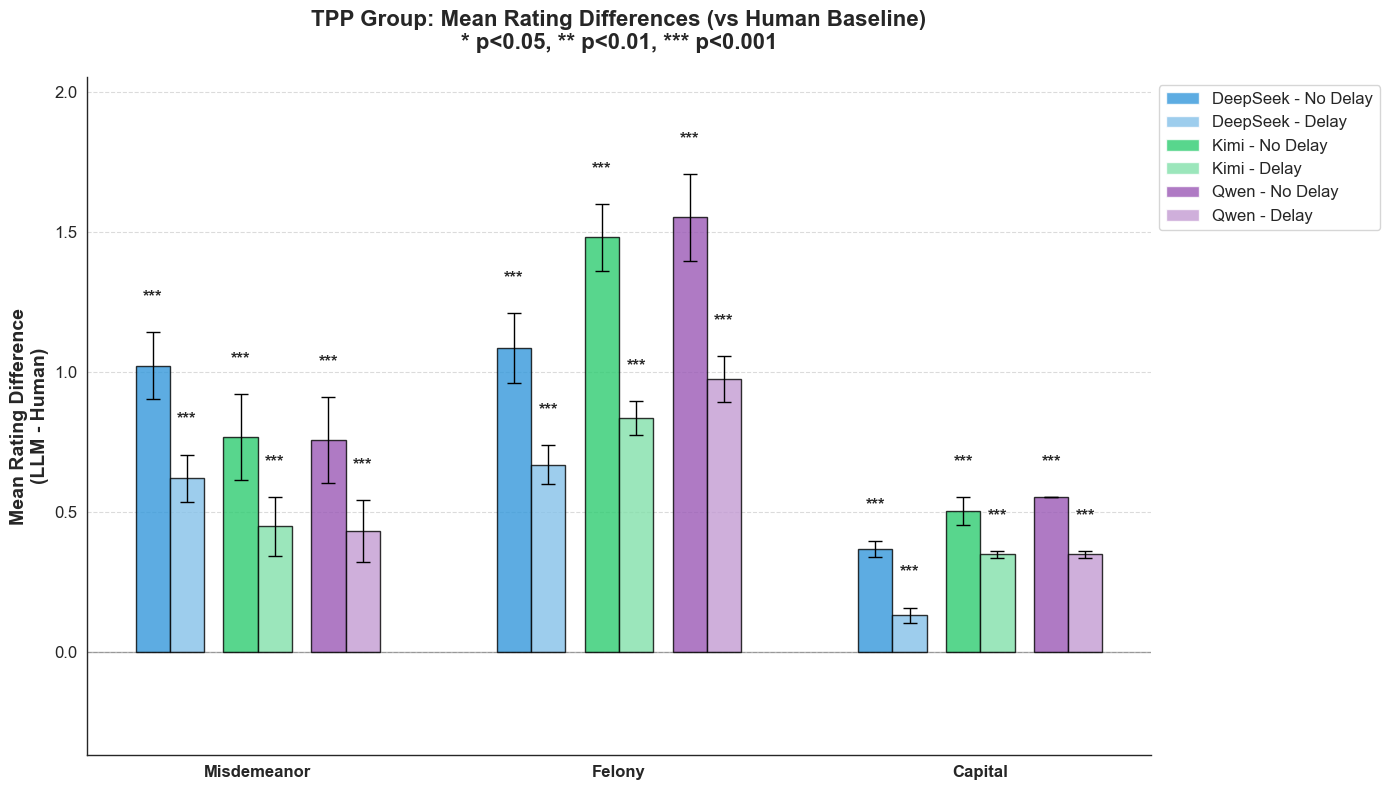


SPP组分析 - 差值是否显著区别于0

SPP组 - 差值是否显著区别于0的检验结果

--- DeepSeek ---
  Misdemeanor - No Delay:
    N=180, Mean=0.895, SD=1.737
    95% CI=[0.639, 1.150]
    t(179)=6.910, p-value=0.0000
    显著性: ***
  Misdemeanor - Delay:
    N=180, Mean=1.004, SD=0.997
    95% CI=[0.857, 1.151]
    t(179)=13.506, p-value=0.0000
    显著性: ***
  Felony - No Delay:
    N=180, Mean=0.938, SD=1.517
    95% CI=[0.714, 1.161]
    t(179)=8.290, p-value=0.0000
    显著性: ***
  Felony - Delay:
    N=180, Mean=0.968, SD=1.069
    95% CI=[0.811, 1.125]
    t(179)=12.144, p-value=0.0000
    显著性: ***
  Capital - No Delay:
    N=180, Mean=0.268, SD=0.379
    95% CI=[0.212, 0.324]
    t(179)=9.495, p-value=0.0000
    显著性: ***
  Capital - Delay:
    N=180, Mean=0.348, SD=0.522
    95% CI=[0.272, 0.425]
    t(179)=8.954, p-value=0.0000
    显著性: ***

--- Kimi ---
  Misdemeanor - No Delay:
    N=180, Mean=1.117, SD=1.904
    95% CI=[0.837, 1.397]
    t(179)=7.870, p-value=0.0000
    显著性: ***
  Misdemeanor - Delay:
    N=180, Mean

c:\Users\47648\anaconda3\envs\basic\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


图片已保存至: SPP_rating_difference_significance.png


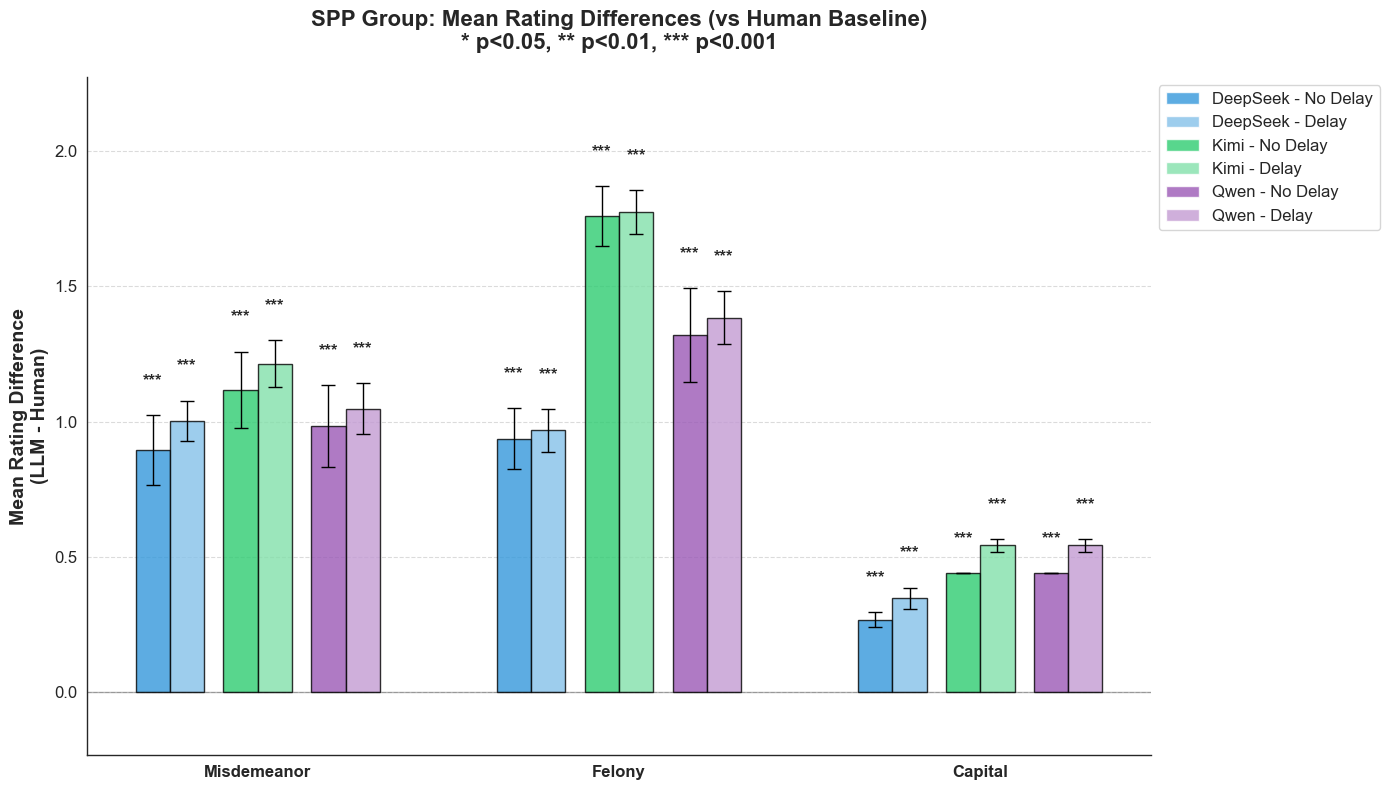

TPP组结果已保存至: TPP_difference_from_zero_results.csv
SPP组结果已保存至: SPP_difference_from_zero_results.csv

分析完成！

差值数据汇总统计:
DeepSeek - TPP: 1080 条差值数据
  Misdemeanor - No Delay: 180 条数据, 平均差值=1.022
  Misdemeanor - Delay: 0 条数据
  Felony - No Delay: 180 条数据, 平均差值=1.085
  Felony - Delay: 20 条数据, 平均差值=0.367
  Capital - No Delay: 180 条数据, 平均差值=0.369
  Capital - Delay: 0 条数据
DeepSeek - SPP: 1080 条差值数据
  Misdemeanor - No Delay: 180 条数据, 平均差值=0.895
  Misdemeanor - Delay: 0 条数据
  Felony - No Delay: 180 条数据, 平均差值=0.938
  Felony - Delay: 20 条数据, 平均差值=1.396
  Capital - No Delay: 180 条数据, 平均差值=0.268
  Capital - Delay: 0 条数据
Kimi - TPP: 1080 条差值数据
  Misdemeanor - No Delay: 180 条数据, 平均差值=0.767
  Misdemeanor - Delay: 0 条数据
  Felony - No Delay: 180 条数据, 平均差值=1.480
  Felony - Delay: 20 条数据, 平均差值=0.867
  Capital - No Delay: 180 条数据, 平均差值=0.502
  Capital - Delay: 0 条数据
Kimi - SPP: 1080 条差值数据
  Misdemeanor - No Delay: 180 条数据, 平均差值=1.117
  Misdemeanor - Delay: 0 条数据
  Felony - No Delay: 180 条数据, 平均差值=1.760
  Felony

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

# --- 1. 读取多个LLM数据文件 ---
# 定义要读取的LLM数据文件
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']

# 读取并合并所有LLM数据
all_llm_data = []

for file_path, model_name in zip(llm_files, llm_names):
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path)
        df_temp['Model'] = model_name  # 添加模型名称列
        all_llm_data.append(df_temp)
        print(f"成功读取 {model_name} 数据，数据量: {len(df_temp)}")
    else:
        print(f"警告: 文件 {file_path} 不存在")

# 合并所有数据
if all_llm_data:
    df_llm = pd.concat(all_llm_data, ignore_index=True)
    print(f"\n合并后的总数据量: {len(df_llm)}")
else:
    raise FileNotFoundError("没有找到任何数据文件")

print("成功读取所有LLM数据。")
print("-" * 50)

# --- 读取人类数据 ---
# 假设人类数据文件路径，请根据实际情况修改
human_files = {
    'TPP': './human_tpp_data.csv',  # 请替换为实际的人类TPP数据文件路径
    'SPP': './human_spp_data.csv'   # 请替换为实际的人类SPP数据文件路径
}

# 读取人类数据
human_data = {}
for role, file_path in human_files.items():
    if os.path.exists(file_path):
        human_data[role] = pd.read_csv(file_path)
        print(f"成功读取人类{role}数据，数据量: {len(human_data[role])}")
    else:
        print(f"警告: 人类{role}数据文件 {file_path} 不存在")
        # 创建空DataFrame作为占位符
        human_data[role] = pd.DataFrame()

print("-" * 50)

# --- 2. 数据预处理 ---
def prepare_llm_data(df):
    """准备LLM数据用于分析"""
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

def prepare_human_data(df):
    """准备人类数据用于分析"""
    if df.empty:
        return df
        
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Rating' in df_clean.columns:
        df_clean['Rating'] = pd.to_numeric(df_clean['Rating'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

# 准备数据
tpp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'TPP'])
spp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'SPP'])
tpp_human_data = prepare_human_data(human_data.get('TPP', pd.DataFrame()))
spp_human_data = prepare_human_data(human_data.get('SPP', pd.DataFrame()))

print("数据预处理完成。")
print("-" * 50)

# --- 3. 计算差值 ---
def calculate_difference(llm_df, human_df, role_name):
    """
    计算LLM评分与人类评分的差值
    返回包含差值的新DataFrame
    """
    if human_df.empty:
        print(f"警告: 没有人类{role_name}数据，无法计算差值")
        return pd.DataFrame()
    
    # 复制LLM数据
    diff_df = llm_df.copy()
    
    # 计算每个条件下的平均人类评分
    human_means = human_df.groupby(['Category', 'Delay_Info'])['Rating'].mean().reset_index()
    human_means.rename(columns={'Rating': 'Human_Mean_Rating'}, inplace=True)
    
    # 合并人类平均评分到LLM数据
    diff_df = diff_df.merge(human_means, on=['Category', 'Delay_Info'], how='left')
    
    # 计算差值 (LLM评分 - 人类平均评分)
    diff_df['Rating_Difference'] = diff_df['Rating'] - diff_df['Human_Mean_Rating']
    
    print(f"{role_name}组 - 成功计算差值，有效数据量: {len(diff_df)}")
    
    return diff_df

# 计算TPP和SPP组的差值
tpp_diff_data = calculate_difference(tpp_llm_data, tpp_human_data, "TPP")
spp_diff_data = calculate_difference(spp_llm_data, spp_human_data, "SPP")

# 检查数据中的Role列
print("TPP差值数据量:", len(tpp_diff_data))
print("SPP差值数据量:", len(spp_diff_data))
print("Model列的唯一值:", df_llm['Model'].unique())
print("-" * 50)

# 按模型统计
for model in llm_names:
    tpp_model = tpp_diff_data[tpp_diff_data['Model'] == model]
    spp_model = spp_diff_data[spp_diff_data['Model'] == model]
    print(f"{model}: TPP差值数据={len(tpp_model)}, SPP差值数据={len(spp_model)}")

print("-" * 50)

# --- 4. 数据准备：添加分类标签 ---
def prepare_plot_data(df):
    """准备可视化数据，添加分类标签"""
    if df.empty:
        return df
        
    df = df.copy()
    
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
    df['Category_Label'] = df['Category'].map(category_map)
    
    df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
    
    df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
    
    return df

tpp_plot_data = prepare_plot_data(tpp_diff_data)
spp_plot_data = prepare_plot_data(spp_diff_data)

print(f"TPP组差值数据量: {len(tpp_plot_data)}")
print(f"SPP组差值数据量: {len(spp_plot_data)}")

# --- 5. 显著性检验函数：检验差值是否显著区别于0 ---
def test_difference_from_zero(df, group_name):
    """
    对每个条件下的差值进行单样本t检验，检验是否显著区别于0
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 差值是否显著区别于0的检验结果")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    delay_conditions = ['No Delay', 'Delay']
    
    for model in llm_names:
        print(f"\n--- {model} ---")
        model_data = df[df['Model'] == model]
        
        for cat in categories:
            for delay in delay_conditions:
                # 获取该条件下的差值数据
                diff_data = model_data[
                    (model_data['Category_Label'] == cat) & 
                    (model_data['Delay_Label'] == delay)
                ]['Rating_Difference'].dropna()
                
                if len(diff_data) > 0:
                    # 单样本t检验，检验均值是否显著区别于0
                    t_statistic, p_value = stats.ttest_1samp(diff_data, 0)
                    
                    mean_diff = diff_data.mean()
                    std_diff = diff_data.std()
                    ci_low, ci_high = stats.t.interval(0.95, len(diff_data)-1, 
                                                     loc=mean_diff, scale=stats.sem(diff_data))
                    
                    print(f"  {cat} - {delay}:")
                    print(f"    N={len(diff_data)}, Mean={mean_diff:.3f}, SD={std_diff:.3f}")
                    print(f"    95% CI=[{ci_low:.3f}, {ci_high:.3f}]")
                    print(f"    t({len(diff_data)-1})={t_statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"    显著性: {sig_label}")
                    
                    results.append({
                        'Group': group_name,
                        'Model': model,
                        'Category': cat,
                        'Delay_Condition': delay,
                        'N': len(diff_data),
                        'Mean_Difference': mean_diff,
                        'SD': std_diff,
                        'CI_Lower': ci_low,
                        'CI_Upper': ci_high,
                        't_statistic': t_statistic,
                        'p_value': p_value,
                        'significance': sig_label
                    })
                else:
                    print(f"  {cat} - {delay}: 数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 6. 修改后的可视化函数：使用柱状图并标记显著性 ---
def create_multi_llm_bar_plot_with_significance(df, group_name, significance_results, save_path=None):
    """
    创建多LLM数据的柱状图可视化，并标记差值是否显著区别于0
    """
    if df.empty:
        print(f"警告: {group_name}组没有数据，无法生成图表")
        return
        
    # 设置图形样式
    sns.set_style("white")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 定义类别顺序和模型顺序
    category_order = ['Misdemeanor', 'Felony', 'Capital']
    model_order = llm_names
    
    # 定义颜色方案
    colors = {
        'DeepSeek': {'No Delay': '#3498db', 'Delay': '#85c1e9'},  # 蓝色系
        'Kimi': {'No Delay': '#2ecc71', 'Delay': '#82e0aa'},      # 绿色系
        'Qwen': {'No Delay': '#9b59b6', 'Delay': '#c39bd3'}       # 紫色系
    }
    
    # 准备数据：计算每个组的均值和标准差
    plot_data = df.dropna(subset=['Rating_Difference', 'Category_Label', 'Delay_Label', 'Model'])
    
    # 计算统计量
    summary_stats = plot_data.groupby(['Category_Label', 'Model', 'Delay_Label'])['Rating_Difference'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    
    # 计算标准误差
    summary_stats['se'] = summary_stats['std'] / np.sqrt(summary_stats['count'])
    
    # 设置柱状图位置
    bar_width = 0.35
    gap_between_models = 0.2
    gap_between_categories = 1.0
    
    # 计算每个类别内的位置
    positions = {}
    current_pos = 0
    
    for cat_idx, cat in enumerate(category_order):
        positions[cat] = {}
        for model_idx, model in enumerate(model_order):
            # 每个模型在类别内的位置
            base_pos = current_pos + model_idx * (2 * bar_width + gap_between_models)
            positions[cat][model] = {
                'No Delay': base_pos,
                'Delay': base_pos + bar_width
            }
        current_pos += len(model_order) * (2 * bar_width + gap_between_models) + gap_between_categories
    
    # 绘制柱状图
    for cat in category_order:
        for model in model_order:
            for delay_cond in ['No Delay', 'Delay']:
                # 获取数据
                stats_row = summary_stats[
                    (summary_stats['Category_Label'] == cat) & 
                    (summary_stats['Model'] == model) & 
                    (summary_stats['Delay_Label'] == delay_cond)
                ]
                
                if len(stats_row) > 0:
                    mean_val = stats_row['mean'].values[0]
                    se_val = stats_row['se'].values[0]
                    pos = positions[cat][model][delay_cond]
                    
                    # 绘制柱状图
                    ax.bar(pos, mean_val, bar_width, 
                          color=colors[model][delay_cond],
                          alpha=0.8,
                          edgecolor='black',
                          linewidth=1,
                          label=f'{model} - {delay_cond}' if cat == category_order[0] and model == model_order[0] else "")
                    
                    # 添加误差线
                    ax.errorbar(pos, mean_val, yerr=se_val, 
                               fmt='none', color='black', capsize=5, capthick=1, linewidth=1)
                    
                    # 添加显著性标记
                    sig_result = significance_results[
                        (significance_results['Category'] == cat) & 
                        (significance_results['Model'] == model) & 
                        (significance_results['Delay_Condition'] == delay_cond)
                    ]
                    
                    if not sig_result.empty:
                        sig_label = sig_result['significance'].values[0]
                        if sig_label != 'ns':
                            # 在柱子上方添加显著性标记
                            y_pos = mean_val + se_val + 0.1
                            ax.text(pos, y_pos, sig_label, 
                                   ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # 设置x轴标签和刻度
    category_centers = []
    for cat in category_order:
        model_positions = [positions[cat][model]['No Delay'] + bar_width/2 for model in model_order]
        category_center = np.mean(model_positions)
        category_centers.append(category_center)
    
    ax.set_xticks(category_centers)
    ax.set_xticklabels(category_order, fontsize=14, fontweight='bold')
    
    # 设置y轴
    ax.set_ylabel('Mean Rating Difference\n(LLM - Human)', fontsize=14, fontweight='bold')
    
    # 根据数据范围动态调整y轴范围
    y_min = summary_stats['mean'].min() - 0.5
    y_max = summary_stats['mean'].max() + 0.5
    ax.set_ylim(y_min, y_max)
    
    # 添加水平参考线 (y=0)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # 添加网格线
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # 设置标题
    ax.set_title(f'{group_name} Group: Mean Rating Differences (vs Human Baseline)\n* p<0.05, ** p<0.01, *** p<0.001',
                fontsize=16, fontweight='bold', pad=20)
    
    # 创建图例
    from matplotlib.patches import Patch
    legend_elements = []
    for model in model_order:
        legend_elements.append(Patch(facecolor=colors[model]['No Delay'], alpha=0.8, 
                                   label=f'{model} - No Delay'))
        legend_elements.append(Patch(facecolor=colors[model]['Delay'], alpha=0.8,
                                   label=f'{model} - Delay'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # 设置刻度线
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图片已保存至: {save_path}")
    
    plt.show()

# --- 7. 执行统计检验和可视化 ---

# TPP组
print("\n" + "="*60)
print("TPP组分析 - 差值是否显著区别于0")
print("="*60)
if not tpp_plot_data.empty:
    tpp_significance_results = test_difference_from_zero(tpp_plot_data, "TPP")
    create_multi_llm_bar_plot_with_significance(tpp_plot_data, "TPP", tpp_significance_results, 
                                              save_path="TPP_rating_difference_significance.png")
else:
    print("TPP组没有差值数据，跳过分析")

# SPP组
print("\n" + "="*60)
print("SPP组分析 - 差值是否显著区别于0")
print("="*60)
if not spp_plot_data.empty:
    spp_significance_results = test_difference_from_zero(spp_plot_data, "SPP")
    create_multi_llm_bar_plot_with_significance(spp_plot_data, "SPP", spp_significance_results,
                                              save_path="SPP_rating_difference_significance.png")
else:
    print("SPP组没有差值数据，跳过分析")

# --- 8. 保存结果 ---
if 'tpp_significance_results' in locals() and not tpp_significance_results.empty:
    tpp_significance_results.to_csv("TPP_difference_from_zero_results.csv", index=False)
    print("TPP组结果已保存至: TPP_difference_from_zero_results.csv")

if 'spp_significance_results' in locals() and not spp_significance_results.empty:
    spp_significance_results.to_csv("SPP_difference_from_zero_results.csv", index=False)
    print("SPP组结果已保存至: SPP_difference_from_zero_results.csv")

print("\n" + "="*60)
print("分析完成！")
print("="*60)

# --- 9. 数据汇总统计 ---
print("\n差值数据汇总统计:")
print("="*40)
for model in llm_names:
    for role_data, role_name in [(tpp_diff_data, "TPP"), (spp_diff_data, "SPP")]:
        if not role_data.empty:
            model_data = role_data[role_data['Model'] == model]
            print(f"{model} - {role_name}: {len(model_data)} 条差值数据")
            
            for cat in [1, 2, 3]:
                for delay in [0, 1]:
                    cat_data = model_data[(model_data['Category'] == cat) & (model_data['Delay_Info'] == delay)]
                    cat_label = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}[cat]
                    delay_label = 'No Delay' if delay == 0 else 'Delay'
                    if len(cat_data) > 0:
                        mean_diff = cat_data['Rating_Difference'].mean()
                        print(f"  {cat_label} - {delay_label}: {len(cat_data)} 条数据, 平均差值={mean_diff:.3f}")
                    else:
                        print(f"  {cat_label} - {delay_label}: 0 条数据")

成功读取 DeepSeek 数据，数据量: 2160
成功读取 Kimi 数据，数据量: 2160
成功读取 Qwen 数据，数据量: 2160

合并后的总数据量: 6480
成功读取所有LLM数据。
--------------------------------------------------
成功读取人类TPP数据，数据量: 1620
成功读取人类SPP数据，数据量: 1404
--------------------------------------------------
数据预处理完成。
--------------------------------------------------
TPP组 - 成功计算差值，有效数据量: 3240
SPP组 - 成功计算差值，有效数据量: 3240
TPP差值数据量: 3240
SPP差值数据量: 3240
Model列的唯一值: ['DeepSeek' 'Kimi' 'Qwen']
--------------------------------------------------
DeepSeek: TPP差值数据=1080, SPP差值数据=1080
Kimi: TPP差值数据=1080, SPP差值数据=1080
Qwen: TPP差值数据=1080, SPP差值数据=1080
--------------------------------------------------
TPP组差值数据量: 3240
SPP组差值数据量: 3240

TPP组分析 (差值数据)

TPP组显著性检验结果 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=0.139, SD=1.193
  No Delay: N=540, Mean=0.407, SD=1.619
  Mann-Whitney U statistic=132128.000, p-value=0.0075
  显著性: **

Felony:
  Delay: N=540, Mean=0.809, SD=1.195
  No Delay: N=540, Mean=1.352, SD=1.677
  Mann-Whitney U statistic=109109.000, p-value=0.0000
  显著

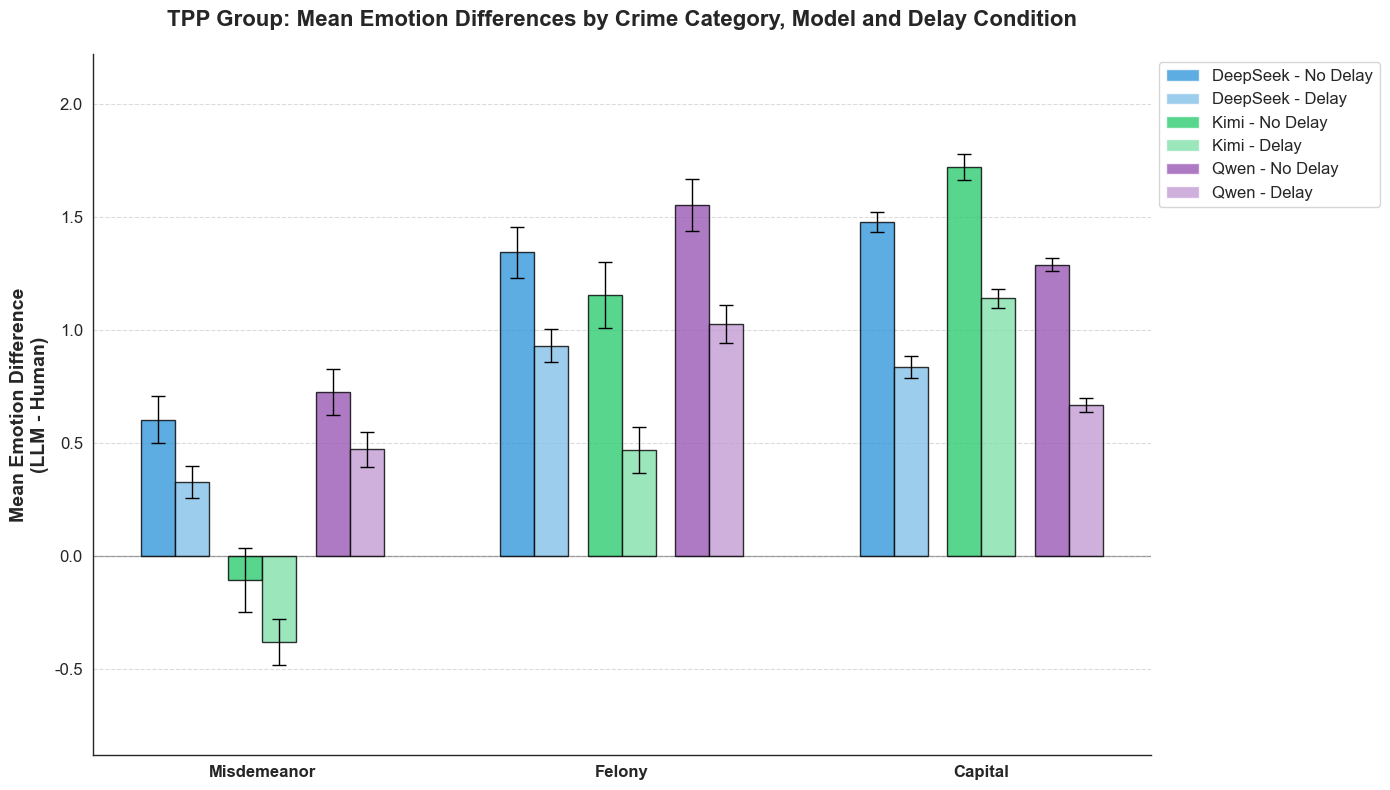


SPP组分析 (差值数据)

SPP组显著性检验结果 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=2.320, SD=1.434
  No Delay: N=540, Mean=1.230, SD=1.878
  Mann-Whitney U statistic=197026.000, p-value=0.0000
  显著性: ***

Felony:
  Delay: N=540, Mean=2.089, SD=1.235
  No Delay: N=540, Mean=1.371, SD=1.342
  Mann-Whitney U statistic=181550.000, p-value=0.0000
  显著性: ***

Capital:
  Delay: N=540, Mean=0.491, SD=0.632
  No Delay: N=540, Mean=0.577, SD=0.554
  Mann-Whitney U statistic=126596.000, p-value=0.0001
  显著性: ***
图片已保存至: SPP_multi_llm_emotion_difference_bar.png


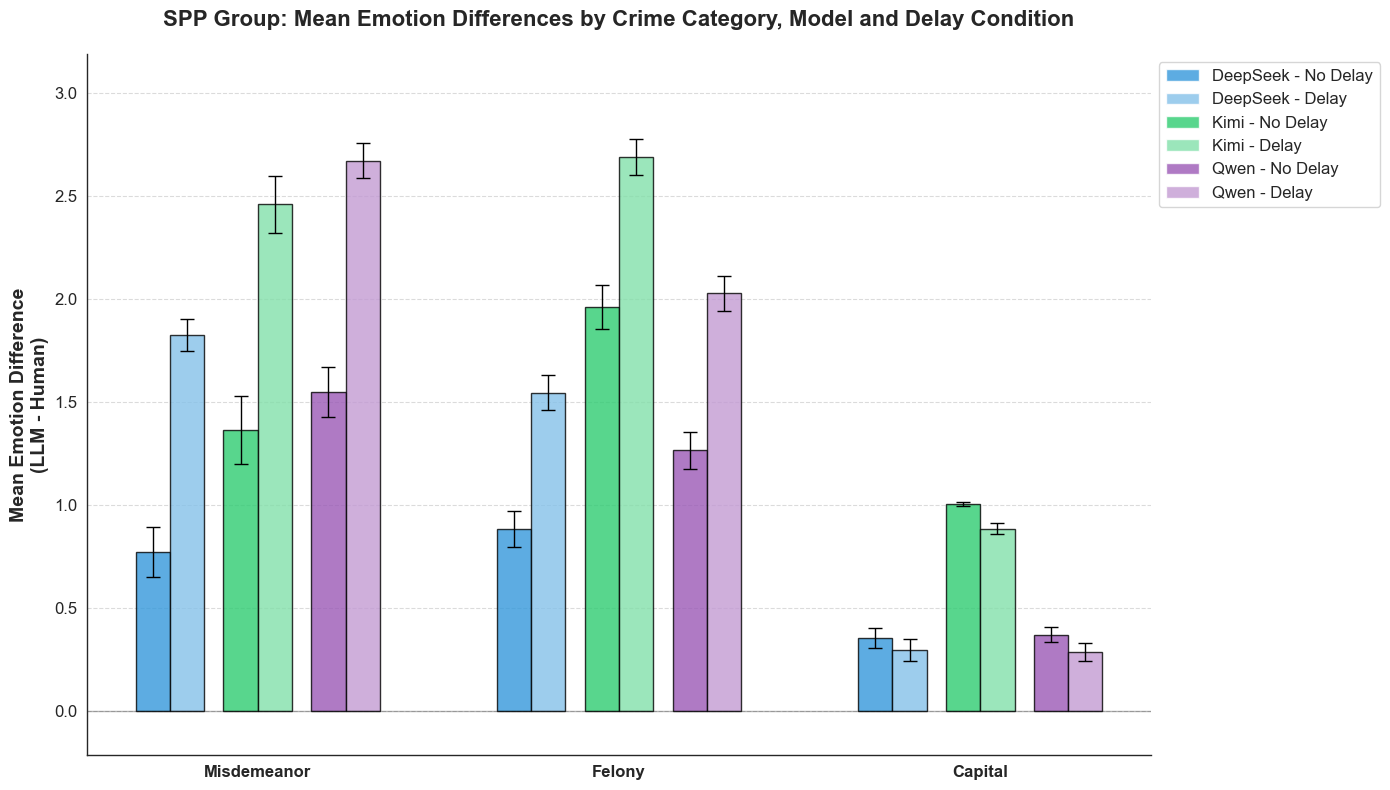


新增Delay vs No Delay差异分析 (差值数据)

TPP组 - 每个犯罪类别内Delay vs No Delay差异检验 (差值数据)

Misdemeanor:
  Delay: N=540, Mean=0.139, SD=1.193
  No Delay: N=540, Mean=0.407, SD=1.619
  Mann-Whitney U statistic=132128.000, p-value=0.0075
  显著性: **

Felony:
  Delay: N=540, Mean=0.809, SD=1.195
  No Delay: N=540, Mean=1.352, SD=1.677
  Mann-Whitney U statistic=109109.000, p-value=0.0000
  显著性: ***

Capital:
  Delay: N=540, Mean=0.881, SD=0.581
  No Delay: N=540, Mean=1.498, SD=0.634
  Mann-Whitney U statistic=62906.000, p-value=0.0000
  显著性: ***

TPP组 - 每个模型内Delay vs No Delay差异检验 (差值数据)

DeepSeek:
  Delay: N=540, Mean=0.698, SD=0.909
  No Delay: N=540, Mean=1.143, SD=1.297
  Mann-Whitney U statistic=103145.000, p-value=0.0000
  显著性: ***

Kimi:
  Delay: N=540, Mean=0.409, SD=1.318
  No Delay: N=540, Mean=0.924, SD=1.797
  Mann-Whitney U statistic=114889.000, p-value=0.0000
  显著性: ***

Qwen:
  Delay: N=540, Mean=0.722, SD=0.949
  No Delay: N=540, Mean=1.191, SD=1.260
  Mann-Whitney U statistic=104251.000, 

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kruskal
import os

# --- 1. 读取多个LLM数据文件 ---
# 定义要读取的LLM数据文件
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']

# 读取并合并所有LLM数据
all_llm_data = []

for file_path, model_name in zip(llm_files, llm_names):
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path)
        df_temp['Model'] = model_name  # 添加模型名称列
        all_llm_data.append(df_temp)
        print(f"成功读取 {model_name} 数据，数据量: {len(df_temp)}")
    else:
        print(f"警告: 文件 {file_path} 不存在")

# 合并所有数据
if all_llm_data:
    df_llm = pd.concat(all_llm_data, ignore_index=True)
    print(f"\n合并后的总数据量: {len(df_llm)}")
else:
    raise FileNotFoundError("没有找到任何数据文件")

print("成功读取所有LLM数据。")
print("-" * 50)

# --- 读取人类数据 ---
# 假设人类数据文件路径，请根据实际情况修改
human_files = {
    'TPP': './human_tpp_data.csv',  # 请替换为实际的人类TPP数据文件路径
    'SPP': './human_spp_data.csv'   # 请替换为实际的人类SPP数据文件路径
}

# 读取人类数据
human_data = {}
for role, file_path in human_files.items():
    if os.path.exists(file_path):
        human_data[role] = pd.read_csv(file_path)
        print(f"成功读取人类{role}数据，数据量: {len(human_data[role])}")
    else:
        print(f"警告: 人类{role}数据文件 {file_path} 不存在")
        # 创建空DataFrame作为占位符
        human_data[role] = pd.DataFrame()

print("-" * 50)

# --- 2. 数据预处理 ---
def prepare_llm_data(df):
    """准备LLM数据用于分析"""
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Emotion' in df_clean.columns:  # 修改：Rating -> Emotion
        df_clean['Emotion'] = pd.to_numeric(df_clean['Emotion'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

def prepare_human_data(df):
    """准备人类数据用于分析"""
    if df.empty:
        return df
        
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Emotion' in df_clean.columns:  # 修改：Rating -> Emotion
        df_clean['Emotion'] = pd.to_numeric(df_clean['Emotion'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

# 准备数据
tpp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'TPP'])
spp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'SPP'])
tpp_human_data = prepare_human_data(human_data.get('TPP', pd.DataFrame()))
spp_human_data = prepare_human_data(human_data.get('SPP', pd.DataFrame()))

print("数据预处理完成。")
print("-" * 50)

# --- 3. 计算差值 ---
def calculate_difference(llm_df, human_df, role_name):
    """
    计算LLM情感评分与人类情感评分的差值
    返回包含差值的新DataFrame
    """
    if human_df.empty:
        print(f"警告: 没有人类{role_name}数据，无法计算差值")
        return pd.DataFrame()
    
    # 复制LLM数据
    diff_df = llm_df.copy()
    
    # 计算每个条件下的平均人类情感评分
    human_means = human_df.groupby(['Category', 'Delay_Info'])['Emotion'].mean().reset_index()  # 修改：Rating -> Emotion
    human_means.rename(columns={'Emotion': 'Human_Mean_Emotion'}, inplace=True)  # 修改：Rating -> Emotion
    
    # 合并人类平均情感评分到LLM数据
    diff_df = diff_df.merge(human_means, on=['Category', 'Delay_Info'], how='left')
    
    # 计算差值 (LLM情感评分 - 人类平均情感评分)
    diff_df['Emotion_Difference'] = diff_df['Emotion'] - diff_df['Human_Mean_Emotion']  # 修改：Rating -> Emotion
    
    print(f"{role_name}组 - 成功计算差值，有效数据量: {len(diff_df)}")
    
    return diff_df

# 计算TPP和SPP组的差值
tpp_diff_data = calculate_difference(tpp_llm_data, tpp_human_data, "TPP")
spp_diff_data = calculate_difference(spp_llm_data, spp_human_data, "SPP")

# 检查数据中的Role列
print("TPP差值数据量:", len(tpp_diff_data))
print("SPP差值数据量:", len(spp_diff_data))
print("Model列的唯一值:", df_llm['Model'].unique())
print("-" * 50)

# 按模型统计
for model in llm_names:
    tpp_model = tpp_diff_data[tpp_diff_data['Model'] == model]
    spp_model = spp_diff_data[spp_diff_data['Model'] == model]
    print(f"{model}: TPP差值数据={len(tpp_model)}, SPP差值数据={len(spp_model)}")

print("-" * 50)

# --- 4. 数据准备：添加分类标签 ---
def prepare_plot_data(df):
    """准备可视化数据，添加分类标签"""
    if df.empty:
        return df
        
    df = df.copy()
    
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
    df['Category_Label'] = df['Category'].map(category_map)
    
    df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
    
    df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
    
    return df

tpp_plot_data = prepare_plot_data(tpp_diff_data)
spp_plot_data = prepare_plot_data(spp_diff_data)

print(f"TPP组差值数据量: {len(tpp_plot_data)}")
print(f"SPP组差值数据量: {len(spp_plot_data)}")

# --- 5. 显著性检验函数 ---
def perform_significance_tests(df, group_name):
    """
    对每个Category内的Delay vs No Delay进行Mann-Whitney U检验
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组显著性检验结果 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    
    for cat in categories:
        cat_data = df[df['Category_Label'] == cat]
        
        delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"\n{cat}:")
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Category': cat,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print(f"\n{cat}: 数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 6. 修改后的可视化函数：使用柱状图 ---
def create_multi_llm_bar_plot(df, group_name, save_path=None):
    """
    创建多LLM数据的柱状图可视化
    - 每个犯罪类别内显示三个模型
    - 每个模型内显示Delay和No Delay的均值
    - 添加误差线和显著性标记
    - 使用差值数据进行可视化
    """
    if df.empty:
        print(f"警告: {group_name}组没有数据，无法生成图表")
        return
        
    # 设置图形样式
    sns.set_style("white")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.unicode_minus'] = False
    
    # 创建图形
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # 定义类别顺序和模型顺序
    category_order = ['Misdemeanor', 'Felony', 'Capital']
    model_order = llm_names
    
    # 定义颜色方案
    colors = {
        'DeepSeek': {'No Delay': '#3498db', 'Delay': '#85c1e9'},  # 蓝色系
        'Kimi': {'No Delay': '#2ecc71', 'Delay': '#82e0aa'},      # 绿色系
        'Qwen': {'No Delay': '#9b59b6', 'Delay': '#c39bd3'}       # 紫色系
    }
    
    # 准备数据：计算每个组的均值和标准差
    plot_data = df.dropna(subset=['Emotion_Difference', 'Category_Label', 'Delay_Label', 'Model'])  # 修改：Rating -> Emotion
    
    # 计算统计量
    summary_stats = plot_data.groupby(['Category_Label', 'Model', 'Delay_Label'])['Emotion_Difference'].agg([  # 修改：Rating -> Emotion
        'mean', 'std', 'count'
    ]).reset_index()
    
    # 计算标准误差
    summary_stats['se'] = summary_stats['std'] / np.sqrt(summary_stats['count'])
    
    # 设置柱状图位置
    bar_width = 0.35
    gap_between_models = 0.2
    gap_between_categories = 1.0
    
    # 计算每个类别内的位置
    positions = {}
    current_pos = 0
    
    for cat_idx, cat in enumerate(category_order):
        positions[cat] = {}
        for model_idx, model in enumerate(model_order):
            # 每个模型在类别内的位置
            base_pos = current_pos + model_idx * (2 * bar_width + gap_between_models)
            positions[cat][model] = {
                'No Delay': base_pos,
                'Delay': base_pos + bar_width
            }
        current_pos += len(model_order) * (2 * bar_width + gap_between_models) + gap_between_categories
    
    # 绘制柱状图
    for cat in category_order:
        for model in model_order:
            for delay_cond in ['No Delay', 'Delay']:
                # 获取数据
                stats_row = summary_stats[
                    (summary_stats['Category_Label'] == cat) & 
                    (summary_stats['Model'] == model) & 
                    (summary_stats['Delay_Label'] == delay_cond)
                ]
                
                if len(stats_row) > 0:
                    mean_val = stats_row['mean'].values[0]
                    se_val = stats_row['se'].values[0]
                    pos = positions[cat][model][delay_cond]
                    
                    # 绘制柱状图
                    ax.bar(pos, mean_val, bar_width, 
                          color=colors[model][delay_cond],
                          alpha=0.8,
                          edgecolor='black',
                          linewidth=1,
                          label=f'{model} - {delay_cond}' if cat == category_order[0] and model == model_order[0] else "")
                    
                    # 添加误差线
                    ax.errorbar(pos, mean_val, yerr=se_val, 
                               fmt='none', color='black', capsize=5, capthick=1, linewidth=1)
    
    # 添加显著性标记（基于之前的检验结果）
    # 这里可以添加代码来在柱状图上显示显著性标记
    
    # 设置x轴标签和刻度
    category_centers = []
    for cat in category_order:
        model_positions = [positions[cat][model]['No Delay'] + bar_width/2 for model in model_order]
        category_center = np.mean(model_positions)
        category_centers.append(category_center)
    
    ax.set_xticks(category_centers)
    ax.set_xticklabels(category_order, fontsize=14, fontweight='bold')
    
    # 设置y轴
    ax.set_ylabel('Mean Emotion Difference\n(LLM - Human)', fontsize=14, fontweight='bold')  # 修改：Rating -> Emotion
    
    # 根据数据范围动态调整y轴范围
    y_min = summary_stats['mean'].min() - 0.5
    y_max = summary_stats['mean'].max() + 0.5
    ax.set_ylim(y_min, y_max)
    
    # 添加水平参考线 (y=0)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    # 添加网格线
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    
    # 设置标题
    ax.set_title(f'{group_name} Group: Mean Emotion Differences by Crime Category, Model and Delay Condition',  # 修改：Rating -> Emotion
                fontsize=16, fontweight='bold', pad=20)
    
    # 创建图例
    from matplotlib.patches import Patch
    legend_elements = []
    for model in model_order:
        legend_elements.append(Patch(facecolor=colors[model]['No Delay'], alpha=0.8, 
                                   label=f'{model} - No Delay'))
        legend_elements.append(Patch(facecolor=colors[model]['Delay'], alpha=0.8,
                                   label=f'{model} - Delay'))
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    # 美化边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # 设置刻度线
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图片已保存至: {save_path}")
    
    plt.show()

# --- 7. 模型间显著性检验函数 ---
def perform_model_comparison_tests(df, group_name):
    """
    对每个犯罪类别和延迟条件下的三个模型进行Kruskal-Wallis检验
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 模型间差异检验 (Kruskal-Wallis检验) - 差值数据")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    delay_conditions = ['No Delay', 'Delay']
    
    for cat in categories:
        for delay in delay_conditions:
            print(f"\n{cat} - {delay}:")
            
            # 收集三个模型的数据
            model_data = []
            model_names = []
            
            for model in llm_names:
                model_emotions = df[  # 修改：Rating -> Emotion
                    (df['Category_Label'] == cat) & 
                    (df['Delay_Label'] == delay) &
                    (df['Model'] == model)
                ]['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
                
                if len(model_emotions) > 0:
                    model_data.append(model_emotions)
                    model_names.append(model)
                    
                    print(f"  {model}: N={len(model_emotions)}, Mean={model_emotions.mean():.3f}, SD={model_emotions.std():.3f}")
            
            # 如果有至少两个模型有数据，进行Kruskal-Wallis检验
            if len(model_data) >= 2:
                try:
                    # 执行Kruskal-Wallis检验
                    h_statistic, p_value = kruskal(*model_data)
                    
                    print(f"  Kruskal-Wallis H statistic={h_statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"  模型间显著性: {sig_label}")
                    
                    # 如果总体显著，进行两两比较
                    if p_value < 0.05 and len(model_data) == 3:
                        print("  进行两两比较 (Mann-Whitney U检验):")
                        from itertools import combinations
                        
                        for (i, j) in combinations(range(3), 2):
                            model1 = model_names[i]
                            model2 = model_names[j]
                            u_stat, p_val = stats.mannwhitneyu(model_data[i], model_data[j], alternative='two-sided')
                            
                            if p_val < 0.001:
                                pair_sig = '***'
                            elif p_val < 0.01:
                                pair_sig = '**'
                            elif p_val < 0.05:
                                pair_sig = '*'
                            else:
                                pair_sig = 'ns'
                                
                            print(f"    {model1} vs {model2}: p={p_val:.4f} {pair_sig}")
                    
                    results.append({
                        'Group': group_name,
                        'Category': cat,
                        'Delay_Condition': delay,
                        'H_statistic': h_statistic,
                        'p_value': p_value,
                        'significance': sig_label,
                        'Model1': model_names[0] if len(model_names) > 0 else '',
                        'Model1_N': len(model_data[0]) if len(model_data) > 0 else 0,
                        'Model1_Mean': model_data[0].mean() if len(model_data) > 0 else 0,
                        'Model2': model_names[1] if len(model_names) > 1 else '',
                        'Model2_N': len(model_data[1]) if len(model_data) > 1 else 0,
                        'Model2_Mean': model_data[1].mean() if len(model_data) > 1 else 0,
                        'Model3': model_names[2] if len(model_names) > 2 else '',
                        'Model3_N': len(model_data[2]) if len(model_data) > 2 else 0,
                        'Model3_Mean': model_data[2].mean() if len(model_data) > 2 else 0,
                    })
                    
                except Exception as e:
                    print(f"  检验出错: {e}")
            else:
                print("  数据不足，无法进行模型间比较")
    
    return pd.DataFrame(results)

# --- 8. 新增：计算每个犯罪类别内Delay vs No Delay的差异 ---
def perform_delay_vs_no_delay_by_category(df, group_name):
    """
    对每个犯罪类别，计算Delay vs No Delay的差异
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 每个犯罪类别内Delay vs No Delay差异检验 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    
    for cat in categories:
        print(f"\n{cat}:")
        
        # 获取该类别下的所有数据
        cat_data = df[df['Category_Label'] == cat]
        
        # 分离Delay和No Delay数据
        delay_data = cat_data[cat_data['Delay_Label'] == 'Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        no_delay_data = cat_data[cat_data['Delay_Label'] == 'No Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            # 执行Mann-Whitney U检验
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Group': group_name,
                'Category': cat,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print("  数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 9. 新增：计算三个大模型之间Delay和No Delay的差异 ---
def perform_delay_vs_no_delay_by_model(df, group_name):
    """
    对每个模型，计算Delay vs No Delay的差异
    使用差值数据进行检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 每个模型内Delay vs No Delay差异检验 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    
    for model in llm_names:
        print(f"\n{model}:")
        
        # 获取该模型下的所有数据
        model_data = df[df['Model'] == model]
        
        # 分离Delay和No Delay数据
        delay_data = model_data[model_data['Delay_Label'] == 'Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        no_delay_data = model_data[model_data['Delay_Label'] == 'No Delay']['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
        
        if len(delay_data) > 0 and len(no_delay_data) > 0:
            # 执行Mann-Whitney U检验
            statistic, p_value = stats.mannwhitneyu(delay_data, no_delay_data, alternative='two-sided')
            
            delay_mean = delay_data.mean()
            delay_std = delay_data.std()
            no_delay_mean = no_delay_data.mean()
            no_delay_std = no_delay_data.std()
            
            print(f"  Delay: N={len(delay_data)}, Mean={delay_mean:.3f}, SD={delay_std:.3f}")
            print(f"  No Delay: N={len(no_delay_data)}, Mean={no_delay_mean:.3f}, SD={no_delay_std:.3f}")
            print(f"  Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
            
            if p_value < 0.001:
                sig_label = '***'
            elif p_value < 0.01:
                sig_label = '**'
            elif p_value < 0.05:
                sig_label = '*'
            else:
                sig_label = 'ns'
            
            print(f"  显著性: {sig_label}")
            
            results.append({
                'Group': group_name,
                'Model': model,
                'Delay_N': len(delay_data),
                'Delay_Mean': delay_mean,
                'Delay_SD': delay_std,
                'NoDelay_N': len(no_delay_data),
                'NoDelay_Mean': no_delay_mean,
                'NoDelay_SD': no_delay_std,
                'U_statistic': statistic,
                'p_value': p_value,
                'significance': sig_label
            })
        else:
            print("  数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# --- 10. 执行可视化和统计检验 ---

# TPP组
print("\n" + "="*60)
print("TPP组分析 (差值数据)")
print("="*60)
if not tpp_plot_data.empty:
    tpp_results = perform_significance_tests(tpp_plot_data, "TPP")
    create_multi_llm_bar_plot(tpp_plot_data, "TPP", save_path="TPP_multi_llm_emotion_difference_bar.png")  # 修改文件名
else:
    print("TPP组没有差值数据，跳过分析")

# SPP组
print("\n" + "="*60)
print("SPP组分析 (差值数据)")
print("="*60)
if not spp_plot_data.empty:
    spp_results = perform_significance_tests(spp_plot_data, "SPP")
    create_multi_llm_bar_plot(spp_plot_data, "SPP", save_path="SPP_multi_llm_emotion_difference_bar.png")  # 修改文件名
else:
    print("SPP组没有差值数据，跳过分析")

# --- 11. 执行新增的Delay vs No Delay检验 ---
print("\n" + "="*60)
print("新增Delay vs No Delay差异分析 (差值数据)")
print("="*60)

# TPP组
if not tpp_plot_data.empty:
    tpp_delay_by_category = perform_delay_vs_no_delay_by_category(tpp_plot_data, "TPP")
    tpp_delay_by_model = perform_delay_vs_no_delay_by_model(tpp_plot_data, "TPP")
else:
    tpp_delay_by_category = pd.DataFrame()
    tpp_delay_by_model = pd.DataFrame()

# SPP组
if not spp_plot_data.empty:
    spp_delay_by_category = perform_delay_vs_no_delay_by_category(spp_plot_data, "SPP")
    spp_delay_by_model = perform_delay_vs_no_delay_by_model(spp_plot_data, "SPP")
else:
    spp_delay_by_category = pd.DataFrame()
    spp_delay_by_model = pd.DataFrame()

# --- 12. 执行模型间比较检验 ---
print("\n" + "="*60)
print("模型间差异分析 (差值数据)")
print("="*60)

if not tpp_plot_data.empty:
    tpp_model_comparison = perform_model_comparison_tests(tpp_plot_data, "TPP")
else:
    tpp_model_comparison = pd.DataFrame()

if not spp_plot_data.empty:
    spp_model_comparison = perform_model_comparison_tests(spp_plot_data, "SPP")
else:
    spp_model_comparison = pd.DataFrame()

# --- 13. 按模型分别进行统计检验 ---
def perform_significance_tests_by_model(df, group_name):
    """对每个模型分别进行显著性检验"""
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 按模型显著性检验结果 (差值数据)")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    all_results = []
    
    for model in llm_names:
        print(f"\n--- {model} ---")
        model_data = df[df['Model'] == model]
        model_results = perform_significance_tests(model_data, f"{group_name}-{model}")
        if not model_results.empty:
            model_results['Model'] = model
            all_results.append(model_results)
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    else:
        return pd.DataFrame()

# 执行按模型的统计检验
if not tpp_plot_data.empty:
    tpp_model_results = perform_significance_tests_by_model(tpp_plot_data, "TPP")
else:
    tpp_model_results = pd.DataFrame()

if not spp_plot_data.empty:
    spp_model_results = perform_significance_tests_by_model(spp_plot_data, "SPP")
else:
    spp_model_results = pd.DataFrame()

# --- 14. 组间比较分析 ---
def perform_group_comparison_by_category_and_model(tpp_df, spp_df):
    """
    对每个犯罪类别、延迟条件和模型进行TPP和SPP组间差异分析
    使用差值数据进行检验
    """
    print("\n" + "="*60)
    print("TPP vs SPP 组间差异分析（按模型）- 差值数据")
    print("="*60)
    
    if tpp_df.empty or spp_df.empty:
        print("TPP或SPP数据不足，无法进行组间比较")
        return pd.DataFrame()
    
    results = []
    categories = ['Misdemeanor', 'Felony', 'Capital']
    delay_conditions = ['No Delay', 'Delay']
    
    for model in llm_names:
        print(f"\n--- {model} ---")
        for cat in categories:
            for delay in delay_conditions:
                # 获取TPP组数据
                tpp_data = tpp_df[
                    (tpp_df['Category_Label'] == cat) & 
                    (tpp_df['Delay_Label'] == delay) &
                    (tpp_df['Model'] == model)
                ]['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
                
                # 获取SPP组数据
                spp_data = spp_df[
                    (spp_df['Category_Label'] == cat) & 
                    (spp_df['Delay_Label'] == delay) &
                    (spp_df['Model'] == model)
                ]['Emotion_Difference'].dropna()  # 修改：Rating -> Emotion
                
                if len(tpp_data) > 0 and len(spp_data) > 0:
                    # 执行Mann-Whitney U检验
                    statistic, p_value = stats.mannwhitneyu(tpp_data, spp_data, alternative='two-sided')
                    
                    tpp_mean = tpp_data.mean()
                    tpp_std = tpp_data.std()
                    spp_mean = spp_data.mean()
                    spp_std = spp_data.std()
                    
                    print(f"  {cat} - {delay}:")
                    print(f"    TPP: N={len(tpp_data)}, Mean={tpp_mean:.3f}, SD={tpp_std:.3f}")
                    print(f"    SPP: N={len(spp_data)}, Mean={spp_mean:.3f}, SD={spp_std:.3f}")
                    print(f"    Mann-Whitney U statistic={statistic:.3f}, p-value={p_value:.4f}")
                    
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"    显著性: {sig_label}")
                    
                    results.append({
                        'Model': model,
                        'Category': cat,
                        'Delay_Condition': delay,
                        'TPP_N': len(tpp_data),
                        'TPP_Mean': tpp_mean,
                        'TPP_SD': tpp_std,
                        'SPP_N': len(spp_data),
                        'SPP_Mean': spp_mean,
                        'SPP_SD': spp_std,
                        'U_statistic': statistic,
                        'p_value': p_value,
                        'significance': sig_label
                    })
                else:
                    print(f"  {cat} - {delay}: 数据不足，无法进行检验")
    
    return pd.DataFrame(results)

# 执行组间比较分析
if not tpp_plot_data.empty and not spp_plot_data.empty:
    group_comparison_results = perform_group_comparison_by_category_and_model(tpp_plot_data, spp_plot_data)
else:
    group_comparison_results = pd.DataFrame()

# --- 15. 保存所有结果 ---
if not tpp_results.empty:
    tpp_results.to_csv("TPP_emotion_difference_results.csv", index=False)  # 修改文件名
if not spp_results.empty:
    spp_results.to_csv("SPP_emotion_difference_results.csv", index=False)  # 修改文件名
if not tpp_model_results.empty:
    tpp_model_results.to_csv("TPP_model_emotion_difference_results.csv", index=False)  # 修改文件名
if not spp_model_results.empty:
    spp_model_results.to_csv("SPP_model_emotion_difference_results.csv", index=False)  # 修改文件名
if not group_comparison_results.empty:
    group_comparison_results.to_csv("TPP_vs_SPP_emotion_difference_comparison_results.csv", index=False)  # 修改文件名
if not tpp_model_comparison.empty:
    tpp_model_comparison.to_csv("TPP_model_emotion_difference_comparison_results.csv", index=False)  # 修改文件名
if not spp_model_comparison.empty:
    spp_model_comparison.to_csv("SPP_model_emotion_difference_comparison_results.csv", index=False)  # 修改文件名
if not tpp_delay_by_category.empty:
    tpp_delay_by_category.to_csv("TPP_delay_by_category_emotion_difference_results.csv", index=False)  # 修改文件名
if not tpp_delay_by_model.empty:
    tpp_delay_by_model.to_csv("TPP_delay_by_model_emotion_difference_results.csv", index=False)  # 修改文件名
if not spp_delay_by_category.empty:
    spp_delay_by_category.to_csv("SPP_delay_by_category_emotion_difference_results.csv", index=False)  # 修改文件名
if not spp_delay_by_model.empty:
    spp_delay_by_model.to_csv("SPP_delay_by_model_emotion_difference_results.csv", index=False)  # 修改文件名

print("\n" + "="*60)
print("分析完成！所有结果已保存为CSV文件。")
print("="*60)

# --- 16. 数据汇总统计 ---
print("\n情感差值数据汇总统计:")  # 修改：评分 -> 情感
print("="*40)
for model in llm_names:
    for role_data, role_name in [(tpp_diff_data, "TPP"), (spp_diff_data, "SPP")]:
        if not role_data.empty:
            model_data = role_data[role_data['Model'] == model]
            print(f"{model} - {role_name}: {len(model_data)} 条情感差值数据")  # 修改：评分 -> 情感
            
            for cat in [1, 2, 3]:
                for delay in [0, 1]:
                    cat_data = model_data[(model_data['Category'] == cat) & (model_data['Delay_Info'] == delay)]
                    cat_label = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}[cat]
                    delay_label = 'No Delay' if delay == 0 else 'Delay'
                    if len(cat_data) > 0:
                        mean_diff = cat_data['Emotion_Difference'].mean()  # 修改：Rating -> Emotion
                        print(f"  {cat_label} - {delay_label}: {len(cat_data)} 条数据, 平均情感差值={mean_diff:.3f}")  # 修改：评分 -> 情感
                    else:
                        print(f"  {cat_label} - {delay_label}: 0 条数据")

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

# --- 1. 读取多个LLM数据文件 ---
# 定义要读取的LLM数据文件
llm_files = [
    './DeepSeek-V3-Fast_organized_data.csv',
    './Kimi-K2-0905_organized_data.csv', 
    './Qwen3-235B-A22B-Instruct-2507_organized_data.csv'
]

llm_names = ['DeepSeek', 'Kimi', 'Qwen']

# 读取并合并所有LLM数据
all_llm_data = []

for file_path, model_name in zip(llm_files, llm_names):
    if os.path.exists(file_path):
        df_temp = pd.read_csv(file_path)
        df_temp['Model'] = model_name  # 添加模型名称列
        all_llm_data.append(df_temp)
        print(f"成功读取 {model_name} 数据，数据量: {len(df_temp)}")
    else:
        print(f"警告: 文件 {file_path} 不存在")

# 合并所有数据
if all_llm_data:
    df_llm = pd.concat(all_llm_data, ignore_index=True)
    print(f"\n合并后的总数据量: {len(df_llm)}")
else:
    raise FileNotFoundError("没有找到任何数据文件")

print("成功读取所有LLM数据。")
print("-" * 50)

# --- 读取人类数据 ---
# 假设人类数据文件路径，请根据实际情况修改
human_files = {
    'TPP': './human_tpp_data.csv',  # 请替换为实际的人类TPP数据文件路径
    'SPP': './human_spp_data.csv'   # 请替换为实际的人类SPP数据文件路径
}

# 读取人类数据
human_data = {}
for role, file_path in human_files.items():
    if os.path.exists(file_path):
        human_data[role] = pd.read_csv(file_path)
        print(f"成功读取人类{role}数据，数据量: {len(human_data[role])}")
    else:
        print(f"警告: 人类{role}数据文件 {file_path} 不存在")
        # 创建空DataFrame作为占位符
        human_data[role] = pd.DataFrame()

print("-" * 50)

# --- 2. 数据预处理 ---
def prepare_llm_data(df):
    """准备LLM数据用于分析"""
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Emotion' in df_clean.columns:
        df_clean['Emotion'] = pd.to_numeric(df_clean['Emotion'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

def prepare_human_data(df):
    """准备人类数据用于分析"""
    if df.empty:
        return df
        
    df_clean = df.copy()
    
    # 确保数据类型正确
    if 'Category' in df_clean.columns:
        df_clean['Category'] = pd.to_numeric(df_clean['Category'], errors='coerce')
    if 'Emotion' in df_clean.columns:
        df_clean['Emotion'] = pd.to_numeric(df_clean['Emotion'], errors='coerce')
    if 'Delay_Info' in df_clean.columns:
        df_clean['Delay_Info'] = pd.to_numeric(df_clean['Delay_Info'], errors='coerce')
    
    return df_clean

# 准备数据
tpp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'TPP'])
spp_llm_data = prepare_llm_data(df_llm[df_llm['Role'] == 'SPP'])
tpp_human_data = prepare_human_data(human_data.get('TPP', pd.DataFrame()))
spp_human_data = prepare_human_data(human_data.get('SPP', pd.DataFrame()))

print("数据预处理完成。")
print("-" * 50)

# --- 3. 计算差值 ---
def calculate_difference(llm_df, human_df, role_name):
    """
    计算LLM情感评分与人类情感评分的差值
    返回包含差值的新DataFrame
    """
    if human_df.empty:
        print(f"警告: 没有人类{role_name}数据，无法计算差值")
        return pd.DataFrame()
    
    # 复制LLM数据
    diff_df = llm_df.copy()
    
    # 计算每个条件下的平均人类情感评分
    human_means = human_df.groupby(['Category', 'Delay_Info'])['Emotion'].mean().reset_index()
    human_means.rename(columns={'Emotion': 'Human_Mean_Emotion'}, inplace=True)
    
    # 合并人类平均情感评分到LLM数据
    diff_df = diff_df.merge(human_means, on=['Category', 'Delay_Info'], how='left')
    
    # 计算差值 (LLM情感评分 - 人类平均情感评分)
    diff_df['Emotion_Difference'] = diff_df['Emotion'] - diff_df['Human_Mean_Emotion']
    
    print(f"{role_name}组 - 成功计算差值，有效数据量: {len(diff_df)}")
    
    return diff_df

# 计算TPP和SPP组的差值
tpp_diff_data = calculate_difference(tpp_llm_data, tpp_human_data, "TPP")
spp_diff_data = calculate_difference(spp_llm_data, spp_human_data, "SPP")

# 检查数据中的Role列
print("TPP差值数据量:", len(tpp_diff_data))
print("SPP差值数据量:", len(spp_diff_data))
print("Model列的唯一值:", df_llm['Model'].unique())
print("-" * 50)

# 按模型统计
for model in llm_names:
    tpp_model = tpp_diff_data[tpp_diff_data['Model'] == model]
    spp_model = spp_diff_data[spp_diff_data['Model'] == model]
    print(f"{model}: TPP差值数据={len(tpp_model)}, SPP差值数据={len(spp_model)}")

print("-" * 50)

# --- 4. 数据准备：添加分类标签 ---
def prepare_plot_data(df):
    """准备可视化数据，添加分类标签"""
    if df.empty:
        return df
        
    df = df.copy()
    
    category_map = {1: 'Misdemeanor', 2: 'Felony', 3: 'Capital'}
    df['Category_Label'] = df['Category'].map(category_map)
    
    df['Delay_Label'] = df['Delay_Info'].apply(lambda x: 'No Delay' if x == 0 else 'Delay')
    
    df['Combined_Label'] = df['Category_Label'] + '\n' + df['Delay_Label']
    
    return df

tpp_plot_data = prepare_plot_data(tpp_diff_data)
spp_plot_data = prepare_plot_data(spp_diff_data)

print(f"TPP组差值数据量: {len(tpp_plot_data)}")
print(f"SPP组差值数据量: {len(spp_plot_data)}")

# --- 5. 简化版显著性检验：检查差值是否显著区别于0 ---
def test_difference_from_zero(df, group_name):
    """
    对每个分组检查情感差值是否显著区别于0
    使用单样本Wilcoxon符号秩检验
    """
    print(f"\n{'='*60}")
    print(f"{group_name}组 - 情感差值是否显著区别于0检验")
    print(f"{'='*60}")
    
    if df.empty:
        print("没有数据可分析")
        return pd.DataFrame()
    
    results = []
    
    # 按模型、犯罪类别、延迟条件分组
    for model in llm_names:
        for category in ['Misdemeanor', 'Felony', 'Capital']:
            for delay in ['No Delay', 'Delay']:
                # 获取该分组的数据
                subset_data = df[
                    (df['Model'] == model) & 
                    (df['Category_Label'] == category) & 
                    (df['Delay_Label'] == delay)
                ]['Emotion_Difference'].dropna()
                
                if len(subset_data) > 0:
                    # 执行单样本Wilcoxon检验（检验中位数是否为0）
                    statistic, p_value = stats.wilcoxon(subset_data)
                    
                    mean_diff = subset_data.mean()
                    std_diff = subset_data.std()
                    median_diff = subset_data.median()
                    
                    print(f"{model} - {category} - {delay}:")
                    print(f"  样本量: {len(subset_data)}")
                    print(f"  均值: {mean_diff:.3f}, 标准差: {std_diff:.3f}, 中位数: {median_diff:.3f}")
                    print(f"  Wilcoxon统计量: {statistic:.3f}, p值: {p_value:.4f}")
                    
                    # 判断显著性
                    if p_value < 0.001:
                        sig_label = '***'
                    elif p_value < 0.01:
                        sig_label = '**'
                    elif p_value < 0.05:
                        sig_label = '*'
                    else:
                        sig_label = 'ns'
                    
                    print(f"  显著性: {sig_label}")
                    
                    # 解释结果
                    if p_value < 0.05:
                        if mean_diff > 0:
                            direction = "显著高于人类"
                        else:
                            direction = "显著低于人类"
                        print(f"  结论: LLM情感评分{direction}")
                    else:
                        print(f"  结论: LLM情感评分与人类无显著差异")
                    
                    print()
                    
                    results.append({
                        'Group': group_name,
                        'Model': model,
                        'Category': category,
                        'Delay_Condition': delay,
                        'N': len(subset_data),
                        'Mean_Difference': mean_diff,
                        'Std_Difference': std_diff,
                        'Median_Difference': median_diff,
                        'Wilcoxon_Statistic': statistic,
                        'p_value': p_value,
                        'Significance': sig_label,
                        'Direction': '高于人类' if (p_value < 0.05 and mean_diff > 0) else 
                                     '低于人类' if (p_value < 0.05 and mean_diff < 0) else 
                                     '无显著差异'
                    })
    
    return pd.DataFrame(results)

# --- 6. 执行简化版统计检验 ---

print("\n" + "="*80)
print("开始情感差值显著性检验（与0比较）")
print("="*80)

# TPP组检验
if not tpp_plot_data.empty:
    tpp_zero_test_results = test_difference_from_zero(tpp_plot_data, "TPP")
else:
    print("TPP组没有差值数据，跳过分析")
    tpp_zero_test_results = pd.DataFrame()

# SPP组检验
if not spp_plot_data.empty:
    spp_zero_test_results = test_difference_from_zero(spp_plot_data, "SPP")
else:
    print("SPP组没有差值数据，跳过分析")
    spp_zero_test_results = pd.DataFrame()

# --- 7. 保存结果 ---
if not tpp_zero_test_results.empty:
    tpp_zero_test_results.to_csv("TPP_emotion_difference_zero_test_results.csv", index=False)
    print("TPP组检验结果已保存至: TPP_emotion_difference_zero_test_results.csv")

if not spp_zero_test_results.empty:
    spp_zero_test_results.to_csv("SPP_emotion_difference_zero_test_results.csv", index=False)
    print("SPP组检验结果已保存至: SPP_emotion_difference_zero_test_results.csv")

# --- 8. 汇总结果展示 ---
print("\n" + "="*80)
print("情感差值显著性检验汇总")
print("="*80)

def print_summary(results, group_name):
    """打印汇总结果"""
    if results.empty:
        print(f"{group_name}组: 无有效数据")
        return
    
    print(f"\n{group_name}组汇总:")
    print("-" * 50)
    
    # 统计显著性的情况
    significant_results = results[results['p_value'] < 0.05]
    non_significant_results = results[results['p_value'] >= 0.05]
    
    print(f"总检验组数: {len(results)}")
    print(f"显著区别于0的组数: {len(significant_results)}")
    print(f"不显著的组数: {len(non_significant_results)}")
    
    if len(significant_results) > 0:
        higher_human = len(significant_results[significant_results['Mean_Difference'] > 0])
        lower_human = len(significant_results[significant_results['Mean_Difference'] < 0])
        
        print(f"  - 显著高于人类的组数: {higher_human}")
        print(f"  - 显著低于人类的组数: {lower_human}")
        
        # 按模型统计
        print("\n按模型统计显著结果:")
        for model in llm_names:
            model_sig = significant_results[significant_results['Model'] == model]
            if len(model_sig) > 0:
                model_higher = len(model_sig[model_sig['Mean_Difference'] > 0])
                model_lower = len(model_sig[model_sig['Mean_Difference'] < 0])
                print(f"  {model}: {len(model_sig)}组显著 ({model_higher}组高于人类, {model_lower}组低于人类)")

# 打印汇总
print_summary(tpp_zero_test_results, "TPP")
print_summary(spp_zero_test_results, "SPP")

print("\n" + "="*80)
print("分析完成！")
print("="*80)

成功读取 DeepSeek 数据，数据量: 2160
成功读取 Kimi 数据，数据量: 2160
成功读取 Qwen 数据，数据量: 2160

合并后的总数据量: 6480
成功读取所有LLM数据。
--------------------------------------------------
成功读取人类TPP数据，数据量: 1620
成功读取人类SPP数据，数据量: 1404
--------------------------------------------------
数据预处理完成。
--------------------------------------------------
TPP组 - 成功计算差值，有效数据量: 3240
SPP组 - 成功计算差值，有效数据量: 3240
TPP差值数据量: 3240
SPP差值数据量: 3240
Model列的唯一值: ['DeepSeek' 'Kimi' 'Qwen']
--------------------------------------------------
DeepSeek: TPP差值数据=1080, SPP差值数据=1080
Kimi: TPP差值数据=1080, SPP差值数据=1080
Qwen: TPP差值数据=1080, SPP差值数据=1080
--------------------------------------------------
TPP组差值数据量: 3240
SPP组差值数据量: 3240

开始情感差值显著性检验（与0比较）

TPP组 - 情感差值是否显著区别于0检验
DeepSeek - Misdemeanor - No Delay:
  样本量: 180
  均值: 0.604, 标准差: 1.421, 中位数: 0.959
  Wilcoxon统计量: 5799.000, p值: 0.0007
  显著性: ***
  结论: LLM情感评分显著高于人类

DeepSeek - Misdemeanor - Delay:
  样本量: 180
  均值: 0.328, 标准差: 0.961, 中位数: 0.300
  Wilcoxon统计量: 4955.000, p值: 0.0000
  显著性: ***
  结论: LLM情感评分显著高

NameError: name 'combined_df' is not defined